In [ ]:
!pip install qutip --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.6/31.6 MB 35.1 MB/s eta 0:00:00


In [ ]:
!pip install quocs-lib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 kB 2.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for quocs-lib: filename=quocs_lib-0.0.66-py3-none-any.whl size=127358 sha256=cfd5fe4dffb05758f5b4b56c13cfdccc41535930d919c89b752a65292e7252ab
  Stored in directory: /root/.cache/pip/wheels/ed/3b/2c/23074a47ae0609fb01e0c39e97c613324117de33c3748fd663
Successfully built quocs-lib


In [ ]:
%%writefile opt_dictionary.json
{
  "optimization_client_name": "HybridNV_Resonator_dCRAB_DualSigmoid",
  "optimization_direction": "minimization",

  "algorithm_settings": {
    "algorithm_name": "dCRAB",
    "super_iteration_number": 6,
    "max_eval_total": 1600,

    "random_number_generator": {
      "seed_number": 1234
    },

    "dsm_settings": {
      "general_settings": {
        "dsm_algorithm_name": "NelderMead",
        "is_adaptive": false
      },
      "stopping_criteria": {
        "xatol": 1e-6,
        "fatol": 1e-7
      }
    }
  },

  "pulses": [
    {
      "pulse_name": "drive_a",
      "upper_limit": 0.10,
      "lower_limit": -0.10,
      "bins_number": 60,
      "time_name": "t",

      "shrink_ampl_lim": true,

      "basis": {
        "basis_name": "Sigmoid",
        "basis_vector_number": 10,
        "random_super_parameter_distribution": {
          "distribution_name": "Uniform",
          "lower_limit": 12.0,
          "upper_limit": 45.0
        }
      },

      "initial_guess": {
        "function_type": "lambda_function",
        "lambda_function": "lambda t: 0.03*(1+np.tanh(18*(t-0.4)))/2"
      }
    },

    {
      "pulse_name": "drive_b",
      "upper_limit": 0.10,
      "lower_limit": -0.10,
      "bins_number": 60,
      "time_name": "t",

      "shrink_ampl_lim": true,

      "basis": {
        "basis_name": "Sigmoid",
        "basis_vector_number": 10,
        "random_super_parameter_distribution": {
          "distribution_name": "Uniform",
          "lower_limit": 12.0,
          "upper_limit": 45.0
        }
      },

      "initial_guess": {
        "function_type": "lambda_function",
        "lambda_function": "lambda t: 0.03*(1+np.tanh(18*(t-0.6)))/2"
      }
    }
  ],

  "parameters": [],

  "times": [
    {
      "time_name": "t",
      "initial_value": 1.0
    }
  ]
}



Overwriting opt_dictionary.json


In [ ]:
%%writefile fom_hybrid.py
import numpy as np
import qutip as qt
from quocslib.utils.AbstractFoM import AbstractFoM


# 1. UNIT CONVERSION

two_pi = 2*np.pi

def MHz_to_radns(MHz):
    return two_pi * MHz * 1e-3

def per_us_to_per_ns(rate):
    return rate * 1e-3



omega_a  = MHz_to_radns(2000.0)
omega_b  = MHz_to_radns(2000.0)
omega_eg = MHz_to_radns(2000.0)

omega_ge1 = MHz_to_radns(2000.0)
omega_ge2 = MHz_to_radns(2000.0)

omega_gu1 = MHz_to_radns(2800.0)
omega_gu2 = MHz_to_radns(2800.0)

g_a = MHz_to_radns(260.0)
g_b = MHz_to_radns(260.0)
g1  = MHz_to_radns(7.0)
g2  = MHz_to_radns(7.0)

# Detuning
delta_a = omega_a - omega_eg
delta_b = omega_b - omega_eg
delta1_ge = omega_a - omega_ge1
delta1_gu = omega_a - omega_gu1
delta2_ge = omega_b - omega_ge2
delta2_gu = omega_b - omega_gu2

# Collapse rates
kappa     = per_us_to_per_ns(1/20)
gamma_q   = per_us_to_per_ns(1/20)
gamma_phi = per_us_to_per_ns(1/200)


# 2. STATIC OPERATORS
def tensor_op(*ops):
    return qt.tensor(*ops)

# Resonators
a = tensor_op(qt.destroy(2), qt.qeye(2), qt.qeye(2), qt.qeye(3), qt.qeye(3))
b = tensor_op(qt.qeye(2), qt.destroy(2), qt.qeye(2), qt.qeye(3), qt.qeye(3))

# Qubit operators
sigma_plus  = tensor_op(qt.qeye(2), qt.qeye(2), qt.sigmap(), qt.qeye(3), qt.qeye(3))
sigma_minus = tensor_op(qt.qeye(2), qt.qeye(2), qt.sigmam(), qt.qeye(3), qt.qeye(3))

# NV operators
def S_op(level, i, j, idx):
    ops = [qt.qeye(2), qt.qeye(2), qt.qeye(2), qt.qeye(level), qt.qeye(level)]
    ops[idx] = qt.basis(level, i) * qt.basis(level, j).dag()
    return tensor_op(*ops)

S1_ge_plus  = S_op(3,1,0,3)
S1_ge_minus = S_op(3,0,1,3)
S1_gu_plus  = S_op(3,2,0,3)
S1_gu_minus = S_op(3,0,2,3)

S2_ge_plus  = S_op(3,1,0,4)
S2_ge_minus = S_op(3,0,1,4)
S2_gu_plus  = S_op(3,2,0,4)
S2_gu_minus = S_op(3,0,2,4)

# Collapse operators
c_ops_static = [
    np.sqrt(kappa) * a,
    np.sqrt(kappa) * b,
    np.sqrt(gamma_q) * sigma_minus,
    np.sqrt(gamma_phi) * (sigma_plus * sigma_minus)
]

# Initial state
psi0 = tensor_op(
    qt.basis(2,0), qt.basis(2,0), qt.basis(2,0),
    qt.basis(3,0), qt.basis(3,0)
)


# 3. TARGET STATE ρ_T4 (ENTANGLED + WHITE NOISE)
λ = 0.90
g1q = qt.basis(3,0); e1q = qt.basis(3,1)
g2q = qt.basis(3,0); e2q = qt.basis(3,1)

NV_gg = qt.tensor(g1q, g2q)
NV_ee = qt.tensor(e1q, e2q)
NV_ge = qt.tensor(g1q, e2q)
NV_eg = qt.tensor(e1q, g2q)

rho_white_NV = (NV_gg*NV_gg.dag() + NV_ge*NV_ge.dag() +
                 NV_eg*NV_eg.dag() + NV_ee*NV_ee.dag()) / 4.0

NV_ent = (NV_gg + NV_ee).unit()
rho_T3_NV = NV_ent * NV_ent.dag()

proj_a = qt.basis(2,0) * qt.basis(2,0).dag()
proj_b = qt.basis(2,0) * qt.basis(2,0).dag()
proj_q = qt.basis(2,0) * qt.basis(2,0).dag()

rho_T3 = qt.tensor(proj_a, proj_b, proj_q, rho_T3_NV)
rho_T4 = λ * rho_T3 + (1-λ)*qt.tensor(proj_a, proj_b, proj_q, rho_white_NV)


# 4. HYBRID FoM CLASS UNTUK QUOCS
class HybridFoM(AbstractFoM):

    def __init__(self, args_dict=None):
        self.psi0 = psi0
        self.rho_target = rho_T4
        self.c_ops = c_ops_static

        # physics constants
        self.g_a = g_a; self.g_b = g_b; self.g1 = g1; self.g2 = g2
        self.da = delta_a; self.db = delta_b
        self.d1ge = delta1_ge; self.d1gu = delta1_gu
        self.d2ge = delta2_ge; self.d2gu = delta2_gu

        # operator references
        self._ops = [
            (g_a * a * sigma_plus,        self.da,  +1),
            (g_a * a.dag() * sigma_minus, self.da,  -1),
            (g_b * b * sigma_plus,        self.db,  +1),
            (g_b * b.dag() * sigma_minus, self.db,  -1),

            (g1 * a * S1_ge_plus,         self.d1ge, +1),
            (g1 * a.dag()*S1_ge_minus,    self.d1ge, -1),
            (g1 * a * S1_gu_plus,         self.d1gu, +1),
            (g1 * a.dag()*S1_gu_minus,    self.d1gu, -1),

            (g2 * b * S2_ge_plus,         self.d2ge, +1),
            (g2 * b.dag()*S2_ge_minus,    self.d2ge, -1),
            (g2 * b * S2_gu_plus,         self.d2gu, +1),
            (g2 * b.dag()*S2_gu_minus,    self.d2gu, -1),
        ]

        self.n_points = args_dict.get("n_points", 1500) if args_dict else 1500


    # MAIN: Compute FoM
    def get_FoM(self, pulses=[], parameters=[], timegrids=[]):

        pulse = np.array(pulses[0])
        tgrid = np.array(timegrids[0])
        T = tgrid[-1]

        # build fine grid for QuTiP
        times = np.linspace(0, T, self.n_points)
        pulse_interp = np.interp(times, tgrid, pulse)

        # Build H(t) as list of [operator, coeff_array]
        H_t = []

        # all coupling operators
        for (op, det, sgn) in self._ops:
            H_t.append([op, np.exp(1j * sgn * det * times)])

        # drive terms
        H_t.append([a,      pulse_interp * np.exp(1j*self.da*times)])
        H_t.append([a.dag(), np.conj(pulse_interp * np.exp(1j*self.da*times))])
        H_t.append([b,      pulse_interp * np.exp(1j*self.db*times)])
        H_t.append([b.dag(), np.conj(pulse_interp * np.exp(1j*self.db*times))])

        opts = qt.Options(nsteps=5000)

        try:
            result = qt.mesolve(H_t, self.psi0, times, self.c_ops, [], options=opts)
        except Exception as e:
            print("mesolve error:", e)
            return {"FoM": 1.0}

        rho_final = result.states[-1]
        F = qt.fidelity(rho_final, self.rho_target)
        return {"FoM": 1.0 - float(np.real(F))}

Overwriting fom_hybrid.py


In [ ]:
from fom_hybrid import HybridFoM
fom = HybridFoM(args_dict={"n_points":400})


In [ ]:
from quocslib.utils.inputoutput import readjson
from quocslib.Optimizer import Optimizer

opt_dict = readjson("opt_dictionary.json")
optimizer = Optimizer(opt_dict, fom)
optimizer.execute()


INFO     oc_logger    The optimization direction is minimization


INFO:oc_logger:The optimization direction is minimization


INFO     oc_logger    Random number generator from the numpy library, version 2.0.2


INFO:oc_logger:Random number generator from the numpy library, version 2.0.2


INFO     oc_logger    QuOCS version number: 0.0.66


INFO:oc_logger:QuOCS version number: 0.0.66


INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.


INFO     oc_logger    New record achieved. Previous FoM: 10000000000, new best FoM : 0.5360563321736472


INFO:oc_logger:New record achieved. Previous FoM: 10000000000, new best FoM : 0.5360563321736472


INFO     oc_logger    Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 0.5360563321736472


INFO:oc_logger:Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 0.5360563321736472


INFO     oc_logger    Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 0.5387735784925487


INFO:oc_logger:Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 0.5387735784925487


INFO     oc_logger    Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 0.5395777171192806


INFO:oc_logger:Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 0.5395777171192806


INFO     oc_logger    Function evaluation number: 4, SI: 1, Sub-iteration number: 0, FoM: 0.5395850278675542


INFO:oc_logger:Function evaluation number: 4, SI: 1, Sub-iteration number: 0, FoM: 0.5395850278675542


INFO     oc_logger    Function evaluation number: 5, SI: 1, Sub-iteration number: 0, FoM: 0.5396467395159025


INFO:oc_logger:Function evaluation number: 5, SI: 1, Sub-iteration number: 0, FoM: 0.5396467395159025


INFO     oc_logger    Function evaluation number: 6, SI: 1, Sub-iteration number: 0, FoM: 0.5385942695464313


INFO:oc_logger:Function evaluation number: 6, SI: 1, Sub-iteration number: 0, FoM: 0.5385942695464313


INFO     oc_logger    Function evaluation number: 7, SI: 1, Sub-iteration number: 0, FoM: 0.5393124005773493


INFO:oc_logger:Function evaluation number: 7, SI: 1, Sub-iteration number: 0, FoM: 0.5393124005773493


INFO     oc_logger    New record achieved. Previous FoM: 0.5360563321736472, new best FoM : 0.5360434963174616


INFO:oc_logger:New record achieved. Previous FoM: 0.5360563321736472, new best FoM : 0.5360434963174616


INFO     oc_logger    Function evaluation number: 8, SI: 1, Sub-iteration number: 0, FoM: 0.5360434963174616


INFO:oc_logger:Function evaluation number: 8, SI: 1, Sub-iteration number: 0, FoM: 0.5360434963174616


INFO     oc_logger    Function evaluation number: 9, SI: 1, Sub-iteration number: 0, FoM: 0.5365937701781325


INFO:oc_logger:Function evaluation number: 9, SI: 1, Sub-iteration number: 0, FoM: 0.5365937701781325


INFO     oc_logger    Function evaluation number: 10, SI: 1, Sub-iteration number: 0, FoM: 0.5390971580523882


INFO:oc_logger:Function evaluation number: 10, SI: 1, Sub-iteration number: 0, FoM: 0.5390971580523882


INFO     oc_logger    Function evaluation number: 11, SI: 1, Sub-iteration number: 0, FoM: 0.5371053797745371


INFO:oc_logger:Function evaluation number: 11, SI: 1, Sub-iteration number: 0, FoM: 0.5371053797745371


INFO     oc_logger    Function evaluation number: 12, SI: 1, Sub-iteration number: 0, FoM: 0.5394511336144219


INFO:oc_logger:Function evaluation number: 12, SI: 1, Sub-iteration number: 0, FoM: 0.5394511336144219


INFO     oc_logger    Function evaluation number: 13, SI: 1, Sub-iteration number: 0, FoM: 0.536191840935281


INFO:oc_logger:Function evaluation number: 13, SI: 1, Sub-iteration number: 0, FoM: 0.536191840935281


INFO     oc_logger    Function evaluation number: 14, SI: 1, Sub-iteration number: 0, FoM: 0.5403854833851276


INFO:oc_logger:Function evaluation number: 14, SI: 1, Sub-iteration number: 0, FoM: 0.5403854833851276


INFO     oc_logger    Function evaluation number: 15, SI: 1, Sub-iteration number: 0, FoM: 0.5410023820868173


INFO:oc_logger:Function evaluation number: 15, SI: 1, Sub-iteration number: 0, FoM: 0.5410023820868173


INFO     oc_logger    Function evaluation number: 16, SI: 1, Sub-iteration number: 0, FoM: 0.5399708224950153


INFO:oc_logger:Function evaluation number: 16, SI: 1, Sub-iteration number: 0, FoM: 0.5399708224950153


INFO     oc_logger    Function evaluation number: 17, SI: 1, Sub-iteration number: 0, FoM: 0.5412197685613239


INFO:oc_logger:Function evaluation number: 17, SI: 1, Sub-iteration number: 0, FoM: 0.5412197685613239


INFO     oc_logger    Function evaluation number: 18, SI: 1, Sub-iteration number: 0, FoM: 0.5398354623239716


INFO:oc_logger:Function evaluation number: 18, SI: 1, Sub-iteration number: 0, FoM: 0.5398354623239716


INFO     oc_logger    Function evaluation number: 19, SI: 1, Sub-iteration number: 0, FoM: 0.5410599535187435


INFO:oc_logger:Function evaluation number: 19, SI: 1, Sub-iteration number: 0, FoM: 0.5410599535187435


INFO     oc_logger    Function evaluation number: 20, SI: 1, Sub-iteration number: 0, FoM: 0.5402609633375982


INFO:oc_logger:Function evaluation number: 20, SI: 1, Sub-iteration number: 0, FoM: 0.5402609633375982


INFO     oc_logger    New record achieved. Previous FoM: 0.5360434963174616, new best FoM : 0.5358285828576711


INFO:oc_logger:New record achieved. Previous FoM: 0.5360434963174616, new best FoM : 0.5358285828576711


INFO     oc_logger    Function evaluation number: 21, SI: 1, Sub-iteration number: 0, FoM: 0.5358285828576711


INFO:oc_logger:Function evaluation number: 21, SI: 1, Sub-iteration number: 0, FoM: 0.5358285828576711


INFO     oc_logger    Function evaluation number: 22, SI: 1, Sub-iteration number: 0, FoM: 0.5407077381034613


INFO:oc_logger:Function evaluation number: 22, SI: 1, Sub-iteration number: 0, FoM: 0.5407077381034613


INFO     oc_logger    Function evaluation number: 23, SI: 1, Sub-iteration number: 0, FoM: 0.5393061691422676


INFO:oc_logger:Function evaluation number: 23, SI: 1, Sub-iteration number: 0, FoM: 0.5393061691422676


INFO     oc_logger    Function evaluation number: 24, SI: 1, Sub-iteration number: 1, FoM: 0.5392405435166774


INFO:oc_logger:Function evaluation number: 24, SI: 1, Sub-iteration number: 1, FoM: 0.5392405435166774


INFO     oc_logger    Function evaluation number: 25, SI: 1, Sub-iteration number: 2, FoM: 0.5394269118669043


INFO:oc_logger:Function evaluation number: 25, SI: 1, Sub-iteration number: 2, FoM: 0.5394269118669043


INFO     oc_logger    Function evaluation number: 26, SI: 1, Sub-iteration number: 3, FoM: 0.5399316072048903


INFO:oc_logger:Function evaluation number: 26, SI: 1, Sub-iteration number: 3, FoM: 0.5399316072048903


INFO     oc_logger    Function evaluation number: 27, SI: 1, Sub-iteration number: 4, FoM: 0.5397621880555712


INFO:oc_logger:Function evaluation number: 27, SI: 1, Sub-iteration number: 4, FoM: 0.5397621880555712


INFO     oc_logger    Function evaluation number: 28, SI: 1, Sub-iteration number: 5, FoM: 0.5395215662436308


INFO:oc_logger:Function evaluation number: 28, SI: 1, Sub-iteration number: 5, FoM: 0.5395215662436308


INFO     oc_logger    Function evaluation number: 29, SI: 1, Sub-iteration number: 6, FoM: 0.5377395101486383


INFO:oc_logger:Function evaluation number: 29, SI: 1, Sub-iteration number: 6, FoM: 0.5377395101486383


INFO     oc_logger    Function evaluation number: 30, SI: 1, Sub-iteration number: 7, FoM: 0.5367095137100636


INFO:oc_logger:Function evaluation number: 30, SI: 1, Sub-iteration number: 7, FoM: 0.5367095137100636


INFO     oc_logger    Function evaluation number: 31, SI: 1, Sub-iteration number: 8, FoM: 0.5390289083513176


INFO:oc_logger:Function evaluation number: 31, SI: 1, Sub-iteration number: 8, FoM: 0.5390289083513176


INFO     oc_logger    Function evaluation number: 32, SI: 1, Sub-iteration number: 9, FoM: 0.53978703655934


INFO:oc_logger:Function evaluation number: 32, SI: 1, Sub-iteration number: 9, FoM: 0.53978703655934


INFO     oc_logger    Function evaluation number: 33, SI: 1, Sub-iteration number: 9, FoM: 0.5361913978862908


INFO:oc_logger:Function evaluation number: 33, SI: 1, Sub-iteration number: 9, FoM: 0.5361913978862908


INFO     oc_logger    Function evaluation number: 34, SI: 1, Sub-iteration number: 10, FoM: 0.5388711004403335


INFO:oc_logger:Function evaluation number: 34, SI: 1, Sub-iteration number: 10, FoM: 0.5388711004403335


INFO     oc_logger    Function evaluation number: 35, SI: 1, Sub-iteration number: 11, FoM: 0.5371980467976717


INFO:oc_logger:Function evaluation number: 35, SI: 1, Sub-iteration number: 11, FoM: 0.5371980467976717


INFO     oc_logger    Function evaluation number: 36, SI: 1, Sub-iteration number: 12, FoM: 0.5382266350049398


INFO:oc_logger:Function evaluation number: 36, SI: 1, Sub-iteration number: 12, FoM: 0.5382266350049398


INFO     oc_logger    Function evaluation number: 37, SI: 1, Sub-iteration number: 13, FoM: 0.5390627379422603


INFO:oc_logger:Function evaluation number: 37, SI: 1, Sub-iteration number: 13, FoM: 0.5390627379422603


INFO     oc_logger    Function evaluation number: 38, SI: 1, Sub-iteration number: 14, FoM: 0.5393373258618239


INFO:oc_logger:Function evaluation number: 38, SI: 1, Sub-iteration number: 14, FoM: 0.5393373258618239


INFO     oc_logger    Function evaluation number: 39, SI: 1, Sub-iteration number: 15, FoM: 0.5416225841485444


INFO:oc_logger:Function evaluation number: 39, SI: 1, Sub-iteration number: 15, FoM: 0.5416225841485444


INFO     oc_logger    Function evaluation number: 40, SI: 1, Sub-iteration number: 15, FoM: 0.5395626741272044


INFO:oc_logger:Function evaluation number: 40, SI: 1, Sub-iteration number: 15, FoM: 0.5395626741272044


INFO     oc_logger    Function evaluation number: 41, SI: 1, Sub-iteration number: 15, FoM: 0.535967612546582


INFO:oc_logger:Function evaluation number: 41, SI: 1, Sub-iteration number: 15, FoM: 0.535967612546582


INFO     oc_logger    Function evaluation number: 42, SI: 1, Sub-iteration number: 15, FoM: 0.5358890653696562


INFO:oc_logger:Function evaluation number: 42, SI: 1, Sub-iteration number: 15, FoM: 0.5358890653696562


INFO     oc_logger    Function evaluation number: 43, SI: 1, Sub-iteration number: 15, FoM: 0.535883441501717


INFO:oc_logger:Function evaluation number: 43, SI: 1, Sub-iteration number: 15, FoM: 0.535883441501717


INFO     oc_logger    Function evaluation number: 44, SI: 1, Sub-iteration number: 15, FoM: 0.535914769251798


INFO:oc_logger:Function evaluation number: 44, SI: 1, Sub-iteration number: 15, FoM: 0.535914769251798


INFO     oc_logger    Function evaluation number: 45, SI: 1, Sub-iteration number: 15, FoM: 0.5359485125095755


INFO:oc_logger:Function evaluation number: 45, SI: 1, Sub-iteration number: 15, FoM: 0.5359485125095755


INFO     oc_logger    Function evaluation number: 46, SI: 1, Sub-iteration number: 15, FoM: 0.535986655174816


INFO:oc_logger:Function evaluation number: 46, SI: 1, Sub-iteration number: 15, FoM: 0.535986655174816


INFO     oc_logger    Function evaluation number: 47, SI: 1, Sub-iteration number: 15, FoM: 0.5366481108268939


INFO:oc_logger:Function evaluation number: 47, SI: 1, Sub-iteration number: 15, FoM: 0.5366481108268939


INFO     oc_logger    Function evaluation number: 48, SI: 1, Sub-iteration number: 15, FoM: 0.5368375699858777


INFO:oc_logger:Function evaluation number: 48, SI: 1, Sub-iteration number: 15, FoM: 0.5368375699858777


INFO     oc_logger    Function evaluation number: 49, SI: 1, Sub-iteration number: 15, FoM: 0.5362003099212187


INFO:oc_logger:Function evaluation number: 49, SI: 1, Sub-iteration number: 15, FoM: 0.5362003099212187


INFO     oc_logger    Function evaluation number: 50, SI: 1, Sub-iteration number: 15, FoM: 0.5376413131300652


INFO:oc_logger:Function evaluation number: 50, SI: 1, Sub-iteration number: 15, FoM: 0.5376413131300652


INFO     oc_logger    Function evaluation number: 51, SI: 1, Sub-iteration number: 15, FoM: 0.5374897243301792


INFO:oc_logger:Function evaluation number: 51, SI: 1, Sub-iteration number: 15, FoM: 0.5374897243301792


INFO     oc_logger    Function evaluation number: 52, SI: 1, Sub-iteration number: 15, FoM: 0.5365468880629783


INFO:oc_logger:Function evaluation number: 52, SI: 1, Sub-iteration number: 15, FoM: 0.5365468880629783


INFO     oc_logger    Function evaluation number: 53, SI: 1, Sub-iteration number: 15, FoM: 0.5385632152346904


INFO:oc_logger:Function evaluation number: 53, SI: 1, Sub-iteration number: 15, FoM: 0.5385632152346904


INFO     oc_logger    Function evaluation number: 54, SI: 1, Sub-iteration number: 15, FoM: 0.5387072586096104


INFO:oc_logger:Function evaluation number: 54, SI: 1, Sub-iteration number: 15, FoM: 0.5387072586096104


INFO     oc_logger    Function evaluation number: 55, SI: 1, Sub-iteration number: 15, FoM: 0.5384259199314945


INFO:oc_logger:Function evaluation number: 55, SI: 1, Sub-iteration number: 15, FoM: 0.5384259199314945


INFO     oc_logger    Function evaluation number: 56, SI: 1, Sub-iteration number: 15, FoM: 0.5377916907769851


INFO:oc_logger:Function evaluation number: 56, SI: 1, Sub-iteration number: 15, FoM: 0.5377916907769851


INFO     oc_logger    Function evaluation number: 57, SI: 1, Sub-iteration number: 15, FoM: 0.537983043898522


INFO:oc_logger:Function evaluation number: 57, SI: 1, Sub-iteration number: 15, FoM: 0.537983043898522


INFO     oc_logger    Function evaluation number: 58, SI: 1, Sub-iteration number: 15, FoM: 0.5376273539163613


INFO:oc_logger:Function evaluation number: 58, SI: 1, Sub-iteration number: 15, FoM: 0.5376273539163613


INFO     oc_logger    Function evaluation number: 59, SI: 1, Sub-iteration number: 15, FoM: 0.5391294296602926


INFO:oc_logger:Function evaluation number: 59, SI: 1, Sub-iteration number: 15, FoM: 0.5391294296602926


INFO     oc_logger    Function evaluation number: 60, SI: 1, Sub-iteration number: 15, FoM: 0.5395731042089003


INFO:oc_logger:Function evaluation number: 60, SI: 1, Sub-iteration number: 15, FoM: 0.5395731042089003


INFO     oc_logger    Function evaluation number: 61, SI: 1, Sub-iteration number: 15, FoM: 0.5380279867506061


INFO:oc_logger:Function evaluation number: 61, SI: 1, Sub-iteration number: 15, FoM: 0.5380279867506061


INFO     oc_logger    Function evaluation number: 62, SI: 1, Sub-iteration number: 15, FoM: 0.539269013316908


INFO:oc_logger:Function evaluation number: 62, SI: 1, Sub-iteration number: 15, FoM: 0.539269013316908


INFO     oc_logger    Function evaluation number: 63, SI: 1, Sub-iteration number: 16, FoM: 0.5378750702806656


INFO:oc_logger:Function evaluation number: 63, SI: 1, Sub-iteration number: 16, FoM: 0.5378750702806656


INFO     oc_logger    Function evaluation number: 64, SI: 1, Sub-iteration number: 17, FoM: 0.540977393406489


INFO:oc_logger:Function evaluation number: 64, SI: 1, Sub-iteration number: 17, FoM: 0.540977393406489


INFO     oc_logger    Function evaluation number: 65, SI: 1, Sub-iteration number: 17, FoM: 0.5367152954694678


INFO:oc_logger:Function evaluation number: 65, SI: 1, Sub-iteration number: 17, FoM: 0.5367152954694678


INFO     oc_logger    Function evaluation number: 66, SI: 1, Sub-iteration number: 18, FoM: 0.541287380855445


INFO:oc_logger:Function evaluation number: 66, SI: 1, Sub-iteration number: 18, FoM: 0.541287380855445


INFO     oc_logger    Function evaluation number: 67, SI: 1, Sub-iteration number: 18, FoM: 0.5375433946092121


INFO:oc_logger:Function evaluation number: 67, SI: 1, Sub-iteration number: 18, FoM: 0.5375433946092121


INFO     oc_logger    Function evaluation number: 68, SI: 1, Sub-iteration number: 19, FoM: 0.5387279163699132


INFO:oc_logger:Function evaluation number: 68, SI: 1, Sub-iteration number: 19, FoM: 0.5387279163699132


INFO     oc_logger    Function evaluation number: 69, SI: 1, Sub-iteration number: 19, FoM: 0.5363837618939358


INFO:oc_logger:Function evaluation number: 69, SI: 1, Sub-iteration number: 19, FoM: 0.5363837618939358


INFO     oc_logger    Function evaluation number: 70, SI: 1, Sub-iteration number: 20, FoM: 0.539357222629947


INFO:oc_logger:Function evaluation number: 70, SI: 1, Sub-iteration number: 20, FoM: 0.539357222629947


INFO     oc_logger    Function evaluation number: 71, SI: 1, Sub-iteration number: 20, FoM: 0.5369522648796535


INFO:oc_logger:Function evaluation number: 71, SI: 1, Sub-iteration number: 20, FoM: 0.5369522648796535


INFO     oc_logger    Function evaluation number: 72, SI: 1, Sub-iteration number: 21, FoM: 0.5363397099512693


INFO:oc_logger:Function evaluation number: 72, SI: 1, Sub-iteration number: 21, FoM: 0.5363397099512693


INFO     oc_logger    Function evaluation number: 73, SI: 1, Sub-iteration number: 22, FoM: 0.5387593228981613


INFO:oc_logger:Function evaluation number: 73, SI: 1, Sub-iteration number: 22, FoM: 0.5387593228981613


INFO     oc_logger    Function evaluation number: 74, SI: 1, Sub-iteration number: 22, FoM: 0.537070754069239


INFO:oc_logger:Function evaluation number: 74, SI: 1, Sub-iteration number: 22, FoM: 0.537070754069239


INFO     oc_logger    Function evaluation number: 75, SI: 1, Sub-iteration number: 23, FoM: 0.538896660105298


INFO:oc_logger:Function evaluation number: 75, SI: 1, Sub-iteration number: 23, FoM: 0.538896660105298


INFO     oc_logger    Function evaluation number: 76, SI: 1, Sub-iteration number: 23, FoM: 0.537010575678671


INFO:oc_logger:Function evaluation number: 76, SI: 1, Sub-iteration number: 23, FoM: 0.537010575678671


INFO     oc_logger    Function evaluation number: 77, SI: 1, Sub-iteration number: 24, FoM: 0.5393670848045358


INFO:oc_logger:Function evaluation number: 77, SI: 1, Sub-iteration number: 24, FoM: 0.5393670848045358


INFO     oc_logger    Function evaluation number: 78, SI: 1, Sub-iteration number: 24, FoM: 0.5369952003546081


INFO:oc_logger:Function evaluation number: 78, SI: 1, Sub-iteration number: 24, FoM: 0.5369952003546081


INFO     oc_logger    Function evaluation number: 79, SI: 1, Sub-iteration number: 25, FoM: 0.538567925015861


INFO:oc_logger:Function evaluation number: 79, SI: 1, Sub-iteration number: 25, FoM: 0.538567925015861


INFO     oc_logger    Function evaluation number: 80, SI: 1, Sub-iteration number: 25, FoM: 0.536909782518388


INFO:oc_logger:Function evaluation number: 80, SI: 1, Sub-iteration number: 25, FoM: 0.536909782518388


INFO     oc_logger    Function evaluation number: 81, SI: 1, Sub-iteration number: 26, FoM: 0.5370587521757393


INFO:oc_logger:Function evaluation number: 81, SI: 1, Sub-iteration number: 26, FoM: 0.5370587521757393


INFO     oc_logger    Function evaluation number: 82, SI: 1, Sub-iteration number: 27, FoM: 0.5363015284757979


INFO:oc_logger:Function evaluation number: 82, SI: 1, Sub-iteration number: 27, FoM: 0.5363015284757979


INFO     oc_logger    Function evaluation number: 83, SI: 1, Sub-iteration number: 28, FoM: 0.5371526566694796


INFO:oc_logger:Function evaluation number: 83, SI: 1, Sub-iteration number: 28, FoM: 0.5371526566694796


INFO     oc_logger    Function evaluation number: 84, SI: 1, Sub-iteration number: 29, FoM: 0.5388579304768384


INFO:oc_logger:Function evaluation number: 84, SI: 1, Sub-iteration number: 29, FoM: 0.5388579304768384


INFO     oc_logger    Function evaluation number: 85, SI: 1, Sub-iteration number: 29, FoM: 0.536698951302782


INFO:oc_logger:Function evaluation number: 85, SI: 1, Sub-iteration number: 29, FoM: 0.536698951302782


INFO     oc_logger    Function evaluation number: 86, SI: 1, Sub-iteration number: 30, FoM: 0.5378727801440517


INFO:oc_logger:Function evaluation number: 86, SI: 1, Sub-iteration number: 30, FoM: 0.5378727801440517


INFO     oc_logger    Function evaluation number: 87, SI: 1, Sub-iteration number: 30, FoM: 0.536498600230729


INFO:oc_logger:Function evaluation number: 87, SI: 1, Sub-iteration number: 30, FoM: 0.536498600230729


INFO     oc_logger    Function evaluation number: 88, SI: 1, Sub-iteration number: 31, FoM: 0.5381247343667195


INFO:oc_logger:Function evaluation number: 88, SI: 1, Sub-iteration number: 31, FoM: 0.5381247343667195


INFO     oc_logger    Function evaluation number: 89, SI: 1, Sub-iteration number: 31, FoM: 0.5364715909071089


INFO:oc_logger:Function evaluation number: 89, SI: 1, Sub-iteration number: 31, FoM: 0.5364715909071089


INFO     oc_logger    Function evaluation number: 90, SI: 1, Sub-iteration number: 32, FoM: 0.5371624671569608


INFO:oc_logger:Function evaluation number: 90, SI: 1, Sub-iteration number: 32, FoM: 0.5371624671569608


INFO     oc_logger    Function evaluation number: 91, SI: 1, Sub-iteration number: 32, FoM: 0.5359279942435536


INFO:oc_logger:Function evaluation number: 91, SI: 1, Sub-iteration number: 32, FoM: 0.5359279942435536


INFO     oc_logger    Function evaluation number: 92, SI: 1, Sub-iteration number: 33, FoM: 0.5377287144257065


INFO:oc_logger:Function evaluation number: 92, SI: 1, Sub-iteration number: 33, FoM: 0.5377287144257065


INFO     oc_logger    Function evaluation number: 93, SI: 1, Sub-iteration number: 33, FoM: 0.536439162505178


INFO:oc_logger:Function evaluation number: 93, SI: 1, Sub-iteration number: 33, FoM: 0.536439162505178


INFO     oc_logger    Function evaluation number: 94, SI: 1, Sub-iteration number: 34, FoM: 0.5385197561945478


INFO:oc_logger:Function evaluation number: 94, SI: 1, Sub-iteration number: 34, FoM: 0.5385197561945478


INFO     oc_logger    Function evaluation number: 95, SI: 1, Sub-iteration number: 34, FoM: 0.5364493649081344


INFO:oc_logger:Function evaluation number: 95, SI: 1, Sub-iteration number: 34, FoM: 0.5364493649081344


INFO     oc_logger    Function evaluation number: 96, SI: 1, Sub-iteration number: 35, FoM: 0.5367519205374127


INFO:oc_logger:Function evaluation number: 96, SI: 1, Sub-iteration number: 35, FoM: 0.5367519205374127


INFO     oc_logger    Function evaluation number: 97, SI: 1, Sub-iteration number: 36, FoM: 0.53724750162499


INFO:oc_logger:Function evaluation number: 97, SI: 1, Sub-iteration number: 36, FoM: 0.53724750162499


INFO     oc_logger    Function evaluation number: 98, SI: 1, Sub-iteration number: 36, FoM: 0.5364211599667673


INFO:oc_logger:Function evaluation number: 98, SI: 1, Sub-iteration number: 36, FoM: 0.5364211599667673


INFO     oc_logger    Function evaluation number: 99, SI: 1, Sub-iteration number: 37, FoM: 0.536343462589538


INFO:oc_logger:Function evaluation number: 99, SI: 1, Sub-iteration number: 37, FoM: 0.536343462589538


INFO     oc_logger    Function evaluation number: 100, SI: 1, Sub-iteration number: 38, FoM: 0.5376287360850243


INFO:oc_logger:Function evaluation number: 100, SI: 1, Sub-iteration number: 38, FoM: 0.5376287360850243


INFO     oc_logger    Function evaluation number: 101, SI: 1, Sub-iteration number: 38, FoM: 0.5363345591996251


INFO:oc_logger:Function evaluation number: 101, SI: 1, Sub-iteration number: 38, FoM: 0.5363345591996251


INFO     oc_logger    Function evaluation number: 102, SI: 1, Sub-iteration number: 39, FoM: 0.5367629213758054


INFO:oc_logger:Function evaluation number: 102, SI: 1, Sub-iteration number: 39, FoM: 0.5367629213758054


INFO     oc_logger    Function evaluation number: 103, SI: 1, Sub-iteration number: 39, FoM: 0.5359083587631857


INFO:oc_logger:Function evaluation number: 103, SI: 1, Sub-iteration number: 39, FoM: 0.5359083587631857


INFO     oc_logger    Function evaluation number: 104, SI: 1, Sub-iteration number: 40, FoM: 0.537215452314159


INFO:oc_logger:Function evaluation number: 104, SI: 1, Sub-iteration number: 40, FoM: 0.537215452314159


INFO     oc_logger    Function evaluation number: 105, SI: 1, Sub-iteration number: 40, FoM: 0.5363025310492897


INFO:oc_logger:Function evaluation number: 105, SI: 1, Sub-iteration number: 40, FoM: 0.5363025310492897


INFO     oc_logger    Function evaluation number: 106, SI: 1, Sub-iteration number: 41, FoM: 0.5372238707008419


INFO:oc_logger:Function evaluation number: 106, SI: 1, Sub-iteration number: 41, FoM: 0.5372238707008419


INFO     oc_logger    Function evaluation number: 107, SI: 1, Sub-iteration number: 41, FoM: 0.5362780178138752


INFO:oc_logger:Function evaluation number: 107, SI: 1, Sub-iteration number: 41, FoM: 0.5362780178138752


INFO     oc_logger    Function evaluation number: 108, SI: 1, Sub-iteration number: 42, FoM: 0.5361462605512928


INFO:oc_logger:Function evaluation number: 108, SI: 1, Sub-iteration number: 42, FoM: 0.5361462605512928


INFO     oc_logger    Function evaluation number: 109, SI: 1, Sub-iteration number: 43, FoM: 0.5368399046129118


INFO:oc_logger:Function evaluation number: 109, SI: 1, Sub-iteration number: 43, FoM: 0.5368399046129118


INFO     oc_logger    Function evaluation number: 110, SI: 1, Sub-iteration number: 43, FoM: 0.5361742401676203


INFO:oc_logger:Function evaluation number: 110, SI: 1, Sub-iteration number: 43, FoM: 0.5361742401676203


INFO     oc_logger    Function evaluation number: 111, SI: 1, Sub-iteration number: 44, FoM: 0.5369158260565258


INFO:oc_logger:Function evaluation number: 111, SI: 1, Sub-iteration number: 44, FoM: 0.5369158260565258


INFO     oc_logger    Function evaluation number: 112, SI: 1, Sub-iteration number: 44, FoM: 0.5361623902214966


INFO:oc_logger:Function evaluation number: 112, SI: 1, Sub-iteration number: 44, FoM: 0.5361623902214966


INFO     oc_logger    Function evaluation number: 113, SI: 1, Sub-iteration number: 45, FoM: 0.5370425753574233


INFO:oc_logger:Function evaluation number: 113, SI: 1, Sub-iteration number: 45, FoM: 0.5370425753574233


INFO     oc_logger    Function evaluation number: 114, SI: 1, Sub-iteration number: 45, FoM: 0.536154213218367


INFO:oc_logger:Function evaluation number: 114, SI: 1, Sub-iteration number: 45, FoM: 0.536154213218367


INFO     oc_logger    Function evaluation number: 115, SI: 1, Sub-iteration number: 46, FoM: 0.5369793988001433


INFO:oc_logger:Function evaluation number: 115, SI: 1, Sub-iteration number: 46, FoM: 0.5369793988001433


INFO     oc_logger    Function evaluation number: 116, SI: 1, Sub-iteration number: 46, FoM: 0.536137045571386


INFO:oc_logger:Function evaluation number: 116, SI: 1, Sub-iteration number: 46, FoM: 0.536137045571386


INFO     oc_logger    Function evaluation number: 117, SI: 1, Sub-iteration number: 47, FoM: 0.5370732616618152


INFO:oc_logger:Function evaluation number: 117, SI: 1, Sub-iteration number: 47, FoM: 0.5370732616618152


INFO     oc_logger    Function evaluation number: 118, SI: 1, Sub-iteration number: 47, FoM: 0.5361290008461097


INFO:oc_logger:Function evaluation number: 118, SI: 1, Sub-iteration number: 47, FoM: 0.5361290008461097


INFO     oc_logger    Function evaluation number: 119, SI: 1, Sub-iteration number: 48, FoM: 0.5362414403254082


INFO:oc_logger:Function evaluation number: 119, SI: 1, Sub-iteration number: 48, FoM: 0.5362414403254082


INFO     oc_logger    Function evaluation number: 120, SI: 1, Sub-iteration number: 49, FoM: 0.5363808848057614


INFO:oc_logger:Function evaluation number: 120, SI: 1, Sub-iteration number: 49, FoM: 0.5363808848057614


INFO     oc_logger    Function evaluation number: 121, SI: 1, Sub-iteration number: 49, FoM: 0.5358979592712569


INFO:oc_logger:Function evaluation number: 121, SI: 1, Sub-iteration number: 49, FoM: 0.5358979592712569


INFO     oc_logger    Function evaluation number: 122, SI: 1, Sub-iteration number: 50, FoM: 0.5363776400187963


INFO:oc_logger:Function evaluation number: 122, SI: 1, Sub-iteration number: 50, FoM: 0.5363776400187963


INFO     oc_logger    Function evaluation number: 123, SI: 1, Sub-iteration number: 50, FoM: 0.535892718817376


INFO:oc_logger:Function evaluation number: 123, SI: 1, Sub-iteration number: 50, FoM: 0.535892718817376


INFO     oc_logger    Function evaluation number: 124, SI: 1, Sub-iteration number: 51, FoM: 0.5364556889305946


INFO:oc_logger:Function evaluation number: 124, SI: 1, Sub-iteration number: 51, FoM: 0.5364556889305946


INFO     oc_logger    Function evaluation number: 125, SI: 1, Sub-iteration number: 51, FoM: 0.5361210327642063


INFO:oc_logger:Function evaluation number: 125, SI: 1, Sub-iteration number: 51, FoM: 0.5361210327642063


INFO     oc_logger    Function evaluation number: 126, SI: 1, Sub-iteration number: 52, FoM: 0.536371539397746


INFO:oc_logger:Function evaluation number: 126, SI: 1, Sub-iteration number: 52, FoM: 0.536371539397746


INFO     oc_logger    Function evaluation number: 127, SI: 1, Sub-iteration number: 52, FoM: 0.5361024080755779


INFO:oc_logger:Function evaluation number: 127, SI: 1, Sub-iteration number: 52, FoM: 0.5361024080755779


INFO     oc_logger    Function evaluation number: 128, SI: 1, Sub-iteration number: 53, FoM: 0.5372120571757335


INFO:oc_logger:Function evaluation number: 128, SI: 1, Sub-iteration number: 53, FoM: 0.5372120571757335


INFO     oc_logger    Function evaluation number: 129, SI: 1, Sub-iteration number: 53, FoM: 0.5358920735683921


INFO:oc_logger:Function evaluation number: 129, SI: 1, Sub-iteration number: 53, FoM: 0.5358920735683921


INFO     oc_logger    Function evaluation number: 130, SI: 1, Sub-iteration number: 54, FoM: 0.5363034957297822


INFO:oc_logger:Function evaluation number: 130, SI: 1, Sub-iteration number: 54, FoM: 0.5363034957297822


INFO     oc_logger    Function evaluation number: 131, SI: 1, Sub-iteration number: 54, FoM: 0.5360943830263885


INFO:oc_logger:Function evaluation number: 131, SI: 1, Sub-iteration number: 54, FoM: 0.5360943830263885


INFO     oc_logger    Function evaluation number: 132, SI: 1, Sub-iteration number: 55, FoM: 0.5363678482971667


INFO:oc_logger:Function evaluation number: 132, SI: 1, Sub-iteration number: 55, FoM: 0.5363678482971667


INFO     oc_logger    Function evaluation number: 133, SI: 1, Sub-iteration number: 55, FoM: 0.5360885338645605


INFO:oc_logger:Function evaluation number: 133, SI: 1, Sub-iteration number: 55, FoM: 0.5360885338645605


INFO     oc_logger    Function evaluation number: 134, SI: 1, Sub-iteration number: 56, FoM: 0.5366784233824298


INFO:oc_logger:Function evaluation number: 134, SI: 1, Sub-iteration number: 56, FoM: 0.5366784233824298


INFO     oc_logger    Function evaluation number: 135, SI: 1, Sub-iteration number: 56, FoM: 0.5358801091312357


INFO:oc_logger:Function evaluation number: 135, SI: 1, Sub-iteration number: 56, FoM: 0.5358801091312357


INFO     oc_logger    Function evaluation number: 136, SI: 1, Sub-iteration number: 57, FoM: 0.5360523474406667


INFO:oc_logger:Function evaluation number: 136, SI: 1, Sub-iteration number: 57, FoM: 0.5360523474406667


INFO     oc_logger    Function evaluation number: 137, SI: 1, Sub-iteration number: 58, FoM: 0.536140953604525


INFO:oc_logger:Function evaluation number: 137, SI: 1, Sub-iteration number: 58, FoM: 0.536140953604525


INFO     oc_logger    Function evaluation number: 138, SI: 1, Sub-iteration number: 59, FoM: 0.5362709517214015


INFO:oc_logger:Function evaluation number: 138, SI: 1, Sub-iteration number: 59, FoM: 0.5362709517214015


INFO     oc_logger    Function evaluation number: 139, SI: 1, Sub-iteration number: 59, FoM: 0.5359922819991989


INFO:oc_logger:Function evaluation number: 139, SI: 1, Sub-iteration number: 59, FoM: 0.5359922819991989


INFO     oc_logger    Function evaluation number: 140, SI: 1, Sub-iteration number: 60, FoM: 0.5360846266372556


INFO:oc_logger:Function evaluation number: 140, SI: 1, Sub-iteration number: 60, FoM: 0.5360846266372556


INFO     oc_logger    Function evaluation number: 141, SI: 1, Sub-iteration number: 61, FoM: 0.5362353721233097


INFO:oc_logger:Function evaluation number: 141, SI: 1, Sub-iteration number: 61, FoM: 0.5362353721233097


INFO     oc_logger    Function evaluation number: 142, SI: 1, Sub-iteration number: 61, FoM: 0.5358805094168642


INFO:oc_logger:Function evaluation number: 142, SI: 1, Sub-iteration number: 61, FoM: 0.5358805094168642


INFO     oc_logger    Function evaluation number: 143, SI: 1, Sub-iteration number: 62, FoM: 0.5360620386764108


INFO:oc_logger:Function evaluation number: 143, SI: 1, Sub-iteration number: 62, FoM: 0.5360620386764108


INFO     oc_logger    Function evaluation number: 144, SI: 1, Sub-iteration number: 63, FoM: 0.5361504811340132


INFO:oc_logger:Function evaluation number: 144, SI: 1, Sub-iteration number: 63, FoM: 0.5361504811340132


INFO     oc_logger    Function evaluation number: 145, SI: 1, Sub-iteration number: 63, FoM: 0.5359664299697786


INFO:oc_logger:Function evaluation number: 145, SI: 1, Sub-iteration number: 63, FoM: 0.5359664299697786


INFO     oc_logger    Function evaluation number: 146, SI: 1, Sub-iteration number: 64, FoM: 0.5361684969063414


INFO:oc_logger:Function evaluation number: 146, SI: 1, Sub-iteration number: 64, FoM: 0.5361684969063414


INFO     oc_logger    Function evaluation number: 147, SI: 1, Sub-iteration number: 64, FoM: 0.5359616500072394


INFO:oc_logger:Function evaluation number: 147, SI: 1, Sub-iteration number: 64, FoM: 0.5359616500072394


INFO     oc_logger    Function evaluation number: 148, SI: 1, Sub-iteration number: 65, FoM: 0.5361365603875881


INFO:oc_logger:Function evaluation number: 148, SI: 1, Sub-iteration number: 65, FoM: 0.5361365603875881


INFO     oc_logger    Function evaluation number: 149, SI: 1, Sub-iteration number: 65, FoM: 0.5359363187242219


INFO:oc_logger:Function evaluation number: 149, SI: 1, Sub-iteration number: 65, FoM: 0.5359363187242219


INFO     oc_logger    Function evaluation number: 150, SI: 1, Sub-iteration number: 66, FoM: 0.5361400387617348


INFO:oc_logger:Function evaluation number: 150, SI: 1, Sub-iteration number: 66, FoM: 0.5361400387617348


INFO     oc_logger    Function evaluation number: 151, SI: 1, Sub-iteration number: 66, FoM: 0.5359271033339682


INFO:oc_logger:Function evaluation number: 151, SI: 1, Sub-iteration number: 66, FoM: 0.5359271033339682


INFO     oc_logger    Function evaluation number: 152, SI: 1, Sub-iteration number: 67, FoM: 0.5361501656111325


INFO:oc_logger:Function evaluation number: 152, SI: 1, Sub-iteration number: 67, FoM: 0.5361501656111325


INFO     oc_logger    Function evaluation number: 153, SI: 1, Sub-iteration number: 67, FoM: 0.5359288230521703


INFO:oc_logger:Function evaluation number: 153, SI: 1, Sub-iteration number: 67, FoM: 0.5359288230521703


INFO     oc_logger    Function evaluation number: 154, SI: 1, Sub-iteration number: 68, FoM: 0.5364305435148538


INFO:oc_logger:Function evaluation number: 154, SI: 1, Sub-iteration number: 68, FoM: 0.5364305435148538


INFO     oc_logger    Function evaluation number: 155, SI: 1, Sub-iteration number: 68, FoM: 0.5359999907003594


INFO:oc_logger:Function evaluation number: 155, SI: 1, Sub-iteration number: 68, FoM: 0.5359999907003594


INFO     oc_logger    Function evaluation number: 156, SI: 1, Sub-iteration number: 69, FoM: 0.5360689190424692


INFO:oc_logger:Function evaluation number: 156, SI: 1, Sub-iteration number: 69, FoM: 0.5360689190424692


INFO     oc_logger    Function evaluation number: 157, SI: 1, Sub-iteration number: 69, FoM: 0.5358910452727446


INFO:oc_logger:Function evaluation number: 157, SI: 1, Sub-iteration number: 69, FoM: 0.5358910452727446


INFO     oc_logger    Function evaluation number: 158, SI: 1, Sub-iteration number: 70, FoM: 0.5360818683417917


INFO:oc_logger:Function evaluation number: 158, SI: 1, Sub-iteration number: 70, FoM: 0.5360818683417917


INFO     oc_logger    Function evaluation number: 159, SI: 1, Sub-iteration number: 70, FoM: 0.5358856945068255


INFO:oc_logger:Function evaluation number: 159, SI: 1, Sub-iteration number: 70, FoM: 0.5358856945068255


INFO     oc_logger    Function evaluation number: 160, SI: 1, Sub-iteration number: 71, FoM: 0.535960609133635


INFO:oc_logger:Function evaluation number: 160, SI: 1, Sub-iteration number: 71, FoM: 0.535960609133635


INFO     oc_logger    Function evaluation number: 161, SI: 1, Sub-iteration number: 72, FoM: 0.5360398072417232


INFO:oc_logger:Function evaluation number: 161, SI: 1, Sub-iteration number: 72, FoM: 0.5360398072417232


INFO     oc_logger    Function evaluation number: 162, SI: 1, Sub-iteration number: 72, FoM: 0.5358699473880002


INFO:oc_logger:Function evaluation number: 162, SI: 1, Sub-iteration number: 72, FoM: 0.5358699473880002


INFO     oc_logger    Function evaluation number: 163, SI: 1, Sub-iteration number: 73, FoM: 0.5359285301707395


INFO:oc_logger:Function evaluation number: 163, SI: 1, Sub-iteration number: 73, FoM: 0.5359285301707395


INFO     oc_logger    Function evaluation number: 164, SI: 1, Sub-iteration number: 74, FoM: 0.5359516051253296


INFO:oc_logger:Function evaluation number: 164, SI: 1, Sub-iteration number: 74, FoM: 0.5359516051253296


INFO     oc_logger    Function evaluation number: 165, SI: 1, Sub-iteration number: 75, FoM: 0.5360146394743963


INFO:oc_logger:Function evaluation number: 165, SI: 1, Sub-iteration number: 75, FoM: 0.5360146394743963


INFO     oc_logger    Function evaluation number: 166, SI: 1, Sub-iteration number: 75, FoM: 0.5358641602273118


INFO:oc_logger:Function evaluation number: 166, SI: 1, Sub-iteration number: 75, FoM: 0.5358641602273118


INFO     oc_logger    Function evaluation number: 167, SI: 1, Sub-iteration number: 76, FoM: 0.5360198259180571


INFO:oc_logger:Function evaluation number: 167, SI: 1, Sub-iteration number: 76, FoM: 0.5360198259180571


INFO     oc_logger    Function evaluation number: 168, SI: 1, Sub-iteration number: 76, FoM: 0.535861148042866


INFO:oc_logger:Function evaluation number: 168, SI: 1, Sub-iteration number: 76, FoM: 0.535861148042866


INFO     oc_logger    Function evaluation number: 169, SI: 1, Sub-iteration number: 77, FoM: 0.5359810335555159


INFO:oc_logger:Function evaluation number: 169, SI: 1, Sub-iteration number: 77, FoM: 0.5359810335555159


INFO     oc_logger    Function evaluation number: 170, SI: 1, Sub-iteration number: 77, FoM: 0.5358751002536088


INFO:oc_logger:Function evaluation number: 170, SI: 1, Sub-iteration number: 77, FoM: 0.5358751002536088


INFO     oc_logger    Function evaluation number: 171, SI: 1, Sub-iteration number: 78, FoM: 0.535952806840702


INFO:oc_logger:Function evaluation number: 171, SI: 1, Sub-iteration number: 78, FoM: 0.535952806840702


INFO     oc_logger    Function evaluation number: 172, SI: 1, Sub-iteration number: 78, FoM: 0.5358704437472442


INFO:oc_logger:Function evaluation number: 172, SI: 1, Sub-iteration number: 78, FoM: 0.5358704437472442


INFO     oc_logger    Function evaluation number: 173, SI: 1, Sub-iteration number: 79, FoM: 0.5359520228951044


INFO:oc_logger:Function evaluation number: 173, SI: 1, Sub-iteration number: 79, FoM: 0.5359520228951044


INFO     oc_logger    Function evaluation number: 174, SI: 1, Sub-iteration number: 79, FoM: 0.5358684586406106


INFO:oc_logger:Function evaluation number: 174, SI: 1, Sub-iteration number: 79, FoM: 0.5358684586406106


INFO     oc_logger    Function evaluation number: 175, SI: 1, Sub-iteration number: 80, FoM: 0.5359713125646317


INFO:oc_logger:Function evaluation number: 175, SI: 1, Sub-iteration number: 80, FoM: 0.5359713125646317


INFO     oc_logger    Function evaluation number: 176, SI: 1, Sub-iteration number: 80, FoM: 0.5358586095392752


INFO:oc_logger:Function evaluation number: 176, SI: 1, Sub-iteration number: 80, FoM: 0.5358586095392752


INFO     oc_logger    Function evaluation number: 177, SI: 1, Sub-iteration number: 81, FoM: 0.5359594583267262


INFO:oc_logger:Function evaluation number: 177, SI: 1, Sub-iteration number: 81, FoM: 0.5359594583267262


INFO     oc_logger    Function evaluation number: 178, SI: 1, Sub-iteration number: 81, FoM: 0.5358546675976665


INFO:oc_logger:Function evaluation number: 178, SI: 1, Sub-iteration number: 81, FoM: 0.5358546675976665


INFO     oc_logger    Function evaluation number: 179, SI: 1, Sub-iteration number: 82, FoM: 0.5360716954715943


INFO:oc_logger:Function evaluation number: 179, SI: 1, Sub-iteration number: 82, FoM: 0.5360716954715943


INFO     oc_logger    Function evaluation number: 180, SI: 1, Sub-iteration number: 82, FoM: 0.5358822867175941


INFO:oc_logger:Function evaluation number: 180, SI: 1, Sub-iteration number: 82, FoM: 0.5358822867175941


INFO     oc_logger    Function evaluation number: 181, SI: 1, Sub-iteration number: 83, FoM: 0.5359016767670461


INFO:oc_logger:Function evaluation number: 181, SI: 1, Sub-iteration number: 83, FoM: 0.5359016767670461


INFO     oc_logger    Function evaluation number: 182, SI: 1, Sub-iteration number: 84, FoM: 0.5359589808899441


INFO:oc_logger:Function evaluation number: 182, SI: 1, Sub-iteration number: 84, FoM: 0.5359589808899441


INFO     oc_logger    Function evaluation number: 183, SI: 1, Sub-iteration number: 84, FoM: 0.5358560856716958


INFO:oc_logger:Function evaluation number: 183, SI: 1, Sub-iteration number: 84, FoM: 0.5358560856716958


INFO     oc_logger    Function evaluation number: 184, SI: 1, Sub-iteration number: 85, FoM: 0.5362282177206151


INFO:oc_logger:Function evaluation number: 184, SI: 1, Sub-iteration number: 85, FoM: 0.5362282177206151


INFO     oc_logger    Function evaluation number: 185, SI: 1, Sub-iteration number: 85, FoM: 0.5359299744005304


INFO:oc_logger:Function evaluation number: 185, SI: 1, Sub-iteration number: 85, FoM: 0.5359299744005304


INFO     oc_logger    Function evaluation number: 186, SI: 1, Sub-iteration number: 85, FoM: 0.5358901534589218


INFO:oc_logger:Function evaluation number: 186, SI: 1, Sub-iteration number: 85, FoM: 0.5358901534589218


INFO     oc_logger    Function evaluation number: 187, SI: 1, Sub-iteration number: 85, FoM: 0.5358950733619386


INFO:oc_logger:Function evaluation number: 187, SI: 1, Sub-iteration number: 85, FoM: 0.5358950733619386


INFO     oc_logger    Function evaluation number: 188, SI: 1, Sub-iteration number: 85, FoM: 0.5358974675192458


INFO:oc_logger:Function evaluation number: 188, SI: 1, Sub-iteration number: 85, FoM: 0.5358974675192458


INFO     oc_logger    Function evaluation number: 189, SI: 1, Sub-iteration number: 85, FoM: 0.5358977777614697


INFO:oc_logger:Function evaluation number: 189, SI: 1, Sub-iteration number: 85, FoM: 0.5358977777614697


INFO     oc_logger    Function evaluation number: 190, SI: 1, Sub-iteration number: 85, FoM: 0.5359008723340453


INFO:oc_logger:Function evaluation number: 190, SI: 1, Sub-iteration number: 85, FoM: 0.5359008723340453


INFO     oc_logger    Function evaluation number: 191, SI: 1, Sub-iteration number: 85, FoM: 0.5358442822559295


INFO:oc_logger:Function evaluation number: 191, SI: 1, Sub-iteration number: 85, FoM: 0.5358442822559295


INFO     oc_logger    Function evaluation number: 192, SI: 1, Sub-iteration number: 85, FoM: 0.5358985194477104


INFO:oc_logger:Function evaluation number: 192, SI: 1, Sub-iteration number: 85, FoM: 0.5358985194477104


INFO     oc_logger    Function evaluation number: 193, SI: 1, Sub-iteration number: 85, FoM: 0.5358539881428441


INFO:oc_logger:Function evaluation number: 193, SI: 1, Sub-iteration number: 85, FoM: 0.5358539881428441


INFO     oc_logger    Function evaluation number: 194, SI: 1, Sub-iteration number: 85, FoM: 0.5358393716067092


INFO:oc_logger:Function evaluation number: 194, SI: 1, Sub-iteration number: 85, FoM: 0.5358393716067092


INFO     oc_logger    Function evaluation number: 195, SI: 1, Sub-iteration number: 85, FoM: 0.5358384451512375


INFO:oc_logger:Function evaluation number: 195, SI: 1, Sub-iteration number: 85, FoM: 0.5358384451512375


INFO     oc_logger    Function evaluation number: 196, SI: 1, Sub-iteration number: 85, FoM: 0.5358417571791771


INFO:oc_logger:Function evaluation number: 196, SI: 1, Sub-iteration number: 85, FoM: 0.5358417571791771


INFO     oc_logger    Function evaluation number: 197, SI: 1, Sub-iteration number: 85, FoM: 0.5358916324783545


INFO:oc_logger:Function evaluation number: 197, SI: 1, Sub-iteration number: 85, FoM: 0.5358916324783545


INFO     oc_logger    Function evaluation number: 198, SI: 1, Sub-iteration number: 85, FoM: 0.5358370693106116


INFO:oc_logger:Function evaluation number: 198, SI: 1, Sub-iteration number: 85, FoM: 0.5358370693106116


INFO     oc_logger    Function evaluation number: 199, SI: 1, Sub-iteration number: 85, FoM: 0.5358402323408863


INFO:oc_logger:Function evaluation number: 199, SI: 1, Sub-iteration number: 85, FoM: 0.5358402323408863


INFO     oc_logger    Function evaluation number: 200, SI: 1, Sub-iteration number: 85, FoM: 0.5358454080378415


INFO:oc_logger:Function evaluation number: 200, SI: 1, Sub-iteration number: 85, FoM: 0.5358454080378415


INFO     oc_logger    Function evaluation number: 201, SI: 1, Sub-iteration number: 85, FoM: 0.5358421001189511


INFO:oc_logger:Function evaluation number: 201, SI: 1, Sub-iteration number: 85, FoM: 0.5358421001189511


INFO     oc_logger    Function evaluation number: 202, SI: 1, Sub-iteration number: 85, FoM: 0.5358368357079104


INFO:oc_logger:Function evaluation number: 202, SI: 1, Sub-iteration number: 85, FoM: 0.5358368357079104


INFO     oc_logger    Function evaluation number: 203, SI: 1, Sub-iteration number: 85, FoM: 0.5358396553691973


INFO:oc_logger:Function evaluation number: 203, SI: 1, Sub-iteration number: 85, FoM: 0.5358396553691973


INFO     oc_logger    Function evaluation number: 204, SI: 1, Sub-iteration number: 85, FoM: 0.5358365147664954


INFO:oc_logger:Function evaluation number: 204, SI: 1, Sub-iteration number: 85, FoM: 0.5358365147664954


INFO     oc_logger    Function evaluation number: 205, SI: 1, Sub-iteration number: 85, FoM: 0.5359424408789889


INFO:oc_logger:Function evaluation number: 205, SI: 1, Sub-iteration number: 85, FoM: 0.5359424408789889


INFO     oc_logger    Function evaluation number: 206, SI: 1, Sub-iteration number: 85, FoM: 0.5358381234185212


INFO:oc_logger:Function evaluation number: 206, SI: 1, Sub-iteration number: 85, FoM: 0.5358381234185212


INFO     oc_logger    Function evaluation number: 207, SI: 1, Sub-iteration number: 85, FoM: 0.5358473797357459


INFO:oc_logger:Function evaluation number: 207, SI: 1, Sub-iteration number: 85, FoM: 0.5358473797357459


INFO     oc_logger    Function evaluation number: 208, SI: 1, Sub-iteration number: 86, FoM: 0.5358374618291968


INFO:oc_logger:Function evaluation number: 208, SI: 1, Sub-iteration number: 86, FoM: 0.5358374618291968


INFO     oc_logger    Function evaluation number: 209, SI: 1, Sub-iteration number: 87, FoM: 0.535843039098773


INFO:oc_logger:Function evaluation number: 209, SI: 1, Sub-iteration number: 87, FoM: 0.535843039098773


INFO     oc_logger    Function evaluation number: 210, SI: 1, Sub-iteration number: 88, FoM: 0.5358426956686667


INFO:oc_logger:Function evaluation number: 210, SI: 1, Sub-iteration number: 88, FoM: 0.5358426956686667


INFO     oc_logger    Function evaluation number: 211, SI: 1, Sub-iteration number: 89, FoM: 0.5358405754286029


INFO:oc_logger:Function evaluation number: 211, SI: 1, Sub-iteration number: 89, FoM: 0.5358405754286029


INFO     oc_logger    Function evaluation number: 212, SI: 1, Sub-iteration number: 90, FoM: 0.535840323308389


INFO:oc_logger:Function evaluation number: 212, SI: 1, Sub-iteration number: 90, FoM: 0.535840323308389


INFO     oc_logger    Function evaluation number: 213, SI: 1, Sub-iteration number: 91, FoM: 0.5358392799171992


INFO:oc_logger:Function evaluation number: 213, SI: 1, Sub-iteration number: 91, FoM: 0.5358392799171992


INFO     oc_logger    Function evaluation number: 214, SI: 1, Sub-iteration number: 92, FoM: 0.5358503514811468


INFO:oc_logger:Function evaluation number: 214, SI: 1, Sub-iteration number: 92, FoM: 0.5358503514811468


INFO     oc_logger    Function evaluation number: 215, SI: 1, Sub-iteration number: 93, FoM: 0.5358405907455854


INFO:oc_logger:Function evaluation number: 215, SI: 1, Sub-iteration number: 93, FoM: 0.5358405907455854


INFO     oc_logger    Function evaluation number: 216, SI: 1, Sub-iteration number: 94, FoM: 0.5358392959667884


INFO:oc_logger:Function evaluation number: 216, SI: 1, Sub-iteration number: 94, FoM: 0.5358392959667884


INFO     oc_logger    Function evaluation number: 217, SI: 1, Sub-iteration number: 95, FoM: 0.5358760578642576


INFO:oc_logger:Function evaluation number: 217, SI: 1, Sub-iteration number: 95, FoM: 0.5358760578642576


INFO     oc_logger    Function evaluation number: 218, SI: 1, Sub-iteration number: 95, FoM: 0.5358369768329208


INFO:oc_logger:Function evaluation number: 218, SI: 1, Sub-iteration number: 95, FoM: 0.5358369768329208


INFO     oc_logger    Function evaluation number: 219, SI: 1, Sub-iteration number: 96, FoM: 0.5360011985967936


INFO:oc_logger:Function evaluation number: 219, SI: 1, Sub-iteration number: 96, FoM: 0.5360011985967936


INFO     oc_logger    Function evaluation number: 220, SI: 1, Sub-iteration number: 96, FoM: 0.5358667205996809


INFO:oc_logger:Function evaluation number: 220, SI: 1, Sub-iteration number: 96, FoM: 0.5358667205996809


INFO     oc_logger    Function evaluation number: 221, SI: 1, Sub-iteration number: 96, FoM: 0.5358634195330847


INFO:oc_logger:Function evaluation number: 221, SI: 1, Sub-iteration number: 96, FoM: 0.5358634195330847


INFO     oc_logger    Function evaluation number: 222, SI: 1, Sub-iteration number: 96, FoM: 0.5358929268321415


INFO:oc_logger:Function evaluation number: 222, SI: 1, Sub-iteration number: 96, FoM: 0.5358929268321415


INFO     oc_logger    Function evaluation number: 223, SI: 1, Sub-iteration number: 96, FoM: 0.5358449274050805


INFO:oc_logger:Function evaluation number: 223, SI: 1, Sub-iteration number: 96, FoM: 0.5358449274050805


INFO     oc_logger    Function evaluation number: 224, SI: 1, Sub-iteration number: 96, FoM: 0.5358970310856845


INFO:oc_logger:Function evaluation number: 224, SI: 1, Sub-iteration number: 96, FoM: 0.5358970310856845


INFO     oc_logger    Function evaluation number: 225, SI: 1, Sub-iteration number: 96, FoM: 0.5358428759966984


INFO:oc_logger:Function evaluation number: 225, SI: 1, Sub-iteration number: 96, FoM: 0.5358428759966984


INFO     oc_logger    Function evaluation number: 226, SI: 1, Sub-iteration number: 96, FoM: 0.5358457358263746


INFO:oc_logger:Function evaluation number: 226, SI: 1, Sub-iteration number: 96, FoM: 0.5358457358263746


INFO     oc_logger    Function evaluation number: 227, SI: 1, Sub-iteration number: 96, FoM: 0.5358886462350683


INFO:oc_logger:Function evaluation number: 227, SI: 1, Sub-iteration number: 96, FoM: 0.5358886462350683


INFO     oc_logger    Function evaluation number: 228, SI: 1, Sub-iteration number: 96, FoM: 0.5358297552841587


INFO:oc_logger:Function evaluation number: 228, SI: 1, Sub-iteration number: 96, FoM: 0.5358297552841587


INFO     oc_logger    Function evaluation number: 229, SI: 1, Sub-iteration number: 96, FoM: 0.5358484928871466


INFO:oc_logger:Function evaluation number: 229, SI: 1, Sub-iteration number: 96, FoM: 0.5358484928871466


INFO     oc_logger    Function evaluation number: 230, SI: 1, Sub-iteration number: 96, FoM: 0.5358698549092993


INFO:oc_logger:Function evaluation number: 230, SI: 1, Sub-iteration number: 96, FoM: 0.5358698549092993


INFO     oc_logger    Function evaluation number: 231, SI: 1, Sub-iteration number: 96, FoM: 0.5358597577891301


INFO:oc_logger:Function evaluation number: 231, SI: 1, Sub-iteration number: 96, FoM: 0.5358597577891301


INFO     oc_logger    Function evaluation number: 232, SI: 1, Sub-iteration number: 96, FoM: 0.5358522778169944


INFO:oc_logger:Function evaluation number: 232, SI: 1, Sub-iteration number: 96, FoM: 0.5358522778169944


INFO     oc_logger    Function evaluation number: 233, SI: 1, Sub-iteration number: 96, FoM: 0.5358301120194704


INFO:oc_logger:Function evaluation number: 233, SI: 1, Sub-iteration number: 96, FoM: 0.5358301120194704


INFO     oc_logger    Function evaluation number: 234, SI: 1, Sub-iteration number: 96, FoM: 0.5358306789755056


INFO:oc_logger:Function evaluation number: 234, SI: 1, Sub-iteration number: 96, FoM: 0.5358306789755056


INFO     oc_logger    New record achieved. Previous FoM: 0.5358285828576711, new best FoM : 0.5358276573952464


INFO:oc_logger:New record achieved. Previous FoM: 0.5358285828576711, new best FoM : 0.5358276573952464


INFO     oc_logger    Function evaluation number: 235, SI: 1, Sub-iteration number: 96, FoM: 0.5358276573952464


INFO:oc_logger:Function evaluation number: 235, SI: 1, Sub-iteration number: 96, FoM: 0.5358276573952464


INFO     oc_logger    Function evaluation number: 236, SI: 1, Sub-iteration number: 96, FoM: 0.5358533243070983


INFO:oc_logger:Function evaluation number: 236, SI: 1, Sub-iteration number: 96, FoM: 0.5358533243070983


INFO     oc_logger    Function evaluation number: 237, SI: 1, Sub-iteration number: 96, FoM: 0.5358442136300403


INFO:oc_logger:Function evaluation number: 237, SI: 1, Sub-iteration number: 96, FoM: 0.5358442136300403


INFO     oc_logger    Function evaluation number: 238, SI: 1, Sub-iteration number: 96, FoM: 0.5358292512426377


INFO:oc_logger:Function evaluation number: 238, SI: 1, Sub-iteration number: 96, FoM: 0.5358292512426377


INFO     oc_logger    Function evaluation number: 239, SI: 1, Sub-iteration number: 96, FoM: 0.5358356880945979


INFO:oc_logger:Function evaluation number: 239, SI: 1, Sub-iteration number: 96, FoM: 0.5358356880945979


INFO     oc_logger    Function evaluation number: 240, SI: 1, Sub-iteration number: 96, FoM: 0.5358544108416831


INFO:oc_logger:Function evaluation number: 240, SI: 1, Sub-iteration number: 96, FoM: 0.5358544108416831


INFO     oc_logger    Function evaluation number: 241, SI: 1, Sub-iteration number: 96, FoM: 0.535833390158941


INFO:oc_logger:Function evaluation number: 241, SI: 1, Sub-iteration number: 96, FoM: 0.535833390158941


INFO     oc_logger    Function evaluation number: 242, SI: 1, Sub-iteration number: 96, FoM: 0.5358319838014081


INFO:oc_logger:Function evaluation number: 242, SI: 1, Sub-iteration number: 96, FoM: 0.5358319838014081


INFO     oc_logger    New record achieved. Previous FoM: 0.5358276573952464, new best FoM : 0.5358276356991


INFO:oc_logger:New record achieved. Previous FoM: 0.5358276573952464, new best FoM : 0.5358276356991


INFO     oc_logger    Function evaluation number: 243, SI: 1, Sub-iteration number: 97, FoM: 0.5358276356991


INFO:oc_logger:Function evaluation number: 243, SI: 1, Sub-iteration number: 97, FoM: 0.5358276356991


INFO     oc_logger    Function evaluation number: 244, SI: 1, Sub-iteration number: 97, FoM: 0.5358623697197453


INFO:oc_logger:Function evaluation number: 244, SI: 1, Sub-iteration number: 97, FoM: 0.5358623697197453


INFO     oc_logger    Function evaluation number: 245, SI: 1, Sub-iteration number: 98, FoM: 0.5358309877446308


INFO:oc_logger:Function evaluation number: 245, SI: 1, Sub-iteration number: 98, FoM: 0.5358309877446308


INFO     oc_logger    Function evaluation number: 246, SI: 1, Sub-iteration number: 99, FoM: 0.5358311974029777


INFO:oc_logger:Function evaluation number: 246, SI: 1, Sub-iteration number: 99, FoM: 0.5358311974029777


INFO     oc_logger    Function evaluation number: 247, SI: 1, Sub-iteration number: 100, FoM: 0.535829773664468


INFO:oc_logger:Function evaluation number: 247, SI: 1, Sub-iteration number: 100, FoM: 0.535829773664468


INFO     oc_logger    Function evaluation number: 248, SI: 1, Sub-iteration number: 101, FoM: 0.5358297514209183


INFO:oc_logger:Function evaluation number: 248, SI: 1, Sub-iteration number: 101, FoM: 0.5358297514209183


INFO     oc_logger    Function evaluation number: 249, SI: 1, Sub-iteration number: 102, FoM: 0.5358325016203371


INFO:oc_logger:Function evaluation number: 249, SI: 1, Sub-iteration number: 102, FoM: 0.5358325016203371


INFO     oc_logger    Function evaluation number: 250, SI: 1, Sub-iteration number: 103, FoM: 0.535833405715761


INFO:oc_logger:Function evaluation number: 250, SI: 1, Sub-iteration number: 103, FoM: 0.535833405715761


INFO     oc_logger    Function evaluation number: 251, SI: 1, Sub-iteration number: 104, FoM: 0.5358363345882262


INFO:oc_logger:Function evaluation number: 251, SI: 1, Sub-iteration number: 104, FoM: 0.5358363345882262


INFO     oc_logger    Function evaluation number: 252, SI: 1, Sub-iteration number: 105, FoM: 0.5358420080663471


INFO:oc_logger:Function evaluation number: 252, SI: 1, Sub-iteration number: 105, FoM: 0.5358420080663471


INFO     oc_logger    Function evaluation number: 253, SI: 1, Sub-iteration number: 106, FoM: 0.5358443795613115


INFO:oc_logger:Function evaluation number: 253, SI: 1, Sub-iteration number: 106, FoM: 0.5358443795613115


INFO     oc_logger    Function evaluation number: 254, SI: 1, Sub-iteration number: 107, FoM: 0.535849283762561


INFO:oc_logger:Function evaluation number: 254, SI: 1, Sub-iteration number: 107, FoM: 0.535849283762561


INFO     oc_logger    Function evaluation number: 255, SI: 1, Sub-iteration number: 107, FoM: 0.5358302529154628


INFO:oc_logger:Function evaluation number: 255, SI: 1, Sub-iteration number: 107, FoM: 0.5358302529154628


INFO     oc_logger    Function evaluation number: 256, SI: 1, Sub-iteration number: 108, FoM: 0.535849158449073


INFO:oc_logger:Function evaluation number: 256, SI: 1, Sub-iteration number: 108, FoM: 0.535849158449073


INFO     oc_logger    Function evaluation number: 257, SI: 1, Sub-iteration number: 108, FoM: 0.5358302119869602


INFO:oc_logger:Function evaluation number: 257, SI: 1, Sub-iteration number: 108, FoM: 0.5358302119869602


INFO     oc_logger    Function evaluation number: 258, SI: 1, Sub-iteration number: 109, FoM: 0.5358435089645589


INFO:oc_logger:Function evaluation number: 258, SI: 1, Sub-iteration number: 109, FoM: 0.5358435089645589


INFO     oc_logger    Function evaluation number: 259, SI: 1, Sub-iteration number: 110, FoM: 0.5358443948186685


INFO:oc_logger:Function evaluation number: 259, SI: 1, Sub-iteration number: 110, FoM: 0.5358443948186685


INFO     oc_logger    Function evaluation number: 260, SI: 1, Sub-iteration number: 110, FoM: 0.5358301896571799


INFO:oc_logger:Function evaluation number: 260, SI: 1, Sub-iteration number: 110, FoM: 0.5358301896571799


INFO     oc_logger    Function evaluation number: 261, SI: 1, Sub-iteration number: 111, FoM: 0.5358457548119887


INFO:oc_logger:Function evaluation number: 261, SI: 1, Sub-iteration number: 111, FoM: 0.5358457548119887


INFO     oc_logger    Function evaluation number: 262, SI: 1, Sub-iteration number: 111, FoM: 0.5358299815352764


INFO:oc_logger:Function evaluation number: 262, SI: 1, Sub-iteration number: 111, FoM: 0.5358299815352764


INFO     oc_logger    Function evaluation number: 263, SI: 1, Sub-iteration number: 112, FoM: 0.5358460046184486


INFO:oc_logger:Function evaluation number: 263, SI: 1, Sub-iteration number: 112, FoM: 0.5358460046184486


INFO     oc_logger    Function evaluation number: 264, SI: 1, Sub-iteration number: 112, FoM: 0.5358298251611033


INFO:oc_logger:Function evaluation number: 264, SI: 1, Sub-iteration number: 112, FoM: 0.5358298251611033


INFO     oc_logger    Function evaluation number: 265, SI: 1, Sub-iteration number: 113, FoM: 0.53584273544518


INFO:oc_logger:Function evaluation number: 265, SI: 1, Sub-iteration number: 113, FoM: 0.53584273544518


INFO     oc_logger    Function evaluation number: 266, SI: 1, Sub-iteration number: 113, FoM: 0.5358300325952098


INFO:oc_logger:Function evaluation number: 266, SI: 1, Sub-iteration number: 113, FoM: 0.5358300325952098


INFO     oc_logger    Function evaluation number: 267, SI: 1, Sub-iteration number: 114, FoM: 0.5358378183395816


INFO:oc_logger:Function evaluation number: 267, SI: 1, Sub-iteration number: 114, FoM: 0.5358378183395816


INFO     oc_logger    Function evaluation number: 268, SI: 1, Sub-iteration number: 114, FoM: 0.535828771996069


INFO:oc_logger:Function evaluation number: 268, SI: 1, Sub-iteration number: 114, FoM: 0.535828771996069


INFO     oc_logger    Function evaluation number: 269, SI: 1, Sub-iteration number: 115, FoM: 0.5358368807051911


INFO:oc_logger:Function evaluation number: 269, SI: 1, Sub-iteration number: 115, FoM: 0.5358368807051911


INFO     oc_logger    Function evaluation number: 270, SI: 1, Sub-iteration number: 115, FoM: 0.5358280799173669


INFO:oc_logger:Function evaluation number: 270, SI: 1, Sub-iteration number: 115, FoM: 0.5358280799173669


INFO     oc_logger    Function evaluation number: 271, SI: 1, Sub-iteration number: 116, FoM: 0.5358340221724652


INFO:oc_logger:Function evaluation number: 271, SI: 1, Sub-iteration number: 116, FoM: 0.5358340221724652


INFO     oc_logger    New record achieved. Previous FoM: 0.5358276356991, new best FoM : 0.5358265787936041


INFO:oc_logger:New record achieved. Previous FoM: 0.5358276356991, new best FoM : 0.5358265787936041


INFO     oc_logger    Function evaluation number: 272, SI: 1, Sub-iteration number: 116, FoM: 0.5358265787936041


INFO:oc_logger:Function evaluation number: 272, SI: 1, Sub-iteration number: 116, FoM: 0.5358265787936041


INFO     oc_logger    Function evaluation number: 273, SI: 1, Sub-iteration number: 117, FoM: 0.5358358886487093


INFO:oc_logger:Function evaluation number: 273, SI: 1, Sub-iteration number: 117, FoM: 0.5358358886487093


INFO     oc_logger    Function evaluation number: 274, SI: 1, Sub-iteration number: 117, FoM: 0.5358273858526716


INFO:oc_logger:Function evaluation number: 274, SI: 1, Sub-iteration number: 117, FoM: 0.5358273858526716


INFO     oc_logger    Function evaluation number: 275, SI: 1, Sub-iteration number: 118, FoM: 0.5358338678573468


INFO:oc_logger:Function evaluation number: 275, SI: 1, Sub-iteration number: 118, FoM: 0.5358338678573468


INFO     oc_logger    Function evaluation number: 276, SI: 1, Sub-iteration number: 118, FoM: 0.5358281509268914


INFO:oc_logger:Function evaluation number: 276, SI: 1, Sub-iteration number: 118, FoM: 0.5358281509268914


INFO     oc_logger    Function evaluation number: 277, SI: 1, Sub-iteration number: 119, FoM: 0.5358341863681739


INFO:oc_logger:Function evaluation number: 277, SI: 1, Sub-iteration number: 119, FoM: 0.5358341863681739


INFO     oc_logger    Function evaluation number: 278, SI: 1, Sub-iteration number: 119, FoM: 0.5358271709764262


INFO:oc_logger:Function evaluation number: 278, SI: 1, Sub-iteration number: 119, FoM: 0.5358271709764262


INFO     oc_logger    Function evaluation number: 279, SI: 1, Sub-iteration number: 120, FoM: 0.535833593213555


INFO:oc_logger:Function evaluation number: 279, SI: 1, Sub-iteration number: 120, FoM: 0.535833593213555


INFO     oc_logger    Function evaluation number: 280, SI: 1, Sub-iteration number: 120, FoM: 0.5358269155642029


INFO:oc_logger:Function evaluation number: 280, SI: 1, Sub-iteration number: 120, FoM: 0.5358269155642029


INFO     oc_logger    Function evaluation number: 281, SI: 1, Sub-iteration number: 121, FoM: 0.5358326988511948


INFO:oc_logger:Function evaluation number: 281, SI: 1, Sub-iteration number: 121, FoM: 0.5358326988511948


INFO     oc_logger    Function evaluation number: 282, SI: 1, Sub-iteration number: 121, FoM: 0.5358266427194616


INFO:oc_logger:Function evaluation number: 282, SI: 1, Sub-iteration number: 121, FoM: 0.5358266427194616


INFO     oc_logger    Function evaluation number: 283, SI: 1, Sub-iteration number: 122, FoM: 0.5358293591537568


INFO:oc_logger:Function evaluation number: 283, SI: 1, Sub-iteration number: 122, FoM: 0.5358293591537568


INFO     oc_logger    Function evaluation number: 284, SI: 1, Sub-iteration number: 123, FoM: 0.5358303817016936


INFO:oc_logger:Function evaluation number: 284, SI: 1, Sub-iteration number: 123, FoM: 0.5358303817016936


INFO     oc_logger    Function evaluation number: 285, SI: 1, Sub-iteration number: 123, FoM: 0.5358268389504548


INFO:oc_logger:Function evaluation number: 285, SI: 1, Sub-iteration number: 123, FoM: 0.5358268389504548


INFO     oc_logger    Function evaluation number: 286, SI: 1, Sub-iteration number: 124, FoM: 0.5358300925021267


INFO:oc_logger:Function evaluation number: 286, SI: 1, Sub-iteration number: 124, FoM: 0.5358300925021267


INFO     oc_logger    Function evaluation number: 287, SI: 1, Sub-iteration number: 125, FoM: 0.5358328446998109


INFO:oc_logger:Function evaluation number: 287, SI: 1, Sub-iteration number: 125, FoM: 0.5358328446998109


INFO     oc_logger    Function evaluation number: 288, SI: 1, Sub-iteration number: 125, FoM: 0.5358269803540219


INFO:oc_logger:Function evaluation number: 288, SI: 1, Sub-iteration number: 125, FoM: 0.5358269803540219


INFO     oc_logger    Function evaluation number: 289, SI: 1, Sub-iteration number: 126, FoM: 0.535832545741298


INFO:oc_logger:Function evaluation number: 289, SI: 1, Sub-iteration number: 126, FoM: 0.535832545741298


INFO     oc_logger    New record achieved. Previous FoM: 0.5358265787936041, new best FoM : 0.5358265510670337


INFO:oc_logger:New record achieved. Previous FoM: 0.5358265787936041, new best FoM : 0.5358265510670337


INFO     oc_logger    Function evaluation number: 290, SI: 1, Sub-iteration number: 126, FoM: 0.5358265510670337


INFO:oc_logger:Function evaluation number: 290, SI: 1, Sub-iteration number: 126, FoM: 0.5358265510670337


INFO     oc_logger    Function evaluation number: 291, SI: 1, Sub-iteration number: 127, FoM: 0.5358291843534305


INFO:oc_logger:Function evaluation number: 291, SI: 1, Sub-iteration number: 127, FoM: 0.5358291843534305


INFO     oc_logger    Function evaluation number: 292, SI: 1, Sub-iteration number: 128, FoM: 0.5358287111877902


INFO:oc_logger:Function evaluation number: 292, SI: 1, Sub-iteration number: 128, FoM: 0.5358287111877902


INFO     oc_logger    Function evaluation number: 293, SI: 1, Sub-iteration number: 129, FoM: 0.5358308235305771


INFO:oc_logger:Function evaluation number: 293, SI: 1, Sub-iteration number: 129, FoM: 0.5358308235305771


INFO     oc_logger    Function evaluation number: 294, SI: 1, Sub-iteration number: 129, FoM: 0.535826820977329


INFO:oc_logger:Function evaluation number: 294, SI: 1, Sub-iteration number: 129, FoM: 0.535826820977329


INFO     oc_logger    Function evaluation number: 295, SI: 1, Sub-iteration number: 130, FoM: 0.5358298470142199


INFO:oc_logger:Function evaluation number: 295, SI: 1, Sub-iteration number: 130, FoM: 0.5358298470142199


INFO     oc_logger    Function evaluation number: 296, SI: 1, Sub-iteration number: 130, FoM: 0.5358266565261565


INFO:oc_logger:Function evaluation number: 296, SI: 1, Sub-iteration number: 130, FoM: 0.5358266565261565


INFO     oc_logger    Function evaluation number: 297, SI: 1, Sub-iteration number: 131, FoM: 0.5358296285000164


INFO:oc_logger:Function evaluation number: 297, SI: 1, Sub-iteration number: 131, FoM: 0.5358296285000164


INFO     oc_logger    Function evaluation number: 298, SI: 1, Sub-iteration number: 132, FoM: 0.5358277193179506


INFO:oc_logger:Function evaluation number: 298, SI: 1, Sub-iteration number: 132, FoM: 0.5358277193179506


INFO     oc_logger    Function evaluation number: 299, SI: 1, Sub-iteration number: 133, FoM: 0.535830932505081


INFO:oc_logger:Function evaluation number: 299, SI: 1, Sub-iteration number: 133, FoM: 0.535830932505081


INFO     oc_logger    New record achieved. Previous FoM: 0.5358265510670337, new best FoM : 0.5358257280870664


INFO:oc_logger:New record achieved. Previous FoM: 0.5358265510670337, new best FoM : 0.5358257280870664


INFO     oc_logger    Function evaluation number: 300, SI: 1, Sub-iteration number: 133, FoM: 0.5358257280870664


INFO:oc_logger:Function evaluation number: 300, SI: 1, Sub-iteration number: 133, FoM: 0.5358257280870664


INFO     oc_logger    Function evaluation number: 301, SI: 1, Sub-iteration number: 134, FoM: 0.5358306454260333


INFO:oc_logger:Function evaluation number: 301, SI: 1, Sub-iteration number: 134, FoM: 0.5358306454260333


INFO     oc_logger    Function evaluation number: 302, SI: 1, Sub-iteration number: 134, FoM: 0.5358268462063268


INFO:oc_logger:Function evaluation number: 302, SI: 1, Sub-iteration number: 134, FoM: 0.5358268462063268


INFO     oc_logger    Function evaluation number: 303, SI: 1, Sub-iteration number: 135, FoM: 0.5358302981913773


INFO:oc_logger:Function evaluation number: 303, SI: 1, Sub-iteration number: 135, FoM: 0.5358302981913773


INFO     oc_logger    Function evaluation number: 304, SI: 1, Sub-iteration number: 135, FoM: 0.5358264720968566


INFO:oc_logger:Function evaluation number: 304, SI: 1, Sub-iteration number: 135, FoM: 0.5358264720968566


INFO     oc_logger    Function evaluation number: 305, SI: 1, Sub-iteration number: 136, FoM: 0.5358294995037207


INFO:oc_logger:Function evaluation number: 305, SI: 1, Sub-iteration number: 136, FoM: 0.5358294995037207


INFO     oc_logger    Function evaluation number: 306, SI: 1, Sub-iteration number: 136, FoM: 0.5358268366337753


INFO:oc_logger:Function evaluation number: 306, SI: 1, Sub-iteration number: 136, FoM: 0.5358268366337753


INFO     oc_logger    Function evaluation number: 307, SI: 1, Sub-iteration number: 137, FoM: 0.5358292074297006


INFO:oc_logger:Function evaluation number: 307, SI: 1, Sub-iteration number: 137, FoM: 0.5358292074297006


INFO     oc_logger    Function evaluation number: 308, SI: 1, Sub-iteration number: 137, FoM: 0.5358265153913491


INFO:oc_logger:Function evaluation number: 308, SI: 1, Sub-iteration number: 137, FoM: 0.5358265153913491


INFO     oc_logger    Function evaluation number: 309, SI: 1, Sub-iteration number: 138, FoM: 0.5358284630059503


INFO:oc_logger:Function evaluation number: 309, SI: 1, Sub-iteration number: 138, FoM: 0.5358284630059503


INFO     oc_logger    Function evaluation number: 310, SI: 1, Sub-iteration number: 139, FoM: 0.5358290882563612


INFO:oc_logger:Function evaluation number: 310, SI: 1, Sub-iteration number: 139, FoM: 0.5358290882563612


INFO     oc_logger    Function evaluation number: 311, SI: 1, Sub-iteration number: 139, FoM: 0.5358261261922672


INFO:oc_logger:Function evaluation number: 311, SI: 1, Sub-iteration number: 139, FoM: 0.5358261261922672


INFO     oc_logger    Function evaluation number: 312, SI: 1, Sub-iteration number: 140, FoM: 0.5358311897405372


INFO:oc_logger:Function evaluation number: 312, SI: 1, Sub-iteration number: 140, FoM: 0.5358311897405372


INFO     oc_logger    Function evaluation number: 313, SI: 1, Sub-iteration number: 140, FoM: 0.5358257481141577


INFO:oc_logger:Function evaluation number: 313, SI: 1, Sub-iteration number: 140, FoM: 0.5358257481141577


INFO     oc_logger    Function evaluation number: 314, SI: 1, Sub-iteration number: 141, FoM: 0.5358289457647187


INFO:oc_logger:Function evaluation number: 314, SI: 1, Sub-iteration number: 141, FoM: 0.5358289457647187


INFO     oc_logger    Function evaluation number: 315, SI: 1, Sub-iteration number: 141, FoM: 0.5358262889102997


INFO:oc_logger:Function evaluation number: 315, SI: 1, Sub-iteration number: 141, FoM: 0.5358262889102997


INFO     oc_logger    Function evaluation number: 316, SI: 1, Sub-iteration number: 142, FoM: 0.5358280692528672


INFO:oc_logger:Function evaluation number: 316, SI: 1, Sub-iteration number: 142, FoM: 0.5358280692528672


INFO     oc_logger    Function evaluation number: 317, SI: 1, Sub-iteration number: 143, FoM: 0.5358273321984547


INFO:oc_logger:Function evaluation number: 317, SI: 1, Sub-iteration number: 143, FoM: 0.5358273321984547


INFO     oc_logger    Function evaluation number: 318, SI: 1, Sub-iteration number: 144, FoM: 0.5358276586763948


INFO:oc_logger:Function evaluation number: 318, SI: 1, Sub-iteration number: 144, FoM: 0.5358276586763948


INFO     oc_logger    Function evaluation number: 319, SI: 1, Sub-iteration number: 145, FoM: 0.5358285470560133


INFO:oc_logger:Function evaluation number: 319, SI: 1, Sub-iteration number: 145, FoM: 0.5358285470560133


INFO     oc_logger    Function evaluation number: 320, SI: 1, Sub-iteration number: 145, FoM: 0.5358260616049499


INFO:oc_logger:Function evaluation number: 320, SI: 1, Sub-iteration number: 145, FoM: 0.5358260616049499


INFO     oc_logger    Function evaluation number: 321, SI: 1, Sub-iteration number: 146, FoM: 0.5358279104388739


INFO:oc_logger:Function evaluation number: 321, SI: 1, Sub-iteration number: 146, FoM: 0.5358279104388739


INFO     oc_logger    New record achieved. Previous FoM: 0.5358257280870664, new best FoM : 0.5358253712335963


INFO:oc_logger:New record achieved. Previous FoM: 0.5358257280870664, new best FoM : 0.5358253712335963


INFO     oc_logger    Function evaluation number: 322, SI: 1, Sub-iteration number: 146, FoM: 0.5358253712335963


INFO:oc_logger:Function evaluation number: 322, SI: 1, Sub-iteration number: 146, FoM: 0.5358253712335963


INFO     oc_logger    Function evaluation number: 323, SI: 1, Sub-iteration number: 147, FoM: 0.5358282372662965


INFO:oc_logger:Function evaluation number: 323, SI: 1, Sub-iteration number: 147, FoM: 0.5358282372662965


INFO     oc_logger    Function evaluation number: 324, SI: 1, Sub-iteration number: 147, FoM: 0.5358259713752209


INFO:oc_logger:Function evaluation number: 324, SI: 1, Sub-iteration number: 147, FoM: 0.5358259713752209


INFO     oc_logger    Function evaluation number: 325, SI: 1, Sub-iteration number: 148, FoM: 0.5358270498762444


INFO:oc_logger:Function evaluation number: 325, SI: 1, Sub-iteration number: 148, FoM: 0.5358270498762444


INFO     oc_logger    Function evaluation number: 326, SI: 1, Sub-iteration number: 149, FoM: 0.5358284235205857


INFO:oc_logger:Function evaluation number: 326, SI: 1, Sub-iteration number: 149, FoM: 0.5358284235205857


INFO     oc_logger    Function evaluation number: 327, SI: 1, Sub-iteration number: 149, FoM: 0.5358258822981772


INFO:oc_logger:Function evaluation number: 327, SI: 1, Sub-iteration number: 149, FoM: 0.5358258822981772


INFO     oc_logger    Function evaluation number: 328, SI: 1, Sub-iteration number: 150, FoM: 0.5358284229827108


INFO:oc_logger:Function evaluation number: 328, SI: 1, Sub-iteration number: 150, FoM: 0.5358284229827108


INFO     oc_logger    Function evaluation number: 329, SI: 1, Sub-iteration number: 150, FoM: 0.5358260287329706


INFO:oc_logger:Function evaluation number: 329, SI: 1, Sub-iteration number: 150, FoM: 0.5358260287329706


INFO     oc_logger    Function evaluation number: 330, SI: 1, Sub-iteration number: 151, FoM: 0.5358271590541266


INFO:oc_logger:Function evaluation number: 330, SI: 1, Sub-iteration number: 151, FoM: 0.5358271590541266


INFO     oc_logger    Function evaluation number: 331, SI: 1, Sub-iteration number: 151, FoM: 0.5358270650267827


INFO:oc_logger:Function evaluation number: 331, SI: 1, Sub-iteration number: 151, FoM: 0.5358270650267827


INFO     oc_logger    Function evaluation number: 332, SI: 1, Sub-iteration number: 152, FoM: 0.5358261318415614


INFO:oc_logger:Function evaluation number: 332, SI: 1, Sub-iteration number: 152, FoM: 0.5358261318415614


INFO     oc_logger    Function evaluation number: 333, SI: 1, Sub-iteration number: 153, FoM: 0.5358271376824891


INFO:oc_logger:Function evaluation number: 333, SI: 1, Sub-iteration number: 153, FoM: 0.5358271376824891


INFO     oc_logger    Function evaluation number: 334, SI: 1, Sub-iteration number: 153, FoM: 0.5358259751150878


INFO:oc_logger:Function evaluation number: 334, SI: 1, Sub-iteration number: 153, FoM: 0.5358259751150878


INFO     oc_logger    Function evaluation number: 335, SI: 1, Sub-iteration number: 154, FoM: 0.5358264839075442


INFO:oc_logger:Function evaluation number: 335, SI: 1, Sub-iteration number: 154, FoM: 0.5358264839075442


INFO     oc_logger    Function evaluation number: 336, SI: 1, Sub-iteration number: 155, FoM: 0.5358271220862669


INFO:oc_logger:Function evaluation number: 336, SI: 1, Sub-iteration number: 155, FoM: 0.5358271220862669


INFO     oc_logger    Function evaluation number: 337, SI: 1, Sub-iteration number: 155, FoM: 0.5358261953258028


INFO:oc_logger:Function evaluation number: 337, SI: 1, Sub-iteration number: 155, FoM: 0.5358261953258028


INFO     oc_logger    Function evaluation number: 338, SI: 1, Sub-iteration number: 156, FoM: 0.5358264426618936


INFO:oc_logger:Function evaluation number: 338, SI: 1, Sub-iteration number: 156, FoM: 0.5358264426618936


INFO     oc_logger    Function evaluation number: 339, SI: 1, Sub-iteration number: 157, FoM: 0.5358270155178053


INFO:oc_logger:Function evaluation number: 339, SI: 1, Sub-iteration number: 157, FoM: 0.5358270155178053


INFO     oc_logger    Function evaluation number: 340, SI: 1, Sub-iteration number: 157, FoM: 0.5358259867834039


INFO:oc_logger:Function evaluation number: 340, SI: 1, Sub-iteration number: 157, FoM: 0.5358259867834039


INFO     oc_logger    Function evaluation number: 341, SI: 1, Sub-iteration number: 158, FoM: 0.5358269080708877


INFO:oc_logger:Function evaluation number: 341, SI: 1, Sub-iteration number: 158, FoM: 0.5358269080708877


INFO     oc_logger    Function evaluation number: 342, SI: 1, Sub-iteration number: 158, FoM: 0.5358259507338918


INFO:oc_logger:Function evaluation number: 342, SI: 1, Sub-iteration number: 158, FoM: 0.5358259507338918


INFO     oc_logger    Function evaluation number: 343, SI: 1, Sub-iteration number: 159, FoM: 0.5358270665022998


INFO:oc_logger:Function evaluation number: 343, SI: 1, Sub-iteration number: 159, FoM: 0.5358270665022998


INFO     oc_logger    New record achieved. Previous FoM: 0.5358253712335963, new best FoM : 0.5358250617296995


INFO:oc_logger:New record achieved. Previous FoM: 0.5358253712335963, new best FoM : 0.5358250617296995


INFO     oc_logger    Function evaluation number: 344, SI: 1, Sub-iteration number: 159, FoM: 0.5358250617296995


INFO:oc_logger:Function evaluation number: 344, SI: 1, Sub-iteration number: 159, FoM: 0.5358250617296995


INFO     oc_logger    Function evaluation number: 345, SI: 1, Sub-iteration number: 160, FoM: 0.5358271617938741


INFO:oc_logger:Function evaluation number: 345, SI: 1, Sub-iteration number: 160, FoM: 0.5358271617938741


INFO     oc_logger    Function evaluation number: 346, SI: 1, Sub-iteration number: 160, FoM: 0.535825306285659


INFO:oc_logger:Function evaluation number: 346, SI: 1, Sub-iteration number: 160, FoM: 0.535825306285659


INFO     oc_logger    Function evaluation number: 347, SI: 1, Sub-iteration number: 161, FoM: 0.5358261259195326


INFO:oc_logger:Function evaluation number: 347, SI: 1, Sub-iteration number: 161, FoM: 0.5358261259195326


INFO     oc_logger    Function evaluation number: 348, SI: 1, Sub-iteration number: 162, FoM: 0.5358274277340236


INFO:oc_logger:Function evaluation number: 348, SI: 1, Sub-iteration number: 162, FoM: 0.5358274277340236


INFO     oc_logger    Function evaluation number: 349, SI: 1, Sub-iteration number: 162, FoM: 0.5358263501996515


INFO:oc_logger:Function evaluation number: 349, SI: 1, Sub-iteration number: 162, FoM: 0.5358263501996515


INFO     oc_logger    Function evaluation number: 350, SI: 1, Sub-iteration number: 163, FoM: 0.5358262237409903


INFO:oc_logger:Function evaluation number: 350, SI: 1, Sub-iteration number: 163, FoM: 0.5358262237409903


INFO     oc_logger    Function evaluation number: 351, SI: 1, Sub-iteration number: 164, FoM: 0.5358270460607346


INFO:oc_logger:Function evaluation number: 351, SI: 1, Sub-iteration number: 164, FoM: 0.5358270460607346


INFO     oc_logger    Function evaluation number: 352, SI: 1, Sub-iteration number: 164, FoM: 0.5358254355555785


INFO:oc_logger:Function evaluation number: 352, SI: 1, Sub-iteration number: 164, FoM: 0.5358254355555785


INFO     oc_logger    Function evaluation number: 353, SI: 1, Sub-iteration number: 165, FoM: 0.535826492414872


INFO:oc_logger:Function evaluation number: 353, SI: 1, Sub-iteration number: 165, FoM: 0.535826492414872


INFO     oc_logger    Function evaluation number: 354, SI: 1, Sub-iteration number: 165, FoM: 0.5358262550921082


INFO:oc_logger:Function evaluation number: 354, SI: 1, Sub-iteration number: 165, FoM: 0.5358262550921082


INFO     oc_logger    Function evaluation number: 355, SI: 1, Sub-iteration number: 166, FoM: 0.5358263396569599


INFO:oc_logger:Function evaluation number: 355, SI: 1, Sub-iteration number: 166, FoM: 0.5358263396569599


INFO     oc_logger    Function evaluation number: 356, SI: 1, Sub-iteration number: 167, FoM: 0.5358265527582229


INFO:oc_logger:Function evaluation number: 356, SI: 1, Sub-iteration number: 167, FoM: 0.5358265527582229


INFO     oc_logger    Function evaluation number: 357, SI: 1, Sub-iteration number: 167, FoM: 0.5358263098022189


INFO:oc_logger:Function evaluation number: 357, SI: 1, Sub-iteration number: 167, FoM: 0.5358263098022189


INFO     oc_logger    Function evaluation number: 358, SI: 1, Sub-iteration number: 168, FoM: 0.535826095142496


INFO:oc_logger:Function evaluation number: 358, SI: 1, Sub-iteration number: 168, FoM: 0.535826095142496


INFO     oc_logger    Function evaluation number: 359, SI: 1, Sub-iteration number: 169, FoM: 0.5358262362948374


INFO:oc_logger:Function evaluation number: 359, SI: 1, Sub-iteration number: 169, FoM: 0.5358262362948374


INFO     oc_logger    Function evaluation number: 360, SI: 1, Sub-iteration number: 170, FoM: 0.5358258512755847


INFO:oc_logger:Function evaluation number: 360, SI: 1, Sub-iteration number: 170, FoM: 0.5358258512755847


INFO     oc_logger    Function evaluation number: 361, SI: 1, Sub-iteration number: 171, FoM: 0.5358265682208132


INFO:oc_logger:Function evaluation number: 361, SI: 1, Sub-iteration number: 171, FoM: 0.5358265682208132


INFO     oc_logger    Function evaluation number: 362, SI: 1, Sub-iteration number: 171, FoM: 0.5358258401673202


INFO:oc_logger:Function evaluation number: 362, SI: 1, Sub-iteration number: 171, FoM: 0.5358258401673202


INFO     oc_logger    Function evaluation number: 363, SI: 1, Sub-iteration number: 172, FoM: 0.5358257309067924


INFO:oc_logger:Function evaluation number: 363, SI: 1, Sub-iteration number: 172, FoM: 0.5358257309067924


INFO     oc_logger    Function evaluation number: 364, SI: 1, Sub-iteration number: 173, FoM: 0.5358264806012631


INFO:oc_logger:Function evaluation number: 364, SI: 1, Sub-iteration number: 173, FoM: 0.5358264806012631


INFO     oc_logger    Function evaluation number: 365, SI: 1, Sub-iteration number: 173, FoM: 0.5358257476199899


INFO:oc_logger:Function evaluation number: 365, SI: 1, Sub-iteration number: 173, FoM: 0.5358257476199899


INFO     oc_logger    Function evaluation number: 366, SI: 1, Sub-iteration number: 174, FoM: 0.5358272695660387


INFO:oc_logger:Function evaluation number: 366, SI: 1, Sub-iteration number: 174, FoM: 0.5358272695660387


INFO     oc_logger    Function evaluation number: 367, SI: 1, Sub-iteration number: 174, FoM: 0.5358261352068392


INFO:oc_logger:Function evaluation number: 367, SI: 1, Sub-iteration number: 174, FoM: 0.5358261352068392


INFO     oc_logger    Function evaluation number: 368, SI: 1, Sub-iteration number: 175, FoM: 0.5358266451959544


INFO:oc_logger:Function evaluation number: 368, SI: 1, Sub-iteration number: 175, FoM: 0.5358266451959544


INFO     oc_logger    Function evaluation number: 369, SI: 1, Sub-iteration number: 175, FoM: 0.5358252576233391


INFO:oc_logger:Function evaluation number: 369, SI: 1, Sub-iteration number: 175, FoM: 0.5358252576233391


INFO     oc_logger    Function evaluation number: 370, SI: 1, Sub-iteration number: 176, FoM: 0.5358262445417827


INFO:oc_logger:Function evaluation number: 370, SI: 1, Sub-iteration number: 176, FoM: 0.5358262445417827


INFO     oc_logger    Function evaluation number: 371, SI: 1, Sub-iteration number: 176, FoM: 0.5358256990044894


INFO:oc_logger:Function evaluation number: 371, SI: 1, Sub-iteration number: 176, FoM: 0.5358256990044894


INFO     oc_logger    Function evaluation number: 372, SI: 1, Sub-iteration number: 177, FoM: 0.5358251678995596


INFO:oc_logger:Function evaluation number: 372, SI: 1, Sub-iteration number: 177, FoM: 0.5358251678995596


INFO     oc_logger    Function evaluation number: 373, SI: 1, Sub-iteration number: 178, FoM: 0.5358264931339457


INFO:oc_logger:Function evaluation number: 373, SI: 1, Sub-iteration number: 178, FoM: 0.5358264931339457


INFO     oc_logger    Function evaluation number: 374, SI: 1, Sub-iteration number: 178, FoM: 0.5358259876991086


INFO:oc_logger:Function evaluation number: 374, SI: 1, Sub-iteration number: 178, FoM: 0.5358259876991086


INFO     oc_logger    Function evaluation number: 375, SI: 1, Sub-iteration number: 179, FoM: 0.5358263814678195


INFO:oc_logger:Function evaluation number: 375, SI: 1, Sub-iteration number: 179, FoM: 0.5358263814678195


INFO     oc_logger    Function evaluation number: 376, SI: 1, Sub-iteration number: 179, FoM: 0.5358259795964315


INFO:oc_logger:Function evaluation number: 376, SI: 1, Sub-iteration number: 179, FoM: 0.5358259795964315


INFO     oc_logger    Function evaluation number: 377, SI: 1, Sub-iteration number: 180, FoM: 0.5358268022789531


INFO:oc_logger:Function evaluation number: 377, SI: 1, Sub-iteration number: 180, FoM: 0.5358268022789531


INFO     oc_logger    Function evaluation number: 378, SI: 1, Sub-iteration number: 180, FoM: 0.5358257408118904


INFO:oc_logger:Function evaluation number: 378, SI: 1, Sub-iteration number: 180, FoM: 0.5358257408118904


INFO     oc_logger    Function evaluation number: 379, SI: 1, Sub-iteration number: 181, FoM: 0.5358267576193674


INFO:oc_logger:Function evaluation number: 379, SI: 1, Sub-iteration number: 181, FoM: 0.5358267576193674


INFO     oc_logger    Function evaluation number: 380, SI: 1, Sub-iteration number: 181, FoM: 0.5358257386218115


INFO:oc_logger:Function evaluation number: 380, SI: 1, Sub-iteration number: 181, FoM: 0.5358257386218115


INFO     oc_logger    Function evaluation number: 381, SI: 1, Sub-iteration number: 182, FoM: 0.5358265576376924


INFO:oc_logger:Function evaluation number: 381, SI: 1, Sub-iteration number: 182, FoM: 0.5358265576376924


INFO     oc_logger    Function evaluation number: 382, SI: 1, Sub-iteration number: 182, FoM: 0.535826117632399


INFO:oc_logger:Function evaluation number: 382, SI: 1, Sub-iteration number: 182, FoM: 0.535826117632399


INFO     oc_logger    Function evaluation number: 383, SI: 1, Sub-iteration number: 182, FoM: 0.5358261008841305


INFO:oc_logger:Function evaluation number: 383, SI: 1, Sub-iteration number: 182, FoM: 0.5358261008841305


INFO     oc_logger    Function evaluation number: 384, SI: 1, Sub-iteration number: 182, FoM: 0.5358262132933298


INFO:oc_logger:Function evaluation number: 384, SI: 1, Sub-iteration number: 182, FoM: 0.5358262132933298


INFO     oc_logger    Function evaluation number: 385, SI: 1, Sub-iteration number: 182, FoM: 0.5358251274299879


INFO:oc_logger:Function evaluation number: 385, SI: 1, Sub-iteration number: 182, FoM: 0.5358251274299879


INFO     oc_logger    New record achieved. Previous FoM: 0.5358250617296995, new best FoM : 0.5358249374708219


INFO:oc_logger:New record achieved. Previous FoM: 0.5358250617296995, new best FoM : 0.5358249374708219


INFO     oc_logger    Function evaluation number: 386, SI: 1, Sub-iteration number: 182, FoM: 0.5358249374708219


INFO:oc_logger:Function evaluation number: 386, SI: 1, Sub-iteration number: 182, FoM: 0.5358249374708219


INFO     oc_logger    Function evaluation number: 387, SI: 1, Sub-iteration number: 182, FoM: 0.5358250385603204


INFO:oc_logger:Function evaluation number: 387, SI: 1, Sub-iteration number: 182, FoM: 0.5358250385603204


INFO     oc_logger    Function evaluation number: 388, SI: 1, Sub-iteration number: 182, FoM: 0.5358260200987908


INFO:oc_logger:Function evaluation number: 388, SI: 1, Sub-iteration number: 182, FoM: 0.5358260200987908


INFO     oc_logger    New record achieved. Previous FoM: 0.5358249374708219, new best FoM : 0.5358248123923754


INFO:oc_logger:New record achieved. Previous FoM: 0.5358249374708219, new best FoM : 0.5358248123923754


INFO     oc_logger    Function evaluation number: 389, SI: 1, Sub-iteration number: 182, FoM: 0.5358248123923754


INFO:oc_logger:Function evaluation number: 389, SI: 1, Sub-iteration number: 182, FoM: 0.5358248123923754


INFO     oc_logger    Function evaluation number: 390, SI: 1, Sub-iteration number: 182, FoM: 0.5358261144896017


INFO:oc_logger:Function evaluation number: 390, SI: 1, Sub-iteration number: 182, FoM: 0.5358261144896017


INFO     oc_logger    Function evaluation number: 391, SI: 1, Sub-iteration number: 182, FoM: 0.5358261189647946


INFO:oc_logger:Function evaluation number: 391, SI: 1, Sub-iteration number: 182, FoM: 0.5358261189647946


INFO     oc_logger    Function evaluation number: 392, SI: 1, Sub-iteration number: 182, FoM: 0.535825872470988


INFO:oc_logger:Function evaluation number: 392, SI: 1, Sub-iteration number: 182, FoM: 0.535825872470988


INFO     oc_logger    Function evaluation number: 393, SI: 1, Sub-iteration number: 182, FoM: 0.535825692138078


INFO:oc_logger:Function evaluation number: 393, SI: 1, Sub-iteration number: 182, FoM: 0.535825692138078


INFO     oc_logger    Function evaluation number: 394, SI: 1, Sub-iteration number: 182, FoM: 0.5358255067008368


INFO:oc_logger:Function evaluation number: 394, SI: 1, Sub-iteration number: 182, FoM: 0.5358255067008368


INFO     oc_logger    Function evaluation number: 395, SI: 1, Sub-iteration number: 182, FoM: 0.5358258655910502


INFO:oc_logger:Function evaluation number: 395, SI: 1, Sub-iteration number: 182, FoM: 0.5358258655910502


INFO     oc_logger    Function evaluation number: 396, SI: 1, Sub-iteration number: 182, FoM: 0.5358261909869082


INFO:oc_logger:Function evaluation number: 396, SI: 1, Sub-iteration number: 182, FoM: 0.5358261909869082


INFO     oc_logger    Function evaluation number: 397, SI: 1, Sub-iteration number: 182, FoM: 0.5358258315913962


INFO:oc_logger:Function evaluation number: 397, SI: 1, Sub-iteration number: 182, FoM: 0.5358258315913962


INFO     oc_logger    Function evaluation number: 398, SI: 1, Sub-iteration number: 182, FoM: 0.5358259037706621


INFO:oc_logger:Function evaluation number: 398, SI: 1, Sub-iteration number: 182, FoM: 0.5358259037706621


INFO     oc_logger    Function evaluation number: 399, SI: 1, Sub-iteration number: 182, FoM: 0.5358261409422316


INFO:oc_logger:Function evaluation number: 399, SI: 1, Sub-iteration number: 182, FoM: 0.5358261409422316


INFO     oc_logger    Function evaluation number: 400, SI: 1, Sub-iteration number: 182, FoM: 0.5358259708622046


INFO:oc_logger:Function evaluation number: 400, SI: 1, Sub-iteration number: 182, FoM: 0.5358259708622046


INFO     oc_logger    Function evaluation number: 401, SI: 1, Sub-iteration number: 182, FoM: 0.535826000042056


INFO:oc_logger:Function evaluation number: 401, SI: 1, Sub-iteration number: 182, FoM: 0.535826000042056


INFO     oc_logger    Function evaluation number: 402, SI: 1, Sub-iteration number: 182, FoM: 0.5358257021765276


INFO:oc_logger:Function evaluation number: 402, SI: 1, Sub-iteration number: 182, FoM: 0.5358257021765276


INFO     oc_logger    Function evaluation number: 403, SI: 1, Sub-iteration number: 182, FoM: 0.5358259263605423


INFO:oc_logger:Function evaluation number: 403, SI: 1, Sub-iteration number: 182, FoM: 0.5358259263605423


INFO     oc_logger    Function evaluation number: 404, SI: 1, Sub-iteration number: 182, FoM: 0.5358257869345844


INFO:oc_logger:Function evaluation number: 404, SI: 1, Sub-iteration number: 182, FoM: 0.5358257869345844


INFO     oc_logger    Function evaluation number: 405, SI: 1, Sub-iteration number: 183, FoM: 0.5358261756043112


INFO:oc_logger:Function evaluation number: 405, SI: 1, Sub-iteration number: 183, FoM: 0.5358261756043112


INFO     oc_logger    Function evaluation number: 406, SI: 1, Sub-iteration number: 184, FoM: 0.5358258202847022


INFO:oc_logger:Function evaluation number: 406, SI: 1, Sub-iteration number: 184, FoM: 0.5358258202847022


INFO     oc_logger    Function evaluation number: 407, SI: 1, Sub-iteration number: 185, FoM: 0.5358250638791207


INFO:oc_logger:Function evaluation number: 407, SI: 1, Sub-iteration number: 185, FoM: 0.5358250638791207


INFO     oc_logger    Function evaluation number: 408, SI: 1, Sub-iteration number: 186, FoM: 0.5358254732608527


INFO:oc_logger:Function evaluation number: 408, SI: 1, Sub-iteration number: 186, FoM: 0.5358254732608527


INFO     oc_logger    Function evaluation number: 409, SI: 1, Sub-iteration number: 187, FoM: 0.5358257598517795


INFO:oc_logger:Function evaluation number: 409, SI: 1, Sub-iteration number: 187, FoM: 0.5358257598517795


INFO     oc_logger    Function evaluation number: 410, SI: 1, Sub-iteration number: 188, FoM: 0.5358258064346959


INFO:oc_logger:Function evaluation number: 410, SI: 1, Sub-iteration number: 188, FoM: 0.5358258064346959


INFO     oc_logger    Function evaluation number: 411, SI: 1, Sub-iteration number: 189, FoM: 0.5358261217838847


INFO:oc_logger:Function evaluation number: 411, SI: 1, Sub-iteration number: 189, FoM: 0.5358261217838847


INFO     oc_logger    Function evaluation number: 412, SI: 1, Sub-iteration number: 189, FoM: 0.5358258981529946


INFO:oc_logger:Function evaluation number: 412, SI: 1, Sub-iteration number: 189, FoM: 0.5358258981529946


INFO     oc_logger    Function evaluation number: 413, SI: 1, Sub-iteration number: 190, FoM: 0.5358251449658296


INFO:oc_logger:Function evaluation number: 413, SI: 1, Sub-iteration number: 190, FoM: 0.5358251449658296


INFO     oc_logger    Function evaluation number: 414, SI: 1, Sub-iteration number: 191, FoM: 0.5358253662919945


INFO:oc_logger:Function evaluation number: 414, SI: 1, Sub-iteration number: 191, FoM: 0.5358253662919945


INFO     oc_logger    Function evaluation number: 415, SI: 1, Sub-iteration number: 192, FoM: 0.5358252805562821


INFO:oc_logger:Function evaluation number: 415, SI: 1, Sub-iteration number: 192, FoM: 0.5358252805562821


INFO     oc_logger    Function evaluation number: 416, SI: 1, Sub-iteration number: 193, FoM: 0.5358257899724331


INFO:oc_logger:Function evaluation number: 416, SI: 1, Sub-iteration number: 193, FoM: 0.5358257899724331


INFO     oc_logger    Function evaluation number: 417, SI: 1, Sub-iteration number: 194, FoM: 0.535825832339875


INFO:oc_logger:Function evaluation number: 417, SI: 1, Sub-iteration number: 194, FoM: 0.535825832339875


INFO     oc_logger    Function evaluation number: 418, SI: 1, Sub-iteration number: 195, FoM: 0.5358256661932665


INFO:oc_logger:Function evaluation number: 418, SI: 1, Sub-iteration number: 195, FoM: 0.5358256661932665


INFO     oc_logger    Function evaluation number: 419, SI: 1, Sub-iteration number: 196, FoM: 0.5358258261063222


INFO:oc_logger:Function evaluation number: 419, SI: 1, Sub-iteration number: 196, FoM: 0.5358258261063222


INFO     oc_logger    Function evaluation number: 420, SI: 1, Sub-iteration number: 197, FoM: 0.5358258689101653


INFO:oc_logger:Function evaluation number: 420, SI: 1, Sub-iteration number: 197, FoM: 0.5358258689101653


INFO     oc_logger    Function evaluation number: 421, SI: 1, Sub-iteration number: 197, FoM: 0.5358257672903939


INFO:oc_logger:Function evaluation number: 421, SI: 1, Sub-iteration number: 197, FoM: 0.5358257672903939


INFO     oc_logger    New record achieved. Previous FoM: 0.5358248123923754, new best FoM : 0.5358244977245883


INFO:oc_logger:New record achieved. Previous FoM: 0.5358248123923754, new best FoM : 0.5358244977245883


INFO     oc_logger    Function evaluation number: 422, SI: 1, Sub-iteration number: 198, FoM: 0.5358244977245883


INFO:oc_logger:Function evaluation number: 422, SI: 1, Sub-iteration number: 198, FoM: 0.5358244977245883


INFO     oc_logger    Function evaluation number: 423, SI: 1, Sub-iteration number: 198, FoM: 0.5358256837278108


INFO:oc_logger:Function evaluation number: 423, SI: 1, Sub-iteration number: 198, FoM: 0.5358256837278108


INFO     oc_logger    Function evaluation number: 424, SI: 1, Sub-iteration number: 199, FoM: 0.535825759006302


INFO:oc_logger:Function evaluation number: 424, SI: 1, Sub-iteration number: 199, FoM: 0.535825759006302


INFO     oc_logger    Function evaluation number: 425, SI: 1, Sub-iteration number: 200, FoM: 0.5358259382814825


INFO:oc_logger:Function evaluation number: 425, SI: 1, Sub-iteration number: 200, FoM: 0.5358259382814825


INFO     oc_logger    Function evaluation number: 426, SI: 1, Sub-iteration number: 200, FoM: 0.5358260866920597


INFO:oc_logger:Function evaluation number: 426, SI: 1, Sub-iteration number: 200, FoM: 0.5358260866920597


INFO     oc_logger    Function evaluation number: 427, SI: 1, Sub-iteration number: 200, FoM: 0.5358251241455958


INFO:oc_logger:Function evaluation number: 427, SI: 1, Sub-iteration number: 200, FoM: 0.5358251241455958


INFO     oc_logger    Function evaluation number: 428, SI: 1, Sub-iteration number: 200, FoM: 0.5358258083594776


INFO:oc_logger:Function evaluation number: 428, SI: 1, Sub-iteration number: 200, FoM: 0.5358258083594776


INFO     oc_logger    Function evaluation number: 429, SI: 1, Sub-iteration number: 200, FoM: 0.535825421775252


INFO:oc_logger:Function evaluation number: 429, SI: 1, Sub-iteration number: 200, FoM: 0.535825421775252


INFO     oc_logger    Function evaluation number: 430, SI: 1, Sub-iteration number: 200, FoM: 0.5358257958880654


INFO:oc_logger:Function evaluation number: 430, SI: 1, Sub-iteration number: 200, FoM: 0.5358257958880654


INFO     oc_logger    Function evaluation number: 431, SI: 1, Sub-iteration number: 200, FoM: 0.5358254529400748


INFO:oc_logger:Function evaluation number: 431, SI: 1, Sub-iteration number: 200, FoM: 0.5358254529400748


INFO     oc_logger    Function evaluation number: 432, SI: 1, Sub-iteration number: 200, FoM: 0.5358247690153294


INFO:oc_logger:Function evaluation number: 432, SI: 1, Sub-iteration number: 200, FoM: 0.5358247690153294


INFO     oc_logger    Function evaluation number: 433, SI: 1, Sub-iteration number: 200, FoM: 0.5358254936099748


INFO:oc_logger:Function evaluation number: 433, SI: 1, Sub-iteration number: 200, FoM: 0.5358254936099748


INFO     oc_logger    Function evaluation number: 434, SI: 1, Sub-iteration number: 200, FoM: 0.5358248290187149


INFO:oc_logger:Function evaluation number: 434, SI: 1, Sub-iteration number: 200, FoM: 0.5358248290187149


INFO     oc_logger    Function evaluation number: 435, SI: 1, Sub-iteration number: 200, FoM: 0.5358248186203105


INFO:oc_logger:Function evaluation number: 435, SI: 1, Sub-iteration number: 200, FoM: 0.5358248186203105


INFO     oc_logger    Function evaluation number: 436, SI: 1, Sub-iteration number: 200, FoM: 0.5358256615297858


INFO:oc_logger:Function evaluation number: 436, SI: 1, Sub-iteration number: 200, FoM: 0.5358256615297858


INFO     oc_logger    Function evaluation number: 437, SI: 1, Sub-iteration number: 200, FoM: 0.5358256386554914


INFO:oc_logger:Function evaluation number: 437, SI: 1, Sub-iteration number: 200, FoM: 0.5358256386554914


INFO     oc_logger    Function evaluation number: 438, SI: 1, Sub-iteration number: 200, FoM: 0.535825738123568


INFO:oc_logger:Function evaluation number: 438, SI: 1, Sub-iteration number: 200, FoM: 0.535825738123568


INFO     oc_logger    Function evaluation number: 439, SI: 1, Sub-iteration number: 200, FoM: 0.535825726924614


INFO:oc_logger:Function evaluation number: 439, SI: 1, Sub-iteration number: 200, FoM: 0.535825726924614


INFO     oc_logger    Function evaluation number: 440, SI: 1, Sub-iteration number: 200, FoM: 0.5358252825415933


INFO:oc_logger:Function evaluation number: 440, SI: 1, Sub-iteration number: 200, FoM: 0.5358252825415933


INFO     oc_logger    Function evaluation number: 441, SI: 1, Sub-iteration number: 200, FoM: 0.5358251443883546


INFO:oc_logger:Function evaluation number: 441, SI: 1, Sub-iteration number: 200, FoM: 0.5358251443883546


INFO     oc_logger    Function evaluation number: 442, SI: 1, Sub-iteration number: 200, FoM: 0.5358253388682315


INFO:oc_logger:Function evaluation number: 442, SI: 1, Sub-iteration number: 200, FoM: 0.5358253388682315


INFO     oc_logger    Function evaluation number: 443, SI: 1, Sub-iteration number: 200, FoM: 0.5358254854764533


INFO:oc_logger:Function evaluation number: 443, SI: 1, Sub-iteration number: 200, FoM: 0.5358254854764533


INFO     oc_logger    Function evaluation number: 444, SI: 1, Sub-iteration number: 200, FoM: 0.5358254099442297


INFO:oc_logger:Function evaluation number: 444, SI: 1, Sub-iteration number: 200, FoM: 0.5358254099442297


INFO     oc_logger    Function evaluation number: 445, SI: 1, Sub-iteration number: 200, FoM: 0.5358263832927617


INFO:oc_logger:Function evaluation number: 445, SI: 1, Sub-iteration number: 200, FoM: 0.5358263832927617


INFO     oc_logger    Function evaluation number: 446, SI: 1, Sub-iteration number: 200, FoM: 0.5358249366151941


INFO:oc_logger:Function evaluation number: 446, SI: 1, Sub-iteration number: 200, FoM: 0.5358249366151941


INFO     oc_logger    Function evaluation number: 447, SI: 1, Sub-iteration number: 200, FoM: 0.5358257647728231


INFO:oc_logger:Function evaluation number: 447, SI: 1, Sub-iteration number: 200, FoM: 0.5358257647728231


INFO     oc_logger    Function evaluation number: 448, SI: 1, Sub-iteration number: 200, FoM: 0.5358253203742782


INFO:oc_logger:Function evaluation number: 448, SI: 1, Sub-iteration number: 200, FoM: 0.5358253203742782


INFO     oc_logger    Function evaluation number: 449, SI: 1, Sub-iteration number: 201, FoM: 0.5358257129712882


INFO:oc_logger:Function evaluation number: 449, SI: 1, Sub-iteration number: 201, FoM: 0.5358257129712882


INFO     oc_logger    Function evaluation number: 450, SI: 1, Sub-iteration number: 202, FoM: 0.5358250840705985


INFO:oc_logger:Function evaluation number: 450, SI: 1, Sub-iteration number: 202, FoM: 0.5358250840705985


INFO     oc_logger    Function evaluation number: 451, SI: 1, Sub-iteration number: 203, FoM: 0.5358262028274778


INFO:oc_logger:Function evaluation number: 451, SI: 1, Sub-iteration number: 203, FoM: 0.5358262028274778


INFO     oc_logger    Function evaluation number: 452, SI: 1, Sub-iteration number: 203, FoM: 0.5358249955527192


INFO:oc_logger:Function evaluation number: 452, SI: 1, Sub-iteration number: 203, FoM: 0.5358249955527192


INFO     oc_logger    Function evaluation number: 453, SI: 1, Sub-iteration number: 204, FoM: 0.5358259013398604


INFO:oc_logger:Function evaluation number: 453, SI: 1, Sub-iteration number: 204, FoM: 0.5358259013398604


INFO     oc_logger    Function evaluation number: 454, SI: 1, Sub-iteration number: 204, FoM: 0.5358255072157737


INFO:oc_logger:Function evaluation number: 454, SI: 1, Sub-iteration number: 204, FoM: 0.5358255072157737


INFO     oc_logger    Function evaluation number: 455, SI: 1, Sub-iteration number: 205, FoM: 0.5358259311515121


INFO:oc_logger:Function evaluation number: 455, SI: 1, Sub-iteration number: 205, FoM: 0.5358259311515121


INFO     oc_logger    Function evaluation number: 456, SI: 1, Sub-iteration number: 205, FoM: 0.5358262345197918


INFO:oc_logger:Function evaluation number: 456, SI: 1, Sub-iteration number: 205, FoM: 0.5358262345197918


INFO     oc_logger    Function evaluation number: 457, SI: 1, Sub-iteration number: 205, FoM: 0.5358246023010882


INFO:oc_logger:Function evaluation number: 457, SI: 1, Sub-iteration number: 205, FoM: 0.5358246023010882


INFO     oc_logger    Function evaluation number: 458, SI: 1, Sub-iteration number: 205, FoM: 0.535825209577607


INFO:oc_logger:Function evaluation number: 458, SI: 1, Sub-iteration number: 205, FoM: 0.535825209577607


INFO     oc_logger    Function evaluation number: 459, SI: 1, Sub-iteration number: 205, FoM: 0.5358252675351387


INFO:oc_logger:Function evaluation number: 459, SI: 1, Sub-iteration number: 205, FoM: 0.5358252675351387


INFO     oc_logger    Function evaluation number: 460, SI: 1, Sub-iteration number: 205, FoM: 0.5358257373475375


INFO:oc_logger:Function evaluation number: 460, SI: 1, Sub-iteration number: 205, FoM: 0.5358257373475375


INFO     oc_logger    Function evaluation number: 461, SI: 1, Sub-iteration number: 205, FoM: 0.5358254350558653


INFO:oc_logger:Function evaluation number: 461, SI: 1, Sub-iteration number: 205, FoM: 0.5358254350558653


INFO     oc_logger    Function evaluation number: 462, SI: 1, Sub-iteration number: 205, FoM: 0.5358256292110921


INFO:oc_logger:Function evaluation number: 462, SI: 1, Sub-iteration number: 205, FoM: 0.5358256292110921


INFO     oc_logger    Function evaluation number: 463, SI: 1, Sub-iteration number: 205, FoM: 0.5358254312607829


INFO:oc_logger:Function evaluation number: 463, SI: 1, Sub-iteration number: 205, FoM: 0.5358254312607829


INFO     oc_logger    Function evaluation number: 464, SI: 1, Sub-iteration number: 205, FoM: 0.5358254684602934


INFO:oc_logger:Function evaluation number: 464, SI: 1, Sub-iteration number: 205, FoM: 0.5358254684602934


INFO     oc_logger    Function evaluation number: 465, SI: 1, Sub-iteration number: 205, FoM: 0.5358248873196394


INFO:oc_logger:Function evaluation number: 465, SI: 1, Sub-iteration number: 205, FoM: 0.5358248873196394


INFO     oc_logger    Function evaluation number: 466, SI: 1, Sub-iteration number: 205, FoM: 0.5358255175108608


INFO:oc_logger:Function evaluation number: 466, SI: 1, Sub-iteration number: 205, FoM: 0.5358255175108608


INFO     oc_logger    Function evaluation number: 467, SI: 1, Sub-iteration number: 205, FoM: 0.535825073019142


INFO:oc_logger:Function evaluation number: 467, SI: 1, Sub-iteration number: 205, FoM: 0.535825073019142


INFO     oc_logger    Function evaluation number: 468, SI: 1, Sub-iteration number: 205, FoM: 0.5358247685338267


INFO:oc_logger:Function evaluation number: 468, SI: 1, Sub-iteration number: 205, FoM: 0.5358247685338267


INFO     oc_logger    Function evaluation number: 469, SI: 1, Sub-iteration number: 205, FoM: 0.5358256353881371


INFO:oc_logger:Function evaluation number: 469, SI: 1, Sub-iteration number: 205, FoM: 0.5358256353881371


INFO     oc_logger    Function evaluation number: 470, SI: 1, Sub-iteration number: 205, FoM: 0.5358256289394304


INFO:oc_logger:Function evaluation number: 470, SI: 1, Sub-iteration number: 205, FoM: 0.5358256289394304


INFO     oc_logger    Function evaluation number: 471, SI: 1, Sub-iteration number: 205, FoM: 0.5358247889070019


INFO:oc_logger:Function evaluation number: 471, SI: 1, Sub-iteration number: 205, FoM: 0.5358247889070019


INFO     oc_logger    Function evaluation number: 472, SI: 1, Sub-iteration number: 205, FoM: 0.5358251039336461


INFO:oc_logger:Function evaluation number: 472, SI: 1, Sub-iteration number: 205, FoM: 0.5358251039336461


INFO     oc_logger    Function evaluation number: 473, SI: 1, Sub-iteration number: 205, FoM: 0.535825724019696


INFO:oc_logger:Function evaluation number: 473, SI: 1, Sub-iteration number: 205, FoM: 0.535825724019696


INFO     oc_logger    Function evaluation number: 474, SI: 1, Sub-iteration number: 205, FoM: 0.5358259207810683


INFO:oc_logger:Function evaluation number: 474, SI: 1, Sub-iteration number: 205, FoM: 0.5358259207810683


INFO     oc_logger    Function evaluation number: 475, SI: 1, Sub-iteration number: 205, FoM: 0.5358259625625816


INFO:oc_logger:Function evaluation number: 475, SI: 1, Sub-iteration number: 205, FoM: 0.5358259625625816


INFO     oc_logger    Function evaluation number: 476, SI: 1, Sub-iteration number: 205, FoM: 0.5358256279897403


INFO:oc_logger:Function evaluation number: 476, SI: 1, Sub-iteration number: 205, FoM: 0.5358256279897403


INFO     oc_logger    Function evaluation number: 477, SI: 1, Sub-iteration number: 205, FoM: 0.5358251414679637


INFO:oc_logger:Function evaluation number: 477, SI: 1, Sub-iteration number: 205, FoM: 0.5358251414679637


INFO     oc_logger    Function evaluation number: 478, SI: 1, Sub-iteration number: 205, FoM: 0.5358257591401465


INFO:oc_logger:Function evaluation number: 478, SI: 1, Sub-iteration number: 205, FoM: 0.5358257591401465


INFO     oc_logger    Function evaluation number: 479, SI: 1, Sub-iteration number: 206, FoM: 0.5358258739932096


INFO:oc_logger:Function evaluation number: 479, SI: 1, Sub-iteration number: 206, FoM: 0.5358258739932096


INFO     oc_logger    Function evaluation number: 480, SI: 1, Sub-iteration number: 207, FoM: 0.5358253648929898


INFO:oc_logger:Function evaluation number: 480, SI: 1, Sub-iteration number: 207, FoM: 0.5358253648929898


INFO     oc_logger    Function evaluation number: 481, SI: 1, Sub-iteration number: 208, FoM: 0.5358258543198302


INFO:oc_logger:Function evaluation number: 481, SI: 1, Sub-iteration number: 208, FoM: 0.5358258543198302


INFO     oc_logger    Function evaluation number: 482, SI: 1, Sub-iteration number: 208, FoM: 0.5358252705324345


INFO:oc_logger:Function evaluation number: 482, SI: 1, Sub-iteration number: 208, FoM: 0.5358252705324345


INFO     oc_logger    Function evaluation number: 483, SI: 1, Sub-iteration number: 209, FoM: 0.5358256546276803


INFO:oc_logger:Function evaluation number: 483, SI: 1, Sub-iteration number: 209, FoM: 0.5358256546276803


INFO     oc_logger    Function evaluation number: 484, SI: 1, Sub-iteration number: 210, FoM: 0.5358254261467084


INFO:oc_logger:Function evaluation number: 484, SI: 1, Sub-iteration number: 210, FoM: 0.5358254261467084


INFO     oc_logger    Function evaluation number: 485, SI: 1, Sub-iteration number: 211, FoM: 0.535825479165045


INFO:oc_logger:Function evaluation number: 485, SI: 1, Sub-iteration number: 211, FoM: 0.535825479165045


INFO     oc_logger    Function evaluation number: 486, SI: 1, Sub-iteration number: 212, FoM: 0.5358257661649345


INFO:oc_logger:Function evaluation number: 486, SI: 1, Sub-iteration number: 212, FoM: 0.5358257661649345


INFO     oc_logger    Function evaluation number: 487, SI: 1, Sub-iteration number: 212, FoM: 0.5358252568130455


INFO:oc_logger:Function evaluation number: 487, SI: 1, Sub-iteration number: 212, FoM: 0.5358252568130455


INFO     oc_logger    Function evaluation number: 488, SI: 1, Sub-iteration number: 213, FoM: 0.5358257417213504


INFO:oc_logger:Function evaluation number: 488, SI: 1, Sub-iteration number: 213, FoM: 0.5358257417213504


INFO     oc_logger    Function evaluation number: 489, SI: 1, Sub-iteration number: 213, FoM: 0.5358256615488822


INFO:oc_logger:Function evaluation number: 489, SI: 1, Sub-iteration number: 213, FoM: 0.5358256615488822


INFO     oc_logger    Function evaluation number: 490, SI: 1, Sub-iteration number: 213, FoM: 0.5358246214015746


INFO:oc_logger:Function evaluation number: 490, SI: 1, Sub-iteration number: 213, FoM: 0.5358246214015746


INFO     oc_logger    Function evaluation number: 491, SI: 1, Sub-iteration number: 213, FoM: 0.5358252260145513


INFO:oc_logger:Function evaluation number: 491, SI: 1, Sub-iteration number: 213, FoM: 0.5358252260145513


INFO     oc_logger    Function evaluation number: 492, SI: 1, Sub-iteration number: 213, FoM: 0.5358252358353317


INFO:oc_logger:Function evaluation number: 492, SI: 1, Sub-iteration number: 213, FoM: 0.5358252358353317


INFO     oc_logger    Function evaluation number: 493, SI: 1, Sub-iteration number: 213, FoM: 0.5358246674780746


INFO:oc_logger:Function evaluation number: 493, SI: 1, Sub-iteration number: 213, FoM: 0.5358246674780746


INFO     oc_logger    Function evaluation number: 494, SI: 1, Sub-iteration number: 213, FoM: 0.5358247045726992


INFO:oc_logger:Function evaluation number: 494, SI: 1, Sub-iteration number: 213, FoM: 0.5358247045726992


INFO     oc_logger    Function evaluation number: 495, SI: 1, Sub-iteration number: 213, FoM: 0.5358247649405957


INFO:oc_logger:Function evaluation number: 495, SI: 1, Sub-iteration number: 213, FoM: 0.5358247649405957


INFO     oc_logger    Function evaluation number: 496, SI: 1, Sub-iteration number: 213, FoM: 0.5358254601415819


INFO:oc_logger:Function evaluation number: 496, SI: 1, Sub-iteration number: 213, FoM: 0.5358254601415819


INFO     oc_logger    Function evaluation number: 497, SI: 1, Sub-iteration number: 213, FoM: 0.5358254509592215


INFO:oc_logger:Function evaluation number: 497, SI: 1, Sub-iteration number: 213, FoM: 0.5358254509592215


INFO     oc_logger    Function evaluation number: 498, SI: 1, Sub-iteration number: 213, FoM: 0.5358267682242783


INFO:oc_logger:Function evaluation number: 498, SI: 1, Sub-iteration number: 213, FoM: 0.5358267682242783


INFO     oc_logger    Function evaluation number: 499, SI: 1, Sub-iteration number: 213, FoM: 0.5358255583088316


INFO:oc_logger:Function evaluation number: 499, SI: 1, Sub-iteration number: 213, FoM: 0.5358255583088316


INFO     oc_logger    Function evaluation number: 500, SI: 1, Sub-iteration number: 213, FoM: 0.5358248525056433


INFO:oc_logger:Function evaluation number: 500, SI: 1, Sub-iteration number: 213, FoM: 0.5358248525056433


INFO     oc_logger    Function evaluation number: 501, SI: 1, Sub-iteration number: 213, FoM: 0.5358267950579438


INFO:oc_logger:Function evaluation number: 501, SI: 1, Sub-iteration number: 213, FoM: 0.5358267950579438


INFO     oc_logger    Function evaluation number: 502, SI: 1, Sub-iteration number: 213, FoM: 0.5358250571315485


INFO:oc_logger:Function evaluation number: 502, SI: 1, Sub-iteration number: 213, FoM: 0.5358250571315485


INFO     oc_logger    Function evaluation number: 503, SI: 1, Sub-iteration number: 213, FoM: 0.5358251087663994


INFO:oc_logger:Function evaluation number: 503, SI: 1, Sub-iteration number: 213, FoM: 0.5358251087663994


INFO     oc_logger    Function evaluation number: 504, SI: 1, Sub-iteration number: 213, FoM: 0.5358256267648333


INFO:oc_logger:Function evaluation number: 504, SI: 1, Sub-iteration number: 213, FoM: 0.5358256267648333


INFO     oc_logger    Function evaluation number: 505, SI: 1, Sub-iteration number: 213, FoM: 0.5358256005249165


INFO:oc_logger:Function evaluation number: 505, SI: 1, Sub-iteration number: 213, FoM: 0.5358256005249165


INFO     oc_logger    Function evaluation number: 506, SI: 1, Sub-iteration number: 213, FoM: 0.5358251089604276


INFO:oc_logger:Function evaluation number: 506, SI: 1, Sub-iteration number: 213, FoM: 0.5358251089604276


INFO     oc_logger    Function evaluation number: 507, SI: 1, Sub-iteration number: 213, FoM: 0.5358257070447942


INFO:oc_logger:Function evaluation number: 507, SI: 1, Sub-iteration number: 213, FoM: 0.5358257070447942


INFO     oc_logger    Function evaluation number: 508, SI: 1, Sub-iteration number: 213, FoM: 0.5358258535853176


INFO:oc_logger:Function evaluation number: 508, SI: 1, Sub-iteration number: 213, FoM: 0.5358258535853176


INFO     oc_logger    Function evaluation number: 509, SI: 1, Sub-iteration number: 213, FoM: 0.535825235879198


INFO:oc_logger:Function evaluation number: 509, SI: 1, Sub-iteration number: 213, FoM: 0.535825235879198


INFO     oc_logger    Function evaluation number: 510, SI: 1, Sub-iteration number: 213, FoM: 0.5358256279735303


INFO:oc_logger:Function evaluation number: 510, SI: 1, Sub-iteration number: 213, FoM: 0.5358256279735303


INFO     oc_logger    Function evaluation number: 511, SI: 1, Sub-iteration number: 213, FoM: 0.5358251763416505


INFO:oc_logger:Function evaluation number: 511, SI: 1, Sub-iteration number: 213, FoM: 0.5358251763416505


INFO     oc_logger    Function evaluation number: 512, SI: 1, Sub-iteration number: 214, FoM: 0.5358258131637381


INFO:oc_logger:Function evaluation number: 512, SI: 1, Sub-iteration number: 214, FoM: 0.5358258131637381


INFO     oc_logger    Function evaluation number: 513, SI: 1, Sub-iteration number: 215, FoM: 0.5358248819564392


INFO:oc_logger:Function evaluation number: 513, SI: 1, Sub-iteration number: 215, FoM: 0.5358248819564392


INFO     oc_logger    Function evaluation number: 514, SI: 1, Sub-iteration number: 216, FoM: 0.5358257791389445


INFO:oc_logger:Function evaluation number: 514, SI: 1, Sub-iteration number: 216, FoM: 0.5358257791389445


INFO     oc_logger    Function evaluation number: 515, SI: 1, Sub-iteration number: 217, FoM: 0.5358256502513188


INFO:oc_logger:Function evaluation number: 515, SI: 1, Sub-iteration number: 217, FoM: 0.5358256502513188


INFO     oc_logger    Function evaluation number: 516, SI: 1, Sub-iteration number: 218, FoM: 0.5358246110960259


INFO:oc_logger:Function evaluation number: 516, SI: 1, Sub-iteration number: 218, FoM: 0.5358246110960259


INFO     oc_logger    Function evaluation number: 517, SI: 1, Sub-iteration number: 219, FoM: 0.5358249938484612


INFO:oc_logger:Function evaluation number: 517, SI: 1, Sub-iteration number: 219, FoM: 0.5358249938484612


INFO     oc_logger    Function evaluation number: 518, SI: 1, Sub-iteration number: 220, FoM: 0.5358257911572


INFO:oc_logger:Function evaluation number: 518, SI: 1, Sub-iteration number: 220, FoM: 0.5358257911572


INFO     oc_logger    Function evaluation number: 519, SI: 1, Sub-iteration number: 220, FoM: 0.5358257613359606


INFO:oc_logger:Function evaluation number: 519, SI: 1, Sub-iteration number: 220, FoM: 0.5358257613359606


INFO     oc_logger    Function evaluation number: 520, SI: 1, Sub-iteration number: 220, FoM: 0.5358246331731449


INFO:oc_logger:Function evaluation number: 520, SI: 1, Sub-iteration number: 220, FoM: 0.5358246331731449


INFO     oc_logger    Function evaluation number: 521, SI: 1, Sub-iteration number: 220, FoM: 0.5358245510357142


INFO:oc_logger:Function evaluation number: 521, SI: 1, Sub-iteration number: 220, FoM: 0.5358245510357142


INFO     oc_logger    Function evaluation number: 522, SI: 1, Sub-iteration number: 220, FoM: 0.5358246579981882


INFO:oc_logger:Function evaluation number: 522, SI: 1, Sub-iteration number: 220, FoM: 0.5358246579981882


INFO     oc_logger    Function evaluation number: 523, SI: 1, Sub-iteration number: 220, FoM: 0.5358246804698958


INFO:oc_logger:Function evaluation number: 523, SI: 1, Sub-iteration number: 220, FoM: 0.5358246804698958


INFO     oc_logger    Function evaluation number: 524, SI: 1, Sub-iteration number: 220, FoM: 0.5358245998360243


INFO:oc_logger:Function evaluation number: 524, SI: 1, Sub-iteration number: 220, FoM: 0.5358245998360243


INFO     oc_logger    Function evaluation number: 525, SI: 1, Sub-iteration number: 220, FoM: 0.5358253444118007


INFO:oc_logger:Function evaluation number: 525, SI: 1, Sub-iteration number: 220, FoM: 0.5358253444118007


INFO     oc_logger    Function evaluation number: 526, SI: 1, Sub-iteration number: 220, FoM: 0.5358253499723353


INFO:oc_logger:Function evaluation number: 526, SI: 1, Sub-iteration number: 220, FoM: 0.5358253499723353


INFO     oc_logger    Function evaluation number: 527, SI: 1, Sub-iteration number: 220, FoM: 0.5358246860919401


INFO:oc_logger:Function evaluation number: 527, SI: 1, Sub-iteration number: 220, FoM: 0.5358246860919401


INFO     oc_logger    Function evaluation number: 528, SI: 1, Sub-iteration number: 220, FoM: 0.5358247363481008


INFO:oc_logger:Function evaluation number: 528, SI: 1, Sub-iteration number: 220, FoM: 0.5358247363481008


INFO     oc_logger    Function evaluation number: 529, SI: 1, Sub-iteration number: 220, FoM: 0.5358247582524144


INFO:oc_logger:Function evaluation number: 529, SI: 1, Sub-iteration number: 220, FoM: 0.5358247582524144


INFO     oc_logger    Function evaluation number: 530, SI: 1, Sub-iteration number: 220, FoM: 0.5358247941985094


INFO:oc_logger:Function evaluation number: 530, SI: 1, Sub-iteration number: 220, FoM: 0.5358247941985094


INFO     oc_logger    Function evaluation number: 531, SI: 1, Sub-iteration number: 220, FoM: 0.535824841886259


INFO:oc_logger:Function evaluation number: 531, SI: 1, Sub-iteration number: 220, FoM: 0.535824841886259


INFO     oc_logger    Function evaluation number: 532, SI: 1, Sub-iteration number: 220, FoM: 0.5358254666323372


INFO:oc_logger:Function evaluation number: 532, SI: 1, Sub-iteration number: 220, FoM: 0.5358254666323372


INFO     oc_logger    Function evaluation number: 533, SI: 1, Sub-iteration number: 220, FoM: 0.5358254729265584


INFO:oc_logger:Function evaluation number: 533, SI: 1, Sub-iteration number: 220, FoM: 0.5358254729265584


INFO     oc_logger    Function evaluation number: 534, SI: 1, Sub-iteration number: 220, FoM: 0.535824952656887


INFO:oc_logger:Function evaluation number: 534, SI: 1, Sub-iteration number: 220, FoM: 0.535824952656887


INFO     oc_logger    Function evaluation number: 535, SI: 1, Sub-iteration number: 220, FoM: 0.5358250990632518


INFO:oc_logger:Function evaluation number: 535, SI: 1, Sub-iteration number: 220, FoM: 0.5358250990632518


INFO     oc_logger    Function evaluation number: 536, SI: 1, Sub-iteration number: 220, FoM: 0.5358255969922407


INFO:oc_logger:Function evaluation number: 536, SI: 1, Sub-iteration number: 220, FoM: 0.5358255969922407


INFO     oc_logger    Function evaluation number: 537, SI: 1, Sub-iteration number: 220, FoM: 0.5358251071416191


INFO:oc_logger:Function evaluation number: 537, SI: 1, Sub-iteration number: 220, FoM: 0.5358251071416191


INFO     oc_logger    Function evaluation number: 538, SI: 1, Sub-iteration number: 220, FoM: 0.5358252363409312


INFO:oc_logger:Function evaluation number: 538, SI: 1, Sub-iteration number: 220, FoM: 0.5358252363409312


INFO     oc_logger    Function evaluation number: 539, SI: 1, Sub-iteration number: 220, FoM: 0.5358252126522678


INFO:oc_logger:Function evaluation number: 539, SI: 1, Sub-iteration number: 220, FoM: 0.5358252126522678


INFO     oc_logger    Function evaluation number: 540, SI: 1, Sub-iteration number: 220, FoM: 0.5358257990015283


INFO:oc_logger:Function evaluation number: 540, SI: 1, Sub-iteration number: 220, FoM: 0.5358257990015283


INFO     oc_logger    Function evaluation number: 541, SI: 1, Sub-iteration number: 220, FoM: 0.5358258572353334


INFO:oc_logger:Function evaluation number: 541, SI: 1, Sub-iteration number: 220, FoM: 0.5358258572353334


INFO     oc_logger    Function evaluation number: 542, SI: 1, Sub-iteration number: 221, FoM: 0.5358249916117701


INFO:oc_logger:Function evaluation number: 542, SI: 1, Sub-iteration number: 221, FoM: 0.5358249916117701


INFO     oc_logger    New record achieved. Previous FoM: 0.5358244977245883, new best FoM : 0.535824324943101


INFO:oc_logger:New record achieved. Previous FoM: 0.5358244977245883, new best FoM : 0.535824324943101


INFO     oc_logger    Function evaluation number: 543, SI: 1, Sub-iteration number: 222, FoM: 0.535824324943101


INFO:oc_logger:Function evaluation number: 543, SI: 1, Sub-iteration number: 222, FoM: 0.535824324943101


INFO     oc_logger    Function evaluation number: 544, SI: 1, Sub-iteration number: 222, FoM: 0.5358258603890929


INFO:oc_logger:Function evaluation number: 544, SI: 1, Sub-iteration number: 222, FoM: 0.5358258603890929


INFO     oc_logger    Function evaluation number: 545, SI: 1, Sub-iteration number: 223, FoM: 0.5358245925038871


INFO:oc_logger:Function evaluation number: 545, SI: 1, Sub-iteration number: 223, FoM: 0.5358245925038871


INFO     oc_logger    Function evaluation number: 546, SI: 1, Sub-iteration number: 224, FoM: 0.5358248379372366


INFO:oc_logger:Function evaluation number: 546, SI: 1, Sub-iteration number: 224, FoM: 0.5358248379372366


INFO     oc_logger    Function evaluation number: 547, SI: 1, Sub-iteration number: 225, FoM: 0.5358247314744244


INFO:oc_logger:Function evaluation number: 547, SI: 1, Sub-iteration number: 225, FoM: 0.5358247314744244


INFO     oc_logger    Function evaluation number: 548, SI: 1, Sub-iteration number: 226, FoM: 0.5358258572389512


INFO:oc_logger:Function evaluation number: 548, SI: 1, Sub-iteration number: 226, FoM: 0.5358258572389512


INFO     oc_logger    Function evaluation number: 549, SI: 1, Sub-iteration number: 226, FoM: 0.5358257128767284


INFO:oc_logger:Function evaluation number: 549, SI: 1, Sub-iteration number: 226, FoM: 0.5358257128767284


INFO     oc_logger    Function evaluation number: 550, SI: 1, Sub-iteration number: 226, FoM: 0.5358244088363404


INFO:oc_logger:Function evaluation number: 550, SI: 1, Sub-iteration number: 226, FoM: 0.5358244088363404


INFO     oc_logger    Function evaluation number: 551, SI: 1, Sub-iteration number: 226, FoM: 0.5358244382312278


INFO:oc_logger:Function evaluation number: 551, SI: 1, Sub-iteration number: 226, FoM: 0.5358244382312278


INFO     oc_logger    Function evaluation number: 552, SI: 1, Sub-iteration number: 226, FoM: 0.5358245076838547


INFO:oc_logger:Function evaluation number: 552, SI: 1, Sub-iteration number: 226, FoM: 0.5358245076838547


INFO     oc_logger    Function evaluation number: 553, SI: 1, Sub-iteration number: 226, FoM: 0.5358245132896216


INFO:oc_logger:Function evaluation number: 553, SI: 1, Sub-iteration number: 226, FoM: 0.5358245132896216


INFO     oc_logger    Function evaluation number: 554, SI: 1, Sub-iteration number: 226, FoM: 0.5358244553585135


INFO:oc_logger:Function evaluation number: 554, SI: 1, Sub-iteration number: 226, FoM: 0.5358244553585135


INFO     oc_logger    Function evaluation number: 555, SI: 1, Sub-iteration number: 226, FoM: 0.5358244808438145


INFO:oc_logger:Function evaluation number: 555, SI: 1, Sub-iteration number: 226, FoM: 0.5358244808438145


INFO     oc_logger    Function evaluation number: 556, SI: 1, Sub-iteration number: 226, FoM: 0.5358244867230071


INFO:oc_logger:Function evaluation number: 556, SI: 1, Sub-iteration number: 226, FoM: 0.5358244867230071


INFO     oc_logger    Function evaluation number: 557, SI: 1, Sub-iteration number: 226, FoM: 0.5358245592492208


INFO:oc_logger:Function evaluation number: 557, SI: 1, Sub-iteration number: 226, FoM: 0.5358245592492208


INFO     oc_logger    Function evaluation number: 558, SI: 1, Sub-iteration number: 226, FoM: 0.5358246159092928


INFO:oc_logger:Function evaluation number: 558, SI: 1, Sub-iteration number: 226, FoM: 0.5358246159092928


INFO     oc_logger    Function evaluation number: 559, SI: 1, Sub-iteration number: 226, FoM: 0.535824615497734


INFO:oc_logger:Function evaluation number: 559, SI: 1, Sub-iteration number: 226, FoM: 0.535824615497734


INFO     oc_logger    Function evaluation number: 560, SI: 1, Sub-iteration number: 226, FoM: 0.535824629505613


INFO:oc_logger:Function evaluation number: 560, SI: 1, Sub-iteration number: 226, FoM: 0.535824629505613


INFO     oc_logger    Function evaluation number: 561, SI: 1, Sub-iteration number: 226, FoM: 0.5358246526634951


INFO:oc_logger:Function evaluation number: 561, SI: 1, Sub-iteration number: 226, FoM: 0.5358246526634951


INFO     oc_logger    Function evaluation number: 562, SI: 1, Sub-iteration number: 226, FoM: 0.5358246686571391


INFO:oc_logger:Function evaluation number: 562, SI: 1, Sub-iteration number: 226, FoM: 0.5358246686571391


INFO     oc_logger    Function evaluation number: 563, SI: 1, Sub-iteration number: 226, FoM: 0.5358246727753879


INFO:oc_logger:Function evaluation number: 563, SI: 1, Sub-iteration number: 226, FoM: 0.5358246727753879


INFO     oc_logger    Function evaluation number: 564, SI: 1, Sub-iteration number: 226, FoM: 0.5358245916303443


INFO:oc_logger:Function evaluation number: 564, SI: 1, Sub-iteration number: 226, FoM: 0.5358245916303443


INFO     oc_logger    Function evaluation number: 565, SI: 1, Sub-iteration number: 226, FoM: 0.5358253669769866


INFO:oc_logger:Function evaluation number: 565, SI: 1, Sub-iteration number: 226, FoM: 0.5358253669769866


INFO     oc_logger    Function evaluation number: 566, SI: 1, Sub-iteration number: 226, FoM: 0.5358247183600742


INFO:oc_logger:Function evaluation number: 566, SI: 1, Sub-iteration number: 226, FoM: 0.5358247183600742


INFO     oc_logger    Function evaluation number: 567, SI: 1, Sub-iteration number: 226, FoM: 0.5358247416810271


INFO:oc_logger:Function evaluation number: 567, SI: 1, Sub-iteration number: 226, FoM: 0.5358247416810271


INFO     oc_logger    Function evaluation number: 568, SI: 1, Sub-iteration number: 226, FoM: 0.5358247856100566


INFO:oc_logger:Function evaluation number: 568, SI: 1, Sub-iteration number: 226, FoM: 0.5358247856100566


INFO     oc_logger    Function evaluation number: 569, SI: 1, Sub-iteration number: 226, FoM: 0.5358248095252147


INFO:oc_logger:Function evaluation number: 569, SI: 1, Sub-iteration number: 226, FoM: 0.5358248095252147


INFO     oc_logger    Function evaluation number: 570, SI: 1, Sub-iteration number: 226, FoM: 0.5358255513423285


INFO:oc_logger:Function evaluation number: 570, SI: 1, Sub-iteration number: 226, FoM: 0.5358255513423285


INFO     oc_logger    Function evaluation number: 571, SI: 1, Sub-iteration number: 226, FoM: 0.5358255903470549


INFO:oc_logger:Function evaluation number: 571, SI: 1, Sub-iteration number: 226, FoM: 0.5358255903470549


INFO     oc_logger    Function evaluation number: 572, SI: 1, Sub-iteration number: 227, FoM: 0.5358257585009758


INFO:oc_logger:Function evaluation number: 572, SI: 1, Sub-iteration number: 227, FoM: 0.5358257585009758


INFO     oc_logger    Function evaluation number: 573, SI: 1, Sub-iteration number: 227, FoM: 0.5358252387524858


INFO:oc_logger:Function evaluation number: 573, SI: 1, Sub-iteration number: 227, FoM: 0.5358252387524858


INFO     oc_logger    Function evaluation number: 574, SI: 1, Sub-iteration number: 228, FoM: 0.5358257532800124


INFO:oc_logger:Function evaluation number: 574, SI: 1, Sub-iteration number: 228, FoM: 0.5358257532800124


INFO     oc_logger    Function evaluation number: 575, SI: 1, Sub-iteration number: 228, FoM: 0.5358252165429549


INFO:oc_logger:Function evaluation number: 575, SI: 1, Sub-iteration number: 228, FoM: 0.5358252165429549


INFO     oc_logger    Function evaluation number: 576, SI: 1, Sub-iteration number: 229, FoM: 0.5358257662630882


INFO:oc_logger:Function evaluation number: 576, SI: 1, Sub-iteration number: 229, FoM: 0.5358257662630882


INFO     oc_logger    Function evaluation number: 577, SI: 1, Sub-iteration number: 229, FoM: 0.535825624658876


INFO:oc_logger:Function evaluation number: 577, SI: 1, Sub-iteration number: 229, FoM: 0.535825624658876


INFO     oc_logger    Function evaluation number: 578, SI: 1, Sub-iteration number: 229, FoM: 0.5358243698886602


INFO:oc_logger:Function evaluation number: 578, SI: 1, Sub-iteration number: 229, FoM: 0.5358243698886602


INFO     oc_logger    Function evaluation number: 579, SI: 1, Sub-iteration number: 229, FoM: 0.5358243832176848


INFO:oc_logger:Function evaluation number: 579, SI: 1, Sub-iteration number: 229, FoM: 0.5358243832176848


INFO     oc_logger    Function evaluation number: 580, SI: 1, Sub-iteration number: 229, FoM: 0.5358243945680436


INFO:oc_logger:Function evaluation number: 580, SI: 1, Sub-iteration number: 229, FoM: 0.5358243945680436


INFO     oc_logger    Function evaluation number: 581, SI: 1, Sub-iteration number: 229, FoM: 0.5358244060075713


INFO:oc_logger:Function evaluation number: 581, SI: 1, Sub-iteration number: 229, FoM: 0.5358244060075713


INFO     oc_logger    Function evaluation number: 582, SI: 1, Sub-iteration number: 229, FoM: 0.535824409287954


INFO:oc_logger:Function evaluation number: 582, SI: 1, Sub-iteration number: 229, FoM: 0.535824409287954


INFO     oc_logger    Function evaluation number: 583, SI: 1, Sub-iteration number: 229, FoM: 0.5358244138842816


INFO:oc_logger:Function evaluation number: 583, SI: 1, Sub-iteration number: 229, FoM: 0.5358244138842816


INFO     oc_logger    Function evaluation number: 584, SI: 1, Sub-iteration number: 229, FoM: 0.5358244167736108


INFO:oc_logger:Function evaluation number: 584, SI: 1, Sub-iteration number: 229, FoM: 0.5358244167736108


INFO     oc_logger    Function evaluation number: 585, SI: 1, Sub-iteration number: 229, FoM: 0.5358244387478686


INFO:oc_logger:Function evaluation number: 585, SI: 1, Sub-iteration number: 229, FoM: 0.5358244387478686


INFO     oc_logger    Function evaluation number: 586, SI: 1, Sub-iteration number: 229, FoM: 0.535824513880067


INFO:oc_logger:Function evaluation number: 586, SI: 1, Sub-iteration number: 229, FoM: 0.535824513880067


INFO     oc_logger    Function evaluation number: 587, SI: 1, Sub-iteration number: 229, FoM: 0.535824452108267


INFO:oc_logger:Function evaluation number: 587, SI: 1, Sub-iteration number: 229, FoM: 0.535824452108267


INFO     oc_logger    Function evaluation number: 588, SI: 1, Sub-iteration number: 229, FoM: 0.5358244501745522


INFO:oc_logger:Function evaluation number: 588, SI: 1, Sub-iteration number: 229, FoM: 0.5358244501745522


INFO     oc_logger    Function evaluation number: 589, SI: 1, Sub-iteration number: 229, FoM: 0.5358244661544609


INFO:oc_logger:Function evaluation number: 589, SI: 1, Sub-iteration number: 229, FoM: 0.5358244661544609


INFO     oc_logger    Function evaluation number: 590, SI: 1, Sub-iteration number: 229, FoM: 0.5358244707266488


INFO:oc_logger:Function evaluation number: 590, SI: 1, Sub-iteration number: 229, FoM: 0.5358244707266488


INFO     oc_logger    Function evaluation number: 591, SI: 1, Sub-iteration number: 229, FoM: 0.5358244906163259


INFO:oc_logger:Function evaluation number: 591, SI: 1, Sub-iteration number: 229, FoM: 0.5358244906163259


INFO     oc_logger    Function evaluation number: 592, SI: 1, Sub-iteration number: 229, FoM: 0.5358244974470858


INFO:oc_logger:Function evaluation number: 592, SI: 1, Sub-iteration number: 229, FoM: 0.5358244974470858


INFO     oc_logger    Function evaluation number: 593, SI: 1, Sub-iteration number: 229, FoM: 0.5358246144626376


INFO:oc_logger:Function evaluation number: 593, SI: 1, Sub-iteration number: 229, FoM: 0.5358246144626376


INFO     oc_logger    Function evaluation number: 594, SI: 1, Sub-iteration number: 229, FoM: 0.5358246235773404


INFO:oc_logger:Function evaluation number: 594, SI: 1, Sub-iteration number: 229, FoM: 0.5358246235773404


INFO     oc_logger    Function evaluation number: 595, SI: 1, Sub-iteration number: 229, FoM: 0.5358246448265487


INFO:oc_logger:Function evaluation number: 595, SI: 1, Sub-iteration number: 229, FoM: 0.5358246448265487


INFO     oc_logger    Function evaluation number: 596, SI: 1, Sub-iteration number: 229, FoM: 0.5358246512871387


INFO:oc_logger:Function evaluation number: 596, SI: 1, Sub-iteration number: 229, FoM: 0.5358246512871387


INFO     oc_logger    Function evaluation number: 597, SI: 1, Sub-iteration number: 229, FoM: 0.5358247946371602


INFO:oc_logger:Function evaluation number: 597, SI: 1, Sub-iteration number: 229, FoM: 0.5358247946371602


INFO     oc_logger    Function evaluation number: 598, SI: 1, Sub-iteration number: 229, FoM: 0.5358248154626868


INFO:oc_logger:Function evaluation number: 598, SI: 1, Sub-iteration number: 229, FoM: 0.5358248154626868


INFO     oc_logger    Function evaluation number: 599, SI: 1, Sub-iteration number: 229, FoM: 0.5358255942647394


INFO:oc_logger:Function evaluation number: 599, SI: 1, Sub-iteration number: 229, FoM: 0.5358255942647394


INFO     oc_logger    Function evaluation number: 600, SI: 1, Sub-iteration number: 230, FoM: 0.5358258648399614


INFO:oc_logger:Function evaluation number: 600, SI: 1, Sub-iteration number: 230, FoM: 0.5358258648399614


INFO     oc_logger    Function evaluation number: 601, SI: 1, Sub-iteration number: 230, FoM: 0.5358251170536249


INFO:oc_logger:Function evaluation number: 601, SI: 1, Sub-iteration number: 230, FoM: 0.5358251170536249


INFO     oc_logger    Function evaluation number: 602, SI: 1, Sub-iteration number: 231, FoM: 0.5358257046190912


INFO:oc_logger:Function evaluation number: 602, SI: 1, Sub-iteration number: 231, FoM: 0.5358257046190912


INFO     oc_logger    Function evaluation number: 603, SI: 1, Sub-iteration number: 231, FoM: 0.5358248235145129


INFO:oc_logger:Function evaluation number: 603, SI: 1, Sub-iteration number: 231, FoM: 0.5358248235145129


INFO     oc_logger    Function evaluation number: 604, SI: 1, Sub-iteration number: 232, FoM: 0.5358257013839238


INFO:oc_logger:Function evaluation number: 604, SI: 1, Sub-iteration number: 232, FoM: 0.5358257013839238


INFO     oc_logger    Function evaluation number: 605, SI: 1, Sub-iteration number: 232, FoM: 0.5358246352121911


INFO:oc_logger:Function evaluation number: 605, SI: 1, Sub-iteration number: 232, FoM: 0.5358246352121911


INFO     oc_logger    Function evaluation number: 606, SI: 1, Sub-iteration number: 233, FoM: 0.5358256987332912


INFO:oc_logger:Function evaluation number: 606, SI: 1, Sub-iteration number: 233, FoM: 0.5358256987332912


INFO     oc_logger    Function evaluation number: 607, SI: 1, Sub-iteration number: 233, FoM: 0.5358246264480807


INFO:oc_logger:Function evaluation number: 607, SI: 1, Sub-iteration number: 233, FoM: 0.5358246264480807


INFO     oc_logger    Function evaluation number: 608, SI: 1, Sub-iteration number: 234, FoM: 0.5358256939957666


INFO:oc_logger:Function evaluation number: 608, SI: 1, Sub-iteration number: 234, FoM: 0.5358256939957666


INFO     oc_logger    Function evaluation number: 609, SI: 1, Sub-iteration number: 234, FoM: 0.5358246168314265


INFO:oc_logger:Function evaluation number: 609, SI: 1, Sub-iteration number: 234, FoM: 0.5358246168314265


INFO     oc_logger    Function evaluation number: 610, SI: 1, Sub-iteration number: 235, FoM: 0.5358243510174696


INFO:oc_logger:Function evaluation number: 610, SI: 1, Sub-iteration number: 235, FoM: 0.5358243510174696


INFO     oc_logger    SI 1 finished - Number of evaluations: 610, Best FoM: 0.535824324943101, Terminate reason: Convergence of the FoM (fatol).



INFO:oc_logger:SI 1 finished - Number of evaluations: 610, Best FoM: 0.535824324943101, Terminate reason: Convergence of the FoM (fatol).



INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.


INFO     oc_logger    Function evaluation number: 611, SI: 2, Sub-iteration number: 0, FoM: 0.535824324943101


INFO:oc_logger:Function evaluation number: 611, SI: 2, Sub-iteration number: 0, FoM: 0.535824324943101


INFO     oc_logger    Function evaluation number: 612, SI: 2, Sub-iteration number: 0, FoM: 0.5385666154200623


INFO:oc_logger:Function evaluation number: 612, SI: 2, Sub-iteration number: 0, FoM: 0.5385666154200623


INFO     oc_logger    Function evaluation number: 613, SI: 2, Sub-iteration number: 0, FoM: 0.5394471701663


INFO:oc_logger:Function evaluation number: 613, SI: 2, Sub-iteration number: 0, FoM: 0.5394471701663


INFO     oc_logger    Function evaluation number: 614, SI: 2, Sub-iteration number: 0, FoM: 0.5389718322923259


INFO:oc_logger:Function evaluation number: 614, SI: 2, Sub-iteration number: 0, FoM: 0.5389718322923259


INFO     oc_logger    Function evaluation number: 615, SI: 2, Sub-iteration number: 0, FoM: 0.535870018215442


INFO:oc_logger:Function evaluation number: 615, SI: 2, Sub-iteration number: 0, FoM: 0.535870018215442


INFO     oc_logger    Function evaluation number: 616, SI: 2, Sub-iteration number: 0, FoM: 0.5385927379395792


INFO:oc_logger:Function evaluation number: 616, SI: 2, Sub-iteration number: 0, FoM: 0.5385927379395792


INFO     oc_logger    Function evaluation number: 617, SI: 2, Sub-iteration number: 0, FoM: 0.5369916586261221


INFO:oc_logger:Function evaluation number: 617, SI: 2, Sub-iteration number: 0, FoM: 0.5369916586261221


INFO     oc_logger    Function evaluation number: 618, SI: 2, Sub-iteration number: 0, FoM: 0.5360804441246927


INFO:oc_logger:Function evaluation number: 618, SI: 2, Sub-iteration number: 0, FoM: 0.5360804441246927


INFO     oc_logger    Function evaluation number: 619, SI: 2, Sub-iteration number: 0, FoM: 0.5360457390340014


INFO:oc_logger:Function evaluation number: 619, SI: 2, Sub-iteration number: 0, FoM: 0.5360457390340014


INFO     oc_logger    Function evaluation number: 620, SI: 2, Sub-iteration number: 0, FoM: 0.5393885408581285


INFO:oc_logger:Function evaluation number: 620, SI: 2, Sub-iteration number: 0, FoM: 0.5393885408581285


INFO     oc_logger    Function evaluation number: 621, SI: 2, Sub-iteration number: 0, FoM: 0.5391613406559576


INFO:oc_logger:Function evaluation number: 621, SI: 2, Sub-iteration number: 0, FoM: 0.5391613406559576


INFO     oc_logger    Function evaluation number: 622, SI: 2, Sub-iteration number: 0, FoM: 0.5376129466689654


INFO:oc_logger:Function evaluation number: 622, SI: 2, Sub-iteration number: 0, FoM: 0.5376129466689654


INFO     oc_logger    Function evaluation number: 623, SI: 2, Sub-iteration number: 0, FoM: 0.5389442243564676


INFO:oc_logger:Function evaluation number: 623, SI: 2, Sub-iteration number: 0, FoM: 0.5389442243564676


INFO     oc_logger    Function evaluation number: 624, SI: 2, Sub-iteration number: 0, FoM: 0.5389162231647562


INFO:oc_logger:Function evaluation number: 624, SI: 2, Sub-iteration number: 0, FoM: 0.5389162231647562


INFO     oc_logger    Function evaluation number: 625, SI: 2, Sub-iteration number: 0, FoM: 0.5385620446386137


INFO:oc_logger:Function evaluation number: 625, SI: 2, Sub-iteration number: 0, FoM: 0.5385620446386137


INFO     oc_logger    Function evaluation number: 626, SI: 2, Sub-iteration number: 0, FoM: 0.5389410764046869


INFO:oc_logger:Function evaluation number: 626, SI: 2, Sub-iteration number: 0, FoM: 0.5389410764046869


INFO     oc_logger    Function evaluation number: 627, SI: 2, Sub-iteration number: 0, FoM: 0.5388654135826567


INFO:oc_logger:Function evaluation number: 627, SI: 2, Sub-iteration number: 0, FoM: 0.5388654135826567


INFO     oc_logger    Function evaluation number: 628, SI: 2, Sub-iteration number: 0, FoM: 0.5385396566296499


INFO:oc_logger:Function evaluation number: 628, SI: 2, Sub-iteration number: 0, FoM: 0.5385396566296499


INFO     oc_logger    Function evaluation number: 629, SI: 2, Sub-iteration number: 0, FoM: 0.5388812074059504


INFO:oc_logger:Function evaluation number: 629, SI: 2, Sub-iteration number: 0, FoM: 0.5388812074059504


INFO     oc_logger    Function evaluation number: 630, SI: 2, Sub-iteration number: 0, FoM: 0.538637888532852


INFO:oc_logger:Function evaluation number: 630, SI: 2, Sub-iteration number: 0, FoM: 0.538637888532852


INFO     oc_logger    Function evaluation number: 631, SI: 2, Sub-iteration number: 0, FoM: 0.5389010235510154


INFO:oc_logger:Function evaluation number: 631, SI: 2, Sub-iteration number: 0, FoM: 0.5389010235510154


INFO     oc_logger    Function evaluation number: 632, SI: 2, Sub-iteration number: 0, FoM: 0.5388425831089185


INFO:oc_logger:Function evaluation number: 632, SI: 2, Sub-iteration number: 0, FoM: 0.5388425831089185


INFO     oc_logger    Function evaluation number: 633, SI: 2, Sub-iteration number: 0, FoM: 0.5387455343129439


INFO:oc_logger:Function evaluation number: 633, SI: 2, Sub-iteration number: 0, FoM: 0.5387455343129439


INFO     oc_logger    Function evaluation number: 634, SI: 2, Sub-iteration number: 1, FoM: 0.538534180972928


INFO:oc_logger:Function evaluation number: 634, SI: 2, Sub-iteration number: 1, FoM: 0.538534180972928


INFO     oc_logger    Function evaluation number: 635, SI: 2, Sub-iteration number: 2, FoM: 0.5385812888106938


INFO:oc_logger:Function evaluation number: 635, SI: 2, Sub-iteration number: 2, FoM: 0.5385812888106938


INFO     oc_logger    Function evaluation number: 636, SI: 2, Sub-iteration number: 3, FoM: 0.5371894882351262


INFO:oc_logger:Function evaluation number: 636, SI: 2, Sub-iteration number: 3, FoM: 0.5371894882351262


INFO     oc_logger    Function evaluation number: 637, SI: 2, Sub-iteration number: 4, FoM: 0.537235142785808


INFO:oc_logger:Function evaluation number: 637, SI: 2, Sub-iteration number: 4, FoM: 0.537235142785808


INFO     oc_logger    Function evaluation number: 638, SI: 2, Sub-iteration number: 5, FoM: 0.5361287967059631


INFO:oc_logger:Function evaluation number: 638, SI: 2, Sub-iteration number: 5, FoM: 0.5361287967059631


INFO     oc_logger    Function evaluation number: 639, SI: 2, Sub-iteration number: 6, FoM: 0.5358686019604451


INFO:oc_logger:Function evaluation number: 639, SI: 2, Sub-iteration number: 6, FoM: 0.5358686019604451


INFO     oc_logger    Function evaluation number: 640, SI: 2, Sub-iteration number: 7, FoM: 0.5358711907125748


INFO:oc_logger:Function evaluation number: 640, SI: 2, Sub-iteration number: 7, FoM: 0.5358711907125748


INFO     oc_logger    Function evaluation number: 641, SI: 2, Sub-iteration number: 8, FoM: 0.539489688561412


INFO:oc_logger:Function evaluation number: 641, SI: 2, Sub-iteration number: 8, FoM: 0.539489688561412


INFO     oc_logger    Function evaluation number: 642, SI: 2, Sub-iteration number: 8, FoM: 0.5401465506285744


INFO:oc_logger:Function evaluation number: 642, SI: 2, Sub-iteration number: 8, FoM: 0.5401465506285744


INFO     oc_logger    Function evaluation number: 643, SI: 2, Sub-iteration number: 8, FoM: 0.5358657854191422


INFO:oc_logger:Function evaluation number: 643, SI: 2, Sub-iteration number: 8, FoM: 0.5358657854191422


INFO     oc_logger    Function evaluation number: 644, SI: 2, Sub-iteration number: 8, FoM: 0.5358390447735564


INFO:oc_logger:Function evaluation number: 644, SI: 2, Sub-iteration number: 8, FoM: 0.5358390447735564


INFO     oc_logger    Function evaluation number: 645, SI: 2, Sub-iteration number: 8, FoM: 0.5358630557041326


INFO:oc_logger:Function evaluation number: 645, SI: 2, Sub-iteration number: 8, FoM: 0.5358630557041326


INFO     oc_logger    Function evaluation number: 646, SI: 2, Sub-iteration number: 8, FoM: 0.5358744421708815


INFO:oc_logger:Function evaluation number: 646, SI: 2, Sub-iteration number: 8, FoM: 0.5358744421708815


INFO     oc_logger    Function evaluation number: 647, SI: 2, Sub-iteration number: 8, FoM: 0.5359842069238565


INFO:oc_logger:Function evaluation number: 647, SI: 2, Sub-iteration number: 8, FoM: 0.5359842069238565


INFO     oc_logger    Function evaluation number: 648, SI: 2, Sub-iteration number: 8, FoM: 0.5358720510745217


INFO:oc_logger:Function evaluation number: 648, SI: 2, Sub-iteration number: 8, FoM: 0.5358720510745217


INFO     oc_logger    Function evaluation number: 649, SI: 2, Sub-iteration number: 8, FoM: 0.5365194410788845


INFO:oc_logger:Function evaluation number: 649, SI: 2, Sub-iteration number: 8, FoM: 0.5365194410788845


INFO     oc_logger    Function evaluation number: 650, SI: 2, Sub-iteration number: 8, FoM: 0.5369275542572868


INFO:oc_logger:Function evaluation number: 650, SI: 2, Sub-iteration number: 8, FoM: 0.5369275542572868


INFO     oc_logger    Function evaluation number: 651, SI: 2, Sub-iteration number: 8, FoM: 0.5368399336538909


INFO:oc_logger:Function evaluation number: 651, SI: 2, Sub-iteration number: 8, FoM: 0.5368399336538909


INFO     oc_logger    Function evaluation number: 652, SI: 2, Sub-iteration number: 8, FoM: 0.5368753443024348


INFO:oc_logger:Function evaluation number: 652, SI: 2, Sub-iteration number: 8, FoM: 0.5368753443024348


INFO     oc_logger    Function evaluation number: 653, SI: 2, Sub-iteration number: 8, FoM: 0.5390438490725331


INFO:oc_logger:Function evaluation number: 653, SI: 2, Sub-iteration number: 8, FoM: 0.5390438490725331


INFO     oc_logger    Function evaluation number: 654, SI: 2, Sub-iteration number: 8, FoM: 0.5388624129725226


INFO:oc_logger:Function evaluation number: 654, SI: 2, Sub-iteration number: 8, FoM: 0.5388624129725226


INFO     oc_logger    Function evaluation number: 655, SI: 2, Sub-iteration number: 8, FoM: 0.5389564059522425


INFO:oc_logger:Function evaluation number: 655, SI: 2, Sub-iteration number: 8, FoM: 0.5389564059522425


INFO     oc_logger    Function evaluation number: 656, SI: 2, Sub-iteration number: 8, FoM: 0.538611741671803


INFO:oc_logger:Function evaluation number: 656, SI: 2, Sub-iteration number: 8, FoM: 0.538611741671803


INFO     oc_logger    Function evaluation number: 657, SI: 2, Sub-iteration number: 8, FoM: 0.5385456014558037


INFO:oc_logger:Function evaluation number: 657, SI: 2, Sub-iteration number: 8, FoM: 0.5385456014558037


INFO     oc_logger    Function evaluation number: 658, SI: 2, Sub-iteration number: 8, FoM: 0.5364447124408547


INFO:oc_logger:Function evaluation number: 658, SI: 2, Sub-iteration number: 8, FoM: 0.5364447124408547


INFO     oc_logger    Function evaluation number: 659, SI: 2, Sub-iteration number: 8, FoM: 0.5389603381164826


INFO:oc_logger:Function evaluation number: 659, SI: 2, Sub-iteration number: 8, FoM: 0.5389603381164826


INFO     oc_logger    Function evaluation number: 660, SI: 2, Sub-iteration number: 8, FoM: 0.5389514666969886


INFO:oc_logger:Function evaluation number: 660, SI: 2, Sub-iteration number: 8, FoM: 0.5389514666969886


INFO     oc_logger    Function evaluation number: 661, SI: 2, Sub-iteration number: 8, FoM: 0.5372456210442333


INFO:oc_logger:Function evaluation number: 661, SI: 2, Sub-iteration number: 8, FoM: 0.5372456210442333


INFO     oc_logger    Function evaluation number: 662, SI: 2, Sub-iteration number: 8, FoM: 0.5388960066174948


INFO:oc_logger:Function evaluation number: 662, SI: 2, Sub-iteration number: 8, FoM: 0.5388960066174948


INFO     oc_logger    Function evaluation number: 663, SI: 2, Sub-iteration number: 8, FoM: 0.5366386649934696


INFO:oc_logger:Function evaluation number: 663, SI: 2, Sub-iteration number: 8, FoM: 0.5366386649934696


INFO     oc_logger    Function evaluation number: 664, SI: 2, Sub-iteration number: 8, FoM: 0.5388600240401071


INFO:oc_logger:Function evaluation number: 664, SI: 2, Sub-iteration number: 8, FoM: 0.5388600240401071


INFO     oc_logger    Function evaluation number: 665, SI: 2, Sub-iteration number: 9, FoM: 0.5390716168325086


INFO:oc_logger:Function evaluation number: 665, SI: 2, Sub-iteration number: 9, FoM: 0.5390716168325086


INFO     oc_logger    Function evaluation number: 666, SI: 2, Sub-iteration number: 9, FoM: 0.5396125083983463


INFO:oc_logger:Function evaluation number: 666, SI: 2, Sub-iteration number: 9, FoM: 0.5396125083983463


INFO     oc_logger    Function evaluation number: 667, SI: 2, Sub-iteration number: 9, FoM: 0.5358377300186021


INFO:oc_logger:Function evaluation number: 667, SI: 2, Sub-iteration number: 9, FoM: 0.5358377300186021


INFO     oc_logger    Function evaluation number: 668, SI: 2, Sub-iteration number: 9, FoM: 0.5358855959991515


INFO:oc_logger:Function evaluation number: 668, SI: 2, Sub-iteration number: 9, FoM: 0.5358855959991515


INFO     oc_logger    Function evaluation number: 669, SI: 2, Sub-iteration number: 9, FoM: 0.5358902295249429


INFO:oc_logger:Function evaluation number: 669, SI: 2, Sub-iteration number: 9, FoM: 0.5358902295249429


INFO     oc_logger    Function evaluation number: 670, SI: 2, Sub-iteration number: 9, FoM: 0.5358456901083242


INFO:oc_logger:Function evaluation number: 670, SI: 2, Sub-iteration number: 9, FoM: 0.5358456901083242


INFO     oc_logger    Function evaluation number: 671, SI: 2, Sub-iteration number: 9, FoM: 0.5358373411540425


INFO:oc_logger:Function evaluation number: 671, SI: 2, Sub-iteration number: 9, FoM: 0.5358373411540425


INFO     oc_logger    Function evaluation number: 672, SI: 2, Sub-iteration number: 9, FoM: 0.5359065193678547


INFO:oc_logger:Function evaluation number: 672, SI: 2, Sub-iteration number: 9, FoM: 0.5359065193678547


INFO     oc_logger    Function evaluation number: 673, SI: 2, Sub-iteration number: 9, FoM: 0.5359298492690684


INFO:oc_logger:Function evaluation number: 673, SI: 2, Sub-iteration number: 9, FoM: 0.5359298492690684


INFO     oc_logger    Function evaluation number: 674, SI: 2, Sub-iteration number: 9, FoM: 0.5362979994642266


INFO:oc_logger:Function evaluation number: 674, SI: 2, Sub-iteration number: 9, FoM: 0.5362979994642266


INFO     oc_logger    Function evaluation number: 675, SI: 2, Sub-iteration number: 9, FoM: 0.5360252184546456


INFO:oc_logger:Function evaluation number: 675, SI: 2, Sub-iteration number: 9, FoM: 0.5360252184546456


INFO     oc_logger    Function evaluation number: 676, SI: 2, Sub-iteration number: 9, FoM: 0.5367898786494656


INFO:oc_logger:Function evaluation number: 676, SI: 2, Sub-iteration number: 9, FoM: 0.5367898786494656


INFO     oc_logger    Function evaluation number: 677, SI: 2, Sub-iteration number: 9, FoM: 0.5365329849192071


INFO:oc_logger:Function evaluation number: 677, SI: 2, Sub-iteration number: 9, FoM: 0.5365329849192071


INFO     oc_logger    Function evaluation number: 678, SI: 2, Sub-iteration number: 9, FoM: 0.5366741098085226


INFO:oc_logger:Function evaluation number: 678, SI: 2, Sub-iteration number: 9, FoM: 0.5366741098085226


INFO     oc_logger    Function evaluation number: 679, SI: 2, Sub-iteration number: 9, FoM: 0.536177791695301


INFO:oc_logger:Function evaluation number: 679, SI: 2, Sub-iteration number: 9, FoM: 0.536177791695301


INFO     oc_logger    Function evaluation number: 680, SI: 2, Sub-iteration number: 9, FoM: 0.5388787859620183


INFO:oc_logger:Function evaluation number: 680, SI: 2, Sub-iteration number: 9, FoM: 0.5388787859620183


INFO     oc_logger    Function evaluation number: 681, SI: 2, Sub-iteration number: 9, FoM: 0.5388759264260139


INFO:oc_logger:Function evaluation number: 681, SI: 2, Sub-iteration number: 9, FoM: 0.5388759264260139


INFO     oc_logger    Function evaluation number: 682, SI: 2, Sub-iteration number: 9, FoM: 0.5366830086853618


INFO:oc_logger:Function evaluation number: 682, SI: 2, Sub-iteration number: 9, FoM: 0.5366830086853618


INFO     oc_logger    Function evaluation number: 683, SI: 2, Sub-iteration number: 9, FoM: 0.536997166749297


INFO:oc_logger:Function evaluation number: 683, SI: 2, Sub-iteration number: 9, FoM: 0.536997166749297


INFO     oc_logger    Function evaluation number: 684, SI: 2, Sub-iteration number: 9, FoM: 0.5368229784863561


INFO:oc_logger:Function evaluation number: 684, SI: 2, Sub-iteration number: 9, FoM: 0.5368229784863561


INFO     oc_logger    Function evaluation number: 685, SI: 2, Sub-iteration number: 9, FoM: 0.5372894839437674


INFO:oc_logger:Function evaluation number: 685, SI: 2, Sub-iteration number: 9, FoM: 0.5372894839437674


INFO     oc_logger    Function evaluation number: 686, SI: 2, Sub-iteration number: 9, FoM: 0.5380110740680226


INFO:oc_logger:Function evaluation number: 686, SI: 2, Sub-iteration number: 9, FoM: 0.5380110740680226


INFO     oc_logger    Function evaluation number: 687, SI: 2, Sub-iteration number: 9, FoM: 0.5377058086675515


INFO:oc_logger:Function evaluation number: 687, SI: 2, Sub-iteration number: 9, FoM: 0.5377058086675515


INFO     oc_logger    Function evaluation number: 688, SI: 2, Sub-iteration number: 9, FoM: 0.5389276742815485


INFO:oc_logger:Function evaluation number: 688, SI: 2, Sub-iteration number: 9, FoM: 0.5389276742815485


INFO     oc_logger    Function evaluation number: 689, SI: 2, Sub-iteration number: 10, FoM: 0.5378903233644846


INFO:oc_logger:Function evaluation number: 689, SI: 2, Sub-iteration number: 10, FoM: 0.5378903233644846


INFO     oc_logger    Function evaluation number: 690, SI: 2, Sub-iteration number: 11, FoM: 0.5388485526740914


INFO:oc_logger:Function evaluation number: 690, SI: 2, Sub-iteration number: 11, FoM: 0.5388485526740914


INFO     oc_logger    Function evaluation number: 691, SI: 2, Sub-iteration number: 12, FoM: 0.539332584274903


INFO:oc_logger:Function evaluation number: 691, SI: 2, Sub-iteration number: 12, FoM: 0.539332584274903


INFO     oc_logger    Function evaluation number: 692, SI: 2, Sub-iteration number: 12, FoM: 0.5366298411931398


INFO:oc_logger:Function evaluation number: 692, SI: 2, Sub-iteration number: 12, FoM: 0.5366298411931398


INFO     oc_logger    Function evaluation number: 693, SI: 2, Sub-iteration number: 13, FoM: 0.5389204327833048


INFO:oc_logger:Function evaluation number: 693, SI: 2, Sub-iteration number: 13, FoM: 0.5389204327833048


INFO     oc_logger    Function evaluation number: 694, SI: 2, Sub-iteration number: 13, FoM: 0.5371159419281666


INFO:oc_logger:Function evaluation number: 694, SI: 2, Sub-iteration number: 13, FoM: 0.5371159419281666


INFO     oc_logger    Function evaluation number: 695, SI: 2, Sub-iteration number: 14, FoM: 0.5383561161353042


INFO:oc_logger:Function evaluation number: 695, SI: 2, Sub-iteration number: 14, FoM: 0.5383561161353042


INFO     oc_logger    Function evaluation number: 696, SI: 2, Sub-iteration number: 14, FoM: 0.5364700092794754


INFO:oc_logger:Function evaluation number: 696, SI: 2, Sub-iteration number: 14, FoM: 0.5364700092794754


INFO     oc_logger    Function evaluation number: 697, SI: 2, Sub-iteration number: 15, FoM: 0.5384621587055335


INFO:oc_logger:Function evaluation number: 697, SI: 2, Sub-iteration number: 15, FoM: 0.5384621587055335


INFO     oc_logger    Function evaluation number: 698, SI: 2, Sub-iteration number: 15, FoM: 0.536173481510376


INFO:oc_logger:Function evaluation number: 698, SI: 2, Sub-iteration number: 15, FoM: 0.536173481510376


INFO     oc_logger    Function evaluation number: 699, SI: 2, Sub-iteration number: 16, FoM: 0.5379797992191776


INFO:oc_logger:Function evaluation number: 699, SI: 2, Sub-iteration number: 16, FoM: 0.5379797992191776


INFO     oc_logger    Function evaluation number: 700, SI: 2, Sub-iteration number: 16, FoM: 0.536391729640191


INFO:oc_logger:Function evaluation number: 700, SI: 2, Sub-iteration number: 16, FoM: 0.536391729640191


INFO     oc_logger    Function evaluation number: 701, SI: 2, Sub-iteration number: 17, FoM: 0.5376544806305686


INFO:oc_logger:Function evaluation number: 701, SI: 2, Sub-iteration number: 17, FoM: 0.5376544806305686


INFO     oc_logger    Function evaluation number: 702, SI: 2, Sub-iteration number: 17, FoM: 0.5362673831207225


INFO:oc_logger:Function evaluation number: 702, SI: 2, Sub-iteration number: 17, FoM: 0.5362673831207225


INFO     oc_logger    Function evaluation number: 703, SI: 2, Sub-iteration number: 18, FoM: 0.5375879037342242


INFO:oc_logger:Function evaluation number: 703, SI: 2, Sub-iteration number: 18, FoM: 0.5375879037342242


INFO     oc_logger    Function evaluation number: 704, SI: 2, Sub-iteration number: 18, FoM: 0.5360411239291258


INFO:oc_logger:Function evaluation number: 704, SI: 2, Sub-iteration number: 18, FoM: 0.5360411239291258


INFO     oc_logger    Function evaluation number: 705, SI: 2, Sub-iteration number: 19, FoM: 0.5370388494768819


INFO:oc_logger:Function evaluation number: 705, SI: 2, Sub-iteration number: 19, FoM: 0.5370388494768819


INFO     oc_logger    Function evaluation number: 706, SI: 2, Sub-iteration number: 19, FoM: 0.5360171991867945


INFO:oc_logger:Function evaluation number: 706, SI: 2, Sub-iteration number: 19, FoM: 0.5360171991867945


INFO     oc_logger    Function evaluation number: 707, SI: 2, Sub-iteration number: 20, FoM: 0.5369519611828643


INFO:oc_logger:Function evaluation number: 707, SI: 2, Sub-iteration number: 20, FoM: 0.5369519611828643


INFO     oc_logger    Function evaluation number: 708, SI: 2, Sub-iteration number: 20, FoM: 0.5361625387758836


INFO:oc_logger:Function evaluation number: 708, SI: 2, Sub-iteration number: 20, FoM: 0.5361625387758836


INFO     oc_logger    Function evaluation number: 709, SI: 2, Sub-iteration number: 21, FoM: 0.5362366570044433


INFO:oc_logger:Function evaluation number: 709, SI: 2, Sub-iteration number: 21, FoM: 0.5362366570044433


INFO     oc_logger    Function evaluation number: 710, SI: 2, Sub-iteration number: 22, FoM: 0.5366656051714795


INFO:oc_logger:Function evaluation number: 710, SI: 2, Sub-iteration number: 22, FoM: 0.5366656051714795


INFO     oc_logger    Function evaluation number: 711, SI: 2, Sub-iteration number: 23, FoM: 0.5361366029906605


INFO:oc_logger:Function evaluation number: 711, SI: 2, Sub-iteration number: 23, FoM: 0.5361366029906605


INFO     oc_logger    Function evaluation number: 712, SI: 2, Sub-iteration number: 24, FoM: 0.5371390418965409


INFO:oc_logger:Function evaluation number: 712, SI: 2, Sub-iteration number: 24, FoM: 0.5371390418965409


INFO     oc_logger    Function evaluation number: 713, SI: 2, Sub-iteration number: 24, FoM: 0.5359594840236852


INFO:oc_logger:Function evaluation number: 713, SI: 2, Sub-iteration number: 24, FoM: 0.5359594840236852


INFO     oc_logger    Function evaluation number: 714, SI: 2, Sub-iteration number: 25, FoM: 0.5366965728967483


INFO:oc_logger:Function evaluation number: 714, SI: 2, Sub-iteration number: 25, FoM: 0.5366965728967483


INFO     oc_logger    Function evaluation number: 715, SI: 2, Sub-iteration number: 25, FoM: 0.5359114768899822


INFO:oc_logger:Function evaluation number: 715, SI: 2, Sub-iteration number: 25, FoM: 0.5359114768899822


INFO     oc_logger    Function evaluation number: 716, SI: 2, Sub-iteration number: 26, FoM: 0.5366550963338783


INFO:oc_logger:Function evaluation number: 716, SI: 2, Sub-iteration number: 26, FoM: 0.5366550963338783


INFO     oc_logger    Function evaluation number: 717, SI: 2, Sub-iteration number: 26, FoM: 0.5361999632533173


INFO:oc_logger:Function evaluation number: 717, SI: 2, Sub-iteration number: 26, FoM: 0.5361999632533173


INFO     oc_logger    Function evaluation number: 718, SI: 2, Sub-iteration number: 27, FoM: 0.536290643301873


INFO:oc_logger:Function evaluation number: 718, SI: 2, Sub-iteration number: 27, FoM: 0.536290643301873


INFO     oc_logger    Function evaluation number: 719, SI: 2, Sub-iteration number: 28, FoM: 0.5364147467271541


INFO:oc_logger:Function evaluation number: 719, SI: 2, Sub-iteration number: 28, FoM: 0.5364147467271541


INFO     oc_logger    Function evaluation number: 720, SI: 2, Sub-iteration number: 28, FoM: 0.536117411906559


INFO:oc_logger:Function evaluation number: 720, SI: 2, Sub-iteration number: 28, FoM: 0.536117411906559


INFO     oc_logger    Function evaluation number: 721, SI: 2, Sub-iteration number: 29, FoM: 0.5364881617883426


INFO:oc_logger:Function evaluation number: 721, SI: 2, Sub-iteration number: 29, FoM: 0.5364881617883426


INFO     oc_logger    Function evaluation number: 722, SI: 2, Sub-iteration number: 29, FoM: 0.5360480961317846


INFO:oc_logger:Function evaluation number: 722, SI: 2, Sub-iteration number: 29, FoM: 0.5360480961317846


INFO     oc_logger    Function evaluation number: 723, SI: 2, Sub-iteration number: 30, FoM: 0.5363635842536756


INFO:oc_logger:Function evaluation number: 723, SI: 2, Sub-iteration number: 30, FoM: 0.5363635842536756


INFO     oc_logger    Function evaluation number: 724, SI: 2, Sub-iteration number: 30, FoM: 0.535917948563398


INFO:oc_logger:Function evaluation number: 724, SI: 2, Sub-iteration number: 30, FoM: 0.535917948563398


INFO     oc_logger    Function evaluation number: 725, SI: 2, Sub-iteration number: 31, FoM: 0.5363130257983818


INFO:oc_logger:Function evaluation number: 725, SI: 2, Sub-iteration number: 31, FoM: 0.5363130257983818


INFO     oc_logger    Function evaluation number: 726, SI: 2, Sub-iteration number: 31, FoM: 0.5360623898985095


INFO:oc_logger:Function evaluation number: 726, SI: 2, Sub-iteration number: 31, FoM: 0.5360623898985095


INFO     oc_logger    Function evaluation number: 727, SI: 2, Sub-iteration number: 32, FoM: 0.537191944699936


INFO:oc_logger:Function evaluation number: 727, SI: 2, Sub-iteration number: 32, FoM: 0.537191944699936


INFO     oc_logger    Function evaluation number: 728, SI: 2, Sub-iteration number: 32, FoM: 0.5360371512845563


INFO:oc_logger:Function evaluation number: 728, SI: 2, Sub-iteration number: 32, FoM: 0.5360371512845563


INFO     oc_logger    Function evaluation number: 729, SI: 2, Sub-iteration number: 33, FoM: 0.5361267212159454


INFO:oc_logger:Function evaluation number: 729, SI: 2, Sub-iteration number: 33, FoM: 0.5361267212159454


INFO     oc_logger    Function evaluation number: 730, SI: 2, Sub-iteration number: 34, FoM: 0.5360659422180782


INFO:oc_logger:Function evaluation number: 730, SI: 2, Sub-iteration number: 34, FoM: 0.5360659422180782


INFO     oc_logger    Function evaluation number: 731, SI: 2, Sub-iteration number: 35, FoM: 0.5362738543608421


INFO:oc_logger:Function evaluation number: 731, SI: 2, Sub-iteration number: 35, FoM: 0.5362738543608421


INFO     oc_logger    Function evaluation number: 732, SI: 2, Sub-iteration number: 35, FoM: 0.5359045214648823


INFO:oc_logger:Function evaluation number: 732, SI: 2, Sub-iteration number: 35, FoM: 0.5359045214648823


INFO     oc_logger    Function evaluation number: 733, SI: 2, Sub-iteration number: 36, FoM: 0.5362645373790623


INFO:oc_logger:Function evaluation number: 733, SI: 2, Sub-iteration number: 36, FoM: 0.5362645373790623


INFO     oc_logger    Function evaluation number: 734, SI: 2, Sub-iteration number: 36, FoM: 0.5360133173614836


INFO:oc_logger:Function evaluation number: 734, SI: 2, Sub-iteration number: 36, FoM: 0.5360133173614836


INFO     oc_logger    Function evaluation number: 735, SI: 2, Sub-iteration number: 37, FoM: 0.5369396587469231


INFO:oc_logger:Function evaluation number: 735, SI: 2, Sub-iteration number: 37, FoM: 0.5369396587469231


INFO     oc_logger    Function evaluation number: 736, SI: 2, Sub-iteration number: 37, FoM: 0.5359479814068502


INFO:oc_logger:Function evaluation number: 736, SI: 2, Sub-iteration number: 37, FoM: 0.5359479814068502


INFO     oc_logger    Function evaluation number: 737, SI: 2, Sub-iteration number: 38, FoM: 0.5362212130592372


INFO:oc_logger:Function evaluation number: 737, SI: 2, Sub-iteration number: 38, FoM: 0.5362212130592372


INFO     oc_logger    Function evaluation number: 738, SI: 2, Sub-iteration number: 38, FoM: 0.5358962692817895


INFO:oc_logger:Function evaluation number: 738, SI: 2, Sub-iteration number: 38, FoM: 0.5358962692817895


INFO     oc_logger    Function evaluation number: 739, SI: 2, Sub-iteration number: 39, FoM: 0.5360379404690223


INFO:oc_logger:Function evaluation number: 739, SI: 2, Sub-iteration number: 39, FoM: 0.5360379404690223


INFO     oc_logger    Function evaluation number: 740, SI: 2, Sub-iteration number: 40, FoM: 0.5362416882313961


INFO:oc_logger:Function evaluation number: 740, SI: 2, Sub-iteration number: 40, FoM: 0.5362416882313961


INFO     oc_logger    Function evaluation number: 741, SI: 2, Sub-iteration number: 40, FoM: 0.5358871241946537


INFO:oc_logger:Function evaluation number: 741, SI: 2, Sub-iteration number: 40, FoM: 0.5358871241946537


INFO     oc_logger    Function evaluation number: 742, SI: 2, Sub-iteration number: 41, FoM: 0.536079380253023


INFO:oc_logger:Function evaluation number: 742, SI: 2, Sub-iteration number: 41, FoM: 0.536079380253023


INFO     oc_logger    Function evaluation number: 743, SI: 2, Sub-iteration number: 41, FoM: 0.5358895755816806


INFO:oc_logger:Function evaluation number: 743, SI: 2, Sub-iteration number: 41, FoM: 0.5358895755816806


INFO     oc_logger    Function evaluation number: 744, SI: 2, Sub-iteration number: 42, FoM: 0.5360859677389964


INFO:oc_logger:Function evaluation number: 744, SI: 2, Sub-iteration number: 42, FoM: 0.5360859677389964


INFO     oc_logger    Function evaluation number: 745, SI: 2, Sub-iteration number: 42, FoM: 0.5358828412915926


INFO:oc_logger:Function evaluation number: 745, SI: 2, Sub-iteration number: 42, FoM: 0.5358828412915926


INFO     oc_logger    Function evaluation number: 746, SI: 2, Sub-iteration number: 43, FoM: 0.5360651245507551


INFO:oc_logger:Function evaluation number: 746, SI: 2, Sub-iteration number: 43, FoM: 0.5360651245507551


INFO     oc_logger    Function evaluation number: 747, SI: 2, Sub-iteration number: 43, FoM: 0.5358930917059195


INFO:oc_logger:Function evaluation number: 747, SI: 2, Sub-iteration number: 43, FoM: 0.5358930917059195


INFO     oc_logger    Function evaluation number: 748, SI: 2, Sub-iteration number: 44, FoM: 0.5360663901977543


INFO:oc_logger:Function evaluation number: 748, SI: 2, Sub-iteration number: 44, FoM: 0.5360663901977543


INFO     oc_logger    Function evaluation number: 749, SI: 2, Sub-iteration number: 44, FoM: 0.5358855287858346


INFO:oc_logger:Function evaluation number: 749, SI: 2, Sub-iteration number: 44, FoM: 0.5358855287858346


INFO     oc_logger    Function evaluation number: 750, SI: 2, Sub-iteration number: 45, FoM: 0.5361280560936071


INFO:oc_logger:Function evaluation number: 750, SI: 2, Sub-iteration number: 45, FoM: 0.5361280560936071


INFO     oc_logger    Function evaluation number: 751, SI: 2, Sub-iteration number: 45, FoM: 0.5358791260682336


INFO:oc_logger:Function evaluation number: 751, SI: 2, Sub-iteration number: 45, FoM: 0.5358791260682336


INFO     oc_logger    Function evaluation number: 752, SI: 2, Sub-iteration number: 46, FoM: 0.5359070435485149


INFO:oc_logger:Function evaluation number: 752, SI: 2, Sub-iteration number: 46, FoM: 0.5359070435485149


INFO     oc_logger    Function evaluation number: 753, SI: 2, Sub-iteration number: 47, FoM: 0.5360225599734801


INFO:oc_logger:Function evaluation number: 753, SI: 2, Sub-iteration number: 47, FoM: 0.5360225599734801


INFO     oc_logger    Function evaluation number: 754, SI: 2, Sub-iteration number: 47, FoM: 0.5358596329184908


INFO:oc_logger:Function evaluation number: 754, SI: 2, Sub-iteration number: 47, FoM: 0.5358596329184908


INFO     oc_logger    Function evaluation number: 755, SI: 2, Sub-iteration number: 48, FoM: 0.5359797474049739


INFO:oc_logger:Function evaluation number: 755, SI: 2, Sub-iteration number: 48, FoM: 0.5359797474049739


INFO     oc_logger    Function evaluation number: 756, SI: 2, Sub-iteration number: 48, FoM: 0.5358768310646846


INFO:oc_logger:Function evaluation number: 756, SI: 2, Sub-iteration number: 48, FoM: 0.5358768310646846


INFO     oc_logger    Function evaluation number: 757, SI: 2, Sub-iteration number: 49, FoM: 0.5359691784506919


INFO:oc_logger:Function evaluation number: 757, SI: 2, Sub-iteration number: 49, FoM: 0.5359691784506919


INFO     oc_logger    Function evaluation number: 758, SI: 2, Sub-iteration number: 49, FoM: 0.5358699542630634


INFO:oc_logger:Function evaluation number: 758, SI: 2, Sub-iteration number: 49, FoM: 0.5358699542630634


INFO     oc_logger    Function evaluation number: 759, SI: 2, Sub-iteration number: 50, FoM: 0.5359612092910466


INFO:oc_logger:Function evaluation number: 759, SI: 2, Sub-iteration number: 50, FoM: 0.5359612092910466


INFO     oc_logger    Function evaluation number: 760, SI: 2, Sub-iteration number: 50, FoM: 0.5358606970011953


INFO:oc_logger:Function evaluation number: 760, SI: 2, Sub-iteration number: 50, FoM: 0.5358606970011953


INFO     oc_logger    Function evaluation number: 761, SI: 2, Sub-iteration number: 51, FoM: 0.5359647537695901


INFO:oc_logger:Function evaluation number: 761, SI: 2, Sub-iteration number: 51, FoM: 0.5359647537695901


INFO     oc_logger    Function evaluation number: 762, SI: 2, Sub-iteration number: 51, FoM: 0.5358605716249445


INFO:oc_logger:Function evaluation number: 762, SI: 2, Sub-iteration number: 51, FoM: 0.5358605716249445


INFO     oc_logger    Function evaluation number: 763, SI: 2, Sub-iteration number: 52, FoM: 0.5359343741056777


INFO:oc_logger:Function evaluation number: 763, SI: 2, Sub-iteration number: 52, FoM: 0.5359343741056777


INFO     oc_logger    Function evaluation number: 764, SI: 2, Sub-iteration number: 52, FoM: 0.535855484809425


INFO:oc_logger:Function evaluation number: 764, SI: 2, Sub-iteration number: 52, FoM: 0.535855484809425


INFO     oc_logger    Function evaluation number: 765, SI: 2, Sub-iteration number: 53, FoM: 0.5359610048167461


INFO:oc_logger:Function evaluation number: 765, SI: 2, Sub-iteration number: 53, FoM: 0.5359610048167461


INFO     oc_logger    Function evaluation number: 766, SI: 2, Sub-iteration number: 53, FoM: 0.5358557578713476


INFO:oc_logger:Function evaluation number: 766, SI: 2, Sub-iteration number: 53, FoM: 0.5358557578713476


INFO     oc_logger    Function evaluation number: 767, SI: 2, Sub-iteration number: 54, FoM: 0.5359958428836973


INFO:oc_logger:Function evaluation number: 767, SI: 2, Sub-iteration number: 54, FoM: 0.5359958428836973


INFO     oc_logger    Function evaluation number: 768, SI: 2, Sub-iteration number: 54, FoM: 0.5358509195465342


INFO:oc_logger:Function evaluation number: 768, SI: 2, Sub-iteration number: 54, FoM: 0.5358509195465342


INFO     oc_logger    Function evaluation number: 769, SI: 2, Sub-iteration number: 55, FoM: 0.5358963974463047


INFO:oc_logger:Function evaluation number: 769, SI: 2, Sub-iteration number: 55, FoM: 0.5358963974463047


INFO     oc_logger    Function evaluation number: 770, SI: 2, Sub-iteration number: 56, FoM: 0.5359014691415068


INFO:oc_logger:Function evaluation number: 770, SI: 2, Sub-iteration number: 56, FoM: 0.5359014691415068


INFO     oc_logger    Function evaluation number: 771, SI: 2, Sub-iteration number: 56, FoM: 0.535854082722145


INFO:oc_logger:Function evaluation number: 771, SI: 2, Sub-iteration number: 56, FoM: 0.535854082722145


INFO     oc_logger    Function evaluation number: 772, SI: 2, Sub-iteration number: 57, FoM: 0.5359274339433437


INFO:oc_logger:Function evaluation number: 772, SI: 2, Sub-iteration number: 57, FoM: 0.5359274339433437


INFO     oc_logger    Function evaluation number: 773, SI: 2, Sub-iteration number: 57, FoM: 0.5358510625679056


INFO:oc_logger:Function evaluation number: 773, SI: 2, Sub-iteration number: 57, FoM: 0.5358510625679056


INFO     oc_logger    Function evaluation number: 774, SI: 2, Sub-iteration number: 58, FoM: 0.5359241393103322


INFO:oc_logger:Function evaluation number: 774, SI: 2, Sub-iteration number: 58, FoM: 0.5359241393103322


INFO     oc_logger    Function evaluation number: 775, SI: 2, Sub-iteration number: 58, FoM: 0.5358497001720963


INFO:oc_logger:Function evaluation number: 775, SI: 2, Sub-iteration number: 58, FoM: 0.5358497001720963


INFO     oc_logger    Function evaluation number: 776, SI: 2, Sub-iteration number: 59, FoM: 0.5359206662279961


INFO:oc_logger:Function evaluation number: 776, SI: 2, Sub-iteration number: 59, FoM: 0.5359206662279961


INFO     oc_logger    Function evaluation number: 777, SI: 2, Sub-iteration number: 59, FoM: 0.5358476468357418


INFO:oc_logger:Function evaluation number: 777, SI: 2, Sub-iteration number: 59, FoM: 0.5358476468357418


INFO     oc_logger    Function evaluation number: 778, SI: 2, Sub-iteration number: 60, FoM: 0.535874522550525


INFO:oc_logger:Function evaluation number: 778, SI: 2, Sub-iteration number: 60, FoM: 0.535874522550525


INFO     oc_logger    Function evaluation number: 779, SI: 2, Sub-iteration number: 61, FoM: 0.5358888101824101


INFO:oc_logger:Function evaluation number: 779, SI: 2, Sub-iteration number: 61, FoM: 0.5358888101824101


INFO     oc_logger    Function evaluation number: 780, SI: 2, Sub-iteration number: 61, FoM: 0.5358515201109517


INFO:oc_logger:Function evaluation number: 780, SI: 2, Sub-iteration number: 61, FoM: 0.5358515201109517


INFO     oc_logger    Function evaluation number: 781, SI: 2, Sub-iteration number: 62, FoM: 0.5359008464141097


INFO:oc_logger:Function evaluation number: 781, SI: 2, Sub-iteration number: 62, FoM: 0.5359008464141097


INFO     oc_logger    Function evaluation number: 782, SI: 2, Sub-iteration number: 62, FoM: 0.5358462551366086


INFO:oc_logger:Function evaluation number: 782, SI: 2, Sub-iteration number: 62, FoM: 0.5358462551366086


INFO     oc_logger    Function evaluation number: 783, SI: 2, Sub-iteration number: 63, FoM: 0.5359030649343643


INFO:oc_logger:Function evaluation number: 783, SI: 2, Sub-iteration number: 63, FoM: 0.5359030649343643


INFO     oc_logger    Function evaluation number: 784, SI: 2, Sub-iteration number: 63, FoM: 0.5358464899125714


INFO:oc_logger:Function evaluation number: 784, SI: 2, Sub-iteration number: 63, FoM: 0.5358464899125714


INFO     oc_logger    Function evaluation number: 785, SI: 2, Sub-iteration number: 64, FoM: 0.5358743376530832


INFO:oc_logger:Function evaluation number: 785, SI: 2, Sub-iteration number: 64, FoM: 0.5358743376530832


INFO     oc_logger    Function evaluation number: 786, SI: 2, Sub-iteration number: 65, FoM: 0.5358953670729496


INFO:oc_logger:Function evaluation number: 786, SI: 2, Sub-iteration number: 65, FoM: 0.5358953670729496


INFO     oc_logger    Function evaluation number: 787, SI: 2, Sub-iteration number: 65, FoM: 0.5358472908282739


INFO:oc_logger:Function evaluation number: 787, SI: 2, Sub-iteration number: 65, FoM: 0.5358472908282739


INFO     oc_logger    Function evaluation number: 788, SI: 2, Sub-iteration number: 66, FoM: 0.5358973838630452


INFO:oc_logger:Function evaluation number: 788, SI: 2, Sub-iteration number: 66, FoM: 0.5358973838630452


INFO     oc_logger    Function evaluation number: 789, SI: 2, Sub-iteration number: 66, FoM: 0.5358454595413237


INFO:oc_logger:Function evaluation number: 789, SI: 2, Sub-iteration number: 66, FoM: 0.5358454595413237


INFO     oc_logger    Function evaluation number: 790, SI: 2, Sub-iteration number: 67, FoM: 0.5358743652742565


INFO:oc_logger:Function evaluation number: 790, SI: 2, Sub-iteration number: 67, FoM: 0.5358743652742565


INFO     oc_logger    Function evaluation number: 791, SI: 2, Sub-iteration number: 68, FoM: 0.5358922196679401


INFO:oc_logger:Function evaluation number: 791, SI: 2, Sub-iteration number: 68, FoM: 0.5358922196679401


INFO     oc_logger    Function evaluation number: 792, SI: 2, Sub-iteration number: 68, FoM: 0.5358460816476263


INFO:oc_logger:Function evaluation number: 792, SI: 2, Sub-iteration number: 68, FoM: 0.5358460816476263


INFO     oc_logger    Function evaluation number: 793, SI: 2, Sub-iteration number: 69, FoM: 0.5358732307176097


INFO:oc_logger:Function evaluation number: 793, SI: 2, Sub-iteration number: 69, FoM: 0.5358732307176097


INFO     oc_logger    Function evaluation number: 794, SI: 2, Sub-iteration number: 70, FoM: 0.5358907324353122


INFO:oc_logger:Function evaluation number: 794, SI: 2, Sub-iteration number: 70, FoM: 0.5358907324353122


INFO     oc_logger    Function evaluation number: 795, SI: 2, Sub-iteration number: 70, FoM: 0.5358458109991628


INFO:oc_logger:Function evaluation number: 795, SI: 2, Sub-iteration number: 70, FoM: 0.5358458109991628


INFO     oc_logger    Function evaluation number: 796, SI: 2, Sub-iteration number: 71, FoM: 0.5358706646740026


INFO:oc_logger:Function evaluation number: 796, SI: 2, Sub-iteration number: 71, FoM: 0.5358706646740026


INFO     oc_logger    Function evaluation number: 797, SI: 2, Sub-iteration number: 71, FoM: 0.5358468846341885


INFO:oc_logger:Function evaluation number: 797, SI: 2, Sub-iteration number: 71, FoM: 0.5358468846341885


INFO     oc_logger    Function evaluation number: 798, SI: 2, Sub-iteration number: 72, FoM: 0.5358707936525209


INFO:oc_logger:Function evaluation number: 798, SI: 2, Sub-iteration number: 72, FoM: 0.5358707936525209


INFO     oc_logger    Function evaluation number: 799, SI: 2, Sub-iteration number: 72, FoM: 0.5358442242747101


INFO:oc_logger:Function evaluation number: 799, SI: 2, Sub-iteration number: 72, FoM: 0.5358442242747101


INFO     oc_logger    Function evaluation number: 800, SI: 2, Sub-iteration number: 73, FoM: 0.5358612514653696


INFO:oc_logger:Function evaluation number: 800, SI: 2, Sub-iteration number: 73, FoM: 0.5358612514653696


INFO     oc_logger    Function evaluation number: 801, SI: 2, Sub-iteration number: 73, FoM: 0.535841775357615


INFO:oc_logger:Function evaluation number: 801, SI: 2, Sub-iteration number: 73, FoM: 0.535841775357615


INFO     oc_logger    Function evaluation number: 802, SI: 2, Sub-iteration number: 74, FoM: 0.5358674291756843


INFO:oc_logger:Function evaluation number: 802, SI: 2, Sub-iteration number: 74, FoM: 0.5358674291756843


INFO     oc_logger    Function evaluation number: 803, SI: 2, Sub-iteration number: 74, FoM: 0.5358424661558239


INFO:oc_logger:Function evaluation number: 803, SI: 2, Sub-iteration number: 74, FoM: 0.5358424661558239


INFO     oc_logger    Function evaluation number: 804, SI: 2, Sub-iteration number: 75, FoM: 0.5358715618251901


INFO:oc_logger:Function evaluation number: 804, SI: 2, Sub-iteration number: 75, FoM: 0.5358715618251901


INFO     oc_logger    Function evaluation number: 805, SI: 2, Sub-iteration number: 75, FoM: 0.5358430961538401


INFO:oc_logger:Function evaluation number: 805, SI: 2, Sub-iteration number: 75, FoM: 0.5358430961538401


INFO     oc_logger    Function evaluation number: 806, SI: 2, Sub-iteration number: 76, FoM: 0.5358647875929397


INFO:oc_logger:Function evaluation number: 806, SI: 2, Sub-iteration number: 76, FoM: 0.5358647875929397


INFO     oc_logger    Function evaluation number: 807, SI: 2, Sub-iteration number: 76, FoM: 0.5358412500305069


INFO:oc_logger:Function evaluation number: 807, SI: 2, Sub-iteration number: 76, FoM: 0.5358412500305069


INFO     oc_logger    Function evaluation number: 808, SI: 2, Sub-iteration number: 77, FoM: 0.5358648493930958


INFO:oc_logger:Function evaluation number: 808, SI: 2, Sub-iteration number: 77, FoM: 0.5358648493930958


INFO     oc_logger    Function evaluation number: 809, SI: 2, Sub-iteration number: 77, FoM: 0.5358416669084671


INFO:oc_logger:Function evaluation number: 809, SI: 2, Sub-iteration number: 77, FoM: 0.5358416669084671


INFO     oc_logger    Function evaluation number: 810, SI: 2, Sub-iteration number: 78, FoM: 0.5358508304895043


INFO:oc_logger:Function evaluation number: 810, SI: 2, Sub-iteration number: 78, FoM: 0.5358508304895043


INFO     oc_logger    Function evaluation number: 811, SI: 2, Sub-iteration number: 79, FoM: 0.535858266378461


INFO:oc_logger:Function evaluation number: 811, SI: 2, Sub-iteration number: 79, FoM: 0.535858266378461


INFO     oc_logger    Function evaluation number: 812, SI: 2, Sub-iteration number: 79, FoM: 0.5358416893208684


INFO:oc_logger:Function evaluation number: 812, SI: 2, Sub-iteration number: 79, FoM: 0.5358416893208684


INFO     oc_logger    Function evaluation number: 813, SI: 2, Sub-iteration number: 80, FoM: 0.5358580466113416


INFO:oc_logger:Function evaluation number: 813, SI: 2, Sub-iteration number: 80, FoM: 0.5358580466113416


INFO     oc_logger    Function evaluation number: 814, SI: 2, Sub-iteration number: 80, FoM: 0.5358423034683968


INFO:oc_logger:Function evaluation number: 814, SI: 2, Sub-iteration number: 80, FoM: 0.5358423034683968


INFO     oc_logger    Function evaluation number: 815, SI: 2, Sub-iteration number: 81, FoM: 0.5358456130665133


INFO:oc_logger:Function evaluation number: 815, SI: 2, Sub-iteration number: 81, FoM: 0.5358456130665133


INFO     oc_logger    Function evaluation number: 816, SI: 2, Sub-iteration number: 82, FoM: 0.535850673675353


INFO:oc_logger:Function evaluation number: 816, SI: 2, Sub-iteration number: 82, FoM: 0.535850673675353


INFO     oc_logger    Function evaluation number: 817, SI: 2, Sub-iteration number: 82, FoM: 0.5358404660497904


INFO:oc_logger:Function evaluation number: 817, SI: 2, Sub-iteration number: 82, FoM: 0.5358404660497904


INFO     oc_logger    Function evaluation number: 818, SI: 2, Sub-iteration number: 83, FoM: 0.5358558865921588


INFO:oc_logger:Function evaluation number: 818, SI: 2, Sub-iteration number: 83, FoM: 0.5358558865921588


INFO     oc_logger    Function evaluation number: 819, SI: 2, Sub-iteration number: 83, FoM: 0.5358407232536495


INFO:oc_logger:Function evaluation number: 819, SI: 2, Sub-iteration number: 83, FoM: 0.5358407232536495


INFO     oc_logger    Function evaluation number: 820, SI: 2, Sub-iteration number: 84, FoM: 0.5358550154870336


INFO:oc_logger:Function evaluation number: 820, SI: 2, Sub-iteration number: 84, FoM: 0.5358550154870336


INFO     oc_logger    Function evaluation number: 821, SI: 2, Sub-iteration number: 84, FoM: 0.5358395534265779


INFO:oc_logger:Function evaluation number: 821, SI: 2, Sub-iteration number: 84, FoM: 0.5358395534265779


INFO     oc_logger    Function evaluation number: 822, SI: 2, Sub-iteration number: 85, FoM: 0.5358459774765578


INFO:oc_logger:Function evaluation number: 822, SI: 2, Sub-iteration number: 85, FoM: 0.5358459774765578


INFO     oc_logger    Function evaluation number: 823, SI: 2, Sub-iteration number: 86, FoM: 0.5358448872834214


INFO:oc_logger:Function evaluation number: 823, SI: 2, Sub-iteration number: 86, FoM: 0.5358448872834214


INFO     oc_logger    Function evaluation number: 824, SI: 2, Sub-iteration number: 87, FoM: 0.5358503250110939


INFO:oc_logger:Function evaluation number: 824, SI: 2, Sub-iteration number: 87, FoM: 0.5358503250110939


INFO     oc_logger    Function evaluation number: 825, SI: 2, Sub-iteration number: 87, FoM: 0.5358388889409264


INFO:oc_logger:Function evaluation number: 825, SI: 2, Sub-iteration number: 87, FoM: 0.5358388889409264


INFO     oc_logger    Function evaluation number: 826, SI: 2, Sub-iteration number: 88, FoM: 0.5358511014408938


INFO:oc_logger:Function evaluation number: 826, SI: 2, Sub-iteration number: 88, FoM: 0.5358511014408938


INFO     oc_logger    Function evaluation number: 827, SI: 2, Sub-iteration number: 88, FoM: 0.5358393815083677


INFO:oc_logger:Function evaluation number: 827, SI: 2, Sub-iteration number: 88, FoM: 0.5358393815083677


INFO     oc_logger    Function evaluation number: 828, SI: 2, Sub-iteration number: 89, FoM: 0.5358473756270482


INFO:oc_logger:Function evaluation number: 828, SI: 2, Sub-iteration number: 89, FoM: 0.5358473756270482


INFO     oc_logger    Function evaluation number: 829, SI: 2, Sub-iteration number: 89, FoM: 0.5358403514438101


INFO:oc_logger:Function evaluation number: 829, SI: 2, Sub-iteration number: 89, FoM: 0.5358403514438101


INFO     oc_logger    Function evaluation number: 830, SI: 2, Sub-iteration number: 90, FoM: 0.5358430259764018


INFO:oc_logger:Function evaluation number: 830, SI: 2, Sub-iteration number: 90, FoM: 0.5358430259764018


INFO     oc_logger    Function evaluation number: 831, SI: 2, Sub-iteration number: 91, FoM: 0.5358477099978536


INFO:oc_logger:Function evaluation number: 831, SI: 2, Sub-iteration number: 91, FoM: 0.5358477099978536


INFO     oc_logger    Function evaluation number: 832, SI: 2, Sub-iteration number: 91, FoM: 0.5358386289949448


INFO:oc_logger:Function evaluation number: 832, SI: 2, Sub-iteration number: 91, FoM: 0.5358386289949448


INFO     oc_logger    Function evaluation number: 833, SI: 2, Sub-iteration number: 92, FoM: 0.5358402018435594


INFO:oc_logger:Function evaluation number: 833, SI: 2, Sub-iteration number: 92, FoM: 0.5358402018435594


INFO     oc_logger    Function evaluation number: 834, SI: 2, Sub-iteration number: 93, FoM: 0.5358497857359863


INFO:oc_logger:Function evaluation number: 834, SI: 2, Sub-iteration number: 93, FoM: 0.5358497857359863


INFO     oc_logger    Function evaluation number: 835, SI: 2, Sub-iteration number: 93, FoM: 0.5358416412125406


INFO:oc_logger:Function evaluation number: 835, SI: 2, Sub-iteration number: 93, FoM: 0.5358416412125406


INFO     oc_logger    Function evaluation number: 836, SI: 2, Sub-iteration number: 94, FoM: 0.5358501604439944


INFO:oc_logger:Function evaluation number: 836, SI: 2, Sub-iteration number: 94, FoM: 0.5358501604439944


INFO     oc_logger    Function evaluation number: 837, SI: 2, Sub-iteration number: 94, FoM: 0.5358393549489785


INFO:oc_logger:Function evaluation number: 837, SI: 2, Sub-iteration number: 94, FoM: 0.5358393549489785


INFO     oc_logger    Function evaluation number: 838, SI: 2, Sub-iteration number: 95, FoM: 0.5358437037538728


INFO:oc_logger:Function evaluation number: 838, SI: 2, Sub-iteration number: 95, FoM: 0.5358437037538728


INFO     oc_logger    Function evaluation number: 839, SI: 2, Sub-iteration number: 96, FoM: 0.5358464033978576


INFO:oc_logger:Function evaluation number: 839, SI: 2, Sub-iteration number: 96, FoM: 0.5358464033978576


INFO     oc_logger    Function evaluation number: 840, SI: 2, Sub-iteration number: 96, FoM: 0.5358390670590254


INFO:oc_logger:Function evaluation number: 840, SI: 2, Sub-iteration number: 96, FoM: 0.5358390670590254


INFO     oc_logger    Function evaluation number: 841, SI: 2, Sub-iteration number: 97, FoM: 0.5358441902209772


INFO:oc_logger:Function evaluation number: 841, SI: 2, Sub-iteration number: 97, FoM: 0.5358441902209772


INFO     oc_logger    Function evaluation number: 842, SI: 2, Sub-iteration number: 97, FoM: 0.5358390038780114


INFO:oc_logger:Function evaluation number: 842, SI: 2, Sub-iteration number: 97, FoM: 0.5358390038780114


INFO     oc_logger    Function evaluation number: 843, SI: 2, Sub-iteration number: 98, FoM: 0.5358437292546632


INFO:oc_logger:Function evaluation number: 843, SI: 2, Sub-iteration number: 98, FoM: 0.5358437292546632


INFO     oc_logger    Function evaluation number: 844, SI: 2, Sub-iteration number: 98, FoM: 0.5358404086075619


INFO:oc_logger:Function evaluation number: 844, SI: 2, Sub-iteration number: 98, FoM: 0.5358404086075619


INFO     oc_logger    Function evaluation number: 845, SI: 2, Sub-iteration number: 99, FoM: 0.5358438172695119


INFO:oc_logger:Function evaluation number: 845, SI: 2, Sub-iteration number: 99, FoM: 0.5358438172695119


INFO     oc_logger    Function evaluation number: 846, SI: 2, Sub-iteration number: 99, FoM: 0.5358393066640101


INFO:oc_logger:Function evaluation number: 846, SI: 2, Sub-iteration number: 99, FoM: 0.5358393066640101


INFO     oc_logger    Function evaluation number: 847, SI: 2, Sub-iteration number: 100, FoM: 0.5358465278086402


INFO:oc_logger:Function evaluation number: 847, SI: 2, Sub-iteration number: 100, FoM: 0.5358465278086402


INFO     oc_logger    Function evaluation number: 848, SI: 2, Sub-iteration number: 100, FoM: 0.5358385909644647


INFO:oc_logger:Function evaluation number: 848, SI: 2, Sub-iteration number: 100, FoM: 0.5358385909644647


INFO     oc_logger    Function evaluation number: 849, SI: 2, Sub-iteration number: 101, FoM: 0.5358406604010071


INFO:oc_logger:Function evaluation number: 849, SI: 2, Sub-iteration number: 101, FoM: 0.5358406604010071


INFO     oc_logger    Function evaluation number: 850, SI: 2, Sub-iteration number: 102, FoM: 0.535842742353948


INFO:oc_logger:Function evaluation number: 850, SI: 2, Sub-iteration number: 102, FoM: 0.535842742353948


INFO     oc_logger    Function evaluation number: 851, SI: 2, Sub-iteration number: 102, FoM: 0.5358392771331666


INFO:oc_logger:Function evaluation number: 851, SI: 2, Sub-iteration number: 102, FoM: 0.5358392771331666


INFO     oc_logger    Function evaluation number: 852, SI: 2, Sub-iteration number: 103, FoM: 0.5358436340884005


INFO:oc_logger:Function evaluation number: 852, SI: 2, Sub-iteration number: 103, FoM: 0.5358436340884005


INFO     oc_logger    Function evaluation number: 853, SI: 2, Sub-iteration number: 103, FoM: 0.5358369697280287


INFO:oc_logger:Function evaluation number: 853, SI: 2, Sub-iteration number: 103, FoM: 0.5358369697280287


INFO     oc_logger    Function evaluation number: 854, SI: 2, Sub-iteration number: 104, FoM: 0.5358438294230916


INFO:oc_logger:Function evaluation number: 854, SI: 2, Sub-iteration number: 104, FoM: 0.5358438294230916


INFO     oc_logger    Function evaluation number: 855, SI: 2, Sub-iteration number: 104, FoM: 0.5358384272645309


INFO:oc_logger:Function evaluation number: 855, SI: 2, Sub-iteration number: 104, FoM: 0.5358384272645309


INFO     oc_logger    Function evaluation number: 856, SI: 2, Sub-iteration number: 105, FoM: 0.5358428299004727


INFO:oc_logger:Function evaluation number: 856, SI: 2, Sub-iteration number: 105, FoM: 0.5358428299004727


INFO     oc_logger    Function evaluation number: 857, SI: 2, Sub-iteration number: 105, FoM: 0.5358381546480055


INFO:oc_logger:Function evaluation number: 857, SI: 2, Sub-iteration number: 105, FoM: 0.5358381546480055


INFO     oc_logger    Function evaluation number: 858, SI: 2, Sub-iteration number: 106, FoM: 0.5358453277204929


INFO:oc_logger:Function evaluation number: 858, SI: 2, Sub-iteration number: 106, FoM: 0.5358453277204929


INFO     oc_logger    Function evaluation number: 859, SI: 2, Sub-iteration number: 106, FoM: 0.5358372868465917


INFO:oc_logger:Function evaluation number: 859, SI: 2, Sub-iteration number: 106, FoM: 0.5358372868465917


INFO     oc_logger    Function evaluation number: 860, SI: 2, Sub-iteration number: 107, FoM: 0.5358435814006242


INFO:oc_logger:Function evaluation number: 860, SI: 2, Sub-iteration number: 107, FoM: 0.5358435814006242


INFO     oc_logger    Function evaluation number: 861, SI: 2, Sub-iteration number: 107, FoM: 0.535837094590978


INFO:oc_logger:Function evaluation number: 861, SI: 2, Sub-iteration number: 107, FoM: 0.535837094590978


INFO     oc_logger    Function evaluation number: 862, SI: 2, Sub-iteration number: 108, FoM: 0.5358404990246297


INFO:oc_logger:Function evaluation number: 862, SI: 2, Sub-iteration number: 108, FoM: 0.5358404990246297


INFO     oc_logger    Function evaluation number: 863, SI: 2, Sub-iteration number: 108, FoM: 0.535837395095246


INFO:oc_logger:Function evaluation number: 863, SI: 2, Sub-iteration number: 108, FoM: 0.535837395095246


INFO     oc_logger    Function evaluation number: 864, SI: 2, Sub-iteration number: 109, FoM: 0.5358400825468534


INFO:oc_logger:Function evaluation number: 864, SI: 2, Sub-iteration number: 109, FoM: 0.5358400825468534


INFO     oc_logger    Function evaluation number: 865, SI: 2, Sub-iteration number: 110, FoM: 0.5358397292609604


INFO:oc_logger:Function evaluation number: 865, SI: 2, Sub-iteration number: 110, FoM: 0.5358397292609604


INFO     oc_logger    Function evaluation number: 866, SI: 2, Sub-iteration number: 111, FoM: 0.5358426443096198


INFO:oc_logger:Function evaluation number: 866, SI: 2, Sub-iteration number: 111, FoM: 0.5358426443096198


INFO     oc_logger    Function evaluation number: 867, SI: 2, Sub-iteration number: 111, FoM: 0.5358368773203668


INFO:oc_logger:Function evaluation number: 867, SI: 2, Sub-iteration number: 111, FoM: 0.5358368773203668


INFO     oc_logger    Function evaluation number: 868, SI: 2, Sub-iteration number: 112, FoM: 0.5358485462851108


INFO:oc_logger:Function evaluation number: 868, SI: 2, Sub-iteration number: 112, FoM: 0.5358485462851108


INFO     oc_logger    Function evaluation number: 869, SI: 2, Sub-iteration number: 112, FoM: 0.5358376531106067


INFO:oc_logger:Function evaluation number: 869, SI: 2, Sub-iteration number: 112, FoM: 0.5358376531106067


INFO     oc_logger    Function evaluation number: 870, SI: 2, Sub-iteration number: 113, FoM: 0.5358429102602403


INFO:oc_logger:Function evaluation number: 870, SI: 2, Sub-iteration number: 113, FoM: 0.5358429102602403


INFO     oc_logger    Function evaluation number: 871, SI: 2, Sub-iteration number: 113, FoM: 0.5358385286665506


INFO:oc_logger:Function evaluation number: 871, SI: 2, Sub-iteration number: 113, FoM: 0.5358385286665506


INFO     oc_logger    Function evaluation number: 872, SI: 2, Sub-iteration number: 114, FoM: 0.5358395416674363


INFO:oc_logger:Function evaluation number: 872, SI: 2, Sub-iteration number: 114, FoM: 0.5358395416674363


INFO     oc_logger    Function evaluation number: 873, SI: 2, Sub-iteration number: 115, FoM: 0.5358413888439513


INFO:oc_logger:Function evaluation number: 873, SI: 2, Sub-iteration number: 115, FoM: 0.5358413888439513


INFO     oc_logger    Function evaluation number: 874, SI: 2, Sub-iteration number: 115, FoM: 0.5358371272832827


INFO:oc_logger:Function evaluation number: 874, SI: 2, Sub-iteration number: 115, FoM: 0.5358371272832827


INFO     oc_logger    Function evaluation number: 875, SI: 2, Sub-iteration number: 116, FoM: 0.5358390847926776


INFO:oc_logger:Function evaluation number: 875, SI: 2, Sub-iteration number: 116, FoM: 0.5358390847926776


INFO     oc_logger    Function evaluation number: 876, SI: 2, Sub-iteration number: 117, FoM: 0.5358373892613186


INFO:oc_logger:Function evaluation number: 876, SI: 2, Sub-iteration number: 117, FoM: 0.5358373892613186


INFO     oc_logger    Function evaluation number: 877, SI: 2, Sub-iteration number: 118, FoM: 0.5358372637065705


INFO:oc_logger:Function evaluation number: 877, SI: 2, Sub-iteration number: 118, FoM: 0.5358372637065705


INFO     oc_logger    Function evaluation number: 878, SI: 2, Sub-iteration number: 119, FoM: 0.5358374062202195


INFO:oc_logger:Function evaluation number: 878, SI: 2, Sub-iteration number: 119, FoM: 0.5358374062202195


INFO     oc_logger    Function evaluation number: 879, SI: 2, Sub-iteration number: 120, FoM: 0.5358379477723452


INFO:oc_logger:Function evaluation number: 879, SI: 2, Sub-iteration number: 120, FoM: 0.5358379477723452


INFO     oc_logger    Function evaluation number: 880, SI: 2, Sub-iteration number: 121, FoM: 0.5358410532929093


INFO:oc_logger:Function evaluation number: 880, SI: 2, Sub-iteration number: 121, FoM: 0.5358410532929093


INFO     oc_logger    Function evaluation number: 881, SI: 2, Sub-iteration number: 121, FoM: 0.5358379117049978


INFO:oc_logger:Function evaluation number: 881, SI: 2, Sub-iteration number: 121, FoM: 0.5358379117049978


INFO     oc_logger    Function evaluation number: 882, SI: 2, Sub-iteration number: 122, FoM: 0.5358394528336345


INFO:oc_logger:Function evaluation number: 882, SI: 2, Sub-iteration number: 122, FoM: 0.5358394528336345


INFO     oc_logger    Function evaluation number: 883, SI: 2, Sub-iteration number: 122, FoM: 0.5358387188460285


INFO:oc_logger:Function evaluation number: 883, SI: 2, Sub-iteration number: 122, FoM: 0.5358387188460285


INFO     oc_logger    Function evaluation number: 884, SI: 2, Sub-iteration number: 123, FoM: 0.5358401965978645


INFO:oc_logger:Function evaluation number: 884, SI: 2, Sub-iteration number: 123, FoM: 0.5358401965978645


INFO     oc_logger    Function evaluation number: 885, SI: 2, Sub-iteration number: 123, FoM: 0.5358389438508504


INFO:oc_logger:Function evaluation number: 885, SI: 2, Sub-iteration number: 123, FoM: 0.5358389438508504


INFO     oc_logger    Function evaluation number: 886, SI: 2, Sub-iteration number: 124, FoM: 0.5358370393417242


INFO:oc_logger:Function evaluation number: 886, SI: 2, Sub-iteration number: 124, FoM: 0.5358370393417242


INFO     oc_logger    Function evaluation number: 887, SI: 2, Sub-iteration number: 125, FoM: 0.5358387114434904


INFO:oc_logger:Function evaluation number: 887, SI: 2, Sub-iteration number: 125, FoM: 0.5358387114434904


INFO     oc_logger    Function evaluation number: 888, SI: 2, Sub-iteration number: 126, FoM: 0.5358388224328745


INFO:oc_logger:Function evaluation number: 888, SI: 2, Sub-iteration number: 126, FoM: 0.5358388224328745


INFO     oc_logger    Function evaluation number: 889, SI: 2, Sub-iteration number: 126, FoM: 0.5358370804049168


INFO:oc_logger:Function evaluation number: 889, SI: 2, Sub-iteration number: 126, FoM: 0.5358370804049168


INFO     oc_logger    Function evaluation number: 890, SI: 2, Sub-iteration number: 127, FoM: 0.5358386520631975


INFO:oc_logger:Function evaluation number: 890, SI: 2, Sub-iteration number: 127, FoM: 0.5358386520631975


INFO     oc_logger    Function evaluation number: 891, SI: 2, Sub-iteration number: 127, FoM: 0.535836864161605


INFO:oc_logger:Function evaluation number: 891, SI: 2, Sub-iteration number: 127, FoM: 0.535836864161605


INFO     oc_logger    Function evaluation number: 892, SI: 2, Sub-iteration number: 128, FoM: 0.5358390862197115


INFO:oc_logger:Function evaluation number: 892, SI: 2, Sub-iteration number: 128, FoM: 0.5358390862197115


INFO     oc_logger    Function evaluation number: 893, SI: 2, Sub-iteration number: 128, FoM: 0.5358387677321899


INFO:oc_logger:Function evaluation number: 893, SI: 2, Sub-iteration number: 128, FoM: 0.5358387677321899


INFO     oc_logger    Function evaluation number: 894, SI: 2, Sub-iteration number: 128, FoM: 0.5358548422226677


INFO:oc_logger:Function evaluation number: 894, SI: 2, Sub-iteration number: 128, FoM: 0.5358548422226677


INFO     oc_logger    Function evaluation number: 895, SI: 2, Sub-iteration number: 128, FoM: 0.5358572125142509


INFO:oc_logger:Function evaluation number: 895, SI: 2, Sub-iteration number: 128, FoM: 0.5358572125142509


INFO     oc_logger    Function evaluation number: 896, SI: 2, Sub-iteration number: 128, FoM: 0.5358560175084242


INFO:oc_logger:Function evaluation number: 896, SI: 2, Sub-iteration number: 128, FoM: 0.5358560175084242


INFO     oc_logger    Function evaluation number: 897, SI: 2, Sub-iteration number: 128, FoM: 0.5358522054343342


INFO:oc_logger:Function evaluation number: 897, SI: 2, Sub-iteration number: 128, FoM: 0.5358522054343342


INFO     oc_logger    Function evaluation number: 898, SI: 2, Sub-iteration number: 128, FoM: 0.5358543955185693


INFO:oc_logger:Function evaluation number: 898, SI: 2, Sub-iteration number: 128, FoM: 0.5358543955185693


INFO     oc_logger    Function evaluation number: 899, SI: 2, Sub-iteration number: 128, FoM: 0.5358500360718792


INFO:oc_logger:Function evaluation number: 899, SI: 2, Sub-iteration number: 128, FoM: 0.5358500360718792


INFO     oc_logger    Function evaluation number: 900, SI: 2, Sub-iteration number: 128, FoM: 0.5358501960050333


INFO:oc_logger:Function evaluation number: 900, SI: 2, Sub-iteration number: 128, FoM: 0.5358501960050333


INFO     oc_logger    Function evaluation number: 901, SI: 2, Sub-iteration number: 128, FoM: 0.5358484546127376


INFO:oc_logger:Function evaluation number: 901, SI: 2, Sub-iteration number: 128, FoM: 0.5358484546127376


INFO     oc_logger    Function evaluation number: 902, SI: 2, Sub-iteration number: 128, FoM: 0.5358490175718464


INFO:oc_logger:Function evaluation number: 902, SI: 2, Sub-iteration number: 128, FoM: 0.5358490175718464


INFO     oc_logger    Function evaluation number: 903, SI: 2, Sub-iteration number: 128, FoM: 0.5358570195698105


INFO:oc_logger:Function evaluation number: 903, SI: 2, Sub-iteration number: 128, FoM: 0.5358570195698105


INFO     oc_logger    Function evaluation number: 904, SI: 2, Sub-iteration number: 128, FoM: 0.5358489834525724


INFO:oc_logger:Function evaluation number: 904, SI: 2, Sub-iteration number: 128, FoM: 0.5358489834525724


INFO     oc_logger    Function evaluation number: 905, SI: 2, Sub-iteration number: 128, FoM: 0.5358487655254628


INFO:oc_logger:Function evaluation number: 905, SI: 2, Sub-iteration number: 128, FoM: 0.5358487655254628


INFO     oc_logger    Function evaluation number: 906, SI: 2, Sub-iteration number: 128, FoM: 0.5358503866491051


INFO:oc_logger:Function evaluation number: 906, SI: 2, Sub-iteration number: 128, FoM: 0.5358503866491051


INFO     oc_logger    Function evaluation number: 907, SI: 2, Sub-iteration number: 128, FoM: 0.5358665836337226


INFO:oc_logger:Function evaluation number: 907, SI: 2, Sub-iteration number: 128, FoM: 0.5358665836337226


INFO     oc_logger    Function evaluation number: 908, SI: 2, Sub-iteration number: 128, FoM: 0.5358666454083061


INFO:oc_logger:Function evaluation number: 908, SI: 2, Sub-iteration number: 128, FoM: 0.5358666454083061


INFO     oc_logger    Function evaluation number: 909, SI: 2, Sub-iteration number: 128, FoM: 0.5358645537049492


INFO:oc_logger:Function evaluation number: 909, SI: 2, Sub-iteration number: 128, FoM: 0.5358645537049492


INFO     oc_logger    Function evaluation number: 910, SI: 2, Sub-iteration number: 128, FoM: 0.5358469253449787


INFO:oc_logger:Function evaluation number: 910, SI: 2, Sub-iteration number: 128, FoM: 0.5358469253449787


INFO     oc_logger    Function evaluation number: 911, SI: 2, Sub-iteration number: 128, FoM: 0.5358444778615551


INFO:oc_logger:Function evaluation number: 911, SI: 2, Sub-iteration number: 128, FoM: 0.5358444778615551


INFO     oc_logger    Function evaluation number: 912, SI: 2, Sub-iteration number: 128, FoM: 0.5358543369904456


INFO:oc_logger:Function evaluation number: 912, SI: 2, Sub-iteration number: 128, FoM: 0.5358543369904456


INFO     oc_logger    Function evaluation number: 913, SI: 2, Sub-iteration number: 128, FoM: 0.5358567890586537


INFO:oc_logger:Function evaluation number: 913, SI: 2, Sub-iteration number: 128, FoM: 0.5358567890586537


INFO     oc_logger    Function evaluation number: 914, SI: 2, Sub-iteration number: 128, FoM: 0.5358549536930755


INFO:oc_logger:Function evaluation number: 914, SI: 2, Sub-iteration number: 128, FoM: 0.5358549536930755


INFO     oc_logger    Function evaluation number: 915, SI: 2, Sub-iteration number: 128, FoM: 0.5358593841875323


INFO:oc_logger:Function evaluation number: 915, SI: 2, Sub-iteration number: 128, FoM: 0.5358593841875323


INFO     oc_logger    Function evaluation number: 916, SI: 2, Sub-iteration number: 129, FoM: 0.5358294893009488


INFO:oc_logger:Function evaluation number: 916, SI: 2, Sub-iteration number: 129, FoM: 0.5358294893009488


INFO     oc_logger    Function evaluation number: 917, SI: 2, Sub-iteration number: 130, FoM: 0.5358369884610537


INFO:oc_logger:Function evaluation number: 917, SI: 2, Sub-iteration number: 130, FoM: 0.5358369884610537


INFO     oc_logger    Function evaluation number: 918, SI: 2, Sub-iteration number: 131, FoM: 0.535839350846741


INFO:oc_logger:Function evaluation number: 918, SI: 2, Sub-iteration number: 131, FoM: 0.535839350846741


INFO     oc_logger    Function evaluation number: 919, SI: 2, Sub-iteration number: 132, FoM: 0.5358397410230115


INFO:oc_logger:Function evaluation number: 919, SI: 2, Sub-iteration number: 132, FoM: 0.5358397410230115


INFO     oc_logger    Function evaluation number: 920, SI: 2, Sub-iteration number: 133, FoM: 0.535839216868427


INFO:oc_logger:Function evaluation number: 920, SI: 2, Sub-iteration number: 133, FoM: 0.535839216868427


INFO     oc_logger    Function evaluation number: 921, SI: 2, Sub-iteration number: 134, FoM: 0.5358290647036839


INFO:oc_logger:Function evaluation number: 921, SI: 2, Sub-iteration number: 134, FoM: 0.5358290647036839


INFO     oc_logger    Function evaluation number: 922, SI: 2, Sub-iteration number: 135, FoM: 0.5358352837895813


INFO:oc_logger:Function evaluation number: 922, SI: 2, Sub-iteration number: 135, FoM: 0.5358352837895813


INFO     oc_logger    Function evaluation number: 923, SI: 2, Sub-iteration number: 136, FoM: 0.535832288867336


INFO:oc_logger:Function evaluation number: 923, SI: 2, Sub-iteration number: 136, FoM: 0.535832288867336


INFO     oc_logger    Function evaluation number: 924, SI: 2, Sub-iteration number: 137, FoM: 0.5358314599447631


INFO:oc_logger:Function evaluation number: 924, SI: 2, Sub-iteration number: 137, FoM: 0.5358314599447631


INFO     oc_logger    Function evaluation number: 925, SI: 2, Sub-iteration number: 138, FoM: 0.5358311089396246


INFO:oc_logger:Function evaluation number: 925, SI: 2, Sub-iteration number: 138, FoM: 0.5358311089396246


INFO     oc_logger    Function evaluation number: 926, SI: 2, Sub-iteration number: 139, FoM: 0.5358315281114018


INFO:oc_logger:Function evaluation number: 926, SI: 2, Sub-iteration number: 139, FoM: 0.5358315281114018


INFO     oc_logger    Function evaluation number: 927, SI: 2, Sub-iteration number: 140, FoM: 0.5358307588263272


INFO:oc_logger:Function evaluation number: 927, SI: 2, Sub-iteration number: 140, FoM: 0.5358307588263272


INFO     oc_logger    Function evaluation number: 928, SI: 2, Sub-iteration number: 141, FoM: 0.5358301152186282


INFO:oc_logger:Function evaluation number: 928, SI: 2, Sub-iteration number: 141, FoM: 0.5358301152186282


INFO     oc_logger    Function evaluation number: 929, SI: 2, Sub-iteration number: 142, FoM: 0.5358301226950826


INFO:oc_logger:Function evaluation number: 929, SI: 2, Sub-iteration number: 142, FoM: 0.5358301226950826


INFO     oc_logger    Function evaluation number: 930, SI: 2, Sub-iteration number: 143, FoM: 0.5358293943346617


INFO:oc_logger:Function evaluation number: 930, SI: 2, Sub-iteration number: 143, FoM: 0.5358293943346617


INFO     oc_logger    Function evaluation number: 931, SI: 2, Sub-iteration number: 144, FoM: 0.535829167220814


INFO:oc_logger:Function evaluation number: 931, SI: 2, Sub-iteration number: 144, FoM: 0.535829167220814


INFO     oc_logger    Function evaluation number: 932, SI: 2, Sub-iteration number: 145, FoM: 0.5358294197468847


INFO:oc_logger:Function evaluation number: 932, SI: 2, Sub-iteration number: 145, FoM: 0.5358294197468847


INFO     oc_logger    Function evaluation number: 933, SI: 2, Sub-iteration number: 146, FoM: 0.5358299039534136


INFO:oc_logger:Function evaluation number: 933, SI: 2, Sub-iteration number: 146, FoM: 0.5358299039534136


INFO     oc_logger    Function evaluation number: 934, SI: 2, Sub-iteration number: 147, FoM: 0.5358307743425952


INFO:oc_logger:Function evaluation number: 934, SI: 2, Sub-iteration number: 147, FoM: 0.5358307743425952


INFO     oc_logger    Function evaluation number: 935, SI: 2, Sub-iteration number: 148, FoM: 0.5358320416212783


INFO:oc_logger:Function evaluation number: 935, SI: 2, Sub-iteration number: 148, FoM: 0.5358320416212783


INFO     oc_logger    Function evaluation number: 936, SI: 2, Sub-iteration number: 149, FoM: 0.5358323773283253


INFO:oc_logger:Function evaluation number: 936, SI: 2, Sub-iteration number: 149, FoM: 0.5358323773283253


INFO     oc_logger    Function evaluation number: 937, SI: 2, Sub-iteration number: 150, FoM: 0.5358340340623078


INFO:oc_logger:Function evaluation number: 937, SI: 2, Sub-iteration number: 150, FoM: 0.5358340340623078


INFO     oc_logger    Function evaluation number: 938, SI: 2, Sub-iteration number: 151, FoM: 0.535830950462864


INFO:oc_logger:Function evaluation number: 938, SI: 2, Sub-iteration number: 151, FoM: 0.535830950462864


INFO     oc_logger    Function evaluation number: 939, SI: 2, Sub-iteration number: 152, FoM: 0.5358320826926546


INFO:oc_logger:Function evaluation number: 939, SI: 2, Sub-iteration number: 152, FoM: 0.5358320826926546


INFO     oc_logger    Function evaluation number: 940, SI: 2, Sub-iteration number: 153, FoM: 0.5358383197234977


INFO:oc_logger:Function evaluation number: 940, SI: 2, Sub-iteration number: 153, FoM: 0.5358383197234977


INFO     oc_logger    Function evaluation number: 941, SI: 2, Sub-iteration number: 153, FoM: 0.535831175284085


INFO:oc_logger:Function evaluation number: 941, SI: 2, Sub-iteration number: 153, FoM: 0.535831175284085


INFO     oc_logger    Function evaluation number: 942, SI: 2, Sub-iteration number: 154, FoM: 0.5358389142003552


INFO:oc_logger:Function evaluation number: 942, SI: 2, Sub-iteration number: 154, FoM: 0.5358389142003552


INFO     oc_logger    Function evaluation number: 943, SI: 2, Sub-iteration number: 154, FoM: 0.5358300525670282


INFO:oc_logger:Function evaluation number: 943, SI: 2, Sub-iteration number: 154, FoM: 0.5358300525670282


INFO     oc_logger    Function evaluation number: 944, SI: 2, Sub-iteration number: 155, FoM: 0.5358356365597647


INFO:oc_logger:Function evaluation number: 944, SI: 2, Sub-iteration number: 155, FoM: 0.5358356365597647


INFO     oc_logger    Function evaluation number: 945, SI: 2, Sub-iteration number: 155, FoM: 0.53583069508426


INFO:oc_logger:Function evaluation number: 945, SI: 2, Sub-iteration number: 155, FoM: 0.53583069508426


INFO     oc_logger    Function evaluation number: 946, SI: 2, Sub-iteration number: 156, FoM: 0.5358335298981491


INFO:oc_logger:Function evaluation number: 946, SI: 2, Sub-iteration number: 156, FoM: 0.5358335298981491


INFO     oc_logger    Function evaluation number: 947, SI: 2, Sub-iteration number: 156, FoM: 0.5358292851720283


INFO:oc_logger:Function evaluation number: 947, SI: 2, Sub-iteration number: 156, FoM: 0.5358292851720283


INFO     oc_logger    Function evaluation number: 948, SI: 2, Sub-iteration number: 157, FoM: 0.5358328435821711


INFO:oc_logger:Function evaluation number: 948, SI: 2, Sub-iteration number: 157, FoM: 0.5358328435821711


INFO     oc_logger    Function evaluation number: 949, SI: 2, Sub-iteration number: 157, FoM: 0.5358301176131817


INFO:oc_logger:Function evaluation number: 949, SI: 2, Sub-iteration number: 157, FoM: 0.5358301176131817


INFO     oc_logger    Function evaluation number: 950, SI: 2, Sub-iteration number: 158, FoM: 0.5358332123794446


INFO:oc_logger:Function evaluation number: 950, SI: 2, Sub-iteration number: 158, FoM: 0.5358332123794446


INFO     oc_logger    Function evaluation number: 951, SI: 2, Sub-iteration number: 158, FoM: 0.5358291873544376


INFO:oc_logger:Function evaluation number: 951, SI: 2, Sub-iteration number: 158, FoM: 0.5358291873544376


INFO     oc_logger    Function evaluation number: 952, SI: 2, Sub-iteration number: 159, FoM: 0.5358371700161861


INFO:oc_logger:Function evaluation number: 952, SI: 2, Sub-iteration number: 159, FoM: 0.5358371700161861


INFO     oc_logger    Function evaluation number: 953, SI: 2, Sub-iteration number: 159, FoM: 0.5358286404559074


INFO:oc_logger:Function evaluation number: 953, SI: 2, Sub-iteration number: 159, FoM: 0.5358286404559074


INFO     oc_logger    Function evaluation number: 954, SI: 2, Sub-iteration number: 160, FoM: 0.5358325051962063


INFO:oc_logger:Function evaluation number: 954, SI: 2, Sub-iteration number: 160, FoM: 0.5358325051962063


INFO     oc_logger    Function evaluation number: 955, SI: 2, Sub-iteration number: 160, FoM: 0.5358280931051007


INFO:oc_logger:Function evaluation number: 955, SI: 2, Sub-iteration number: 160, FoM: 0.5358280931051007


INFO     oc_logger    Function evaluation number: 956, SI: 2, Sub-iteration number: 161, FoM: 0.5358286938907902


INFO:oc_logger:Function evaluation number: 956, SI: 2, Sub-iteration number: 161, FoM: 0.5358286938907902


INFO     oc_logger    Function evaluation number: 957, SI: 2, Sub-iteration number: 162, FoM: 0.5358327141262597


INFO:oc_logger:Function evaluation number: 957, SI: 2, Sub-iteration number: 162, FoM: 0.5358327141262597


INFO     oc_logger    Function evaluation number: 958, SI: 2, Sub-iteration number: 162, FoM: 0.5358287625052338


INFO:oc_logger:Function evaluation number: 958, SI: 2, Sub-iteration number: 162, FoM: 0.5358287625052338


INFO     oc_logger    Function evaluation number: 959, SI: 2, Sub-iteration number: 163, FoM: 0.5358307413475478


INFO:oc_logger:Function evaluation number: 959, SI: 2, Sub-iteration number: 163, FoM: 0.5358307413475478


INFO     oc_logger    Function evaluation number: 960, SI: 2, Sub-iteration number: 164, FoM: 0.5358299466068557


INFO:oc_logger:Function evaluation number: 960, SI: 2, Sub-iteration number: 164, FoM: 0.5358299466068557


INFO     oc_logger    Function evaluation number: 961, SI: 2, Sub-iteration number: 165, FoM: 0.5358350882419103


INFO:oc_logger:Function evaluation number: 961, SI: 2, Sub-iteration number: 165, FoM: 0.5358350882419103


INFO     oc_logger    Function evaluation number: 962, SI: 2, Sub-iteration number: 165, FoM: 0.5358282795887639


INFO:oc_logger:Function evaluation number: 962, SI: 2, Sub-iteration number: 165, FoM: 0.5358282795887639


INFO     oc_logger    Function evaluation number: 963, SI: 2, Sub-iteration number: 166, FoM: 0.5358294118552149


INFO:oc_logger:Function evaluation number: 963, SI: 2, Sub-iteration number: 166, FoM: 0.5358294118552149


INFO     oc_logger    Function evaluation number: 964, SI: 2, Sub-iteration number: 167, FoM: 0.5358278768801317


INFO:oc_logger:Function evaluation number: 964, SI: 2, Sub-iteration number: 167, FoM: 0.5358278768801317


INFO     oc_logger    Function evaluation number: 965, SI: 2, Sub-iteration number: 168, FoM: 0.5358300902370676


INFO:oc_logger:Function evaluation number: 965, SI: 2, Sub-iteration number: 168, FoM: 0.5358300902370676


INFO     oc_logger    Function evaluation number: 966, SI: 2, Sub-iteration number: 169, FoM: 0.5358289489777548


INFO:oc_logger:Function evaluation number: 966, SI: 2, Sub-iteration number: 169, FoM: 0.5358289489777548


INFO     oc_logger    Function evaluation number: 967, SI: 2, Sub-iteration number: 170, FoM: 0.5358279534381329


INFO:oc_logger:Function evaluation number: 967, SI: 2, Sub-iteration number: 170, FoM: 0.5358279534381329


INFO     oc_logger    Function evaluation number: 968, SI: 2, Sub-iteration number: 171, FoM: 0.5358273183086936


INFO:oc_logger:Function evaluation number: 968, SI: 2, Sub-iteration number: 171, FoM: 0.5358273183086936


INFO     oc_logger    Function evaluation number: 969, SI: 2, Sub-iteration number: 172, FoM: 0.5358295068940072


INFO:oc_logger:Function evaluation number: 969, SI: 2, Sub-iteration number: 172, FoM: 0.5358295068940072


INFO     oc_logger    Function evaluation number: 970, SI: 2, Sub-iteration number: 173, FoM: 0.5358292132689106


INFO:oc_logger:Function evaluation number: 970, SI: 2, Sub-iteration number: 173, FoM: 0.5358292132689106


INFO     oc_logger    Function evaluation number: 971, SI: 2, Sub-iteration number: 174, FoM: 0.535830520284126


INFO:oc_logger:Function evaluation number: 971, SI: 2, Sub-iteration number: 174, FoM: 0.535830520284126


INFO     oc_logger    Function evaluation number: 972, SI: 2, Sub-iteration number: 174, FoM: 0.5358281887418435


INFO:oc_logger:Function evaluation number: 972, SI: 2, Sub-iteration number: 174, FoM: 0.5358281887418435


INFO     oc_logger    Function evaluation number: 973, SI: 2, Sub-iteration number: 175, FoM: 0.5358312529048493


INFO:oc_logger:Function evaluation number: 973, SI: 2, Sub-iteration number: 175, FoM: 0.5358312529048493


INFO     oc_logger    Function evaluation number: 974, SI: 2, Sub-iteration number: 175, FoM: 0.5358287030861153


INFO:oc_logger:Function evaluation number: 974, SI: 2, Sub-iteration number: 175, FoM: 0.5358287030861153


INFO     oc_logger    Function evaluation number: 975, SI: 2, Sub-iteration number: 176, FoM: 0.5358287411412183


INFO:oc_logger:Function evaluation number: 975, SI: 2, Sub-iteration number: 176, FoM: 0.5358287411412183


INFO     oc_logger    Function evaluation number: 976, SI: 2, Sub-iteration number: 177, FoM: 0.5358311101767415


INFO:oc_logger:Function evaluation number: 976, SI: 2, Sub-iteration number: 177, FoM: 0.5358311101767415


INFO     oc_logger    Function evaluation number: 977, SI: 2, Sub-iteration number: 177, FoM: 0.5358288549282286


INFO:oc_logger:Function evaluation number: 977, SI: 2, Sub-iteration number: 177, FoM: 0.5358288549282286


INFO     oc_logger    Function evaluation number: 978, SI: 2, Sub-iteration number: 178, FoM: 0.5358262123702721


INFO:oc_logger:Function evaluation number: 978, SI: 2, Sub-iteration number: 178, FoM: 0.5358262123702721


INFO     oc_logger    Function evaluation number: 979, SI: 2, Sub-iteration number: 179, FoM: 0.5358269090686598


INFO:oc_logger:Function evaluation number: 979, SI: 2, Sub-iteration number: 179, FoM: 0.5358269090686598


INFO     oc_logger    Function evaluation number: 980, SI: 2, Sub-iteration number: 180, FoM: 0.5358299028712827


INFO:oc_logger:Function evaluation number: 980, SI: 2, Sub-iteration number: 180, FoM: 0.5358299028712827


INFO     oc_logger    Function evaluation number: 981, SI: 2, Sub-iteration number: 180, FoM: 0.5358288281552126


INFO:oc_logger:Function evaluation number: 981, SI: 2, Sub-iteration number: 180, FoM: 0.5358288281552126


INFO     oc_logger    Function evaluation number: 982, SI: 2, Sub-iteration number: 181, FoM: 0.5358280297354001


INFO:oc_logger:Function evaluation number: 982, SI: 2, Sub-iteration number: 181, FoM: 0.5358280297354001


INFO     oc_logger    Function evaluation number: 983, SI: 2, Sub-iteration number: 182, FoM: 0.5358288586901581


INFO:oc_logger:Function evaluation number: 983, SI: 2, Sub-iteration number: 182, FoM: 0.5358288586901581


INFO     oc_logger    Function evaluation number: 984, SI: 2, Sub-iteration number: 183, FoM: 0.5358311255723055


INFO:oc_logger:Function evaluation number: 984, SI: 2, Sub-iteration number: 183, FoM: 0.5358311255723055


INFO     oc_logger    Function evaluation number: 985, SI: 2, Sub-iteration number: 183, FoM: 0.5358289315975414


INFO:oc_logger:Function evaluation number: 985, SI: 2, Sub-iteration number: 183, FoM: 0.5358289315975414


INFO     oc_logger    Function evaluation number: 986, SI: 2, Sub-iteration number: 184, FoM: 0.5358290887751731


INFO:oc_logger:Function evaluation number: 986, SI: 2, Sub-iteration number: 184, FoM: 0.5358290887751731


INFO     oc_logger    Function evaluation number: 987, SI: 2, Sub-iteration number: 185, FoM: 0.5358269836898588


INFO:oc_logger:Function evaluation number: 987, SI: 2, Sub-iteration number: 185, FoM: 0.5358269836898588


INFO     oc_logger    Function evaluation number: 988, SI: 2, Sub-iteration number: 186, FoM: 0.5358288086670755


INFO:oc_logger:Function evaluation number: 988, SI: 2, Sub-iteration number: 186, FoM: 0.5358288086670755


INFO     oc_logger    Function evaluation number: 989, SI: 2, Sub-iteration number: 187, FoM: 0.5358270384190006


INFO:oc_logger:Function evaluation number: 989, SI: 2, Sub-iteration number: 187, FoM: 0.5358270384190006


INFO     oc_logger    Function evaluation number: 990, SI: 2, Sub-iteration number: 188, FoM: 0.5358287007455282


INFO:oc_logger:Function evaluation number: 990, SI: 2, Sub-iteration number: 188, FoM: 0.5358287007455282


INFO     oc_logger    Function evaluation number: 991, SI: 2, Sub-iteration number: 189, FoM: 0.5358284893803429


INFO:oc_logger:Function evaluation number: 991, SI: 2, Sub-iteration number: 189, FoM: 0.5358284893803429


INFO     oc_logger    Function evaluation number: 992, SI: 2, Sub-iteration number: 190, FoM: 0.5358298941758278


INFO:oc_logger:Function evaluation number: 992, SI: 2, Sub-iteration number: 190, FoM: 0.5358298941758278


INFO     oc_logger    Function evaluation number: 993, SI: 2, Sub-iteration number: 190, FoM: 0.5358275392598433


INFO:oc_logger:Function evaluation number: 993, SI: 2, Sub-iteration number: 190, FoM: 0.5358275392598433


INFO     oc_logger    Function evaluation number: 994, SI: 2, Sub-iteration number: 191, FoM: 0.5358279720667822


INFO:oc_logger:Function evaluation number: 994, SI: 2, Sub-iteration number: 191, FoM: 0.5358279720667822


INFO     oc_logger    Function evaluation number: 995, SI: 2, Sub-iteration number: 192, FoM: 0.5358288201242658


INFO:oc_logger:Function evaluation number: 995, SI: 2, Sub-iteration number: 192, FoM: 0.5358288201242658


INFO     oc_logger    Function evaluation number: 996, SI: 2, Sub-iteration number: 192, FoM: 0.5358269857941647


INFO:oc_logger:Function evaluation number: 996, SI: 2, Sub-iteration number: 192, FoM: 0.5358269857941647


INFO     oc_logger    Function evaluation number: 997, SI: 2, Sub-iteration number: 193, FoM: 0.5358285621047025


INFO:oc_logger:Function evaluation number: 997, SI: 2, Sub-iteration number: 193, FoM: 0.5358285621047025


INFO     oc_logger    Function evaluation number: 998, SI: 2, Sub-iteration number: 194, FoM: 0.5358290377056973


INFO:oc_logger:Function evaluation number: 998, SI: 2, Sub-iteration number: 194, FoM: 0.5358290377056973


INFO     oc_logger    Function evaluation number: 999, SI: 2, Sub-iteration number: 194, FoM: 0.5358270649736334


INFO:oc_logger:Function evaluation number: 999, SI: 2, Sub-iteration number: 194, FoM: 0.5358270649736334


INFO     oc_logger    Function evaluation number: 1000, SI: 2, Sub-iteration number: 195, FoM: 0.53582956973392


INFO:oc_logger:Function evaluation number: 1000, SI: 2, Sub-iteration number: 195, FoM: 0.53582956973392


INFO     oc_logger    Function evaluation number: 1001, SI: 2, Sub-iteration number: 195, FoM: 0.5358269631441362


INFO:oc_logger:Function evaluation number: 1001, SI: 2, Sub-iteration number: 195, FoM: 0.5358269631441362


INFO     oc_logger    Function evaluation number: 1002, SI: 2, Sub-iteration number: 196, FoM: 0.5358265692017907


INFO:oc_logger:Function evaluation number: 1002, SI: 2, Sub-iteration number: 196, FoM: 0.5358265692017907


INFO     oc_logger    Function evaluation number: 1003, SI: 2, Sub-iteration number: 197, FoM: 0.535830643506281


INFO:oc_logger:Function evaluation number: 1003, SI: 2, Sub-iteration number: 197, FoM: 0.535830643506281


INFO     oc_logger    Function evaluation number: 1004, SI: 2, Sub-iteration number: 197, FoM: 0.5358280521029837


INFO:oc_logger:Function evaluation number: 1004, SI: 2, Sub-iteration number: 197, FoM: 0.5358280521029837


INFO     oc_logger    Function evaluation number: 1005, SI: 2, Sub-iteration number: 198, FoM: 0.5358265914703662


INFO:oc_logger:Function evaluation number: 1005, SI: 2, Sub-iteration number: 198, FoM: 0.5358265914703662


INFO     oc_logger    Function evaluation number: 1006, SI: 2, Sub-iteration number: 199, FoM: 0.535826411834414


INFO:oc_logger:Function evaluation number: 1006, SI: 2, Sub-iteration number: 199, FoM: 0.535826411834414


INFO     oc_logger    Function evaluation number: 1007, SI: 2, Sub-iteration number: 200, FoM: 0.5358300849581652


INFO:oc_logger:Function evaluation number: 1007, SI: 2, Sub-iteration number: 200, FoM: 0.5358300849581652


INFO     oc_logger    Function evaluation number: 1008, SI: 2, Sub-iteration number: 200, FoM: 0.5358280252172595


INFO:oc_logger:Function evaluation number: 1008, SI: 2, Sub-iteration number: 200, FoM: 0.5358280252172595


INFO     oc_logger    Function evaluation number: 1009, SI: 2, Sub-iteration number: 201, FoM: 0.5358268260759048


INFO:oc_logger:Function evaluation number: 1009, SI: 2, Sub-iteration number: 201, FoM: 0.5358268260759048


INFO     oc_logger    Function evaluation number: 1010, SI: 2, Sub-iteration number: 202, FoM: 0.5358268188371189


INFO:oc_logger:Function evaluation number: 1010, SI: 2, Sub-iteration number: 202, FoM: 0.5358268188371189


INFO     oc_logger    Function evaluation number: 1011, SI: 2, Sub-iteration number: 203, FoM: 0.5358265709935448


INFO:oc_logger:Function evaluation number: 1011, SI: 2, Sub-iteration number: 203, FoM: 0.5358265709935448


INFO     oc_logger    Function evaluation number: 1012, SI: 2, Sub-iteration number: 204, FoM: 0.5358263700630798


INFO:oc_logger:Function evaluation number: 1012, SI: 2, Sub-iteration number: 204, FoM: 0.5358263700630798


INFO     oc_logger    Function evaluation number: 1013, SI: 2, Sub-iteration number: 205, FoM: 0.5358256987639143


INFO:oc_logger:Function evaluation number: 1013, SI: 2, Sub-iteration number: 205, FoM: 0.5358256987639143


INFO     oc_logger    Function evaluation number: 1014, SI: 2, Sub-iteration number: 206, FoM: 0.5358264576937113


INFO:oc_logger:Function evaluation number: 1014, SI: 2, Sub-iteration number: 206, FoM: 0.5358264576937113


INFO     oc_logger    Function evaluation number: 1015, SI: 2, Sub-iteration number: 207, FoM: 0.5358270481778844


INFO:oc_logger:Function evaluation number: 1015, SI: 2, Sub-iteration number: 207, FoM: 0.5358270481778844


INFO     oc_logger    Function evaluation number: 1016, SI: 2, Sub-iteration number: 208, FoM: 0.5358256397479384


INFO:oc_logger:Function evaluation number: 1016, SI: 2, Sub-iteration number: 208, FoM: 0.5358256397479384


INFO     oc_logger    Function evaluation number: 1017, SI: 2, Sub-iteration number: 209, FoM: 0.53582732306047


INFO:oc_logger:Function evaluation number: 1017, SI: 2, Sub-iteration number: 209, FoM: 0.53582732306047


INFO     oc_logger    Function evaluation number: 1018, SI: 2, Sub-iteration number: 210, FoM: 0.5358262807905281


INFO:oc_logger:Function evaluation number: 1018, SI: 2, Sub-iteration number: 210, FoM: 0.5358262807905281


INFO     oc_logger    Function evaluation number: 1019, SI: 2, Sub-iteration number: 211, FoM: 0.5358275328914242


INFO:oc_logger:Function evaluation number: 1019, SI: 2, Sub-iteration number: 211, FoM: 0.5358275328914242


INFO     oc_logger    Function evaluation number: 1020, SI: 2, Sub-iteration number: 211, FoM: 0.535826569484043


INFO:oc_logger:Function evaluation number: 1020, SI: 2, Sub-iteration number: 211, FoM: 0.535826569484043


INFO     oc_logger    Function evaluation number: 1021, SI: 2, Sub-iteration number: 212, FoM: 0.535828625277327


INFO:oc_logger:Function evaluation number: 1021, SI: 2, Sub-iteration number: 212, FoM: 0.535828625277327


INFO     oc_logger    Function evaluation number: 1022, SI: 2, Sub-iteration number: 212, FoM: 0.5358253855115256


INFO:oc_logger:Function evaluation number: 1022, SI: 2, Sub-iteration number: 212, FoM: 0.5358253855115256


INFO     oc_logger    Function evaluation number: 1023, SI: 2, Sub-iteration number: 213, FoM: 0.5358266336349682


INFO:oc_logger:Function evaluation number: 1023, SI: 2, Sub-iteration number: 213, FoM: 0.5358266336349682


INFO     oc_logger    Function evaluation number: 1024, SI: 2, Sub-iteration number: 214, FoM: 0.5358257352475979


INFO:oc_logger:Function evaluation number: 1024, SI: 2, Sub-iteration number: 214, FoM: 0.5358257352475979


INFO     oc_logger    Function evaluation number: 1025, SI: 2, Sub-iteration number: 215, FoM: 0.5358261542367493


INFO:oc_logger:Function evaluation number: 1025, SI: 2, Sub-iteration number: 215, FoM: 0.5358261542367493


INFO     oc_logger    Function evaluation number: 1026, SI: 2, Sub-iteration number: 216, FoM: 0.5358262099867046


INFO:oc_logger:Function evaluation number: 1026, SI: 2, Sub-iteration number: 216, FoM: 0.5358262099867046


INFO     oc_logger    Function evaluation number: 1027, SI: 2, Sub-iteration number: 217, FoM: 0.5358267999427722


INFO:oc_logger:Function evaluation number: 1027, SI: 2, Sub-iteration number: 217, FoM: 0.5358267999427722


INFO     oc_logger    Function evaluation number: 1028, SI: 2, Sub-iteration number: 218, FoM: 0.535827404732546


INFO:oc_logger:Function evaluation number: 1028, SI: 2, Sub-iteration number: 218, FoM: 0.535827404732546


INFO     oc_logger    Function evaluation number: 1029, SI: 2, Sub-iteration number: 218, FoM: 0.5358263267750646


INFO:oc_logger:Function evaluation number: 1029, SI: 2, Sub-iteration number: 218, FoM: 0.5358263267750646


INFO     oc_logger    Function evaluation number: 1030, SI: 2, Sub-iteration number: 219, FoM: 0.5358262329336603


INFO:oc_logger:Function evaluation number: 1030, SI: 2, Sub-iteration number: 219, FoM: 0.5358262329336603


INFO     oc_logger    Function evaluation number: 1031, SI: 2, Sub-iteration number: 220, FoM: 0.5358261653310195


INFO:oc_logger:Function evaluation number: 1031, SI: 2, Sub-iteration number: 220, FoM: 0.5358261653310195


INFO     oc_logger    Function evaluation number: 1032, SI: 2, Sub-iteration number: 221, FoM: 0.5358258588478639


INFO:oc_logger:Function evaluation number: 1032, SI: 2, Sub-iteration number: 221, FoM: 0.5358258588478639


INFO     oc_logger    Function evaluation number: 1033, SI: 2, Sub-iteration number: 222, FoM: 0.535826257655682


INFO:oc_logger:Function evaluation number: 1033, SI: 2, Sub-iteration number: 222, FoM: 0.535826257655682


INFO     oc_logger    Function evaluation number: 1034, SI: 2, Sub-iteration number: 223, FoM: 0.5358259278295758


INFO:oc_logger:Function evaluation number: 1034, SI: 2, Sub-iteration number: 223, FoM: 0.5358259278295758


INFO     oc_logger    Function evaluation number: 1035, SI: 2, Sub-iteration number: 224, FoM: 0.5358264171830032


INFO:oc_logger:Function evaluation number: 1035, SI: 2, Sub-iteration number: 224, FoM: 0.5358264171830032


INFO     oc_logger    Function evaluation number: 1036, SI: 2, Sub-iteration number: 225, FoM: 0.5358256959820866


INFO:oc_logger:Function evaluation number: 1036, SI: 2, Sub-iteration number: 225, FoM: 0.5358256959820866


INFO     oc_logger    Function evaluation number: 1037, SI: 2, Sub-iteration number: 226, FoM: 0.5358267557622898


INFO:oc_logger:Function evaluation number: 1037, SI: 2, Sub-iteration number: 226, FoM: 0.5358267557622898


INFO     oc_logger    Function evaluation number: 1038, SI: 2, Sub-iteration number: 226, FoM: 0.5358262981923088


INFO:oc_logger:Function evaluation number: 1038, SI: 2, Sub-iteration number: 226, FoM: 0.5358262981923088


INFO     oc_logger    Function evaluation number: 1039, SI: 2, Sub-iteration number: 227, FoM: 0.5358267191922432


INFO:oc_logger:Function evaluation number: 1039, SI: 2, Sub-iteration number: 227, FoM: 0.5358267191922432


INFO     oc_logger    Function evaluation number: 1040, SI: 2, Sub-iteration number: 227, FoM: 0.5358260433205474


INFO:oc_logger:Function evaluation number: 1040, SI: 2, Sub-iteration number: 227, FoM: 0.5358260433205474


INFO     oc_logger    Function evaluation number: 1041, SI: 2, Sub-iteration number: 228, FoM: 0.5358259804244271


INFO:oc_logger:Function evaluation number: 1041, SI: 2, Sub-iteration number: 228, FoM: 0.5358259804244271


INFO     oc_logger    Function evaluation number: 1042, SI: 2, Sub-iteration number: 229, FoM: 0.5358260404422039


INFO:oc_logger:Function evaluation number: 1042, SI: 2, Sub-iteration number: 229, FoM: 0.5358260404422039


INFO     oc_logger    Function evaluation number: 1043, SI: 2, Sub-iteration number: 230, FoM: 0.5358258174119265


INFO:oc_logger:Function evaluation number: 1043, SI: 2, Sub-iteration number: 230, FoM: 0.5358258174119265


INFO     oc_logger    Function evaluation number: 1044, SI: 2, Sub-iteration number: 231, FoM: 0.5358260331072716


INFO:oc_logger:Function evaluation number: 1044, SI: 2, Sub-iteration number: 231, FoM: 0.5358260331072716


INFO     oc_logger    Function evaluation number: 1045, SI: 2, Sub-iteration number: 232, FoM: 0.5358269426814364


INFO:oc_logger:Function evaluation number: 1045, SI: 2, Sub-iteration number: 232, FoM: 0.5358269426814364


INFO     oc_logger    Function evaluation number: 1046, SI: 2, Sub-iteration number: 232, FoM: 0.5358260436967375


INFO:oc_logger:Function evaluation number: 1046, SI: 2, Sub-iteration number: 232, FoM: 0.5358260436967375


INFO     oc_logger    Function evaluation number: 1047, SI: 2, Sub-iteration number: 233, FoM: 0.5358257038921386


INFO:oc_logger:Function evaluation number: 1047, SI: 2, Sub-iteration number: 233, FoM: 0.5358257038921386


INFO     oc_logger    Function evaluation number: 1048, SI: 2, Sub-iteration number: 234, FoM: 0.5358264490255659


INFO:oc_logger:Function evaluation number: 1048, SI: 2, Sub-iteration number: 234, FoM: 0.5358264490255659


INFO     oc_logger    Function evaluation number: 1049, SI: 2, Sub-iteration number: 234, FoM: 0.5358260850756116


INFO:oc_logger:Function evaluation number: 1049, SI: 2, Sub-iteration number: 234, FoM: 0.5358260850756116


INFO     oc_logger    Function evaluation number: 1050, SI: 2, Sub-iteration number: 235, FoM: 0.5358271787870743


INFO:oc_logger:Function evaluation number: 1050, SI: 2, Sub-iteration number: 235, FoM: 0.5358271787870743


INFO     oc_logger    Function evaluation number: 1051, SI: 2, Sub-iteration number: 235, FoM: 0.5358260868573937


INFO:oc_logger:Function evaluation number: 1051, SI: 2, Sub-iteration number: 235, FoM: 0.5358260868573937


INFO     oc_logger    Function evaluation number: 1052, SI: 2, Sub-iteration number: 236, FoM: 0.5358261954993895


INFO:oc_logger:Function evaluation number: 1052, SI: 2, Sub-iteration number: 236, FoM: 0.5358261954993895


INFO     oc_logger    Function evaluation number: 1053, SI: 2, Sub-iteration number: 237, FoM: 0.5358259305262544


INFO:oc_logger:Function evaluation number: 1053, SI: 2, Sub-iteration number: 237, FoM: 0.5358259305262544


INFO     oc_logger    Function evaluation number: 1054, SI: 2, Sub-iteration number: 238, FoM: 0.5358255194902308


INFO:oc_logger:Function evaluation number: 1054, SI: 2, Sub-iteration number: 238, FoM: 0.5358255194902308


INFO     oc_logger    Function evaluation number: 1055, SI: 2, Sub-iteration number: 239, FoM: 0.5358257350759051


INFO:oc_logger:Function evaluation number: 1055, SI: 2, Sub-iteration number: 239, FoM: 0.5358257350759051


INFO     oc_logger    Function evaluation number: 1056, SI: 2, Sub-iteration number: 240, FoM: 0.5358267888062099


INFO:oc_logger:Function evaluation number: 1056, SI: 2, Sub-iteration number: 240, FoM: 0.5358267888062099


INFO     oc_logger    Function evaluation number: 1057, SI: 2, Sub-iteration number: 240, FoM: 0.5358261010310472


INFO:oc_logger:Function evaluation number: 1057, SI: 2, Sub-iteration number: 240, FoM: 0.5358261010310472


INFO     oc_logger    Function evaluation number: 1058, SI: 2, Sub-iteration number: 241, FoM: 0.5358261147542345


INFO:oc_logger:Function evaluation number: 1058, SI: 2, Sub-iteration number: 241, FoM: 0.5358261147542345


INFO     oc_logger    Function evaluation number: 1059, SI: 2, Sub-iteration number: 242, FoM: 0.5358258500622157


INFO:oc_logger:Function evaluation number: 1059, SI: 2, Sub-iteration number: 242, FoM: 0.5358258500622157


INFO     oc_logger    Function evaluation number: 1060, SI: 2, Sub-iteration number: 243, FoM: 0.5358255321222205


INFO:oc_logger:Function evaluation number: 1060, SI: 2, Sub-iteration number: 243, FoM: 0.5358255321222205


INFO     oc_logger    Function evaluation number: 1061, SI: 2, Sub-iteration number: 244, FoM: 0.5358259912571436


INFO:oc_logger:Function evaluation number: 1061, SI: 2, Sub-iteration number: 244, FoM: 0.5358259912571436


INFO     oc_logger    Function evaluation number: 1062, SI: 2, Sub-iteration number: 245, FoM: 0.5358261041326993


INFO:oc_logger:Function evaluation number: 1062, SI: 2, Sub-iteration number: 245, FoM: 0.5358261041326993


INFO     oc_logger    Function evaluation number: 1063, SI: 2, Sub-iteration number: 245, FoM: 0.5358246662340665


INFO:oc_logger:Function evaluation number: 1063, SI: 2, Sub-iteration number: 245, FoM: 0.5358246662340665


INFO     oc_logger    Function evaluation number: 1064, SI: 2, Sub-iteration number: 246, FoM: 0.5358259694795519


INFO:oc_logger:Function evaluation number: 1064, SI: 2, Sub-iteration number: 246, FoM: 0.5358259694795519


INFO     oc_logger    Function evaluation number: 1065, SI: 2, Sub-iteration number: 247, FoM: 0.5358249989689774


INFO:oc_logger:Function evaluation number: 1065, SI: 2, Sub-iteration number: 247, FoM: 0.5358249989689774


INFO     oc_logger    Function evaluation number: 1066, SI: 2, Sub-iteration number: 248, FoM: 0.5358259713500204


INFO:oc_logger:Function evaluation number: 1066, SI: 2, Sub-iteration number: 248, FoM: 0.5358259713500204


INFO     oc_logger    Function evaluation number: 1067, SI: 2, Sub-iteration number: 249, FoM: 0.5358264791981213


INFO:oc_logger:Function evaluation number: 1067, SI: 2, Sub-iteration number: 249, FoM: 0.5358264791981213


INFO     oc_logger    Function evaluation number: 1068, SI: 2, Sub-iteration number: 249, FoM: 0.5358256440744471


INFO:oc_logger:Function evaluation number: 1068, SI: 2, Sub-iteration number: 249, FoM: 0.5358256440744471


INFO     oc_logger    Function evaluation number: 1069, SI: 2, Sub-iteration number: 250, FoM: 0.535826194447478


INFO:oc_logger:Function evaluation number: 1069, SI: 2, Sub-iteration number: 250, FoM: 0.535826194447478


INFO     oc_logger    Function evaluation number: 1070, SI: 2, Sub-iteration number: 250, FoM: 0.5358251288525129


INFO:oc_logger:Function evaluation number: 1070, SI: 2, Sub-iteration number: 250, FoM: 0.5358251288525129


INFO     oc_logger    Function evaluation number: 1071, SI: 2, Sub-iteration number: 251, FoM: 0.5358255728831562


INFO:oc_logger:Function evaluation number: 1071, SI: 2, Sub-iteration number: 251, FoM: 0.5358255728831562


INFO     oc_logger    Function evaluation number: 1072, SI: 2, Sub-iteration number: 252, FoM: 0.5358263554712263


INFO:oc_logger:Function evaluation number: 1072, SI: 2, Sub-iteration number: 252, FoM: 0.5358263554712263


INFO     oc_logger    Function evaluation number: 1073, SI: 2, Sub-iteration number: 252, FoM: 0.5358257517190093


INFO:oc_logger:Function evaluation number: 1073, SI: 2, Sub-iteration number: 252, FoM: 0.5358257517190093


INFO     oc_logger    Function evaluation number: 1074, SI: 2, Sub-iteration number: 253, FoM: 0.5358262268145089


INFO:oc_logger:Function evaluation number: 1074, SI: 2, Sub-iteration number: 253, FoM: 0.5358262268145089


INFO     oc_logger    Function evaluation number: 1075, SI: 2, Sub-iteration number: 253, FoM: 0.5358258676579297


INFO:oc_logger:Function evaluation number: 1075, SI: 2, Sub-iteration number: 253, FoM: 0.5358258676579297


INFO     oc_logger    Function evaluation number: 1076, SI: 2, Sub-iteration number: 254, FoM: 0.5358266333326138


INFO:oc_logger:Function evaluation number: 1076, SI: 2, Sub-iteration number: 254, FoM: 0.5358266333326138


INFO     oc_logger    Function evaluation number: 1077, SI: 2, Sub-iteration number: 254, FoM: 0.5358255775726934


INFO:oc_logger:Function evaluation number: 1077, SI: 2, Sub-iteration number: 254, FoM: 0.5358255775726934


INFO     oc_logger    Function evaluation number: 1078, SI: 2, Sub-iteration number: 255, FoM: 0.5358261335270776


INFO:oc_logger:Function evaluation number: 1078, SI: 2, Sub-iteration number: 255, FoM: 0.5358261335270776


INFO     oc_logger    Function evaluation number: 1079, SI: 2, Sub-iteration number: 255, FoM: 0.5358259542429837


INFO:oc_logger:Function evaluation number: 1079, SI: 2, Sub-iteration number: 255, FoM: 0.5358259542429837


INFO     oc_logger    Function evaluation number: 1080, SI: 2, Sub-iteration number: 255, FoM: 0.5358258184625886


INFO:oc_logger:Function evaluation number: 1080, SI: 2, Sub-iteration number: 255, FoM: 0.5358258184625886


INFO     oc_logger    Function evaluation number: 1081, SI: 2, Sub-iteration number: 255, FoM: 0.5358253306009456


INFO:oc_logger:Function evaluation number: 1081, SI: 2, Sub-iteration number: 255, FoM: 0.5358253306009456


INFO     oc_logger    Function evaluation number: 1082, SI: 2, Sub-iteration number: 255, FoM: 0.5358246027751765


INFO:oc_logger:Function evaluation number: 1082, SI: 2, Sub-iteration number: 255, FoM: 0.5358246027751765


INFO     oc_logger    Function evaluation number: 1083, SI: 2, Sub-iteration number: 255, FoM: 0.53582624043063


INFO:oc_logger:Function evaluation number: 1083, SI: 2, Sub-iteration number: 255, FoM: 0.53582624043063


INFO     oc_logger    Function evaluation number: 1084, SI: 2, Sub-iteration number: 255, FoM: 0.5358258979176898


INFO:oc_logger:Function evaluation number: 1084, SI: 2, Sub-iteration number: 255, FoM: 0.5358258979176898


INFO     oc_logger    Function evaluation number: 1085, SI: 2, Sub-iteration number: 255, FoM: 0.535825869692498


INFO:oc_logger:Function evaluation number: 1085, SI: 2, Sub-iteration number: 255, FoM: 0.535825869692498


INFO     oc_logger    Function evaluation number: 1086, SI: 2, Sub-iteration number: 255, FoM: 0.535826771591396


INFO:oc_logger:Function evaluation number: 1086, SI: 2, Sub-iteration number: 255, FoM: 0.535826771591396


INFO     oc_logger    Function evaluation number: 1087, SI: 2, Sub-iteration number: 255, FoM: 0.5358257875372561


INFO:oc_logger:Function evaluation number: 1087, SI: 2, Sub-iteration number: 255, FoM: 0.5358257875372561


INFO     oc_logger    Function evaluation number: 1088, SI: 2, Sub-iteration number: 255, FoM: 0.5358260289536265


INFO:oc_logger:Function evaluation number: 1088, SI: 2, Sub-iteration number: 255, FoM: 0.5358260289536265


INFO     oc_logger    Function evaluation number: 1089, SI: 2, Sub-iteration number: 255, FoM: 0.5358266190567091


INFO:oc_logger:Function evaluation number: 1089, SI: 2, Sub-iteration number: 255, FoM: 0.5358266190567091


INFO     oc_logger    Function evaluation number: 1090, SI: 2, Sub-iteration number: 255, FoM: 0.5358266140897516


INFO:oc_logger:Function evaluation number: 1090, SI: 2, Sub-iteration number: 255, FoM: 0.5358266140897516


INFO     oc_logger    Function evaluation number: 1091, SI: 2, Sub-iteration number: 255, FoM: 0.535826612624966


INFO:oc_logger:Function evaluation number: 1091, SI: 2, Sub-iteration number: 255, FoM: 0.535826612624966


INFO     oc_logger    Function evaluation number: 1092, SI: 2, Sub-iteration number: 255, FoM: 0.5358261056173572


INFO:oc_logger:Function evaluation number: 1092, SI: 2, Sub-iteration number: 255, FoM: 0.5358261056173572


INFO     oc_logger    Function evaluation number: 1093, SI: 2, Sub-iteration number: 255, FoM: 0.5358260563810997


INFO:oc_logger:Function evaluation number: 1093, SI: 2, Sub-iteration number: 255, FoM: 0.5358260563810997


INFO     oc_logger    Function evaluation number: 1094, SI: 2, Sub-iteration number: 255, FoM: 0.5358267321255621


INFO:oc_logger:Function evaluation number: 1094, SI: 2, Sub-iteration number: 255, FoM: 0.5358267321255621


INFO     oc_logger    Function evaluation number: 1095, SI: 2, Sub-iteration number: 255, FoM: 0.5358253486456526


INFO:oc_logger:Function evaluation number: 1095, SI: 2, Sub-iteration number: 255, FoM: 0.5358253486456526


INFO     oc_logger    Function evaluation number: 1096, SI: 2, Sub-iteration number: 255, FoM: 0.5358257355169893


INFO:oc_logger:Function evaluation number: 1096, SI: 2, Sub-iteration number: 255, FoM: 0.5358257355169893


INFO     oc_logger    Function evaluation number: 1097, SI: 2, Sub-iteration number: 255, FoM: 0.5358250532098773


INFO:oc_logger:Function evaluation number: 1097, SI: 2, Sub-iteration number: 255, FoM: 0.5358250532098773


INFO     oc_logger    Function evaluation number: 1098, SI: 2, Sub-iteration number: 255, FoM: 0.535825732157079


INFO:oc_logger:Function evaluation number: 1098, SI: 2, Sub-iteration number: 255, FoM: 0.535825732157079


INFO     oc_logger    Function evaluation number: 1099, SI: 2, Sub-iteration number: 255, FoM: 0.5358253579128908


INFO:oc_logger:Function evaluation number: 1099, SI: 2, Sub-iteration number: 255, FoM: 0.5358253579128908


INFO     oc_logger    Function evaluation number: 1100, SI: 2, Sub-iteration number: 255, FoM: 0.5358259679511308


INFO:oc_logger:Function evaluation number: 1100, SI: 2, Sub-iteration number: 255, FoM: 0.5358259679511308


INFO     oc_logger    Function evaluation number: 1101, SI: 2, Sub-iteration number: 255, FoM: 0.5358261967886995


INFO:oc_logger:Function evaluation number: 1101, SI: 2, Sub-iteration number: 255, FoM: 0.5358261967886995


INFO     oc_logger    Function evaluation number: 1102, SI: 2, Sub-iteration number: 256, FoM: 0.5358266913976912


INFO:oc_logger:Function evaluation number: 1102, SI: 2, Sub-iteration number: 256, FoM: 0.5358266913976912


INFO     oc_logger    Function evaluation number: 1103, SI: 2, Sub-iteration number: 257, FoM: 0.5358253576915698


INFO:oc_logger:Function evaluation number: 1103, SI: 2, Sub-iteration number: 257, FoM: 0.5358253576915698


INFO     oc_logger    Function evaluation number: 1104, SI: 2, Sub-iteration number: 258, FoM: 0.535826722579404


INFO:oc_logger:Function evaluation number: 1104, SI: 2, Sub-iteration number: 258, FoM: 0.535826722579404


INFO     oc_logger    Function evaluation number: 1105, SI: 2, Sub-iteration number: 258, FoM: 0.5358266923052759


INFO:oc_logger:Function evaluation number: 1105, SI: 2, Sub-iteration number: 258, FoM: 0.5358266923052759


INFO     oc_logger    Function evaluation number: 1106, SI: 2, Sub-iteration number: 258, FoM: 0.5358245266098353


INFO:oc_logger:Function evaluation number: 1106, SI: 2, Sub-iteration number: 258, FoM: 0.5358245266098353


INFO     oc_logger    Function evaluation number: 1107, SI: 2, Sub-iteration number: 258, FoM: 0.5358254597241883


INFO:oc_logger:Function evaluation number: 1107, SI: 2, Sub-iteration number: 258, FoM: 0.5358254597241883


INFO     oc_logger    Function evaluation number: 1108, SI: 2, Sub-iteration number: 258, FoM: 0.5358255084260148


INFO:oc_logger:Function evaluation number: 1108, SI: 2, Sub-iteration number: 258, FoM: 0.5358255084260148


INFO     oc_logger    Function evaluation number: 1109, SI: 2, Sub-iteration number: 258, FoM: 0.5358250083277144


INFO:oc_logger:Function evaluation number: 1109, SI: 2, Sub-iteration number: 258, FoM: 0.5358250083277144


INFO     oc_logger    Function evaluation number: 1110, SI: 2, Sub-iteration number: 258, FoM: 0.5358268236615926


INFO:oc_logger:Function evaluation number: 1110, SI: 2, Sub-iteration number: 258, FoM: 0.5358268236615926


INFO     oc_logger    Function evaluation number: 1111, SI: 2, Sub-iteration number: 258, FoM: 0.5358248128636891


INFO:oc_logger:Function evaluation number: 1111, SI: 2, Sub-iteration number: 258, FoM: 0.5358248128636891


INFO     oc_logger    Function evaluation number: 1112, SI: 2, Sub-iteration number: 258, FoM: 0.5358254375184208


INFO:oc_logger:Function evaluation number: 1112, SI: 2, Sub-iteration number: 258, FoM: 0.5358254375184208


INFO     oc_logger    Function evaluation number: 1113, SI: 2, Sub-iteration number: 258, FoM: 0.535826095718329


INFO:oc_logger:Function evaluation number: 1113, SI: 2, Sub-iteration number: 258, FoM: 0.535826095718329


INFO     oc_logger    Function evaluation number: 1114, SI: 2, Sub-iteration number: 258, FoM: 0.5358256579725846


INFO:oc_logger:Function evaluation number: 1114, SI: 2, Sub-iteration number: 258, FoM: 0.5358256579725846


INFO     oc_logger    Function evaluation number: 1115, SI: 2, Sub-iteration number: 258, FoM: 0.5358260819554111


INFO:oc_logger:Function evaluation number: 1115, SI: 2, Sub-iteration number: 258, FoM: 0.5358260819554111


INFO     oc_logger    Function evaluation number: 1116, SI: 2, Sub-iteration number: 258, FoM: 0.5358254941818807


INFO:oc_logger:Function evaluation number: 1116, SI: 2, Sub-iteration number: 258, FoM: 0.5358254941818807


INFO     oc_logger    Function evaluation number: 1117, SI: 2, Sub-iteration number: 258, FoM: 0.5358253586574488


INFO:oc_logger:Function evaluation number: 1117, SI: 2, Sub-iteration number: 258, FoM: 0.5358253586574488


INFO     oc_logger    Function evaluation number: 1118, SI: 2, Sub-iteration number: 258, FoM: 0.5358251502293652


INFO:oc_logger:Function evaluation number: 1118, SI: 2, Sub-iteration number: 258, FoM: 0.5358251502293652


INFO     oc_logger    Function evaluation number: 1119, SI: 2, Sub-iteration number: 258, FoM: 0.5358258564250002


INFO:oc_logger:Function evaluation number: 1119, SI: 2, Sub-iteration number: 258, FoM: 0.5358258564250002


INFO     oc_logger    Function evaluation number: 1120, SI: 2, Sub-iteration number: 258, FoM: 0.535825841793213


INFO:oc_logger:Function evaluation number: 1120, SI: 2, Sub-iteration number: 258, FoM: 0.535825841793213


INFO     oc_logger    Function evaluation number: 1121, SI: 2, Sub-iteration number: 258, FoM: 0.5358252997789993


INFO:oc_logger:Function evaluation number: 1121, SI: 2, Sub-iteration number: 258, FoM: 0.5358252997789993


INFO     oc_logger    Function evaluation number: 1122, SI: 2, Sub-iteration number: 258, FoM: 0.5358255798013516


INFO:oc_logger:Function evaluation number: 1122, SI: 2, Sub-iteration number: 258, FoM: 0.5358255798013516


INFO     oc_logger    Function evaluation number: 1123, SI: 2, Sub-iteration number: 258, FoM: 0.535826530886111


INFO:oc_logger:Function evaluation number: 1123, SI: 2, Sub-iteration number: 258, FoM: 0.535826530886111


INFO     oc_logger    Function evaluation number: 1124, SI: 2, Sub-iteration number: 258, FoM: 0.5358258561733087


INFO:oc_logger:Function evaluation number: 1124, SI: 2, Sub-iteration number: 258, FoM: 0.5358258561733087


INFO     oc_logger    Function evaluation number: 1125, SI: 2, Sub-iteration number: 258, FoM: 0.5358259174965416


INFO:oc_logger:Function evaluation number: 1125, SI: 2, Sub-iteration number: 258, FoM: 0.5358259174965416


INFO     oc_logger    Function evaluation number: 1126, SI: 2, Sub-iteration number: 258, FoM: 0.535825702800363


INFO:oc_logger:Function evaluation number: 1126, SI: 2, Sub-iteration number: 258, FoM: 0.535825702800363


INFO     oc_logger    Function evaluation number: 1127, SI: 2, Sub-iteration number: 258, FoM: 0.5358257409373322


INFO:oc_logger:Function evaluation number: 1127, SI: 2, Sub-iteration number: 258, FoM: 0.5358257409373322


INFO     oc_logger    Function evaluation number: 1128, SI: 2, Sub-iteration number: 259, FoM: 0.5358258164320595


INFO:oc_logger:Function evaluation number: 1128, SI: 2, Sub-iteration number: 259, FoM: 0.5358258164320595


INFO     oc_logger    Function evaluation number: 1129, SI: 2, Sub-iteration number: 260, FoM: 0.5358257836620365


INFO:oc_logger:Function evaluation number: 1129, SI: 2, Sub-iteration number: 260, FoM: 0.5358257836620365


INFO     oc_logger    Function evaluation number: 1130, SI: 2, Sub-iteration number: 261, FoM: 0.5358258150205981


INFO:oc_logger:Function evaluation number: 1130, SI: 2, Sub-iteration number: 261, FoM: 0.5358258150205981


INFO     oc_logger    Function evaluation number: 1131, SI: 2, Sub-iteration number: 262, FoM: 0.5358251687775485


INFO:oc_logger:Function evaluation number: 1131, SI: 2, Sub-iteration number: 262, FoM: 0.5358251687775485


INFO     oc_logger    Function evaluation number: 1132, SI: 2, Sub-iteration number: 263, FoM: 0.5358258187631768


INFO:oc_logger:Function evaluation number: 1132, SI: 2, Sub-iteration number: 263, FoM: 0.5358258187631768


INFO     oc_logger    Function evaluation number: 1133, SI: 2, Sub-iteration number: 264, FoM: 0.535825789909404


INFO:oc_logger:Function evaluation number: 1133, SI: 2, Sub-iteration number: 264, FoM: 0.535825789909404


INFO     oc_logger    Function evaluation number: 1134, SI: 2, Sub-iteration number: 265, FoM: 0.5358255293141073


INFO:oc_logger:Function evaluation number: 1134, SI: 2, Sub-iteration number: 265, FoM: 0.5358255293141073


INFO     oc_logger    Function evaluation number: 1135, SI: 2, Sub-iteration number: 266, FoM: 0.5358259008645926


INFO:oc_logger:Function evaluation number: 1135, SI: 2, Sub-iteration number: 266, FoM: 0.5358259008645926


INFO     oc_logger    Function evaluation number: 1136, SI: 2, Sub-iteration number: 266, FoM: 0.5358256168911296


INFO:oc_logger:Function evaluation number: 1136, SI: 2, Sub-iteration number: 266, FoM: 0.5358256168911296


INFO     oc_logger    Function evaluation number: 1137, SI: 2, Sub-iteration number: 267, FoM: 0.5358256205359594


INFO:oc_logger:Function evaluation number: 1137, SI: 2, Sub-iteration number: 267, FoM: 0.5358256205359594


INFO     oc_logger    Function evaluation number: 1138, SI: 2, Sub-iteration number: 268, FoM: 0.5358258094645394


INFO:oc_logger:Function evaluation number: 1138, SI: 2, Sub-iteration number: 268, FoM: 0.5358258094645394


INFO     oc_logger    Function evaluation number: 1139, SI: 2, Sub-iteration number: 269, FoM: 0.535825748726642


INFO:oc_logger:Function evaluation number: 1139, SI: 2, Sub-iteration number: 269, FoM: 0.535825748726642


INFO     oc_logger    Function evaluation number: 1140, SI: 2, Sub-iteration number: 270, FoM: 0.535825312335594


INFO:oc_logger:Function evaluation number: 1140, SI: 2, Sub-iteration number: 270, FoM: 0.535825312335594


INFO     oc_logger    Function evaluation number: 1141, SI: 2, Sub-iteration number: 271, FoM: 0.5358262921003659


INFO:oc_logger:Function evaluation number: 1141, SI: 2, Sub-iteration number: 271, FoM: 0.5358262921003659


INFO     oc_logger    Function evaluation number: 1142, SI: 2, Sub-iteration number: 271, FoM: 0.5358257676298335


INFO:oc_logger:Function evaluation number: 1142, SI: 2, Sub-iteration number: 271, FoM: 0.5358257676298335


INFO     oc_logger    Function evaluation number: 1143, SI: 2, Sub-iteration number: 272, FoM: 0.5358268778155116


INFO:oc_logger:Function evaluation number: 1143, SI: 2, Sub-iteration number: 272, FoM: 0.5358268778155116


INFO     oc_logger    Function evaluation number: 1144, SI: 2, Sub-iteration number: 272, FoM: 0.5358257304048339


INFO:oc_logger:Function evaluation number: 1144, SI: 2, Sub-iteration number: 272, FoM: 0.5358257304048339


INFO     oc_logger    Function evaluation number: 1145, SI: 2, Sub-iteration number: 273, FoM: 0.5358259748506541


INFO:oc_logger:Function evaluation number: 1145, SI: 2, Sub-iteration number: 273, FoM: 0.5358259748506541


INFO     oc_logger    Function evaluation number: 1146, SI: 2, Sub-iteration number: 273, FoM: 0.5358257613435748


INFO:oc_logger:Function evaluation number: 1146, SI: 2, Sub-iteration number: 273, FoM: 0.5358257613435748


INFO     oc_logger    Function evaluation number: 1147, SI: 2, Sub-iteration number: 274, FoM: 0.5358257743539636


INFO:oc_logger:Function evaluation number: 1147, SI: 2, Sub-iteration number: 274, FoM: 0.5358257743539636


INFO     oc_logger    Function evaluation number: 1148, SI: 2, Sub-iteration number: 274, FoM: 0.535825544105878


INFO:oc_logger:Function evaluation number: 1148, SI: 2, Sub-iteration number: 274, FoM: 0.535825544105878


INFO     oc_logger    Function evaluation number: 1149, SI: 2, Sub-iteration number: 275, FoM: 0.5358256751094009


INFO:oc_logger:Function evaluation number: 1149, SI: 2, Sub-iteration number: 275, FoM: 0.5358256751094009


INFO     oc_logger    Function evaluation number: 1150, SI: 2, Sub-iteration number: 276, FoM: 0.535826418319089


INFO:oc_logger:Function evaluation number: 1150, SI: 2, Sub-iteration number: 276, FoM: 0.535826418319089


INFO     oc_logger    Function evaluation number: 1151, SI: 2, Sub-iteration number: 276, FoM: 0.5358257628007421


INFO:oc_logger:Function evaluation number: 1151, SI: 2, Sub-iteration number: 276, FoM: 0.5358257628007421


INFO     oc_logger    Function evaluation number: 1152, SI: 2, Sub-iteration number: 276, FoM: 0.5358243979586053


INFO:oc_logger:Function evaluation number: 1152, SI: 2, Sub-iteration number: 276, FoM: 0.5358243979586053


INFO     oc_logger    Function evaluation number: 1153, SI: 2, Sub-iteration number: 276, FoM: 0.5358251849382232


INFO:oc_logger:Function evaluation number: 1153, SI: 2, Sub-iteration number: 276, FoM: 0.5358251849382232


INFO     oc_logger    Function evaluation number: 1154, SI: 2, Sub-iteration number: 276, FoM: 0.5358245993906252


INFO:oc_logger:Function evaluation number: 1154, SI: 2, Sub-iteration number: 276, FoM: 0.5358245993906252


INFO     oc_logger    Function evaluation number: 1155, SI: 2, Sub-iteration number: 276, FoM: 0.5358257943989471


INFO:oc_logger:Function evaluation number: 1155, SI: 2, Sub-iteration number: 276, FoM: 0.5358257943989471


INFO     oc_logger    Function evaluation number: 1156, SI: 2, Sub-iteration number: 276, FoM: 0.5358247677877448


INFO:oc_logger:Function evaluation number: 1156, SI: 2, Sub-iteration number: 276, FoM: 0.5358247677877448


INFO     oc_logger    Function evaluation number: 1157, SI: 2, Sub-iteration number: 276, FoM: 0.5358251745011707


INFO:oc_logger:Function evaluation number: 1157, SI: 2, Sub-iteration number: 276, FoM: 0.5358251745011707


INFO     oc_logger    Function evaluation number: 1158, SI: 2, Sub-iteration number: 276, FoM: 0.5358255586093735


INFO:oc_logger:Function evaluation number: 1158, SI: 2, Sub-iteration number: 276, FoM: 0.5358255586093735


INFO     oc_logger    Function evaluation number: 1159, SI: 2, Sub-iteration number: 276, FoM: 0.5358248979492333


INFO:oc_logger:Function evaluation number: 1159, SI: 2, Sub-iteration number: 276, FoM: 0.5358248979492333


INFO     oc_logger    Function evaluation number: 1160, SI: 2, Sub-iteration number: 276, FoM: 0.5358247583924394


INFO:oc_logger:Function evaluation number: 1160, SI: 2, Sub-iteration number: 276, FoM: 0.5358247583924394


INFO     oc_logger    Function evaluation number: 1161, SI: 2, Sub-iteration number: 276, FoM: 0.5358256290135508


INFO:oc_logger:Function evaluation number: 1161, SI: 2, Sub-iteration number: 276, FoM: 0.5358256290135508


INFO     oc_logger    Function evaluation number: 1162, SI: 2, Sub-iteration number: 276, FoM: 0.5358247941388103


INFO:oc_logger:Function evaluation number: 1162, SI: 2, Sub-iteration number: 276, FoM: 0.5358247941388103


INFO     oc_logger    Function evaluation number: 1163, SI: 2, Sub-iteration number: 276, FoM: 0.5358250588391337


INFO:oc_logger:Function evaluation number: 1163, SI: 2, Sub-iteration number: 276, FoM: 0.5358250588391337


INFO     oc_logger    Function evaluation number: 1164, SI: 2, Sub-iteration number: 276, FoM: 0.5358258963889228


INFO:oc_logger:Function evaluation number: 1164, SI: 2, Sub-iteration number: 276, FoM: 0.5358258963889228


INFO     oc_logger    Function evaluation number: 1165, SI: 2, Sub-iteration number: 276, FoM: 0.5358255753790302


INFO:oc_logger:Function evaluation number: 1165, SI: 2, Sub-iteration number: 276, FoM: 0.5358255753790302


INFO     oc_logger    Function evaluation number: 1166, SI: 2, Sub-iteration number: 276, FoM: 0.5358258303236736


INFO:oc_logger:Function evaluation number: 1166, SI: 2, Sub-iteration number: 276, FoM: 0.5358258303236736


INFO     oc_logger    Function evaluation number: 1167, SI: 2, Sub-iteration number: 276, FoM: 0.5358255714660902


INFO:oc_logger:Function evaluation number: 1167, SI: 2, Sub-iteration number: 276, FoM: 0.5358255714660902


INFO     oc_logger    Function evaluation number: 1168, SI: 2, Sub-iteration number: 276, FoM: 0.5358255719005409


INFO:oc_logger:Function evaluation number: 1168, SI: 2, Sub-iteration number: 276, FoM: 0.5358255719005409


INFO     oc_logger    Function evaluation number: 1169, SI: 2, Sub-iteration number: 276, FoM: 0.53582563720161


INFO:oc_logger:Function evaluation number: 1169, SI: 2, Sub-iteration number: 276, FoM: 0.53582563720161


INFO     oc_logger    Function evaluation number: 1170, SI: 2, Sub-iteration number: 276, FoM: 0.5358267711601052


INFO:oc_logger:Function evaluation number: 1170, SI: 2, Sub-iteration number: 276, FoM: 0.5358267711601052


INFO     oc_logger    Function evaluation number: 1171, SI: 2, Sub-iteration number: 276, FoM: 0.5358256786950308


INFO:oc_logger:Function evaluation number: 1171, SI: 2, Sub-iteration number: 276, FoM: 0.5358256786950308


INFO     oc_logger    Function evaluation number: 1172, SI: 2, Sub-iteration number: 276, FoM: 0.5358249509370638


INFO:oc_logger:Function evaluation number: 1172, SI: 2, Sub-iteration number: 276, FoM: 0.5358249509370638


INFO     oc_logger    Function evaluation number: 1173, SI: 2, Sub-iteration number: 276, FoM: 0.5358258115987014


INFO:oc_logger:Function evaluation number: 1173, SI: 2, Sub-iteration number: 276, FoM: 0.5358258115987014


INFO     oc_logger    Function evaluation number: 1174, SI: 2, Sub-iteration number: 277, FoM: 0.5358257977617857


INFO:oc_logger:Function evaluation number: 1174, SI: 2, Sub-iteration number: 277, FoM: 0.5358257977617857


INFO     oc_logger    Function evaluation number: 1175, SI: 2, Sub-iteration number: 278, FoM: 0.5358254314200728


INFO:oc_logger:Function evaluation number: 1175, SI: 2, Sub-iteration number: 278, FoM: 0.5358254314200728


INFO     oc_logger    Function evaluation number: 1176, SI: 2, Sub-iteration number: 279, FoM: 0.5358259902498317


INFO:oc_logger:Function evaluation number: 1176, SI: 2, Sub-iteration number: 279, FoM: 0.5358259902498317


INFO     oc_logger    Function evaluation number: 1177, SI: 2, Sub-iteration number: 279, FoM: 0.535825858186546


INFO:oc_logger:Function evaluation number: 1177, SI: 2, Sub-iteration number: 279, FoM: 0.535825858186546


INFO     oc_logger    Function evaluation number: 1178, SI: 2, Sub-iteration number: 279, FoM: 0.5358243688443565


INFO:oc_logger:Function evaluation number: 1178, SI: 2, Sub-iteration number: 279, FoM: 0.5358243688443565


INFO     oc_logger    Function evaluation number: 1179, SI: 2, Sub-iteration number: 279, FoM: 0.5358245114438516


INFO:oc_logger:Function evaluation number: 1179, SI: 2, Sub-iteration number: 279, FoM: 0.5358245114438516


INFO     oc_logger    Function evaluation number: 1180, SI: 2, Sub-iteration number: 279, FoM: 0.5358252095668155


INFO:oc_logger:Function evaluation number: 1180, SI: 2, Sub-iteration number: 279, FoM: 0.5358252095668155


INFO     oc_logger    Function evaluation number: 1181, SI: 2, Sub-iteration number: 279, FoM: 0.5358246374845632


INFO:oc_logger:Function evaluation number: 1181, SI: 2, Sub-iteration number: 279, FoM: 0.5358246374845632


INFO     oc_logger    Function evaluation number: 1182, SI: 2, Sub-iteration number: 279, FoM: 0.5358252057196209


INFO:oc_logger:Function evaluation number: 1182, SI: 2, Sub-iteration number: 279, FoM: 0.5358252057196209


INFO     oc_logger    Function evaluation number: 1183, SI: 2, Sub-iteration number: 279, FoM: 0.5358251987392524


INFO:oc_logger:Function evaluation number: 1183, SI: 2, Sub-iteration number: 279, FoM: 0.5358251987392524


INFO     oc_logger    Function evaluation number: 1184, SI: 2, Sub-iteration number: 279, FoM: 0.5358253926904115


INFO:oc_logger:Function evaluation number: 1184, SI: 2, Sub-iteration number: 279, FoM: 0.5358253926904115


INFO     oc_logger    Function evaluation number: 1185, SI: 2, Sub-iteration number: 279, FoM: 0.5358247039804587


INFO:oc_logger:Function evaluation number: 1185, SI: 2, Sub-iteration number: 279, FoM: 0.5358247039804587


INFO     oc_logger    Function evaluation number: 1186, SI: 2, Sub-iteration number: 279, FoM: 0.535825464347691


INFO:oc_logger:Function evaluation number: 1186, SI: 2, Sub-iteration number: 279, FoM: 0.535825464347691


INFO     oc_logger    Function evaluation number: 1187, SI: 2, Sub-iteration number: 279, FoM: 0.5358254806302267


INFO:oc_logger:Function evaluation number: 1187, SI: 2, Sub-iteration number: 279, FoM: 0.5358254806302267


INFO     oc_logger    Function evaluation number: 1188, SI: 2, Sub-iteration number: 279, FoM: 0.5358266606340618


INFO:oc_logger:Function evaluation number: 1188, SI: 2, Sub-iteration number: 279, FoM: 0.5358266606340618


INFO     oc_logger    Function evaluation number: 1189, SI: 2, Sub-iteration number: 279, FoM: 0.5358251348637161


INFO:oc_logger:Function evaluation number: 1189, SI: 2, Sub-iteration number: 279, FoM: 0.5358251348637161


INFO     oc_logger    Function evaluation number: 1190, SI: 2, Sub-iteration number: 279, FoM: 0.5358257121127551


INFO:oc_logger:Function evaluation number: 1190, SI: 2, Sub-iteration number: 279, FoM: 0.5358257121127551


INFO     oc_logger    Function evaluation number: 1191, SI: 2, Sub-iteration number: 279, FoM: 0.5358257078153792


INFO:oc_logger:Function evaluation number: 1191, SI: 2, Sub-iteration number: 279, FoM: 0.5358257078153792


INFO     oc_logger    Function evaluation number: 1192, SI: 2, Sub-iteration number: 279, FoM: 0.5358256978962033


INFO:oc_logger:Function evaluation number: 1192, SI: 2, Sub-iteration number: 279, FoM: 0.5358256978962033


INFO     oc_logger    Function evaluation number: 1193, SI: 2, Sub-iteration number: 279, FoM: 0.535825116868458


INFO:oc_logger:Function evaluation number: 1193, SI: 2, Sub-iteration number: 279, FoM: 0.535825116868458


INFO     oc_logger    Function evaluation number: 1194, SI: 2, Sub-iteration number: 279, FoM: 0.535825670785724


INFO:oc_logger:Function evaluation number: 1194, SI: 2, Sub-iteration number: 279, FoM: 0.535825670785724


INFO     oc_logger    Function evaluation number: 1195, SI: 2, Sub-iteration number: 279, FoM: 0.5358256717812314


INFO:oc_logger:Function evaluation number: 1195, SI: 2, Sub-iteration number: 279, FoM: 0.5358256717812314


INFO     oc_logger    Function evaluation number: 1196, SI: 2, Sub-iteration number: 279, FoM: 0.535825708206559


INFO:oc_logger:Function evaluation number: 1196, SI: 2, Sub-iteration number: 279, FoM: 0.535825708206559


INFO     oc_logger    Function evaluation number: 1197, SI: 2, Sub-iteration number: 279, FoM: 0.535825158163113


INFO:oc_logger:Function evaluation number: 1197, SI: 2, Sub-iteration number: 279, FoM: 0.535825158163113


INFO     oc_logger    Function evaluation number: 1198, SI: 2, Sub-iteration number: 279, FoM: 0.5358258490962431


INFO:oc_logger:Function evaluation number: 1198, SI: 2, Sub-iteration number: 279, FoM: 0.5358258490962431


INFO     oc_logger    Function evaluation number: 1199, SI: 2, Sub-iteration number: 279, FoM: 0.5358259095051527


INFO:oc_logger:Function evaluation number: 1199, SI: 2, Sub-iteration number: 279, FoM: 0.5358259095051527


INFO     oc_logger    Function evaluation number: 1200, SI: 2, Sub-iteration number: 280, FoM: 0.5358253691933277


INFO:oc_logger:Function evaluation number: 1200, SI: 2, Sub-iteration number: 280, FoM: 0.5358253691933277


INFO     oc_logger    Function evaluation number: 1201, SI: 2, Sub-iteration number: 281, FoM: 0.5358265593495771


INFO:oc_logger:Function evaluation number: 1201, SI: 2, Sub-iteration number: 281, FoM: 0.5358265593495771


INFO     oc_logger    Function evaluation number: 1202, SI: 2, Sub-iteration number: 281, FoM: 0.5358258062321493


INFO:oc_logger:Function evaluation number: 1202, SI: 2, Sub-iteration number: 281, FoM: 0.5358258062321493


INFO     oc_logger    Function evaluation number: 1203, SI: 2, Sub-iteration number: 282, FoM: 0.5358255765166817


INFO:oc_logger:Function evaluation number: 1203, SI: 2, Sub-iteration number: 282, FoM: 0.5358255765166817


INFO     oc_logger    Function evaluation number: 1204, SI: 2, Sub-iteration number: 283, FoM: 0.5358249683067373


INFO:oc_logger:Function evaluation number: 1204, SI: 2, Sub-iteration number: 283, FoM: 0.5358249683067373


INFO     oc_logger    Function evaluation number: 1205, SI: 2, Sub-iteration number: 284, FoM: 0.5358256152470973


INFO:oc_logger:Function evaluation number: 1205, SI: 2, Sub-iteration number: 284, FoM: 0.5358256152470973


INFO     oc_logger    Function evaluation number: 1206, SI: 2, Sub-iteration number: 285, FoM: 0.535825434283389


INFO:oc_logger:Function evaluation number: 1206, SI: 2, Sub-iteration number: 285, FoM: 0.535825434283389


INFO     oc_logger    Function evaluation number: 1207, SI: 2, Sub-iteration number: 286, FoM: 0.5358255177030653


INFO:oc_logger:Function evaluation number: 1207, SI: 2, Sub-iteration number: 286, FoM: 0.5358255177030653


INFO     oc_logger    Function evaluation number: 1208, SI: 2, Sub-iteration number: 287, FoM: 0.5358255589652585


INFO:oc_logger:Function evaluation number: 1208, SI: 2, Sub-iteration number: 287, FoM: 0.5358255589652585


INFO     oc_logger    Function evaluation number: 1209, SI: 2, Sub-iteration number: 288, FoM: 0.5358251315082398


INFO:oc_logger:Function evaluation number: 1209, SI: 2, Sub-iteration number: 288, FoM: 0.5358251315082398


INFO     oc_logger    Function evaluation number: 1210, SI: 2, Sub-iteration number: 289, FoM: 0.5358251784240115


INFO:oc_logger:Function evaluation number: 1210, SI: 2, Sub-iteration number: 289, FoM: 0.5358251784240115


INFO     oc_logger    Function evaluation number: 1211, SI: 2, Sub-iteration number: 290, FoM: 0.5358248483807377


INFO:oc_logger:Function evaluation number: 1211, SI: 2, Sub-iteration number: 290, FoM: 0.5358248483807377


INFO     oc_logger    Function evaluation number: 1212, SI: 2, Sub-iteration number: 291, FoM: 0.5358255109369991


INFO:oc_logger:Function evaluation number: 1212, SI: 2, Sub-iteration number: 291, FoM: 0.5358255109369991


INFO     oc_logger    Function evaluation number: 1213, SI: 2, Sub-iteration number: 292, FoM: 0.5358254997808907


INFO:oc_logger:Function evaluation number: 1213, SI: 2, Sub-iteration number: 292, FoM: 0.5358254997808907


INFO     oc_logger    Function evaluation number: 1214, SI: 2, Sub-iteration number: 293, FoM: 0.5358255549947843


INFO:oc_logger:Function evaluation number: 1214, SI: 2, Sub-iteration number: 293, FoM: 0.5358255549947843


INFO     oc_logger    Function evaluation number: 1215, SI: 2, Sub-iteration number: 293, FoM: 0.5358254874849178


INFO:oc_logger:Function evaluation number: 1215, SI: 2, Sub-iteration number: 293, FoM: 0.5358254874849178


INFO     oc_logger    Function evaluation number: 1216, SI: 2, Sub-iteration number: 294, FoM: 0.5358255681327446


INFO:oc_logger:Function evaluation number: 1216, SI: 2, Sub-iteration number: 294, FoM: 0.5358255681327446


INFO     oc_logger    Function evaluation number: 1217, SI: 2, Sub-iteration number: 294, FoM: 0.5358255040802424


INFO:oc_logger:Function evaluation number: 1217, SI: 2, Sub-iteration number: 294, FoM: 0.5358255040802424


INFO     oc_logger    Function evaluation number: 1218, SI: 2, Sub-iteration number: 295, FoM: 0.5358255614543118


INFO:oc_logger:Function evaluation number: 1218, SI: 2, Sub-iteration number: 295, FoM: 0.5358255614543118


INFO     oc_logger    Function evaluation number: 1219, SI: 2, Sub-iteration number: 295, FoM: 0.5358254781888705


INFO:oc_logger:Function evaluation number: 1219, SI: 2, Sub-iteration number: 295, FoM: 0.5358254781888705


INFO     oc_logger    Function evaluation number: 1220, SI: 2, Sub-iteration number: 296, FoM: 0.535825573295863


INFO:oc_logger:Function evaluation number: 1220, SI: 2, Sub-iteration number: 296, FoM: 0.535825573295863


INFO     oc_logger    Function evaluation number: 1221, SI: 2, Sub-iteration number: 296, FoM: 0.5358254544227448


INFO:oc_logger:Function evaluation number: 1221, SI: 2, Sub-iteration number: 296, FoM: 0.5358254544227448


INFO     oc_logger    Function evaluation number: 1222, SI: 2, Sub-iteration number: 297, FoM: 0.5358255341201993


INFO:oc_logger:Function evaluation number: 1222, SI: 2, Sub-iteration number: 297, FoM: 0.5358255341201993


INFO     oc_logger    Function evaluation number: 1223, SI: 2, Sub-iteration number: 297, FoM: 0.5358254792695814


INFO:oc_logger:Function evaluation number: 1223, SI: 2, Sub-iteration number: 297, FoM: 0.5358254792695814


INFO     oc_logger    Function evaluation number: 1224, SI: 2, Sub-iteration number: 298, FoM: 0.5358250102045984


INFO:oc_logger:Function evaluation number: 1224, SI: 2, Sub-iteration number: 298, FoM: 0.5358250102045984


INFO     oc_logger    Function evaluation number: 1225, SI: 2, Sub-iteration number: 299, FoM: 0.5358256140405013


INFO:oc_logger:Function evaluation number: 1225, SI: 2, Sub-iteration number: 299, FoM: 0.5358256140405013


INFO     oc_logger    Function evaluation number: 1226, SI: 2, Sub-iteration number: 299, FoM: 0.535825569304722


INFO:oc_logger:Function evaluation number: 1226, SI: 2, Sub-iteration number: 299, FoM: 0.535825569304722


INFO     oc_logger    Function evaluation number: 1227, SI: 2, Sub-iteration number: 299, FoM: 0.5358243420210176


INFO:oc_logger:Function evaluation number: 1227, SI: 2, Sub-iteration number: 299, FoM: 0.5358243420210176


INFO     oc_logger    Function evaluation number: 1228, SI: 2, Sub-iteration number: 299, FoM: 0.5358244132314993


INFO:oc_logger:Function evaluation number: 1228, SI: 2, Sub-iteration number: 299, FoM: 0.5358244132314993


INFO     oc_logger    Function evaluation number: 1229, SI: 2, Sub-iteration number: 299, FoM: 0.5358244764696972


INFO:oc_logger:Function evaluation number: 1229, SI: 2, Sub-iteration number: 299, FoM: 0.5358244764696972


INFO     oc_logger    Function evaluation number: 1230, SI: 2, Sub-iteration number: 299, FoM: 0.5358245996703583


INFO:oc_logger:Function evaluation number: 1230, SI: 2, Sub-iteration number: 299, FoM: 0.5358245996703583


INFO     oc_logger    Function evaluation number: 1231, SI: 2, Sub-iteration number: 299, FoM: 0.5358252723124094


INFO:oc_logger:Function evaluation number: 1231, SI: 2, Sub-iteration number: 299, FoM: 0.5358252723124094


INFO     oc_logger    Function evaluation number: 1232, SI: 2, Sub-iteration number: 299, FoM: 0.5358254293929623


INFO:oc_logger:Function evaluation number: 1232, SI: 2, Sub-iteration number: 299, FoM: 0.5358254293929623


INFO     oc_logger    Function evaluation number: 1233, SI: 2, Sub-iteration number: 299, FoM: 0.5358254454417595


INFO:oc_logger:Function evaluation number: 1233, SI: 2, Sub-iteration number: 299, FoM: 0.5358254454417595


INFO     oc_logger    Function evaluation number: 1234, SI: 2, Sub-iteration number: 299, FoM: 0.5358247416004727


INFO:oc_logger:Function evaluation number: 1234, SI: 2, Sub-iteration number: 299, FoM: 0.5358247416004727


INFO     oc_logger    Function evaluation number: 1235, SI: 2, Sub-iteration number: 299, FoM: 0.535825454298525


INFO:oc_logger:Function evaluation number: 1235, SI: 2, Sub-iteration number: 299, FoM: 0.535825454298525


INFO     oc_logger    Function evaluation number: 1236, SI: 2, Sub-iteration number: 299, FoM: 0.5358246978253919


INFO:oc_logger:Function evaluation number: 1236, SI: 2, Sub-iteration number: 299, FoM: 0.5358246978253919


INFO     oc_logger    Function evaluation number: 1237, SI: 2, Sub-iteration number: 299, FoM: 0.5358254622153634


INFO:oc_logger:Function evaluation number: 1237, SI: 2, Sub-iteration number: 299, FoM: 0.5358254622153634


INFO     oc_logger    Function evaluation number: 1238, SI: 2, Sub-iteration number: 299, FoM: 0.5358254984174022


INFO:oc_logger:Function evaluation number: 1238, SI: 2, Sub-iteration number: 299, FoM: 0.5358254984174022


INFO     oc_logger    Function evaluation number: 1239, SI: 2, Sub-iteration number: 299, FoM: 0.5358255076297038


INFO:oc_logger:Function evaluation number: 1239, SI: 2, Sub-iteration number: 299, FoM: 0.5358255076297038


INFO     oc_logger    Function evaluation number: 1240, SI: 2, Sub-iteration number: 299, FoM: 0.535825500316231


INFO:oc_logger:Function evaluation number: 1240, SI: 2, Sub-iteration number: 299, FoM: 0.535825500316231


INFO     oc_logger    Function evaluation number: 1241, SI: 2, Sub-iteration number: 299, FoM: 0.5358254984771278


INFO:oc_logger:Function evaluation number: 1241, SI: 2, Sub-iteration number: 299, FoM: 0.5358254984771278


INFO     oc_logger    Function evaluation number: 1242, SI: 2, Sub-iteration number: 299, FoM: 0.5358249043308979


INFO:oc_logger:Function evaluation number: 1242, SI: 2, Sub-iteration number: 299, FoM: 0.5358249043308979


INFO     oc_logger    Function evaluation number: 1243, SI: 2, Sub-iteration number: 299, FoM: 0.5358255821412681


INFO:oc_logger:Function evaluation number: 1243, SI: 2, Sub-iteration number: 299, FoM: 0.5358255821412681


INFO     oc_logger    Function evaluation number: 1244, SI: 2, Sub-iteration number: 299, FoM: 0.5358252338775085


INFO:oc_logger:Function evaluation number: 1244, SI: 2, Sub-iteration number: 299, FoM: 0.5358252338775085


INFO     oc_logger    Function evaluation number: 1245, SI: 2, Sub-iteration number: 299, FoM: 0.5358256880461025


INFO:oc_logger:Function evaluation number: 1245, SI: 2, Sub-iteration number: 299, FoM: 0.5358256880461025


INFO     oc_logger    Function evaluation number: 1246, SI: 2, Sub-iteration number: 299, FoM: 0.5358255738607371


INFO:oc_logger:Function evaluation number: 1246, SI: 2, Sub-iteration number: 299, FoM: 0.5358255738607371


INFO     oc_logger    Function evaluation number: 1247, SI: 2, Sub-iteration number: 299, FoM: 0.5358256800751228


INFO:oc_logger:Function evaluation number: 1247, SI: 2, Sub-iteration number: 299, FoM: 0.5358256800751228


INFO     oc_logger    Function evaluation number: 1248, SI: 2, Sub-iteration number: 299, FoM: 0.5358256993986672


INFO:oc_logger:Function evaluation number: 1248, SI: 2, Sub-iteration number: 299, FoM: 0.5358256993986672


INFO     oc_logger    Function evaluation number: 1249, SI: 2, Sub-iteration number: 300, FoM: 0.5358257745696304


INFO:oc_logger:Function evaluation number: 1249, SI: 2, Sub-iteration number: 300, FoM: 0.5358257745696304


INFO     oc_logger    Function evaluation number: 1250, SI: 2, Sub-iteration number: 300, FoM: 0.5358256999585496


INFO:oc_logger:Function evaluation number: 1250, SI: 2, Sub-iteration number: 300, FoM: 0.5358256999585496


INFO     oc_logger    Function evaluation number: 1251, SI: 2, Sub-iteration number: 300, FoM: 0.5358243293747996


INFO:oc_logger:Function evaluation number: 1251, SI: 2, Sub-iteration number: 300, FoM: 0.5358243293747996


INFO     oc_logger    Function evaluation number: 1252, SI: 2, Sub-iteration number: 300, FoM: 0.5358243755518384


INFO:oc_logger:Function evaluation number: 1252, SI: 2, Sub-iteration number: 300, FoM: 0.5358243755518384


INFO     oc_logger    Function evaluation number: 1253, SI: 2, Sub-iteration number: 300, FoM: 0.535824400173736


INFO:oc_logger:Function evaluation number: 1253, SI: 2, Sub-iteration number: 300, FoM: 0.535824400173736


INFO     oc_logger    Function evaluation number: 1254, SI: 2, Sub-iteration number: 300, FoM: 0.5358244513349228


INFO:oc_logger:Function evaluation number: 1254, SI: 2, Sub-iteration number: 300, FoM: 0.5358244513349228


INFO     oc_logger    Function evaluation number: 1255, SI: 2, Sub-iteration number: 300, FoM: 0.5358245960186354


INFO:oc_logger:Function evaluation number: 1255, SI: 2, Sub-iteration number: 300, FoM: 0.5358245960186354


INFO     oc_logger    Function evaluation number: 1256, SI: 2, Sub-iteration number: 300, FoM: 0.5358246236649


INFO:oc_logger:Function evaluation number: 1256, SI: 2, Sub-iteration number: 300, FoM: 0.5358246236649


INFO     oc_logger    Function evaluation number: 1257, SI: 2, Sub-iteration number: 300, FoM: 0.5358251923050255


INFO:oc_logger:Function evaluation number: 1257, SI: 2, Sub-iteration number: 300, FoM: 0.5358251923050255


INFO     oc_logger    Function evaluation number: 1258, SI: 2, Sub-iteration number: 300, FoM: 0.5358254974749269


INFO:oc_logger:Function evaluation number: 1258, SI: 2, Sub-iteration number: 300, FoM: 0.5358254974749269


INFO     oc_logger    Function evaluation number: 1259, SI: 2, Sub-iteration number: 300, FoM: 0.535825461376062


INFO:oc_logger:Function evaluation number: 1259, SI: 2, Sub-iteration number: 300, FoM: 0.535825461376062


INFO     oc_logger    Function evaluation number: 1260, SI: 2, Sub-iteration number: 300, FoM: 0.5358255990951566


INFO:oc_logger:Function evaluation number: 1260, SI: 2, Sub-iteration number: 300, FoM: 0.5358255990951566


INFO     oc_logger    Function evaluation number: 1261, SI: 2, Sub-iteration number: 300, FoM: 0.5358256042560415


INFO:oc_logger:Function evaluation number: 1261, SI: 2, Sub-iteration number: 300, FoM: 0.5358256042560415


INFO     oc_logger    Function evaluation number: 1262, SI: 2, Sub-iteration number: 300, FoM: 0.5358256185569079


INFO:oc_logger:Function evaluation number: 1262, SI: 2, Sub-iteration number: 300, FoM: 0.5358256185569079


INFO     oc_logger    Function evaluation number: 1263, SI: 2, Sub-iteration number: 300, FoM: 0.5358256288952377


INFO:oc_logger:Function evaluation number: 1263, SI: 2, Sub-iteration number: 300, FoM: 0.5358256288952377


INFO     oc_logger    Function evaluation number: 1264, SI: 2, Sub-iteration number: 300, FoM: 0.535825652215337


INFO:oc_logger:Function evaluation number: 1264, SI: 2, Sub-iteration number: 300, FoM: 0.535825652215337


INFO     oc_logger    Function evaluation number: 1265, SI: 2, Sub-iteration number: 300, FoM: 0.5358250423974442


INFO:oc_logger:Function evaluation number: 1265, SI: 2, Sub-iteration number: 300, FoM: 0.5358250423974442


INFO     oc_logger    Function evaluation number: 1266, SI: 2, Sub-iteration number: 300, FoM: 0.5358250570933878


INFO:oc_logger:Function evaluation number: 1266, SI: 2, Sub-iteration number: 300, FoM: 0.5358250570933878


INFO     oc_logger    Function evaluation number: 1267, SI: 2, Sub-iteration number: 300, FoM: 0.5358250845552256


INFO:oc_logger:Function evaluation number: 1267, SI: 2, Sub-iteration number: 300, FoM: 0.5358250845552256


INFO     oc_logger    Function evaluation number: 1268, SI: 2, Sub-iteration number: 300, FoM: 0.53582514175395


INFO:oc_logger:Function evaluation number: 1268, SI: 2, Sub-iteration number: 300, FoM: 0.53582514175395


INFO     oc_logger    Function evaluation number: 1269, SI: 2, Sub-iteration number: 300, FoM: 0.5358250949215011


INFO:oc_logger:Function evaluation number: 1269, SI: 2, Sub-iteration number: 300, FoM: 0.5358250949215011


INFO     oc_logger    Function evaluation number: 1270, SI: 2, Sub-iteration number: 300, FoM: 0.5358252274964498


INFO:oc_logger:Function evaluation number: 1270, SI: 2, Sub-iteration number: 300, FoM: 0.5358252274964498


INFO     oc_logger    Function evaluation number: 1271, SI: 2, Sub-iteration number: 300, FoM: 0.5358252265967876


INFO:oc_logger:Function evaluation number: 1271, SI: 2, Sub-iteration number: 300, FoM: 0.5358252265967876


INFO     oc_logger    Function evaluation number: 1272, SI: 2, Sub-iteration number: 300, FoM: 0.535825232575768


INFO:oc_logger:Function evaluation number: 1272, SI: 2, Sub-iteration number: 300, FoM: 0.535825232575768


INFO     oc_logger    Function evaluation number: 1273, SI: 2, Sub-iteration number: 301, FoM: 0.5358245496687448


INFO:oc_logger:Function evaluation number: 1273, SI: 2, Sub-iteration number: 301, FoM: 0.5358245496687448


INFO     oc_logger    Function evaluation number: 1274, SI: 2, Sub-iteration number: 302, FoM: 0.5358244774591521


INFO:oc_logger:Function evaluation number: 1274, SI: 2, Sub-iteration number: 302, FoM: 0.5358244774591521


INFO     oc_logger    Function evaluation number: 1275, SI: 2, Sub-iteration number: 303, FoM: 0.5358243575153909


INFO:oc_logger:Function evaluation number: 1275, SI: 2, Sub-iteration number: 303, FoM: 0.5358243575153909


INFO     oc_logger    Function evaluation number: 1276, SI: 2, Sub-iteration number: 304, FoM: 0.5358256705320554


INFO:oc_logger:Function evaluation number: 1276, SI: 2, Sub-iteration number: 304, FoM: 0.5358256705320554


INFO     oc_logger    Function evaluation number: 1277, SI: 2, Sub-iteration number: 304, FoM: 0.5358254180625264


INFO:oc_logger:Function evaluation number: 1277, SI: 2, Sub-iteration number: 304, FoM: 0.5358254180625264


INFO     oc_logger    Function evaluation number: 1278, SI: 2, Sub-iteration number: 305, FoM: 0.5358256682603264


INFO:oc_logger:Function evaluation number: 1278, SI: 2, Sub-iteration number: 305, FoM: 0.5358256682603264


INFO     oc_logger    Function evaluation number: 1279, SI: 2, Sub-iteration number: 305, FoM: 0.5358253975750011


INFO:oc_logger:Function evaluation number: 1279, SI: 2, Sub-iteration number: 305, FoM: 0.5358253975750011


INFO     oc_logger    Function evaluation number: 1280, SI: 2, Sub-iteration number: 306, FoM: 0.5358256791255035


INFO:oc_logger:Function evaluation number: 1280, SI: 2, Sub-iteration number: 306, FoM: 0.5358256791255035


INFO     oc_logger    Function evaluation number: 1281, SI: 2, Sub-iteration number: 306, FoM: 0.535825713106902


INFO:oc_logger:Function evaluation number: 1281, SI: 2, Sub-iteration number: 306, FoM: 0.535825713106902


INFO     oc_logger    Function evaluation number: 1282, SI: 2, Sub-iteration number: 306, FoM: 0.5358243370310394


INFO:oc_logger:Function evaluation number: 1282, SI: 2, Sub-iteration number: 306, FoM: 0.5358243370310394


INFO     oc_logger    Function evaluation number: 1283, SI: 2, Sub-iteration number: 306, FoM: 0.5358243463207774


INFO:oc_logger:Function evaluation number: 1283, SI: 2, Sub-iteration number: 306, FoM: 0.5358243463207774


INFO     oc_logger    Function evaluation number: 1284, SI: 2, Sub-iteration number: 306, FoM: 0.5358243458107991


INFO:oc_logger:Function evaluation number: 1284, SI: 2, Sub-iteration number: 306, FoM: 0.5358243458107991


INFO     oc_logger    Function evaluation number: 1285, SI: 2, Sub-iteration number: 306, FoM: 0.5358243653031677


INFO:oc_logger:Function evaluation number: 1285, SI: 2, Sub-iteration number: 306, FoM: 0.5358243653031677


INFO     oc_logger    Function evaluation number: 1286, SI: 2, Sub-iteration number: 306, FoM: 0.5358243856374927


INFO:oc_logger:Function evaluation number: 1286, SI: 2, Sub-iteration number: 306, FoM: 0.5358243856374927


INFO     oc_logger    Function evaluation number: 1287, SI: 2, Sub-iteration number: 306, FoM: 0.5358243999726156


INFO:oc_logger:Function evaluation number: 1287, SI: 2, Sub-iteration number: 306, FoM: 0.5358243999726156


INFO     oc_logger    Function evaluation number: 1288, SI: 2, Sub-iteration number: 306, FoM: 0.5358244385457818


INFO:oc_logger:Function evaluation number: 1288, SI: 2, Sub-iteration number: 306, FoM: 0.5358244385457818


INFO     oc_logger    Function evaluation number: 1289, SI: 2, Sub-iteration number: 306, FoM: 0.535824447282056


INFO:oc_logger:Function evaluation number: 1289, SI: 2, Sub-iteration number: 306, FoM: 0.535824447282056


INFO     oc_logger    Function evaluation number: 1290, SI: 2, Sub-iteration number: 306, FoM: 0.5358244608599443


INFO:oc_logger:Function evaluation number: 1290, SI: 2, Sub-iteration number: 306, FoM: 0.5358244608599443


INFO     oc_logger    Function evaluation number: 1291, SI: 2, Sub-iteration number: 306, FoM: 0.5358246550811161


INFO:oc_logger:Function evaluation number: 1291, SI: 2, Sub-iteration number: 306, FoM: 0.5358246550811161


INFO     oc_logger    Function evaluation number: 1292, SI: 2, Sub-iteration number: 306, FoM: 0.5358246550541097


INFO:oc_logger:Function evaluation number: 1292, SI: 2, Sub-iteration number: 306, FoM: 0.5358246550541097


INFO     oc_logger    Function evaluation number: 1293, SI: 2, Sub-iteration number: 306, FoM: 0.5358246735804206


INFO:oc_logger:Function evaluation number: 1293, SI: 2, Sub-iteration number: 306, FoM: 0.5358246735804206


INFO     oc_logger    Function evaluation number: 1294, SI: 2, Sub-iteration number: 306, FoM: 0.5358247190922012


INFO:oc_logger:Function evaluation number: 1294, SI: 2, Sub-iteration number: 306, FoM: 0.5358247190922012


INFO     oc_logger    Function evaluation number: 1295, SI: 2, Sub-iteration number: 306, FoM: 0.5358247655187767


INFO:oc_logger:Function evaluation number: 1295, SI: 2, Sub-iteration number: 306, FoM: 0.5358247655187767


INFO     oc_logger    Function evaluation number: 1296, SI: 2, Sub-iteration number: 306, FoM: 0.5358254983626258


INFO:oc_logger:Function evaluation number: 1296, SI: 2, Sub-iteration number: 306, FoM: 0.5358254983626258


INFO     oc_logger    Function evaluation number: 1297, SI: 2, Sub-iteration number: 306, FoM: 0.5358248014064608


INFO:oc_logger:Function evaluation number: 1297, SI: 2, Sub-iteration number: 306, FoM: 0.5358248014064608


INFO     oc_logger    Function evaluation number: 1298, SI: 2, Sub-iteration number: 306, FoM: 0.5358248035075786


INFO:oc_logger:Function evaluation number: 1298, SI: 2, Sub-iteration number: 306, FoM: 0.5358248035075786


INFO     oc_logger    Function evaluation number: 1299, SI: 2, Sub-iteration number: 306, FoM: 0.5358248088576522


INFO:oc_logger:Function evaluation number: 1299, SI: 2, Sub-iteration number: 306, FoM: 0.5358248088576522


INFO     oc_logger    Function evaluation number: 1300, SI: 2, Sub-iteration number: 306, FoM: 0.5358250197920644


INFO:oc_logger:Function evaluation number: 1300, SI: 2, Sub-iteration number: 306, FoM: 0.5358250197920644


INFO     oc_logger    Function evaluation number: 1301, SI: 2, Sub-iteration number: 306, FoM: 0.5358250454277763


INFO:oc_logger:Function evaluation number: 1301, SI: 2, Sub-iteration number: 306, FoM: 0.5358250454277763


INFO     oc_logger    Function evaluation number: 1302, SI: 2, Sub-iteration number: 306, FoM: 0.5358251019958221


INFO:oc_logger:Function evaluation number: 1302, SI: 2, Sub-iteration number: 306, FoM: 0.5358251019958221


INFO     oc_logger    Function evaluation number: 1303, SI: 2, Sub-iteration number: 306, FoM: 0.5358255873123223


INFO:oc_logger:Function evaluation number: 1303, SI: 2, Sub-iteration number: 306, FoM: 0.5358255873123223


INFO     oc_logger    Function evaluation number: 1304, SI: 2, Sub-iteration number: 307, FoM: 0.5358258725706055


INFO:oc_logger:Function evaluation number: 1304, SI: 2, Sub-iteration number: 307, FoM: 0.5358258725706055


INFO     oc_logger    Function evaluation number: 1305, SI: 2, Sub-iteration number: 307, FoM: 0.5358252752662578


INFO:oc_logger:Function evaluation number: 1305, SI: 2, Sub-iteration number: 307, FoM: 0.5358252752662578


INFO     oc_logger    Function evaluation number: 1306, SI: 2, Sub-iteration number: 308, FoM: 0.5358257618389763


INFO:oc_logger:Function evaluation number: 1306, SI: 2, Sub-iteration number: 308, FoM: 0.5358257618389763


INFO     oc_logger    Function evaluation number: 1307, SI: 2, Sub-iteration number: 308, FoM: 0.5358251125097047


INFO:oc_logger:Function evaluation number: 1307, SI: 2, Sub-iteration number: 308, FoM: 0.5358251125097047


INFO     oc_logger    Function evaluation number: 1308, SI: 2, Sub-iteration number: 309, FoM: 0.5358257186247236


INFO:oc_logger:Function evaluation number: 1308, SI: 2, Sub-iteration number: 309, FoM: 0.5358257186247236


INFO     oc_logger    Function evaluation number: 1309, SI: 2, Sub-iteration number: 309, FoM: 0.5358250531503839


INFO:oc_logger:Function evaluation number: 1309, SI: 2, Sub-iteration number: 309, FoM: 0.5358250531503839


INFO     oc_logger    Function evaluation number: 1310, SI: 2, Sub-iteration number: 310, FoM: 0.5358256603635563


INFO:oc_logger:Function evaluation number: 1310, SI: 2, Sub-iteration number: 310, FoM: 0.5358256603635563


INFO     oc_logger    Function evaluation number: 1311, SI: 2, Sub-iteration number: 310, FoM: 0.5358250109800906


INFO:oc_logger:Function evaluation number: 1311, SI: 2, Sub-iteration number: 310, FoM: 0.5358250109800906


INFO     oc_logger    Function evaluation number: 1312, SI: 2, Sub-iteration number: 311, FoM: 0.5358256806138009


INFO:oc_logger:Function evaluation number: 1312, SI: 2, Sub-iteration number: 311, FoM: 0.5358256806138009


INFO     oc_logger    Function evaluation number: 1313, SI: 2, Sub-iteration number: 311, FoM: 0.5358248387471374


INFO:oc_logger:Function evaluation number: 1313, SI: 2, Sub-iteration number: 311, FoM: 0.5358248387471374


INFO     oc_logger    Function evaluation number: 1314, SI: 2, Sub-iteration number: 312, FoM: 0.5358256762289831


INFO:oc_logger:Function evaluation number: 1314, SI: 2, Sub-iteration number: 312, FoM: 0.5358256762289831


INFO     oc_logger    Function evaluation number: 1315, SI: 2, Sub-iteration number: 312, FoM: 0.5358248040126534


INFO:oc_logger:Function evaluation number: 1315, SI: 2, Sub-iteration number: 312, FoM: 0.5358248040126534


INFO     oc_logger    New record achieved. Previous FoM: 0.535824324943101, new best FoM : 0.535824236176554


INFO:oc_logger:New record achieved. Previous FoM: 0.535824324943101, new best FoM : 0.535824236176554


INFO     oc_logger    Function evaluation number: 1316, SI: 2, Sub-iteration number: 313, FoM: 0.535824236176554


INFO:oc_logger:Function evaluation number: 1316, SI: 2, Sub-iteration number: 313, FoM: 0.535824236176554


INFO     oc_logger    Function evaluation number: 1317, SI: 2, Sub-iteration number: 313, FoM: 0.5358257166879798


INFO:oc_logger:Function evaluation number: 1317, SI: 2, Sub-iteration number: 313, FoM: 0.5358257166879798


INFO     oc_logger    Function evaluation number: 1318, SI: 2, Sub-iteration number: 314, FoM: 0.5358256811050405


INFO:oc_logger:Function evaluation number: 1318, SI: 2, Sub-iteration number: 314, FoM: 0.5358256811050405


INFO     oc_logger    Function evaluation number: 1319, SI: 2, Sub-iteration number: 314, FoM: 0.5358247415815534


INFO:oc_logger:Function evaluation number: 1319, SI: 2, Sub-iteration number: 314, FoM: 0.5358247415815534


INFO     oc_logger    Function evaluation number: 1320, SI: 2, Sub-iteration number: 315, FoM: 0.5358256785233741


INFO:oc_logger:Function evaluation number: 1320, SI: 2, Sub-iteration number: 315, FoM: 0.5358256785233741


INFO     oc_logger    Function evaluation number: 1321, SI: 2, Sub-iteration number: 315, FoM: 0.5358247298958843


INFO:oc_logger:Function evaluation number: 1321, SI: 2, Sub-iteration number: 315, FoM: 0.5358247298958843


INFO     oc_logger    Function evaluation number: 1322, SI: 2, Sub-iteration number: 316, FoM: 0.5358242547156549


INFO:oc_logger:Function evaluation number: 1322, SI: 2, Sub-iteration number: 316, FoM: 0.5358242547156549


INFO     oc_logger    New record achieved. Previous FoM: 0.535824236176554, new best FoM : 0.535824228023763


INFO:oc_logger:New record achieved. Previous FoM: 0.535824236176554, new best FoM : 0.535824228023763


INFO     oc_logger    Function evaluation number: 1323, SI: 2, Sub-iteration number: 317, FoM: 0.535824228023763


INFO:oc_logger:Function evaluation number: 1323, SI: 2, Sub-iteration number: 317, FoM: 0.535824228023763


INFO     oc_logger    Function evaluation number: 1324, SI: 2, Sub-iteration number: 317, FoM: 0.5358256621320543


INFO:oc_logger:Function evaluation number: 1324, SI: 2, Sub-iteration number: 317, FoM: 0.5358256621320543


INFO     oc_logger    Function evaluation number: 1325, SI: 2, Sub-iteration number: 318, FoM: 0.535825678510427


INFO:oc_logger:Function evaluation number: 1325, SI: 2, Sub-iteration number: 318, FoM: 0.535825678510427


INFO     oc_logger    Function evaluation number: 1326, SI: 2, Sub-iteration number: 318, FoM: 0.5358246465352714


INFO:oc_logger:Function evaluation number: 1326, SI: 2, Sub-iteration number: 318, FoM: 0.5358246465352714


INFO     oc_logger    Function evaluation number: 1327, SI: 2, Sub-iteration number: 319, FoM: 0.5358256855060182


INFO:oc_logger:Function evaluation number: 1327, SI: 2, Sub-iteration number: 319, FoM: 0.5358256855060182


INFO     oc_logger    Function evaluation number: 1328, SI: 2, Sub-iteration number: 319, FoM: 0.5358246423287518


INFO:oc_logger:Function evaluation number: 1328, SI: 2, Sub-iteration number: 319, FoM: 0.5358246423287518


INFO     oc_logger    Function evaluation number: 1329, SI: 2, Sub-iteration number: 320, FoM: 0.5358256884010321


INFO:oc_logger:Function evaluation number: 1329, SI: 2, Sub-iteration number: 320, FoM: 0.5358256884010321


INFO     oc_logger    Function evaluation number: 1330, SI: 2, Sub-iteration number: 320, FoM: 0.5358246303024519


INFO:oc_logger:Function evaluation number: 1330, SI: 2, Sub-iteration number: 320, FoM: 0.5358246303024519


INFO     oc_logger    Function evaluation number: 1331, SI: 2, Sub-iteration number: 321, FoM: 0.5358256760612702


INFO:oc_logger:Function evaluation number: 1331, SI: 2, Sub-iteration number: 321, FoM: 0.5358256760612702


INFO     oc_logger    Function evaluation number: 1332, SI: 2, Sub-iteration number: 321, FoM: 0.5358246110654257


INFO:oc_logger:Function evaluation number: 1332, SI: 2, Sub-iteration number: 321, FoM: 0.5358246110654257


INFO     oc_logger    Function evaluation number: 1333, SI: 2, Sub-iteration number: 322, FoM: 0.5358256810641233


INFO:oc_logger:Function evaluation number: 1333, SI: 2, Sub-iteration number: 322, FoM: 0.5358256810641233


INFO     oc_logger    Function evaluation number: 1334, SI: 2, Sub-iteration number: 322, FoM: 0.5358245976708581


INFO:oc_logger:Function evaluation number: 1334, SI: 2, Sub-iteration number: 322, FoM: 0.5358245976708581


INFO     oc_logger    Function evaluation number: 1335, SI: 2, Sub-iteration number: 323, FoM: 0.5358256736317162


INFO:oc_logger:Function evaluation number: 1335, SI: 2, Sub-iteration number: 323, FoM: 0.5358256736317162


INFO     oc_logger    Function evaluation number: 1336, SI: 2, Sub-iteration number: 323, FoM: 0.5358245932894355


INFO:oc_logger:Function evaluation number: 1336, SI: 2, Sub-iteration number: 323, FoM: 0.5358245932894355


INFO     oc_logger    Function evaluation number: 1337, SI: 2, Sub-iteration number: 324, FoM: 0.5358256796799543


INFO:oc_logger:Function evaluation number: 1337, SI: 2, Sub-iteration number: 324, FoM: 0.5358256796799543


INFO     oc_logger    Function evaluation number: 1338, SI: 2, Sub-iteration number: 324, FoM: 0.5358245812566513


INFO:oc_logger:Function evaluation number: 1338, SI: 2, Sub-iteration number: 324, FoM: 0.5358245812566513


INFO     oc_logger    New record achieved. Previous FoM: 0.535824228023763, new best FoM : 0.5358242247855558


INFO:oc_logger:New record achieved. Previous FoM: 0.535824228023763, new best FoM : 0.5358242247855558


INFO     oc_logger    Function evaluation number: 1339, SI: 2, Sub-iteration number: 325, FoM: 0.5358242247855558


INFO:oc_logger:Function evaluation number: 1339, SI: 2, Sub-iteration number: 325, FoM: 0.5358242247855558


INFO     oc_logger    Function evaluation number: 1340, SI: 2, Sub-iteration number: 325, FoM: 0.5358256511003299


INFO:oc_logger:Function evaluation number: 1340, SI: 2, Sub-iteration number: 325, FoM: 0.5358256511003299


INFO     oc_logger    Function evaluation number: 1341, SI: 2, Sub-iteration number: 326, FoM: 0.5358256818357587


INFO:oc_logger:Function evaluation number: 1341, SI: 2, Sub-iteration number: 326, FoM: 0.5358256818357587


INFO     oc_logger    Function evaluation number: 1342, SI: 2, Sub-iteration number: 326, FoM: 0.535824643526725


INFO:oc_logger:Function evaluation number: 1342, SI: 2, Sub-iteration number: 326, FoM: 0.535824643526725


INFO     oc_logger    Function evaluation number: 1343, SI: 2, Sub-iteration number: 327, FoM: 0.5358256714502656


INFO:oc_logger:Function evaluation number: 1343, SI: 2, Sub-iteration number: 327, FoM: 0.5358256714502656


INFO     oc_logger    Function evaluation number: 1344, SI: 2, Sub-iteration number: 327, FoM: 0.5358246473319808


INFO:oc_logger:Function evaluation number: 1344, SI: 2, Sub-iteration number: 327, FoM: 0.5358246473319808


INFO     oc_logger    Function evaluation number: 1345, SI: 2, Sub-iteration number: 328, FoM: 0.5358243262944918


INFO:oc_logger:Function evaluation number: 1345, SI: 2, Sub-iteration number: 328, FoM: 0.5358243262944918


INFO     oc_logger    Function evaluation number: 1346, SI: 2, Sub-iteration number: 329, FoM: 0.5358256743690764


INFO:oc_logger:Function evaluation number: 1346, SI: 2, Sub-iteration number: 329, FoM: 0.5358256743690764


INFO     oc_logger    Function evaluation number: 1347, SI: 2, Sub-iteration number: 329, FoM: 0.535824630217185


INFO:oc_logger:Function evaluation number: 1347, SI: 2, Sub-iteration number: 329, FoM: 0.535824630217185


INFO     oc_logger    Function evaluation number: 1348, SI: 2, Sub-iteration number: 330, FoM: 0.5358242896366103


INFO:oc_logger:Function evaluation number: 1348, SI: 2, Sub-iteration number: 330, FoM: 0.5358242896366103


INFO     oc_logger    Function evaluation number: 1349, SI: 2, Sub-iteration number: 331, FoM: 0.5358256781640942


INFO:oc_logger:Function evaluation number: 1349, SI: 2, Sub-iteration number: 331, FoM: 0.5358256781640942


INFO     oc_logger    Function evaluation number: 1350, SI: 2, Sub-iteration number: 331, FoM: 0.5358246104727578


INFO:oc_logger:Function evaluation number: 1350, SI: 2, Sub-iteration number: 331, FoM: 0.5358246104727578


INFO     oc_logger    Function evaluation number: 1351, SI: 2, Sub-iteration number: 332, FoM: 0.5358256803851232


INFO:oc_logger:Function evaluation number: 1351, SI: 2, Sub-iteration number: 332, FoM: 0.5358256803851232


INFO     oc_logger    Function evaluation number: 1352, SI: 2, Sub-iteration number: 332, FoM: 0.5358246054832869


INFO:oc_logger:Function evaluation number: 1352, SI: 2, Sub-iteration number: 332, FoM: 0.5358246054832869


INFO     oc_logger    Function evaluation number: 1353, SI: 2, Sub-iteration number: 333, FoM: 0.5358242450218489


INFO:oc_logger:Function evaluation number: 1353, SI: 2, Sub-iteration number: 333, FoM: 0.5358242450218489


INFO     oc_logger    Function evaluation number: 1354, SI: 2, Sub-iteration number: 334, FoM: 0.5358256802009806


INFO:oc_logger:Function evaluation number: 1354, SI: 2, Sub-iteration number: 334, FoM: 0.5358256802009806


INFO     oc_logger    Function evaluation number: 1355, SI: 2, Sub-iteration number: 334, FoM: 0.5358245820692289


INFO:oc_logger:Function evaluation number: 1355, SI: 2, Sub-iteration number: 334, FoM: 0.5358245820692289


INFO     oc_logger    New record achieved. Previous FoM: 0.5358242247855558, new best FoM : 0.5358242096989485


INFO:oc_logger:New record achieved. Previous FoM: 0.5358242247855558, new best FoM : 0.5358242096989485


INFO     oc_logger    Function evaluation number: 1356, SI: 2, Sub-iteration number: 335, FoM: 0.5358242096989485


INFO:oc_logger:Function evaluation number: 1356, SI: 2, Sub-iteration number: 335, FoM: 0.5358242096989485


INFO     oc_logger    Function evaluation number: 1357, SI: 2, Sub-iteration number: 335, FoM: 0.5358256463667437


INFO:oc_logger:Function evaluation number: 1357, SI: 2, Sub-iteration number: 335, FoM: 0.5358256463667437


INFO     oc_logger    Function evaluation number: 1358, SI: 2, Sub-iteration number: 336, FoM: 0.5358256821670369


INFO:oc_logger:Function evaluation number: 1358, SI: 2, Sub-iteration number: 336, FoM: 0.5358256821670369


INFO     oc_logger    Function evaluation number: 1359, SI: 2, Sub-iteration number: 336, FoM: 0.5358244837372121


INFO:oc_logger:Function evaluation number: 1359, SI: 2, Sub-iteration number: 336, FoM: 0.5358244837372121


INFO     oc_logger    Function evaluation number: 1360, SI: 2, Sub-iteration number: 337, FoM: 0.5358256858628325


INFO:oc_logger:Function evaluation number: 1360, SI: 2, Sub-iteration number: 337, FoM: 0.5358256858628325


INFO     oc_logger    Function evaluation number: 1361, SI: 2, Sub-iteration number: 337, FoM: 0.5358245375846934


INFO:oc_logger:Function evaluation number: 1361, SI: 2, Sub-iteration number: 337, FoM: 0.5358245375846934


INFO     oc_logger    Function evaluation number: 1362, SI: 2, Sub-iteration number: 338, FoM: 0.5358256887499421


INFO:oc_logger:Function evaluation number: 1362, SI: 2, Sub-iteration number: 338, FoM: 0.5358256887499421


INFO     oc_logger    Function evaluation number: 1363, SI: 2, Sub-iteration number: 338, FoM: 0.535824533524717


INFO:oc_logger:Function evaluation number: 1363, SI: 2, Sub-iteration number: 338, FoM: 0.535824533524717


INFO     oc_logger    Function evaluation number: 1364, SI: 2, Sub-iteration number: 339, FoM: 0.535825683089743


INFO:oc_logger:Function evaluation number: 1364, SI: 2, Sub-iteration number: 339, FoM: 0.535825683089743


INFO     oc_logger    Function evaluation number: 1365, SI: 2, Sub-iteration number: 339, FoM: 0.535824460230041


INFO:oc_logger:Function evaluation number: 1365, SI: 2, Sub-iteration number: 339, FoM: 0.535824460230041


INFO     oc_logger    Function evaluation number: 1366, SI: 2, Sub-iteration number: 340, FoM: 0.535825692364972


INFO:oc_logger:Function evaluation number: 1366, SI: 2, Sub-iteration number: 340, FoM: 0.535825692364972


INFO     oc_logger    Function evaluation number: 1367, SI: 2, Sub-iteration number: 340, FoM: 0.5358245152254372


INFO:oc_logger:Function evaluation number: 1367, SI: 2, Sub-iteration number: 340, FoM: 0.5358245152254372


INFO     oc_logger    Function evaluation number: 1368, SI: 2, Sub-iteration number: 341, FoM: 0.5358256832149114


INFO:oc_logger:Function evaluation number: 1368, SI: 2, Sub-iteration number: 341, FoM: 0.5358256832149114


INFO     oc_logger    Function evaluation number: 1369, SI: 2, Sub-iteration number: 341, FoM: 0.5358244424994969


INFO:oc_logger:Function evaluation number: 1369, SI: 2, Sub-iteration number: 341, FoM: 0.5358244424994969


INFO     oc_logger    SI 2 finished - Number of evaluations: 759, Best FoM: 0.5358242096989485, Terminate reason: Convergence of the FoM (fatol).



INFO:oc_logger:SI 2 finished - Number of evaluations: 759, Best FoM: 0.5358242096989485, Terminate reason: Convergence of the FoM (fatol).



INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.


INFO     oc_logger    Function evaluation number: 1370, SI: 3, Sub-iteration number: 0, FoM: 0.535824214917382


INFO:oc_logger:Function evaluation number: 1370, SI: 3, Sub-iteration number: 0, FoM: 0.535824214917382


INFO     oc_logger    Function evaluation number: 1371, SI: 3, Sub-iteration number: 0, FoM: 0.5404881548600788


INFO:oc_logger:Function evaluation number: 1371, SI: 3, Sub-iteration number: 0, FoM: 0.5404881548600788


INFO     oc_logger    Function evaluation number: 1372, SI: 3, Sub-iteration number: 0, FoM: 0.5395287607542611


INFO:oc_logger:Function evaluation number: 1372, SI: 3, Sub-iteration number: 0, FoM: 0.5395287607542611


INFO     oc_logger    Function evaluation number: 1373, SI: 3, Sub-iteration number: 0, FoM: 0.5395933874060348


INFO:oc_logger:Function evaluation number: 1373, SI: 3, Sub-iteration number: 0, FoM: 0.5395933874060348


INFO     oc_logger    Function evaluation number: 1374, SI: 3, Sub-iteration number: 0, FoM: 0.537403416715404


INFO:oc_logger:Function evaluation number: 1374, SI: 3, Sub-iteration number: 0, FoM: 0.537403416715404


INFO     oc_logger    Function evaluation number: 1375, SI: 3, Sub-iteration number: 0, FoM: 0.5396690654995391


INFO:oc_logger:Function evaluation number: 1375, SI: 3, Sub-iteration number: 0, FoM: 0.5396690654995391


INFO     oc_logger    Function evaluation number: 1376, SI: 3, Sub-iteration number: 0, FoM: 0.536890995318568


INFO:oc_logger:Function evaluation number: 1376, SI: 3, Sub-iteration number: 0, FoM: 0.536890995318568


INFO     oc_logger    Function evaluation number: 1377, SI: 3, Sub-iteration number: 0, FoM: 0.5371937275872194


INFO:oc_logger:Function evaluation number: 1377, SI: 3, Sub-iteration number: 0, FoM: 0.5371937275872194


INFO     oc_logger    Function evaluation number: 1378, SI: 3, Sub-iteration number: 0, FoM: 0.5393833360182921


INFO:oc_logger:Function evaluation number: 1378, SI: 3, Sub-iteration number: 0, FoM: 0.5393833360182921


INFO     oc_logger    Function evaluation number: 1379, SI: 3, Sub-iteration number: 0, FoM: 0.5371595181724882


INFO:oc_logger:Function evaluation number: 1379, SI: 3, Sub-iteration number: 0, FoM: 0.5371595181724882


INFO     oc_logger    Function evaluation number: 1380, SI: 3, Sub-iteration number: 0, FoM: 0.539327941896782


INFO:oc_logger:Function evaluation number: 1380, SI: 3, Sub-iteration number: 0, FoM: 0.539327941896782


INFO     oc_logger    Function evaluation number: 1381, SI: 3, Sub-iteration number: 0, FoM: 0.5377683676045055


INFO:oc_logger:Function evaluation number: 1381, SI: 3, Sub-iteration number: 0, FoM: 0.5377683676045055


INFO     oc_logger    Function evaluation number: 1382, SI: 3, Sub-iteration number: 0, FoM: 0.5369256606704571


INFO:oc_logger:Function evaluation number: 1382, SI: 3, Sub-iteration number: 0, FoM: 0.5369256606704571


INFO     oc_logger    Function evaluation number: 1383, SI: 3, Sub-iteration number: 0, FoM: 0.5394035908620073


INFO:oc_logger:Function evaluation number: 1383, SI: 3, Sub-iteration number: 0, FoM: 0.5394035908620073


INFO     oc_logger    Function evaluation number: 1384, SI: 3, Sub-iteration number: 0, FoM: 0.5405929115341691


INFO:oc_logger:Function evaluation number: 1384, SI: 3, Sub-iteration number: 0, FoM: 0.5405929115341691


INFO     oc_logger    Function evaluation number: 1385, SI: 3, Sub-iteration number: 0, FoM: 0.5409960711781925


INFO:oc_logger:Function evaluation number: 1385, SI: 3, Sub-iteration number: 0, FoM: 0.5409960711781925


INFO     oc_logger    Function evaluation number: 1386, SI: 3, Sub-iteration number: 0, FoM: 0.5411406705430881


INFO:oc_logger:Function evaluation number: 1386, SI: 3, Sub-iteration number: 0, FoM: 0.5411406705430881


INFO     oc_logger    Function evaluation number: 1387, SI: 3, Sub-iteration number: 0, FoM: 0.5402227329395328


INFO:oc_logger:Function evaluation number: 1387, SI: 3, Sub-iteration number: 0, FoM: 0.5402227329395328


INFO     oc_logger    Function evaluation number: 1388, SI: 3, Sub-iteration number: 0, FoM: 0.5407979368114738


INFO:oc_logger:Function evaluation number: 1388, SI: 3, Sub-iteration number: 0, FoM: 0.5407979368114738


INFO     oc_logger    Function evaluation number: 1389, SI: 3, Sub-iteration number: 0, FoM: 0.5400178321548603


INFO:oc_logger:Function evaluation number: 1389, SI: 3, Sub-iteration number: 0, FoM: 0.5400178321548603


INFO     oc_logger    Function evaluation number: 1390, SI: 3, Sub-iteration number: 0, FoM: 0.5411296478041268


INFO:oc_logger:Function evaluation number: 1390, SI: 3, Sub-iteration number: 0, FoM: 0.5411296478041268


INFO     oc_logger    Function evaluation number: 1391, SI: 3, Sub-iteration number: 0, FoM: 0.5366398378959254


INFO:oc_logger:Function evaluation number: 1391, SI: 3, Sub-iteration number: 0, FoM: 0.5366398378959254


INFO     oc_logger    Function evaluation number: 1392, SI: 3, Sub-iteration number: 0, FoM: 0.5410925593735343


INFO:oc_logger:Function evaluation number: 1392, SI: 3, Sub-iteration number: 0, FoM: 0.5410925593735343


INFO     oc_logger    Function evaluation number: 1393, SI: 3, Sub-iteration number: 1, FoM: 0.5394740844082901


INFO:oc_logger:Function evaluation number: 1393, SI: 3, Sub-iteration number: 1, FoM: 0.5394740844082901


INFO     oc_logger    Function evaluation number: 1394, SI: 3, Sub-iteration number: 2, FoM: 0.5394038827465345


INFO:oc_logger:Function evaluation number: 1394, SI: 3, Sub-iteration number: 2, FoM: 0.5394038827465345


INFO     oc_logger    Function evaluation number: 1395, SI: 3, Sub-iteration number: 3, FoM: 0.5393963817607218


INFO:oc_logger:Function evaluation number: 1395, SI: 3, Sub-iteration number: 3, FoM: 0.5393963817607218


INFO     oc_logger    Function evaluation number: 1396, SI: 3, Sub-iteration number: 4, FoM: 0.5394016702849984


INFO:oc_logger:Function evaluation number: 1396, SI: 3, Sub-iteration number: 4, FoM: 0.5394016702849984


INFO     oc_logger    Function evaluation number: 1397, SI: 3, Sub-iteration number: 5, FoM: 0.5394259182909706


INFO:oc_logger:Function evaluation number: 1397, SI: 3, Sub-iteration number: 5, FoM: 0.5394259182909706


INFO     oc_logger    Function evaluation number: 1398, SI: 3, Sub-iteration number: 6, FoM: 0.5362801831417039


INFO:oc_logger:Function evaluation number: 1398, SI: 3, Sub-iteration number: 6, FoM: 0.5362801831417039


INFO     oc_logger    Function evaluation number: 1399, SI: 3, Sub-iteration number: 7, FoM: 0.5363208347681725


INFO:oc_logger:Function evaluation number: 1399, SI: 3, Sub-iteration number: 7, FoM: 0.5363208347681725


INFO     oc_logger    Function evaluation number: 1400, SI: 3, Sub-iteration number: 8, FoM: 0.5362017632113253


INFO:oc_logger:Function evaluation number: 1400, SI: 3, Sub-iteration number: 8, FoM: 0.5362017632113253


INFO     oc_logger    Function evaluation number: 1401, SI: 3, Sub-iteration number: 9, FoM: 0.5361530849085492


INFO:oc_logger:Function evaluation number: 1401, SI: 3, Sub-iteration number: 9, FoM: 0.5361530849085492


INFO     oc_logger    Function evaluation number: 1402, SI: 3, Sub-iteration number: 10, FoM: 0.5359130686456799


INFO:oc_logger:Function evaluation number: 1402, SI: 3, Sub-iteration number: 10, FoM: 0.5359130686456799


INFO     oc_logger    Function evaluation number: 1403, SI: 3, Sub-iteration number: 11, FoM: 0.5363643596251717


INFO:oc_logger:Function evaluation number: 1403, SI: 3, Sub-iteration number: 11, FoM: 0.5363643596251717


INFO     oc_logger    Function evaluation number: 1404, SI: 3, Sub-iteration number: 12, FoM: 0.5371173399105004


INFO:oc_logger:Function evaluation number: 1404, SI: 3, Sub-iteration number: 12, FoM: 0.5371173399105004


INFO     oc_logger    Function evaluation number: 1405, SI: 3, Sub-iteration number: 13, FoM: 0.5392538327558005


INFO:oc_logger:Function evaluation number: 1405, SI: 3, Sub-iteration number: 13, FoM: 0.5392538327558005


INFO     oc_logger    Function evaluation number: 1406, SI: 3, Sub-iteration number: 14, FoM: 0.5397795671854688


INFO:oc_logger:Function evaluation number: 1406, SI: 3, Sub-iteration number: 14, FoM: 0.5397795671854688


INFO     oc_logger    Function evaluation number: 1407, SI: 3, Sub-iteration number: 14, FoM: 0.5395463396785681


INFO:oc_logger:Function evaluation number: 1407, SI: 3, Sub-iteration number: 14, FoM: 0.5395463396785681


INFO     oc_logger    Function evaluation number: 1408, SI: 3, Sub-iteration number: 14, FoM: 0.5358679645663622


INFO:oc_logger:Function evaluation number: 1408, SI: 3, Sub-iteration number: 14, FoM: 0.5358679645663622


INFO     oc_logger    Function evaluation number: 1409, SI: 3, Sub-iteration number: 14, FoM: 0.5360517729379799


INFO:oc_logger:Function evaluation number: 1409, SI: 3, Sub-iteration number: 14, FoM: 0.5360517729379799


INFO     oc_logger    Function evaluation number: 1410, SI: 3, Sub-iteration number: 14, FoM: 0.536078330568468


INFO:oc_logger:Function evaluation number: 1410, SI: 3, Sub-iteration number: 14, FoM: 0.536078330568468


INFO     oc_logger    Function evaluation number: 1411, SI: 3, Sub-iteration number: 14, FoM: 0.5361225577587121


INFO:oc_logger:Function evaluation number: 1411, SI: 3, Sub-iteration number: 14, FoM: 0.5361225577587121


INFO     oc_logger    Function evaluation number: 1412, SI: 3, Sub-iteration number: 14, FoM: 0.5361408361093216


INFO:oc_logger:Function evaluation number: 1412, SI: 3, Sub-iteration number: 14, FoM: 0.5361408361093216


INFO     oc_logger    Function evaluation number: 1413, SI: 3, Sub-iteration number: 14, FoM: 0.5361831149634226


INFO:oc_logger:Function evaluation number: 1413, SI: 3, Sub-iteration number: 14, FoM: 0.5361831149634226


INFO     oc_logger    Function evaluation number: 1414, SI: 3, Sub-iteration number: 14, FoM: 0.5360238642461312


INFO:oc_logger:Function evaluation number: 1414, SI: 3, Sub-iteration number: 14, FoM: 0.5360238642461312


INFO     oc_logger    Function evaluation number: 1415, SI: 3, Sub-iteration number: 14, FoM: 0.5364618643557724


INFO:oc_logger:Function evaluation number: 1415, SI: 3, Sub-iteration number: 14, FoM: 0.5364618643557724


INFO     oc_logger    Function evaluation number: 1416, SI: 3, Sub-iteration number: 14, FoM: 0.5360962512791616


INFO:oc_logger:Function evaluation number: 1416, SI: 3, Sub-iteration number: 14, FoM: 0.5360962512791616


INFO     oc_logger    Function evaluation number: 1417, SI: 3, Sub-iteration number: 14, FoM: 0.5366022049590722


INFO:oc_logger:Function evaluation number: 1417, SI: 3, Sub-iteration number: 14, FoM: 0.5366022049590722


INFO     oc_logger    Function evaluation number: 1418, SI: 3, Sub-iteration number: 14, FoM: 0.536604420936404


INFO:oc_logger:Function evaluation number: 1418, SI: 3, Sub-iteration number: 14, FoM: 0.536604420936404


INFO     oc_logger    Function evaluation number: 1419, SI: 3, Sub-iteration number: 14, FoM: 0.5366283763681965


INFO:oc_logger:Function evaluation number: 1419, SI: 3, Sub-iteration number: 14, FoM: 0.5366283763681965


INFO     oc_logger    Function evaluation number: 1420, SI: 3, Sub-iteration number: 14, FoM: 0.5367327331492373


INFO:oc_logger:Function evaluation number: 1420, SI: 3, Sub-iteration number: 14, FoM: 0.5367327331492373


INFO     oc_logger    Function evaluation number: 1421, SI: 3, Sub-iteration number: 14, FoM: 0.5369200841422539


INFO:oc_logger:Function evaluation number: 1421, SI: 3, Sub-iteration number: 14, FoM: 0.5369200841422539


INFO     oc_logger    Function evaluation number: 1422, SI: 3, Sub-iteration number: 14, FoM: 0.5391121070130838


INFO:oc_logger:Function evaluation number: 1422, SI: 3, Sub-iteration number: 14, FoM: 0.5391121070130838


INFO     oc_logger    Function evaluation number: 1423, SI: 3, Sub-iteration number: 14, FoM: 0.5391771033503796


INFO:oc_logger:Function evaluation number: 1423, SI: 3, Sub-iteration number: 14, FoM: 0.5391771033503796


INFO     oc_logger    Function evaluation number: 1424, SI: 3, Sub-iteration number: 14, FoM: 0.539233962766537


INFO:oc_logger:Function evaluation number: 1424, SI: 3, Sub-iteration number: 14, FoM: 0.539233962766537


INFO     oc_logger    Function evaluation number: 1425, SI: 3, Sub-iteration number: 14, FoM: 0.5392525703420348


INFO:oc_logger:Function evaluation number: 1425, SI: 3, Sub-iteration number: 14, FoM: 0.5392525703420348


INFO     oc_logger    Function evaluation number: 1426, SI: 3, Sub-iteration number: 14, FoM: 0.5392695620574308


INFO:oc_logger:Function evaluation number: 1426, SI: 3, Sub-iteration number: 14, FoM: 0.5392695620574308


INFO     oc_logger    Function evaluation number: 1427, SI: 3, Sub-iteration number: 14, FoM: 0.5367574405510163


INFO:oc_logger:Function evaluation number: 1427, SI: 3, Sub-iteration number: 14, FoM: 0.5367574405510163


INFO     oc_logger    Function evaluation number: 1428, SI: 3, Sub-iteration number: 14, FoM: 0.5392458830731242


INFO:oc_logger:Function evaluation number: 1428, SI: 3, Sub-iteration number: 14, FoM: 0.5392458830731242


INFO     oc_logger    Function evaluation number: 1429, SI: 3, Sub-iteration number: 14, FoM: 0.5393027173158338


INFO:oc_logger:Function evaluation number: 1429, SI: 3, Sub-iteration number: 14, FoM: 0.5393027173158338


INFO     oc_logger    Function evaluation number: 1430, SI: 3, Sub-iteration number: 15, FoM: 0.5384569001471682


INFO:oc_logger:Function evaluation number: 1430, SI: 3, Sub-iteration number: 15, FoM: 0.5384569001471682


INFO     oc_logger    Function evaluation number: 1431, SI: 3, Sub-iteration number: 16, FoM: 0.5387064653198078


INFO:oc_logger:Function evaluation number: 1431, SI: 3, Sub-iteration number: 16, FoM: 0.5387064653198078


INFO     oc_logger    Function evaluation number: 1432, SI: 3, Sub-iteration number: 17, FoM: 0.5387816804855441


INFO:oc_logger:Function evaluation number: 1432, SI: 3, Sub-iteration number: 17, FoM: 0.5387816804855441


INFO     oc_logger    Function evaluation number: 1433, SI: 3, Sub-iteration number: 18, FoM: 0.5387582339094168


INFO:oc_logger:Function evaluation number: 1433, SI: 3, Sub-iteration number: 18, FoM: 0.5387582339094168


INFO     oc_logger    Function evaluation number: 1434, SI: 3, Sub-iteration number: 19, FoM: 0.5398401359780038


INFO:oc_logger:Function evaluation number: 1434, SI: 3, Sub-iteration number: 19, FoM: 0.5398401359780038


INFO     oc_logger    Function evaluation number: 1435, SI: 3, Sub-iteration number: 19, FoM: 0.5372051904090811


INFO:oc_logger:Function evaluation number: 1435, SI: 3, Sub-iteration number: 19, FoM: 0.5372051904090811


INFO     oc_logger    Function evaluation number: 1436, SI: 3, Sub-iteration number: 20, FoM: 0.5398841548073263


INFO:oc_logger:Function evaluation number: 1436, SI: 3, Sub-iteration number: 20, FoM: 0.5398841548073263


INFO     oc_logger    Function evaluation number: 1437, SI: 3, Sub-iteration number: 20, FoM: 0.5372453838662616


INFO:oc_logger:Function evaluation number: 1437, SI: 3, Sub-iteration number: 20, FoM: 0.5372453838662616


INFO     oc_logger    Function evaluation number: 1438, SI: 3, Sub-iteration number: 21, FoM: 0.5406803870272017


INFO:oc_logger:Function evaluation number: 1438, SI: 3, Sub-iteration number: 21, FoM: 0.5406803870272017


INFO     oc_logger    Function evaluation number: 1439, SI: 3, Sub-iteration number: 21, FoM: 0.5381393893892907


INFO:oc_logger:Function evaluation number: 1439, SI: 3, Sub-iteration number: 21, FoM: 0.5381393893892907


INFO     oc_logger    Function evaluation number: 1440, SI: 3, Sub-iteration number: 22, FoM: 0.539358679570859


INFO:oc_logger:Function evaluation number: 1440, SI: 3, Sub-iteration number: 22, FoM: 0.539358679570859


INFO     oc_logger    Function evaluation number: 1441, SI: 3, Sub-iteration number: 22, FoM: 0.5373237458178513


INFO:oc_logger:Function evaluation number: 1441, SI: 3, Sub-iteration number: 22, FoM: 0.5373237458178513


INFO     oc_logger    Function evaluation number: 1442, SI: 3, Sub-iteration number: 23, FoM: 0.5392907576261581


INFO:oc_logger:Function evaluation number: 1442, SI: 3, Sub-iteration number: 23, FoM: 0.5392907576261581


INFO     oc_logger    Function evaluation number: 1443, SI: 3, Sub-iteration number: 23, FoM: 0.5373198888213078


INFO:oc_logger:Function evaluation number: 1443, SI: 3, Sub-iteration number: 23, FoM: 0.5373198888213078


INFO     oc_logger    Function evaluation number: 1444, SI: 3, Sub-iteration number: 24, FoM: 0.5393963753552113


INFO:oc_logger:Function evaluation number: 1444, SI: 3, Sub-iteration number: 24, FoM: 0.5393963753552113


INFO     oc_logger    Function evaluation number: 1445, SI: 3, Sub-iteration number: 24, FoM: 0.537199554780417


INFO:oc_logger:Function evaluation number: 1445, SI: 3, Sub-iteration number: 24, FoM: 0.537199554780417


INFO     oc_logger    Function evaluation number: 1446, SI: 3, Sub-iteration number: 25, FoM: 0.5391057601816587


INFO:oc_logger:Function evaluation number: 1446, SI: 3, Sub-iteration number: 25, FoM: 0.5391057601816587


INFO     oc_logger    Function evaluation number: 1447, SI: 3, Sub-iteration number: 25, FoM: 0.5370413189131225


INFO:oc_logger:Function evaluation number: 1447, SI: 3, Sub-iteration number: 25, FoM: 0.5370413189131225


INFO     oc_logger    Function evaluation number: 1448, SI: 3, Sub-iteration number: 26, FoM: 0.5379216277397686


INFO:oc_logger:Function evaluation number: 1448, SI: 3, Sub-iteration number: 26, FoM: 0.5379216277397686


INFO     oc_logger    Function evaluation number: 1449, SI: 3, Sub-iteration number: 26, FoM: 0.5370053231571636


INFO:oc_logger:Function evaluation number: 1449, SI: 3, Sub-iteration number: 26, FoM: 0.5370053231571636


INFO     oc_logger    Function evaluation number: 1450, SI: 3, Sub-iteration number: 27, FoM: 0.5362146922282114


INFO:oc_logger:Function evaluation number: 1450, SI: 3, Sub-iteration number: 27, FoM: 0.5362146922282114


INFO     oc_logger    Function evaluation number: 1451, SI: 3, Sub-iteration number: 28, FoM: 0.536771717407086


INFO:oc_logger:Function evaluation number: 1451, SI: 3, Sub-iteration number: 28, FoM: 0.536771717407086


INFO     oc_logger    Function evaluation number: 1452, SI: 3, Sub-iteration number: 29, FoM: 0.5374209851676786


INFO:oc_logger:Function evaluation number: 1452, SI: 3, Sub-iteration number: 29, FoM: 0.5374209851676786


INFO     oc_logger    Function evaluation number: 1453, SI: 3, Sub-iteration number: 29, FoM: 0.5358542679401728


INFO:oc_logger:Function evaluation number: 1453, SI: 3, Sub-iteration number: 29, FoM: 0.5358542679401728


INFO     oc_logger    Function evaluation number: 1454, SI: 3, Sub-iteration number: 30, FoM: 0.5375211841844669


INFO:oc_logger:Function evaluation number: 1454, SI: 3, Sub-iteration number: 30, FoM: 0.5375211841844669


INFO     oc_logger    Function evaluation number: 1455, SI: 3, Sub-iteration number: 30, FoM: 0.5358476684854042


INFO:oc_logger:Function evaluation number: 1455, SI: 3, Sub-iteration number: 30, FoM: 0.5358476684854042


INFO     oc_logger    Function evaluation number: 1456, SI: 3, Sub-iteration number: 31, FoM: 0.536531713461947


INFO:oc_logger:Function evaluation number: 1456, SI: 3, Sub-iteration number: 31, FoM: 0.536531713461947


INFO     oc_logger    Function evaluation number: 1457, SI: 3, Sub-iteration number: 32, FoM: 0.5365696069039348


INFO:oc_logger:Function evaluation number: 1457, SI: 3, Sub-iteration number: 32, FoM: 0.5365696069039348


INFO     oc_logger    Function evaluation number: 1458, SI: 3, Sub-iteration number: 33, FoM: 0.5374325762721581


INFO:oc_logger:Function evaluation number: 1458, SI: 3, Sub-iteration number: 33, FoM: 0.5374325762721581


INFO     oc_logger    Function evaluation number: 1459, SI: 3, Sub-iteration number: 33, FoM: 0.5364659653417067


INFO:oc_logger:Function evaluation number: 1459, SI: 3, Sub-iteration number: 33, FoM: 0.5364659653417067


INFO     oc_logger    Function evaluation number: 1460, SI: 3, Sub-iteration number: 34, FoM: 0.537820131641128


INFO:oc_logger:Function evaluation number: 1460, SI: 3, Sub-iteration number: 34, FoM: 0.537820131641128


INFO     oc_logger    Function evaluation number: 1461, SI: 3, Sub-iteration number: 34, FoM: 0.5364440929631844


INFO:oc_logger:Function evaluation number: 1461, SI: 3, Sub-iteration number: 34, FoM: 0.5364440929631844


INFO     oc_logger    Function evaluation number: 1462, SI: 3, Sub-iteration number: 35, FoM: 0.5369012403983644


INFO:oc_logger:Function evaluation number: 1462, SI: 3, Sub-iteration number: 35, FoM: 0.5369012403983644


INFO     oc_logger    Function evaluation number: 1463, SI: 3, Sub-iteration number: 35, FoM: 0.5358690720898738


INFO:oc_logger:Function evaluation number: 1463, SI: 3, Sub-iteration number: 35, FoM: 0.5358690720898738


INFO     oc_logger    Function evaluation number: 1464, SI: 3, Sub-iteration number: 36, FoM: 0.5358408283076798


INFO:oc_logger:Function evaluation number: 1464, SI: 3, Sub-iteration number: 36, FoM: 0.5358408283076798


INFO     oc_logger    Function evaluation number: 1465, SI: 3, Sub-iteration number: 37, FoM: 0.5371213976841462


INFO:oc_logger:Function evaluation number: 1465, SI: 3, Sub-iteration number: 37, FoM: 0.5371213976841462


INFO     oc_logger    Function evaluation number: 1466, SI: 3, Sub-iteration number: 37, FoM: 0.5363443759191902


INFO:oc_logger:Function evaluation number: 1466, SI: 3, Sub-iteration number: 37, FoM: 0.5363443759191902


INFO     oc_logger    Function evaluation number: 1467, SI: 3, Sub-iteration number: 38, FoM: 0.5367482197868665


INFO:oc_logger:Function evaluation number: 1467, SI: 3, Sub-iteration number: 38, FoM: 0.5367482197868665


INFO     oc_logger    Function evaluation number: 1468, SI: 3, Sub-iteration number: 38, FoM: 0.5362923563963455


INFO:oc_logger:Function evaluation number: 1468, SI: 3, Sub-iteration number: 38, FoM: 0.5362923563963455


INFO     oc_logger    Function evaluation number: 1469, SI: 3, Sub-iteration number: 39, FoM: 0.5368241557774299


INFO:oc_logger:Function evaluation number: 1469, SI: 3, Sub-iteration number: 39, FoM: 0.5368241557774299


INFO     oc_logger    Function evaluation number: 1470, SI: 3, Sub-iteration number: 39, FoM: 0.536278825300458


INFO:oc_logger:Function evaluation number: 1470, SI: 3, Sub-iteration number: 39, FoM: 0.536278825300458


INFO     oc_logger    Function evaluation number: 1471, SI: 3, Sub-iteration number: 40, FoM: 0.5367240892808319


INFO:oc_logger:Function evaluation number: 1471, SI: 3, Sub-iteration number: 40, FoM: 0.5367240892808319


INFO     oc_logger    Function evaluation number: 1472, SI: 3, Sub-iteration number: 40, FoM: 0.5362611426840241


INFO:oc_logger:Function evaluation number: 1472, SI: 3, Sub-iteration number: 40, FoM: 0.5362611426840241


INFO     oc_logger    Function evaluation number: 1473, SI: 3, Sub-iteration number: 41, FoM: 0.5366393798770399


INFO:oc_logger:Function evaluation number: 1473, SI: 3, Sub-iteration number: 41, FoM: 0.5366393798770399


INFO     oc_logger    Function evaluation number: 1474, SI: 3, Sub-iteration number: 41, FoM: 0.535875024624487


INFO:oc_logger:Function evaluation number: 1474, SI: 3, Sub-iteration number: 41, FoM: 0.535875024624487


INFO     oc_logger    Function evaluation number: 1475, SI: 3, Sub-iteration number: 42, FoM: 0.5366369600695966


INFO:oc_logger:Function evaluation number: 1475, SI: 3, Sub-iteration number: 42, FoM: 0.5366369600695966


INFO     oc_logger    Function evaluation number: 1476, SI: 3, Sub-iteration number: 42, FoM: 0.5358657421411921


INFO:oc_logger:Function evaluation number: 1476, SI: 3, Sub-iteration number: 42, FoM: 0.5358657421411921


INFO     oc_logger    Function evaluation number: 1477, SI: 3, Sub-iteration number: 43, FoM: 0.536203555864654


INFO:oc_logger:Function evaluation number: 1477, SI: 3, Sub-iteration number: 43, FoM: 0.536203555864654


INFO     oc_logger    Function evaluation number: 1478, SI: 3, Sub-iteration number: 44, FoM: 0.5365878160712363


INFO:oc_logger:Function evaluation number: 1478, SI: 3, Sub-iteration number: 44, FoM: 0.5365878160712363


INFO     oc_logger    Function evaluation number: 1479, SI: 3, Sub-iteration number: 44, FoM: 0.5362030870207818


INFO:oc_logger:Function evaluation number: 1479, SI: 3, Sub-iteration number: 44, FoM: 0.5362030870207818


INFO     oc_logger    Function evaluation number: 1480, SI: 3, Sub-iteration number: 45, FoM: 0.536587443412208


INFO:oc_logger:Function evaluation number: 1480, SI: 3, Sub-iteration number: 45, FoM: 0.536587443412208


INFO     oc_logger    Function evaluation number: 1481, SI: 3, Sub-iteration number: 45, FoM: 0.5361897711085739


INFO:oc_logger:Function evaluation number: 1481, SI: 3, Sub-iteration number: 45, FoM: 0.5361897711085739


INFO     oc_logger    Function evaluation number: 1482, SI: 3, Sub-iteration number: 46, FoM: 0.5363188160503147


INFO:oc_logger:Function evaluation number: 1482, SI: 3, Sub-iteration number: 46, FoM: 0.5363188160503147


INFO     oc_logger    Function evaluation number: 1483, SI: 3, Sub-iteration number: 46, FoM: 0.5358797158540761


INFO:oc_logger:Function evaluation number: 1483, SI: 3, Sub-iteration number: 46, FoM: 0.5358797158540761


INFO     oc_logger    Function evaluation number: 1484, SI: 3, Sub-iteration number: 47, FoM: 0.5363101740787908


INFO:oc_logger:Function evaluation number: 1484, SI: 3, Sub-iteration number: 47, FoM: 0.5363101740787908


INFO     oc_logger    Function evaluation number: 1485, SI: 3, Sub-iteration number: 47, FoM: 0.5361143392446285


INFO:oc_logger:Function evaluation number: 1485, SI: 3, Sub-iteration number: 47, FoM: 0.5361143392446285


INFO     oc_logger    Function evaluation number: 1486, SI: 3, Sub-iteration number: 48, FoM: 0.5363305275908729


INFO:oc_logger:Function evaluation number: 1486, SI: 3, Sub-iteration number: 48, FoM: 0.5363305275908729


INFO     oc_logger    Function evaluation number: 1487, SI: 3, Sub-iteration number: 48, FoM: 0.536106327956315


INFO:oc_logger:Function evaluation number: 1487, SI: 3, Sub-iteration number: 48, FoM: 0.536106327956315


INFO     oc_logger    Function evaluation number: 1488, SI: 3, Sub-iteration number: 49, FoM: 0.5362871516067966


INFO:oc_logger:Function evaluation number: 1488, SI: 3, Sub-iteration number: 49, FoM: 0.5362871516067966


INFO     oc_logger    Function evaluation number: 1489, SI: 3, Sub-iteration number: 49, FoM: 0.5360934323997841


INFO:oc_logger:Function evaluation number: 1489, SI: 3, Sub-iteration number: 49, FoM: 0.5360934323997841


INFO     oc_logger    Function evaluation number: 1490, SI: 3, Sub-iteration number: 50, FoM: 0.536270657792796


INFO:oc_logger:Function evaluation number: 1490, SI: 3, Sub-iteration number: 50, FoM: 0.536270657792796


INFO     oc_logger    Function evaluation number: 1491, SI: 3, Sub-iteration number: 50, FoM: 0.535872627838252


INFO:oc_logger:Function evaluation number: 1491, SI: 3, Sub-iteration number: 50, FoM: 0.535872627838252


INFO     oc_logger    Function evaluation number: 1492, SI: 3, Sub-iteration number: 51, FoM: 0.5363084186788882


INFO:oc_logger:Function evaluation number: 1492, SI: 3, Sub-iteration number: 51, FoM: 0.5363084186788882


INFO     oc_logger    Function evaluation number: 1493, SI: 3, Sub-iteration number: 51, FoM: 0.5358669633124198


INFO:oc_logger:Function evaluation number: 1493, SI: 3, Sub-iteration number: 51, FoM: 0.5358669633124198


INFO     oc_logger    Function evaluation number: 1494, SI: 3, Sub-iteration number: 52, FoM: 0.536085960120131


INFO:oc_logger:Function evaluation number: 1494, SI: 3, Sub-iteration number: 52, FoM: 0.536085960120131


INFO     oc_logger    Function evaluation number: 1495, SI: 3, Sub-iteration number: 53, FoM: 0.5361807799231546


INFO:oc_logger:Function evaluation number: 1495, SI: 3, Sub-iteration number: 53, FoM: 0.5361807799231546


INFO     oc_logger    Function evaluation number: 1496, SI: 3, Sub-iteration number: 54, FoM: 0.5362983511675076


INFO:oc_logger:Function evaluation number: 1496, SI: 3, Sub-iteration number: 54, FoM: 0.5362983511675076


INFO     oc_logger    Function evaluation number: 1497, SI: 3, Sub-iteration number: 54, FoM: 0.5360460282309565


INFO:oc_logger:Function evaluation number: 1497, SI: 3, Sub-iteration number: 54, FoM: 0.5360460282309565


INFO     oc_logger    Function evaluation number: 1498, SI: 3, Sub-iteration number: 55, FoM: 0.5361762138055783


INFO:oc_logger:Function evaluation number: 1498, SI: 3, Sub-iteration number: 55, FoM: 0.5361762138055783


INFO     oc_logger    Function evaluation number: 1499, SI: 3, Sub-iteration number: 55, FoM: 0.536053277957419


INFO:oc_logger:Function evaluation number: 1499, SI: 3, Sub-iteration number: 55, FoM: 0.536053277957419


INFO     oc_logger    Function evaluation number: 1500, SI: 3, Sub-iteration number: 56, FoM: 0.5361382498176253


INFO:oc_logger:Function evaluation number: 1500, SI: 3, Sub-iteration number: 56, FoM: 0.5361382498176253


INFO     oc_logger    Function evaluation number: 1501, SI: 3, Sub-iteration number: 56, FoM: 0.5358964115914335


INFO:oc_logger:Function evaluation number: 1501, SI: 3, Sub-iteration number: 56, FoM: 0.5358964115914335


INFO     oc_logger    Function evaluation number: 1502, SI: 3, Sub-iteration number: 57, FoM: 0.5361765561717835


INFO:oc_logger:Function evaluation number: 1502, SI: 3, Sub-iteration number: 57, FoM: 0.5361765561717835


INFO     oc_logger    Function evaluation number: 1503, SI: 3, Sub-iteration number: 57, FoM: 0.5360253007038571


INFO:oc_logger:Function evaluation number: 1503, SI: 3, Sub-iteration number: 57, FoM: 0.5360253007038571


INFO     oc_logger    Function evaluation number: 1504, SI: 3, Sub-iteration number: 58, FoM: 0.5361532919364302


INFO:oc_logger:Function evaluation number: 1504, SI: 3, Sub-iteration number: 58, FoM: 0.5361532919364302


INFO     oc_logger    Function evaluation number: 1505, SI: 3, Sub-iteration number: 58, FoM: 0.5359768142841563


INFO:oc_logger:Function evaluation number: 1505, SI: 3, Sub-iteration number: 58, FoM: 0.5359768142841563


INFO     oc_logger    Function evaluation number: 1506, SI: 3, Sub-iteration number: 59, FoM: 0.5361568612338519


INFO:oc_logger:Function evaluation number: 1506, SI: 3, Sub-iteration number: 59, FoM: 0.5361568612338519


INFO     oc_logger    Function evaluation number: 1507, SI: 3, Sub-iteration number: 59, FoM: 0.535962431589438


INFO:oc_logger:Function evaluation number: 1507, SI: 3, Sub-iteration number: 59, FoM: 0.535962431589438


INFO     oc_logger    Function evaluation number: 1508, SI: 3, Sub-iteration number: 60, FoM: 0.5360615221957531


INFO:oc_logger:Function evaluation number: 1508, SI: 3, Sub-iteration number: 60, FoM: 0.5360615221957531


INFO     oc_logger    Function evaluation number: 1509, SI: 3, Sub-iteration number: 61, FoM: 0.5360494462907428


INFO:oc_logger:Function evaluation number: 1509, SI: 3, Sub-iteration number: 61, FoM: 0.5360494462907428


INFO     oc_logger    Function evaluation number: 1510, SI: 3, Sub-iteration number: 62, FoM: 0.5360988353171949


INFO:oc_logger:Function evaluation number: 1510, SI: 3, Sub-iteration number: 62, FoM: 0.5360988353171949


INFO     oc_logger    Function evaluation number: 1511, SI: 3, Sub-iteration number: 62, FoM: 0.5358822326645195


INFO:oc_logger:Function evaluation number: 1511, SI: 3, Sub-iteration number: 62, FoM: 0.5358822326645195


INFO     oc_logger    Function evaluation number: 1512, SI: 3, Sub-iteration number: 63, FoM: 0.536055382274531


INFO:oc_logger:Function evaluation number: 1512, SI: 3, Sub-iteration number: 63, FoM: 0.536055382274531


INFO     oc_logger    Function evaluation number: 1513, SI: 3, Sub-iteration number: 64, FoM: 0.5365114152032482


INFO:oc_logger:Function evaluation number: 1513, SI: 3, Sub-iteration number: 64, FoM: 0.5365114152032482


INFO     oc_logger    Function evaluation number: 1514, SI: 3, Sub-iteration number: 64, FoM: 0.5359328240450083


INFO:oc_logger:Function evaluation number: 1514, SI: 3, Sub-iteration number: 64, FoM: 0.5359328240450083


INFO     oc_logger    Function evaluation number: 1515, SI: 3, Sub-iteration number: 65, FoM: 0.5360718311731087


INFO:oc_logger:Function evaluation number: 1515, SI: 3, Sub-iteration number: 65, FoM: 0.5360718311731087


INFO     oc_logger    Function evaluation number: 1516, SI: 3, Sub-iteration number: 65, FoM: 0.5358993839778428


INFO:oc_logger:Function evaluation number: 1516, SI: 3, Sub-iteration number: 65, FoM: 0.5358993839778428


INFO     oc_logger    Function evaluation number: 1517, SI: 3, Sub-iteration number: 66, FoM: 0.536088124970763


INFO:oc_logger:Function evaluation number: 1517, SI: 3, Sub-iteration number: 66, FoM: 0.536088124970763


INFO     oc_logger    Function evaluation number: 1518, SI: 3, Sub-iteration number: 66, FoM: 0.5358997980347866


INFO:oc_logger:Function evaluation number: 1518, SI: 3, Sub-iteration number: 66, FoM: 0.5358997980347866


INFO     oc_logger    Function evaluation number: 1519, SI: 3, Sub-iteration number: 67, FoM: 0.5362166783810967


INFO:oc_logger:Function evaluation number: 1519, SI: 3, Sub-iteration number: 67, FoM: 0.5362166783810967


INFO     oc_logger    Function evaluation number: 1520, SI: 3, Sub-iteration number: 67, FoM: 0.535913556696857


INFO:oc_logger:Function evaluation number: 1520, SI: 3, Sub-iteration number: 67, FoM: 0.535913556696857


INFO     oc_logger    Function evaluation number: 1521, SI: 3, Sub-iteration number: 68, FoM: 0.5360577206717094


INFO:oc_logger:Function evaluation number: 1521, SI: 3, Sub-iteration number: 68, FoM: 0.5360577206717094


INFO     oc_logger    Function evaluation number: 1522, SI: 3, Sub-iteration number: 68, FoM: 0.5358876968934037


INFO:oc_logger:Function evaluation number: 1522, SI: 3, Sub-iteration number: 68, FoM: 0.5358876968934037


INFO     oc_logger    Function evaluation number: 1523, SI: 3, Sub-iteration number: 69, FoM: 0.5360852906504672


INFO:oc_logger:Function evaluation number: 1523, SI: 3, Sub-iteration number: 69, FoM: 0.5360852906504672


INFO     oc_logger    Function evaluation number: 1524, SI: 3, Sub-iteration number: 69, FoM: 0.5358900668729506


INFO:oc_logger:Function evaluation number: 1524, SI: 3, Sub-iteration number: 69, FoM: 0.5358900668729506


INFO     oc_logger    Function evaluation number: 1525, SI: 3, Sub-iteration number: 70, FoM: 0.5360515917089624


INFO:oc_logger:Function evaluation number: 1525, SI: 3, Sub-iteration number: 70, FoM: 0.5360515917089624


INFO     oc_logger    Function evaluation number: 1526, SI: 3, Sub-iteration number: 70, FoM: 0.5358775780905163


INFO:oc_logger:Function evaluation number: 1526, SI: 3, Sub-iteration number: 70, FoM: 0.5358775780905163


INFO     oc_logger    Function evaluation number: 1527, SI: 3, Sub-iteration number: 71, FoM: 0.5359978581808338


INFO:oc_logger:Function evaluation number: 1527, SI: 3, Sub-iteration number: 71, FoM: 0.5359978581808338


INFO     oc_logger    Function evaluation number: 1528, SI: 3, Sub-iteration number: 71, FoM: 0.5358722609721114


INFO:oc_logger:Function evaluation number: 1528, SI: 3, Sub-iteration number: 71, FoM: 0.5358722609721114


INFO     oc_logger    Function evaluation number: 1529, SI: 3, Sub-iteration number: 72, FoM: 0.5359871003785335


INFO:oc_logger:Function evaluation number: 1529, SI: 3, Sub-iteration number: 72, FoM: 0.5359871003785335


INFO     oc_logger    Function evaluation number: 1530, SI: 3, Sub-iteration number: 72, FoM: 0.5358721939085311


INFO:oc_logger:Function evaluation number: 1530, SI: 3, Sub-iteration number: 72, FoM: 0.5358721939085311


INFO     oc_logger    Function evaluation number: 1531, SI: 3, Sub-iteration number: 73, FoM: 0.5359856798386016


INFO:oc_logger:Function evaluation number: 1531, SI: 3, Sub-iteration number: 73, FoM: 0.5359856798386016


INFO     oc_logger    Function evaluation number: 1532, SI: 3, Sub-iteration number: 73, FoM: 0.5358672736888455


INFO:oc_logger:Function evaluation number: 1532, SI: 3, Sub-iteration number: 73, FoM: 0.5358672736888455


INFO     oc_logger    Function evaluation number: 1533, SI: 3, Sub-iteration number: 74, FoM: 0.5359298611635972


INFO:oc_logger:Function evaluation number: 1533, SI: 3, Sub-iteration number: 74, FoM: 0.5359298611635972


INFO     oc_logger    Function evaluation number: 1534, SI: 3, Sub-iteration number: 74, FoM: 0.5358688958264411


INFO:oc_logger:Function evaluation number: 1534, SI: 3, Sub-iteration number: 74, FoM: 0.5358688958264411


INFO     oc_logger    Function evaluation number: 1535, SI: 3, Sub-iteration number: 75, FoM: 0.5359398625512727


INFO:oc_logger:Function evaluation number: 1535, SI: 3, Sub-iteration number: 75, FoM: 0.5359398625512727


INFO     oc_logger    Function evaluation number: 1536, SI: 3, Sub-iteration number: 75, FoM: 0.5358502326827692


INFO:oc_logger:Function evaluation number: 1536, SI: 3, Sub-iteration number: 75, FoM: 0.5358502326827692


INFO     oc_logger    Function evaluation number: 1537, SI: 3, Sub-iteration number: 76, FoM: 0.5359521108151344


INFO:oc_logger:Function evaluation number: 1537, SI: 3, Sub-iteration number: 76, FoM: 0.5359521108151344


INFO     oc_logger    Function evaluation number: 1538, SI: 3, Sub-iteration number: 76, FoM: 0.5358472111723167


INFO:oc_logger:Function evaluation number: 1538, SI: 3, Sub-iteration number: 76, FoM: 0.5358472111723167


INFO     oc_logger    Function evaluation number: 1539, SI: 3, Sub-iteration number: 77, FoM: 0.5358791334726061


INFO:oc_logger:Function evaluation number: 1539, SI: 3, Sub-iteration number: 77, FoM: 0.5358791334726061


INFO     oc_logger    Function evaluation number: 1540, SI: 3, Sub-iteration number: 78, FoM: 0.5358931104550164


INFO:oc_logger:Function evaluation number: 1540, SI: 3, Sub-iteration number: 78, FoM: 0.5358931104550164


INFO     oc_logger    Function evaluation number: 1541, SI: 3, Sub-iteration number: 78, FoM: 0.5358472031649413


INFO:oc_logger:Function evaluation number: 1541, SI: 3, Sub-iteration number: 78, FoM: 0.5358472031649413


INFO     oc_logger    Function evaluation number: 1542, SI: 3, Sub-iteration number: 79, FoM: 0.5359038384844063


INFO:oc_logger:Function evaluation number: 1542, SI: 3, Sub-iteration number: 79, FoM: 0.5359038384844063


INFO     oc_logger    Function evaluation number: 1543, SI: 3, Sub-iteration number: 79, FoM: 0.5358484838217477


INFO:oc_logger:Function evaluation number: 1543, SI: 3, Sub-iteration number: 79, FoM: 0.5358484838217477


INFO     oc_logger    Function evaluation number: 1544, SI: 3, Sub-iteration number: 80, FoM: 0.5358860876603252


INFO:oc_logger:Function evaluation number: 1544, SI: 3, Sub-iteration number: 80, FoM: 0.5358860876603252


INFO     oc_logger    Function evaluation number: 1545, SI: 3, Sub-iteration number: 80, FoM: 0.5358493523101279


INFO:oc_logger:Function evaluation number: 1545, SI: 3, Sub-iteration number: 80, FoM: 0.5358493523101279


INFO     oc_logger    Function evaluation number: 1546, SI: 3, Sub-iteration number: 81, FoM: 0.5358933722837655


INFO:oc_logger:Function evaluation number: 1546, SI: 3, Sub-iteration number: 81, FoM: 0.5358933722837655


INFO     oc_logger    Function evaluation number: 1547, SI: 3, Sub-iteration number: 81, FoM: 0.5358455425002365


INFO:oc_logger:Function evaluation number: 1547, SI: 3, Sub-iteration number: 81, FoM: 0.5358455425002365


INFO     oc_logger    Function evaluation number: 1548, SI: 3, Sub-iteration number: 82, FoM: 0.5358938406807319


INFO:oc_logger:Function evaluation number: 1548, SI: 3, Sub-iteration number: 82, FoM: 0.5358938406807319


INFO     oc_logger    Function evaluation number: 1549, SI: 3, Sub-iteration number: 82, FoM: 0.5358448365816125


INFO:oc_logger:Function evaluation number: 1549, SI: 3, Sub-iteration number: 82, FoM: 0.5358448365816125


INFO     oc_logger    Function evaluation number: 1550, SI: 3, Sub-iteration number: 83, FoM: 0.5358728666670591


INFO:oc_logger:Function evaluation number: 1550, SI: 3, Sub-iteration number: 83, FoM: 0.5358728666670591


INFO     oc_logger    Function evaluation number: 1551, SI: 3, Sub-iteration number: 84, FoM: 0.5358907311426835


INFO:oc_logger:Function evaluation number: 1551, SI: 3, Sub-iteration number: 84, FoM: 0.5358907311426835


INFO     oc_logger    Function evaluation number: 1552, SI: 3, Sub-iteration number: 84, FoM: 0.5358437436542967


INFO:oc_logger:Function evaluation number: 1552, SI: 3, Sub-iteration number: 84, FoM: 0.5358437436542967


INFO     oc_logger    Function evaluation number: 1553, SI: 3, Sub-iteration number: 85, FoM: 0.535873603216243


INFO:oc_logger:Function evaluation number: 1553, SI: 3, Sub-iteration number: 85, FoM: 0.535873603216243


INFO     oc_logger    Function evaluation number: 1554, SI: 3, Sub-iteration number: 85, FoM: 0.535846210201002


INFO:oc_logger:Function evaluation number: 1554, SI: 3, Sub-iteration number: 85, FoM: 0.535846210201002


INFO     oc_logger    Function evaluation number: 1555, SI: 3, Sub-iteration number: 86, FoM: 0.5358866935000108


INFO:oc_logger:Function evaluation number: 1555, SI: 3, Sub-iteration number: 86, FoM: 0.5358866935000108


INFO     oc_logger    Function evaluation number: 1556, SI: 3, Sub-iteration number: 86, FoM: 0.5358438099997291


INFO:oc_logger:Function evaluation number: 1556, SI: 3, Sub-iteration number: 86, FoM: 0.5358438099997291


INFO     oc_logger    Function evaluation number: 1557, SI: 3, Sub-iteration number: 87, FoM: 0.535884178102785


INFO:oc_logger:Function evaluation number: 1557, SI: 3, Sub-iteration number: 87, FoM: 0.535884178102785


INFO     oc_logger    Function evaluation number: 1558, SI: 3, Sub-iteration number: 87, FoM: 0.5358434193600031


INFO:oc_logger:Function evaluation number: 1558, SI: 3, Sub-iteration number: 87, FoM: 0.5358434193600031


INFO     oc_logger    Function evaluation number: 1559, SI: 3, Sub-iteration number: 88, FoM: 0.5358545124424269


INFO:oc_logger:Function evaluation number: 1559, SI: 3, Sub-iteration number: 88, FoM: 0.5358545124424269


INFO     oc_logger    Function evaluation number: 1560, SI: 3, Sub-iteration number: 89, FoM: 0.5358806417118133


INFO:oc_logger:Function evaluation number: 1560, SI: 3, Sub-iteration number: 89, FoM: 0.5358806417118133


INFO     oc_logger    Function evaluation number: 1561, SI: 3, Sub-iteration number: 89, FoM: 0.5358447558582697


INFO:oc_logger:Function evaluation number: 1561, SI: 3, Sub-iteration number: 89, FoM: 0.5358447558582697


INFO     oc_logger    Function evaluation number: 1562, SI: 3, Sub-iteration number: 90, FoM: 0.5358694963120876


INFO:oc_logger:Function evaluation number: 1562, SI: 3, Sub-iteration number: 90, FoM: 0.5358694963120876


INFO     oc_logger    Function evaluation number: 1563, SI: 3, Sub-iteration number: 90, FoM: 0.5358425957252113


INFO:oc_logger:Function evaluation number: 1563, SI: 3, Sub-iteration number: 90, FoM: 0.5358425957252113


INFO     oc_logger    Function evaluation number: 1564, SI: 3, Sub-iteration number: 91, FoM: 0.5358723671297942


INFO:oc_logger:Function evaluation number: 1564, SI: 3, Sub-iteration number: 91, FoM: 0.5358723671297942


INFO     oc_logger    Function evaluation number: 1565, SI: 3, Sub-iteration number: 91, FoM: 0.5358433425120421


INFO:oc_logger:Function evaluation number: 1565, SI: 3, Sub-iteration number: 91, FoM: 0.5358433425120421


INFO     oc_logger    Function evaluation number: 1566, SI: 3, Sub-iteration number: 92, FoM: 0.5358742646411241


INFO:oc_logger:Function evaluation number: 1566, SI: 3, Sub-iteration number: 92, FoM: 0.5358742646411241


INFO     oc_logger    Function evaluation number: 1567, SI: 3, Sub-iteration number: 92, FoM: 0.5358442551304243


INFO:oc_logger:Function evaluation number: 1567, SI: 3, Sub-iteration number: 92, FoM: 0.5358442551304243


INFO     oc_logger    Function evaluation number: 1568, SI: 3, Sub-iteration number: 93, FoM: 0.5358753853655682


INFO:oc_logger:Function evaluation number: 1568, SI: 3, Sub-iteration number: 93, FoM: 0.5358753853655682


INFO     oc_logger    Function evaluation number: 1569, SI: 3, Sub-iteration number: 93, FoM: 0.5358434878484541


INFO:oc_logger:Function evaluation number: 1569, SI: 3, Sub-iteration number: 93, FoM: 0.5358434878484541


INFO     oc_logger    Function evaluation number: 1570, SI: 3, Sub-iteration number: 94, FoM: 0.5358666897532545


INFO:oc_logger:Function evaluation number: 1570, SI: 3, Sub-iteration number: 94, FoM: 0.5358666897532545


INFO     oc_logger    Function evaluation number: 1571, SI: 3, Sub-iteration number: 94, FoM: 0.5358436686193404


INFO:oc_logger:Function evaluation number: 1571, SI: 3, Sub-iteration number: 94, FoM: 0.5358436686193404


INFO     oc_logger    Function evaluation number: 1572, SI: 3, Sub-iteration number: 95, FoM: 0.5358731850315681


INFO:oc_logger:Function evaluation number: 1572, SI: 3, Sub-iteration number: 95, FoM: 0.5358731850315681


INFO     oc_logger    Function evaluation number: 1573, SI: 3, Sub-iteration number: 95, FoM: 0.5358422192530938


INFO:oc_logger:Function evaluation number: 1573, SI: 3, Sub-iteration number: 95, FoM: 0.5358422192530938


INFO     oc_logger    Function evaluation number: 1574, SI: 3, Sub-iteration number: 96, FoM: 0.5358824921481312


INFO:oc_logger:Function evaluation number: 1574, SI: 3, Sub-iteration number: 96, FoM: 0.5358824921481312


INFO     oc_logger    Function evaluation number: 1575, SI: 3, Sub-iteration number: 96, FoM: 0.5358415102640683


INFO:oc_logger:Function evaluation number: 1575, SI: 3, Sub-iteration number: 96, FoM: 0.5358415102640683


INFO     oc_logger    Function evaluation number: 1576, SI: 3, Sub-iteration number: 97, FoM: 0.5358675721724131


INFO:oc_logger:Function evaluation number: 1576, SI: 3, Sub-iteration number: 97, FoM: 0.5358675721724131


INFO     oc_logger    Function evaluation number: 1577, SI: 3, Sub-iteration number: 97, FoM: 0.5358395857686418


INFO:oc_logger:Function evaluation number: 1577, SI: 3, Sub-iteration number: 97, FoM: 0.5358395857686418


INFO     oc_logger    Function evaluation number: 1578, SI: 3, Sub-iteration number: 98, FoM: 0.535843474106273


INFO:oc_logger:Function evaluation number: 1578, SI: 3, Sub-iteration number: 98, FoM: 0.535843474106273


INFO     oc_logger    Function evaluation number: 1579, SI: 3, Sub-iteration number: 99, FoM: 0.535845771509273


INFO:oc_logger:Function evaluation number: 1579, SI: 3, Sub-iteration number: 99, FoM: 0.535845771509273


INFO     oc_logger    Function evaluation number: 1580, SI: 3, Sub-iteration number: 100, FoM: 0.5358504252806735


INFO:oc_logger:Function evaluation number: 1580, SI: 3, Sub-iteration number: 100, FoM: 0.5358504252806735


INFO     oc_logger    Function evaluation number: 1581, SI: 3, Sub-iteration number: 100, FoM: 0.5358388036532606


INFO:oc_logger:Function evaluation number: 1581, SI: 3, Sub-iteration number: 100, FoM: 0.5358388036532606


INFO     oc_logger    Function evaluation number: 1582, SI: 3, Sub-iteration number: 101, FoM: 0.5358489260811694


INFO:oc_logger:Function evaluation number: 1582, SI: 3, Sub-iteration number: 101, FoM: 0.5358489260811694


INFO     oc_logger    Function evaluation number: 1583, SI: 3, Sub-iteration number: 101, FoM: 0.5358390478142485


INFO:oc_logger:Function evaluation number: 1583, SI: 3, Sub-iteration number: 101, FoM: 0.5358390478142485


INFO     oc_logger    Function evaluation number: 1584, SI: 3, Sub-iteration number: 102, FoM: 0.5358490159418159


INFO:oc_logger:Function evaluation number: 1584, SI: 3, Sub-iteration number: 102, FoM: 0.5358490159418159


INFO     oc_logger    Function evaluation number: 1585, SI: 3, Sub-iteration number: 102, FoM: 0.53583851540288


INFO:oc_logger:Function evaluation number: 1585, SI: 3, Sub-iteration number: 102, FoM: 0.53583851540288


INFO     oc_logger    Function evaluation number: 1586, SI: 3, Sub-iteration number: 103, FoM: 0.535851159898981


INFO:oc_logger:Function evaluation number: 1586, SI: 3, Sub-iteration number: 103, FoM: 0.535851159898981


INFO     oc_logger    Function evaluation number: 1587, SI: 3, Sub-iteration number: 103, FoM: 0.5358390540247111


INFO:oc_logger:Function evaluation number: 1587, SI: 3, Sub-iteration number: 103, FoM: 0.5358390540247111


INFO     oc_logger    Function evaluation number: 1588, SI: 3, Sub-iteration number: 104, FoM: 0.5358500713760519


INFO:oc_logger:Function evaluation number: 1588, SI: 3, Sub-iteration number: 104, FoM: 0.5358500713760519


INFO     oc_logger    Function evaluation number: 1589, SI: 3, Sub-iteration number: 104, FoM: 0.5358382362820799


INFO:oc_logger:Function evaluation number: 1589, SI: 3, Sub-iteration number: 104, FoM: 0.5358382362820799


INFO     oc_logger    Function evaluation number: 1590, SI: 3, Sub-iteration number: 105, FoM: 0.5358458960364596


INFO:oc_logger:Function evaluation number: 1590, SI: 3, Sub-iteration number: 105, FoM: 0.5358458960364596


INFO     oc_logger    Function evaluation number: 1591, SI: 3, Sub-iteration number: 105, FoM: 0.5358393366954478


INFO:oc_logger:Function evaluation number: 1591, SI: 3, Sub-iteration number: 105, FoM: 0.5358393366954478


INFO     oc_logger    Function evaluation number: 1592, SI: 3, Sub-iteration number: 106, FoM: 0.5358458986673149


INFO:oc_logger:Function evaluation number: 1592, SI: 3, Sub-iteration number: 106, FoM: 0.5358458986673149


INFO     oc_logger    Function evaluation number: 1593, SI: 3, Sub-iteration number: 106, FoM: 0.5358391372766298


INFO:oc_logger:Function evaluation number: 1593, SI: 3, Sub-iteration number: 106, FoM: 0.5358391372766298


INFO     oc_logger    Function evaluation number: 1594, SI: 3, Sub-iteration number: 107, FoM: 0.5358434887621506


INFO:oc_logger:Function evaluation number: 1594, SI: 3, Sub-iteration number: 107, FoM: 0.5358434887621506


INFO     oc_logger    Function evaluation number: 1595, SI: 3, Sub-iteration number: 108, FoM: 0.535844656102376


INFO:oc_logger:Function evaluation number: 1595, SI: 3, Sub-iteration number: 108, FoM: 0.535844656102376


INFO     oc_logger    Function evaluation number: 1596, SI: 3, Sub-iteration number: 108, FoM: 0.5358382121986509


INFO:oc_logger:Function evaluation number: 1596, SI: 3, Sub-iteration number: 108, FoM: 0.5358382121986509


INFO     oc_logger    Function evaluation number: 1597, SI: 3, Sub-iteration number: 109, FoM: 0.535844791878492


INFO:oc_logger:Function evaluation number: 1597, SI: 3, Sub-iteration number: 109, FoM: 0.535844791878492


INFO     oc_logger    Function evaluation number: 1598, SI: 3, Sub-iteration number: 109, FoM: 0.5358378986961697


INFO:oc_logger:Function evaluation number: 1598, SI: 3, Sub-iteration number: 109, FoM: 0.5358378986961697


INFO     oc_logger    Function evaluation number: 1599, SI: 3, Sub-iteration number: 110, FoM: 0.5358445600785711


INFO:oc_logger:Function evaluation number: 1599, SI: 3, Sub-iteration number: 110, FoM: 0.5358445600785711


INFO     oc_logger    Function evaluation number: 1600, SI: 3, Sub-iteration number: 110, FoM: 0.5358382306403362


INFO:oc_logger:Function evaluation number: 1600, SI: 3, Sub-iteration number: 110, FoM: 0.5358382306403362


INFO     oc_logger    Setting is_running state: False


INFO:oc_logger:Setting is_running state: False


INFO     oc_logger    SI 3 finished - Number of evaluations: 232, Best FoM: 0.5358242096989485, Terminate reason: Convergence of the FoM.



INFO:oc_logger:SI 3 finished - Number of evaluations: 232, Best FoM: 0.5358242096989485, Terminate reason: Convergence of the FoM.



INFO     oc_logger    Figure of merit : 0.5358242096989485


INFO:oc_logger:Figure of merit : 0.5358242096989485


INFO     oc_logger    Std : 0.0


INFO:oc_logger:Std : 0.0


INFO     oc_logger    total number of function evaluations : 1600


INFO:oc_logger:total number of function evaluations : 1600


INFO     oc_logger    dcrab_freq_list : [[[np.float64(15.22310923010387), np.float64(16.55464592556474), np.float64(21.646712571421055), np.float64(22.763584998749693), np.float64(26.253020292766852), np.float64(28.889701068789922), np.float64(32.597828767734185), np.float64(36.15116196498134), np.float64(41.58146150908864), np.float64(42.570044354107814)], [np.float64(13.455320202776587), np.float64(17.312573671094274), np.float64(21.449950278680873), np.float64(24.750400313556128), np.float64(27.427108334053994), np.float64(30.677585348266124), np.float64(34.228000404442646), np.float64(35.83508707183357), np.float64(38.967818409381756), np.float64(44.572369409213486)]], [[np.float64(14.868001986902287), np.float64(18.522174695170396), np.float64(21.37765506957367), np.float64(23.381282881066042), np.float64(26.422677818243272), np.float64(30.092809142145704), np.float64(32.10419910459932), np.float64(35.84805424667905), np.float64(40.17066858127933), np.float64(44.11966444886377)], 

INFO:oc_logger:dcrab_freq_list : [[[np.float64(15.22310923010387), np.float64(16.55464592556474), np.float64(21.646712571421055), np.float64(22.763584998749693), np.float64(26.253020292766852), np.float64(28.889701068789922), np.float64(32.597828767734185), np.float64(36.15116196498134), np.float64(41.58146150908864), np.float64(42.570044354107814)], [np.float64(13.455320202776587), np.float64(17.312573671094274), np.float64(21.449950278680873), np.float64(24.750400313556128), np.float64(27.427108334053994), np.float64(30.677585348266124), np.float64(34.228000404442646), np.float64(35.83508707183357), np.float64(38.967818409381756), np.float64(44.572369409213486)]], [[np.float64(14.868001986902287), np.float64(18.522174695170396), np.float64(21.37765506957367), np.float64(23.381282881066042), np.float64(26.422677818243272), np.float64(30.092809142145704), np.float64(32.10419910459932), np.float64(35.84805424667905), np.float64(40.17066858127933), np.float64(44.11966444886377)], [np.flo

INFO     oc_logger    dcrab_para_list : [array([-1.70731733e-02,  8.82153502e-03,  1.43649152e-02,  5.17932780e-03,
       -4.12038748e-03,  9.15783026e-03,  6.91688902e-03,  8.73212852e-03,
       -7.86789737e-03, -2.13848868e-03,  1.37979535e-02,  2.55834927e-02,
        5.33298922e-03,  9.33876517e-03, -1.32082396e-02,  1.74846099e-02,
       -1.52267487e-02,  2.73134917e-02, -5.15785958e-02,  9.01905045e-01,
       -2.89217924e-04, -1.59445279e-03]), array([ 9.90309773e-07, -8.45926073e-06, -1.00671833e-06,  1.33461238e-04,
       -4.86114204e-06,  4.46504155e-06, -1.70282073e-05, -1.25358473e-04,
       -1.11534831e-05, -1.08811164e-05,  1.02535805e-05, -4.58276709e-05,
       -9.56288449e-06,  2.93489324e-06,  1.25326533e-05,  8.82603808e-06,
        4.98080379e-06,  1.84549686e-05,  1.23129956e-05,  6.96746674e-06,
        1.75036234e-05,  1.10926529e-05]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])]


INFO:oc_logger:dcrab_para_list : [array([-1.70731733e-02,  8.82153502e-03,  1.43649152e-02,  5.17932780e-03,
       -4.12038748e-03,  9.15783026e-03,  6.91688902e-03,  8.73212852e-03,
       -7.86789737e-03, -2.13848868e-03,  1.37979535e-02,  2.55834927e-02,
        5.33298922e-03,  9.33876517e-03, -1.32082396e-02,  1.74846099e-02,
       -1.52267487e-02,  2.73134917e-02, -5.15785958e-02,  9.01905045e-01,
       -2.89217924e-04, -1.59445279e-03]), array([ 9.90309773e-07, -8.45926073e-06, -1.00671833e-06,  1.33461238e-04,
       -4.86114204e-06,  4.46504155e-06, -1.70282073e-05, -1.25358473e-04,
       -1.11534831e-05, -1.08811164e-05,  1.02535805e-05, -4.58276709e-05,
       -9.56288449e-06,  2.93489324e-06,  1.25326533e-05,  8.82603808e-06,
        4.98080379e-06,  1.84549686e-05,  1.23129956e-05,  6.96746674e-06,
        1.75036234e-05,  1.10926529e-05]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])]


INFO     oc_logger    terminate_reason : Convergence of the FoM.


INFO:oc_logger:terminate_reason : Convergence of the FoM.


INFO     oc_logger    Termination Reason : Maximum number of total function evaluations reached


INFO:oc_logger:Termination Reason : Maximum number of total function evaluations reached


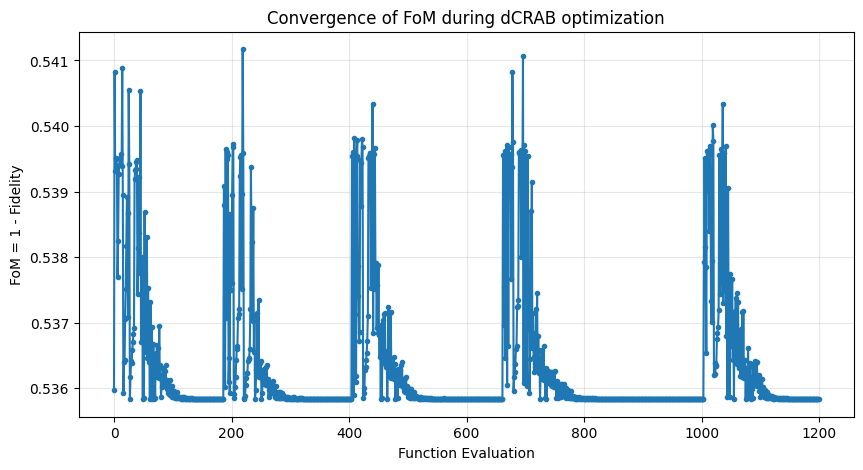

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


opt_alg = optimizer.get_optimization_algorithm()


fom_list = np.array(opt_alg.FoM_list)
N = len(fom_list)

plt.figure(figsize=(10,5))
plt.plot(fom_list, "-o", markersize=3)
plt.xlabel("Function Evaluation")
plt.ylabel("FoM = 1 - Fidelity")
plt.title("Convergence of FoM during dCRAB optimization")
plt.grid(alpha=0.3)
plt.show()


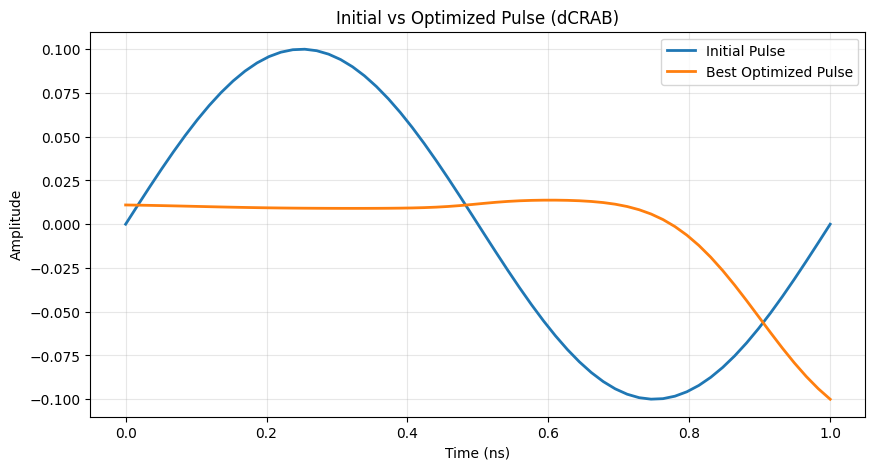

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


best_controls = opt_alg.get_best_controls()
best_pulse = np.array(best_controls["pulses"][0])
time_best = np.array(best_controls["timegrids"][0])


T = time_best[-1]
initial_pulse = 0.1 * np.sin(2 * np.pi * time_best / T)

# Plot comparison
plt.figure(figsize=(10,5))
plt.plot(time_best, initial_pulse, label="Initial Pulse", linewidth=2)
plt.plot(time_best, best_pulse, label="Best Optimized Pulse", linewidth=2)
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.title("Initial vs Optimized Pulse (dCRAB)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
